In [1]:
!pip list

Package                  Version
------------------------ -----------
aiohappyeyeballs         2.6.1
aiohttp                  3.12.13
aiosignal                1.4.0
annotated-types          0.7.0
anyio                    4.9.0
asttokens                3.0.0
attrs                    25.3.0
certifi                  2025.6.15
charset-normalizer       3.4.2
colorama                 0.4.6
comm                     0.2.2
dataclasses-json         0.6.7
debugpy                  1.8.11
decorator                5.2.1
distro                   1.9.0
exceptiongroup           1.3.0
executing                2.2.0
faiss-cpu                1.11.0
filelock                 3.18.0
frozenlist               1.7.0
fsspec                   2025.5.1
graphviz                 0.21
greenlet                 3.2.3
h11                      0.16.0
httpcore                 1.0.9
httpx                    0.28.1
httpx-sse                0.4.1
huggingface-hub          0.33.2
idna                     3.10
importlib_metadat

In [1]:
from typing import TypedDict, List, Annotated
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
import os
from langgraph.graph import StateGraph
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

In [6]:
# 환경 변수 설정
load_dotenv()
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")  

# FAISS 벡터 DB 불러오기
embedding_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large-instruct")
vectorstore = FAISS.load_local("card_QA_faiss_db", embedding_model,allow_dangerous_deserialization=True)


In [7]:
# 1. State 정의
class GraphState(TypedDict):
    question: Annotated[str, "질문"]
    answer: Annotated[str, "답변"]
    score: Annotated[float, "유사도 점수"]
    retriever_docs: Annotated[List[Document], "유사도 상위문서"]

# 2. 노드 정의
def retriever_node(state: GraphState) -> GraphState:
    docs = vectorstore.similarity_search_with_score(state["question"], k=3)
    retrieved_docs = [doc for doc, _ in docs]
    score = docs[0][1]
    # print("\n[retriever_node] 문서:", [doc.page_content for doc in retrieved_docs])
    print("[queston]:", state["question"])
    print("[retriever_node] 상위 문서의 제목:\n",docs)
    print("[retriever_node] 유사도 점수:", score)
    # print('-'*100)
    # print(docs)
    # print('-'*100)
    # print(retrieved_docs[0])
    return GraphState(score=score, retriever_docs=retrieved_docs)

def grade_documents_node(state: GraphState) -> GraphState:
    return GraphState()

def llm_answer_node(state: GraphState) -> GraphState:
    prompt = ChatPromptTemplate.from_template(
        """
        문서: {docs}
        질문: {question}
        위 문서들을 참고해서 질문에 답변해줘.
        """
    )
    docs_content = "\n---\n".join([doc.page_content for doc in state["retriever_docs"]])
    chain = prompt | ChatOpenAI(model="gpt-4.1-mini-2025-04-14")
    answer = chain.invoke({"docs": docs_content, "question": state["question"]}).content
    print("\n[llm_answer_node] 생성된 답변:", answer)
    return GraphState(answer=answer)

def query_rewrite_node(state: GraphState) -> GraphState:
    prompt = ChatPromptTemplate.from_template(
        """
        원본 질문: {question}
        위 질문의 핵심은 유지하면서, 유사 문서를 더 잘 찾을 수 있도록 질문을 다시 써줘.
        """
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-mini-2025-04-14")
    new_question = chain.invoke({"question": state["question"]}).content
    print("\n[query_rewrite_node] :", new_question)
    return GraphState(question=new_question)

# 3. 노드 분기 함수 정의
def decide_to_generate(state: GraphState) -> str:
    """
    문서의 유사도 점수에 따라 다음 노드를 결정
    - score가 0.23 이하면 'llm_answer'로 이동
    - score가 0.23 초과면 'query_rewrite'로 이동
    """
    if state["score"] <= 0.23:
        return "llm_answer"
    else:
        return "query_rewrite"


# 4. LangGraph 구성 및 연결
workflow = StateGraph(GraphState)
workflow.add_node("retriever", retriever_node)
workflow.add_node("grade_documents", grade_documents_node)
workflow.add_node("llm_answer", llm_answer_node)
workflow.add_node("query_rewrite", query_rewrite_node)
workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "llm_answer": "llm_answer",
        "query_rewrite": "query_rewrite",
    },
)
workflow.add_edge("query_rewrite", "retriever")

In [8]:
# 실행 
app = workflow.compile()

response = app.invoke({"question": "비번 변경", "answer": "", "score": 0.0, "retriever_docs": []})
print("\n[최종 답변]:", response["answer"])

[queston]: 비번 변경
[retriever_node] 상위 문서의 제목:
 [(Document(id='50f991c5-7cdc-4fe9-8b6e-288eb0c3b91b', metadata={}, page_content='인증 비밀번호를 3회 잘못 입력 시 앱이 종료되고 누적 5회 시 서비스가 초기화 됩니다. 재가입, 인증 후 이용부탁드립니다.'), np.float32(0.26459503)), (Document(id='6038104b-bd52-4dc6-a759-a4cab6f7b13e', metadata={}, page_content='전체메뉴 > 설정[톱니카드 모양] > 인증 및 보안 > 앱 비밀번호 변경 메뉴를 선택해 재인증/등록으로 앱 비밀번호를 재설정할 수 있습니다. 앱 비밀번호 오류 3회 초과 시 서비스 인증이 해지되어 재인증/등록을 해야 합니다.'), np.float32(0.26668274)), (Document(id='1d55e85d-0f87-4a71-bc2b-e20b8bbd5f23', metadata={}, page_content='등록된 카드를 해제하고 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.'), np.float32(0.2671058))]
[retriever_node] 유사도 점수: 0.26459503

[query_rewrite_node] : 비밀번호 변경 방법 안내 부탁드립니다.
[queston]: 비밀번호 변경 방법 안내 부탁드립니다.
[retriever_node] 상위 문서의 제목:
 [(Document(id='1d55e85d-0f87-4a71-bc2b-e20b8bbd5f23', metadata={}, page_content='등록된 카드를 해제하고 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.'), np.float32(0.21309799)), (Document(id='0357412b-0536-46e7-9bdb-498b68803096', metadata={}, page_content='인증 비밀번호를 잊어버린

# RAGAS - RAG 성능평가 함수 

In [ ]:
# !pip install ragas
# !pip show ragas

Name: ragas
Version: 0.2.15
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: C:\Users\Playdata\anaconda3\envs\langgraph_env\Lib\site-packages
Requires: appdirs, datasets, diskcache, langchain, langchain-community, langchain-core, langchain_openai, nest-asyncio, numpy, openai, pydantic, tiktoken
Required-by: 


In [ ]:
# from datasets import Dataset
# from ragas import evaluate
# from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# # 데이터 로드
# with open('faq_for_vectordb.json', 'r', encoding='utf-8') as file:
#     faq_data = json.load(file)

# # lang_graph 모델에서 답변 받아오는 함수 정의 (사용자의 lang_graph 모델로 바꿔주세요)
# def get_answer_from_model(question):
#     response = app.invoke({"question": question})  
#     answer_text = response.get('answer', '')  # 모델 응답에서 실제 답변 텍스트만 추출
#     return answer_text


# # 질문에 대한 모델의 답변 생성
# generated_answers = [get_answer_from_model(item["title"]) for item in faq_data]

# # 평가를 위한 데이터셋 준비
# data = {
#     "question": [item["title"] for item in faq_data],
#     "answer": generated_answers, # 모델에서 생성한 답변
#     "contexts": [[item["page_content"]] for item in faq_data],  # context는 원본 내용을 사용
#     "reference": [item["page_content"] for item in faq_data]  # 원본 답변을 reference로 사용
# }

# dataset = Dataset.from_dict(data)

# # RAGAS 평가 실행
# result = evaluate(
#     dataset=dataset,
#     metrics=[faithfulness, answer_relevancy, context_precision, context_recall]
# )

# # 평가 결과 DataFrame 출력
# result_df = result.to_pandas()
# print(result_df)

# # 평가 결과 시각화
# fig, ax = plt.subplots(figsize=(12, 6))
# result_df.mean().plot(kind='bar', ax=ax, color=['#4caf50', '#2196f3', '#ff9800', '#e91e63'])
# plt.title('RAGAS Evaluation Metrics')
# plt.ylabel('Score')
# plt.xlabel('Metrics')
# plt.ylim(0, 1)
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--')

# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# plt.tight_layout()
# plt.show()


[queston]: 홈페이지에서 카드신청 했는데 취소할 수 없나요?
[retriever_node] 상위 문서의 제목:
 [(Document(id='1d55e85d-0f87-4a71-bc2b-e20b8bbd5f23', metadata={}, page_content='등록된 카드를 해제하고 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.'), np.float32(0.18752891)), (Document(id='1783da92-ceee-49e7-a83b-877ee2099219', metadata={}, page_content='하나카드 홈페이지를 통해 카드 발급을 신청하신 경우, 대략적으로 2~3일 정도 경과 후 발급 가능여부 확인이 가능하며, 이미 접수 된 카드 신청은 홈페이지에서 취소 처리가 불가합니다. 카드 신청 취소를 원하실 경우, 하나카드 고객센터(☎1800-1111)로 요청 해 주시거나, 심사 담당자가 연락을 드렸을 시 신청 취소 요청 해 주시기 바랍니다.'), np.float32(0.20137644)), (Document(id='a0b46fbc-a86c-4cd0-80ac-0af65c382fe2', metadata={}, page_content='하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용 설정 메뉴에서 서비스 차단이 가능합니다.'), np.float32(0.2072179))]
[retriever_node] 유사도 점수: 0.18752891

[llm_answer_node] 생성된 답변: 하나카드 홈페이지에서 카드 발급 신청을 한 경우에는 이미 접수된 카드 신청은 홈페이지에서 직접 취소 처리가 불가능합니다. 카드 신청을 취소하고자 하시면 하나카드 고객센터(☎1800-1111)에 연락하시거나, 심사 담당자가 연락을 드렸을 때 신청 취소 요청을 하셔야 합니다.
[queston]: 카드 비밀번호를 변경하고 싶어요.
[retriever_node] 상위 문서의 제목:
 [(Document(id='1d55e85d-0f87-4a71-bc2b

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

C:\Users\Playdata\AppData\Local\Temp\ipykernel_24424\4163628280.py:26: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name='gpt-4.1-mini-2025-04-14')
C:\Users\Playdata\AppData\Local\Temp\ipykernel_24424\4163628280.py:35: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain.run(question)
Evaluating:  58%|█████▊    | 648/1108 [19:24<17:29:37, 136.91s/it]Exception raised in Job[640]: TimeoutError()
Exception raised in Job[659]: TimeoutError()
Exception raised in Job[650]: TimeoutError()
Exception raised in Job[648]: TimeoutError()
Exception raised in Job[652]: T

                                            user_input  \
0                           홈페이지에서 카드신청 했는데 취소할 수 없나요?   
1                                   카드 비밀번호를 변경하고 싶어요.   
2                          하나카드 VIP회원은 어떻게 하면 될 수 있나요?   
3                         카드 교체/추가로 발급했는데 비밀번호가 변경되나요?   
4                               카드 비밀번호 등록 방법을 알고 싶어요.   
..                                                 ...   
272                                   등록카드 수의 제한이 있나요?   
273                                지문인식 기능은 어떻게 사용하나요?   
274                                      하나Pay는 안전한가요?   
275                                  카드 순서는 어떻게 설정되나요?   
276  위변조된 휴대전화 또는 루팅된 휴대전화라며 앱이 구동되지 않는 경우, 어떻게 해야하나요?   

                                    retrieved_contexts  \
0    [하나카드 홈페이지를 통해 카드 발급을 신청하신 경우, 대략적으로 2~3일 정도 경...   
1    [카드 비밀번호 변경을 원하시는 경우, 다음과 같은 방법으로 변경해주시기 바랍니다....   
2    [VIP제도는 회원의 카드이용실적에 따라 매년 1회 선정하여 1년간 다양한 혜택을 ...   
3    [기존에 소지하셨던 카드를 [분실/훼손/종류변경] 등의 사유로 교체 또는 추가 발급...   
4    [당사는 『카드

TypeError: Could not convert ["홈페이지에서 카드신청 했는데 취소할 수 없나요?카드 비밀번호를 변경하고 싶어요.하나카드 VIP회원은 어떻게 하면 될 수 있나요?카드 교체/추가로 발급했는데 비밀번호가 변경되나요?카드 비밀번호 등록 방법을 알고 싶어요.카드를 수령했는데 사용이 안됩니다. 어떻게 해야하나요?체크카드 사용이 안돼요. 왜 이런건가요?카드 한도는 어떻게 설정되는 건가요?신용카드 후불교통카드로 교통기능을 사용할 수 있는 지역은 어디인가요?전체카드 해지는 어디서 하나요?시각장애인용 점자약관을 받으려면 어떻게 해야하나요?신용회복 신청 후 확정되기까지 어느 정도 기다려야 되나요? 진행상황을 알 수 있나요?개인회생 신청부터 변제계획 인가 결정까지 소요되는 기간은 얼마나 되나요? 진행상황을 알 수 있나요?카드 사용한 가맹점 정보는 어떻게 확인할 수 있나요?승인취소와 매출취소의 차이점은 무엇인가요?승인이 취소되었는지 확인하는 방법은?온라인(국내가맹점+해외가맹점 또는 온라인 사이트)거래 시 이용이 안됩니다.카드 사용이 불가한 가맹점이나 업종이 있나요?한도는 충분한데 한도초과로 승인거절 되었습니다.카드는 정상인데 승인이 거절되었어요.어제까지 사용했던 IC카드 거래가 승인이 안됩니다.카드 사용시 승인 거절되는 사례에 대해 알고 싶습니다.선결제를 했는데요. 비씨 TOP 포인트는 바로 적립되나요?통신요금을 할인받을 수 있는 카드 좀 알려주세요.스카이패스 또는 아시아나클럽 신용카드(BC포함) 이용시 항공 마일리지는 언제 적립되나요?적립된 하나머니로 무엇을 할 수 있고 어떻게 신청하나요?하나머니 적립은 언제 되는건가요?주유할인 방식은 어떻게 산출되나요?사고예방팀(FDS)이란 곳에서 연락이 왔는데 하나카드에서 온 전화가 맞나요?기존의 하나은행 인터넷뱅킹 회원도 하나카드 홈페이지의 웹회원으로 새로 가입해야 하나요?웹회원은 어떻게 가입하나요? (개인)기업 웹회원은 어떻게 가입하나요?총괄관리책임자로 가입하려면 어떻게 해야하나요? (기업 웹회원)기업카드사용자는 어떻게 웹회원에 가입하나요? (기업 웹회원)SSO(Single Sign On)서비스가 무엇인가요?'Setparam API는 바운드 상태에서만 사용이 가능합니다.' 라는 문구가 팝업되요.개명 혹은 주민번호 변경 하고나서 홈페이지 로그인이 안돼요.OS와 브라우저별로 보안프로그램 설치방법이 다른가요?Ahnlab Safe Transaction 가 무슨 말인가요?익스플로어와 그 외 브라우저 지원 버전은 어떻게 되나요?웹접근성 서비스란 무엇인가요?이용대금명세서를 받지 못했어요. 어떻게 하나요?취소내역이 포함되어 청구되었어요.결제일별 이용기간에 맞게 사용한 건이 청구되지 않았어요.교통카드 이용요금의 청구기준이 어떻게 되나요?이용대금명세서를 모바일로 받을 수 있나요?할부개월수 변경이 가능한가요?연체금액을 완납했는데 청구서에는 아직도 연체금액이 남아있는 것으로 나오는데 어떻게 된건가요?청구서 결제금액과 실제 출금 금액이 달라요.카드 사용취소 후 환불은 언제 되나요?환불 되어야 하는 금액이 아직 통장에 입금되지 않았어요.카드대금을 결제하려면 어떤 방법들이 있나요?결제일 결제계좌에 수표 입금 시 당일 자동출금이 되나요?결제대금은 결제계좌에서 언제 자동출금 되나요?결제일 은행 마감시간 이후 카드 결제계좌에 입금 시 결제가 가능한가요?카드 결제계좌에 잔고가 있었는데 자동출금이 되지 않았어요카드를 해지했는데 카드대금이 결제계좌에서 자동출금이 되었어요.미납 결제대금을 결제하려면 어떻게 해야 하나요?카드대금 선결제시 결제계좌 이외에 다른 계좌에서도 결제가 가능한가요?카드대금 즉시출금 거래가 하고 싶어요.가상계좌가 무엇인가요?가상계좌로 결제대금을 입금하려면 어떻게 해야 하나요?카드대금 입금시 변제순서를 알고 싶어요.카드대금 이중 출금된 금액은 언제 환불이 되나요?해외에서 체크카드 이용했는데 결제일에 청구가 되었습니다.여행하는 국가의 ATM기 위치를 사전에 확인하고 싶어요.카드가 정상인데 해외에서 사용이 되지 않습니다.해외 이용 시 청구금액은 어떻게 계산되나요?해외에서 신용카드를 많이 사용하면 세무조사를 받는다는데 사실인가요?해외에서 이용하지 않은 금액이 청구되었습니다.해외에서 물건을 구매하고 면세를 받으려면 어떻게 해야 하나요?체크카드 해외 이용 방법 및 부과되는 수수료는 어떻게 되나요?카드와 여권의 영문성명이 다른데 해외에서 사용하는데 지장은 없나요?해외사용 이의신청방법을 알려주세요.해외에서 카드를 사용했는데 명세서에 표기된 국가가 사용한 국가와 다릅니다.해외에서 현지통화로 승인 했다고 생각했는데 KRW(원화)로 승인되어 더 많은 금액이 청구...해외에서 이용한 영수증은 언제까지 보관해야 하나요?기내에서 물건을 구매했는데 다른 날짜로 승인이 되었습니다.해외에서 카드사용을 하려고 하는데 별도로 등록을 해야하나요?물건 구입시 현금으로 REFUND를 받지 않고 면세 신고를 하고 왔다고 생각했는데 처리가 안된것 같습니다.해외에서 취소 시 주의 할 점은 무엇입니까?해외에서 카드를 분실하였는데 해외 체류지로 긴급 배송받을 수 있나요?TAX REFUND는 신청 후 언제 받을 수 있나요?해외 ATM에서 현금 인출이 되지 않습니다.체크카드로 해외 ATM에서 현금인출 시 수수료가 발생 되나요?장기카드대출(카드론)에 대해서 알려주세요.단기카드대출(현금서비스)를 언제 다시 사용할 수 있나요?단기카드대출(현금서비스) 이용하려면 어떻게 해야 하나요?장기카드대출(카드론) 금융거래확인서는 어떻게 받을 수 있나요?장기카드대출(카드론) 만기상품 연장은 어떻게 신청하나요?장기카드대출(카드론) 대출계약 철회권은 무엇인가요?장기카드대출(카드론) 선결제를 하였는데, 이용안내장에서 안내된 이자금액보다 많이 납부하는 것 같아요.장기카드대출(카드론)을 이용 후, 중도 상환하게 되면 수수료가 발생하나요?장기카드대출(카드론)의 상환방식에는 어떤 종류가 있나요?장기카드대출(카드론)은 어떻게 신청하나요?장기카드대출(카드론)을 받았는데, 중도상환을 하고 싶어요.장기카드대출(카드론) 당일 상환시 수수료가 부과되나요?장기카드대출(카드론) 이자율 할인 혜택은 어디서 확인이 가능한가요?장기카드대출(카드론)을 이용하면 신용등급 또는 개인신용평점이 하락하나요?장기카드대출(카드론) 신청결과와 상환일정은 어디서 확인할 수 있나요?장기카드대출(카드론)도 단기카드대출(현금서비스)와 같이 은행CD/ATM에서 바로 뽑을 수 있나요?장기카드대출(카드론)을 결제계좌가 아닌 다른 계좌로 받을 수 있나요?장기카드대출(카드론) 휴대폰 인증 시 꼭 본인명의의 휴대전화로 받아야 되나요?장기카드대출(카드론)을 신청하면 언제 입금이 되나요?장기카드대출(카드론)의 신청금액에 따라 가능한 대출 개월 수가 다른 이유는 뭔가요?장기카드대출(카드론)의 최소 신청 금액은 얼마인가요?장기카드대출(카드론) 신청 전에 이자율 및 월상환예정금액을 알고 싶어요.장기카드대출(카드론) 한도가 없어요.결제금액보다 부족할 경우, 결제금액이 완납될 때까지 출금하나요?일부결제금액이월약정(리볼빙) 서비스 한도는 어떻게 적용되나요?일부결제금액이월약정(리볼빙) 서비스 신청 이전에 사용한 금액은 어떻게 되나요?여러장의 하나카드를 가지고 있는데, 1장은 일부결제금액이월약정(리볼빙)으로 나머지는 일반결제 용도로 이용할 수 있나요?일부결제금액이월약정(리볼빙) 서비스를 신청하면 무조건 수수료가 부과되나요?일부결제금액이월약정(리볼빙) 해지 후 재신청이 가능한가요?결제일이라 결제비율변경이 불가한데 청구금액보다 적게 납부할 방법이 없나요?당월에 이용한 금액이 '일부결제금액이월약정(리볼빙) 일시불'로 보입니다. 왜 그런가요?일부결제금액이월약정(리볼빙)은 언제까지 신청해야 이번 달부터 적용 받을 수 있나요?모바일카드 결제가 잘 되던 가맹점에서 갑자기 되지 않습니다. (오프라인)모바일카드는 신청 즉시 발급되고 바로 이용가능 한가요?모바일카드 발급을 위해 플라스틱카드를 발급해야 하나요?가족카드/법인카드로 모바일카드를 받을 수 있나요?발급SMS가 삭제되어 다시 받고 싶습니다.모바일카드가 2개인데, 주결제카드를 편리하게 변경할 수 있나요?유심칩이 뭔가요?삼성페이 및 타사 모바일카드(HCE)와 동시에 이용이 가능한가요?스마트폰을 교체하면 모바일카드를 재신청해야 하나요?휴대전화 해지후에도 이용이 가능한가요?모바일카드 카드번호/CVV/유효기간 어떻게 확인하나요?모바일카드를 발급받으면 연회비가 추가되나요?모바일카드가 있는 스마트폰을 분실하면 어떻게 되나요?플라스틱카드를 분실신고해도 모바일카드 사용이 가능한가요?플라스틱카드를 해지해도 모바일카드가 사용가능한가요?플라스틱카드와 모바일카드 실적은 합산되나요?모바일카드 결제시 1Q USIM card App.'을 실행해야 하나요?모바일카드는 교통카드 사용이 가능한가요?추가 혜택이 있는 모바일카드를 삼성페이(등 기타 제휴페이)에 결제해도 동일하게 혜택을 받을 수 있나요?모바일카드를 오프라인 가맹점에서 쓰고싶습니다.모바일카드 발급 후 정보를 확인 할 수 없습니다.동일사업자번호로 복수 가맹점일 경우에 동일하게 수수료율을 적용받을 수 있나요?세무서에 폐업신고로 가맹점이 해지된 경우 거래승인이 불가한가요?가맹점 해지시에는 홈페이지 이용이 불가능한가요?수수료 조정은 언제 하나요?가맹점 수수료 기준이 왜 타사와 다른가요?전화승인 후 압인전표를 받지 못했을 경우 POS 등록 가능한가요?해외카드 추심이 되면 입금은 언제 되나요?가맹점 정보변경 처리는 어떻게 해야 하나요?가맹점 신규 신청은 어떻게 해야 하나요?[상생소비지원금] 상생소비지원금(캐시백) 사업이 무엇인가요?[상생소비지원금] 언제부터 시행하나요?[상생소비지원금] 캐시백은 언제 받고 어떻게 쓸 수 있나요?[상생소비지원금] 캐시백 사용상 제약은 없나요?[상생소비지원금] 10월, 11월에 어디에서 써야 실적으로 인정되나요?[상생소비지원금] 실적적립이 가능한 인터넷 거래 예시가 궁금합니다.[상생소비지원금] 해외직구 등 해외 사용실적은 인정되나요?[상생소비지원금] 대형마트나 백화점 등의 임대매장은 사용 가능한가요?[상생소비지원금] 2분기 실적은 어떻게 산정하나요?[상생소비지원금] 프로그램 신청 자격은 어떻게 되나요?[상생소비지원금] 2분기 카드사용 실적 유무를 확인할 수 있는 방법은? 내가 대상자임을 어떻게 확인할 수 있나요?[상생소비지원금] 어디에 신청해야 하나요?[상생소비지원금] 언제 신청해야 하나요?[상생소비지원금] 어떻게 신청해야 하나요?[상생소비지원금] 가족카드로는 캐시백을 신청할 수 없나요?[상생소비지원금] 카드 사용액 및 캐시백 금액은 어떻게 확인 가능한가요?[상생소비지원금] 보다 자세한 내용을 안내 받으려면 어떻게 해야 하나요?[국민지원금] 국민지원금 지급받을 수 있는지 궁금합니다.[국민지원금] 국민지원금을 지급받을 수 있는지 본인이 확인하려면 어떻게 해야 하나요?[국민지원금] 가구원 수를 어떻게 계산해야 하나요?[국민지원금] 맞벌이 가구로 인정받을 수 있나요?[국민지원금] 누가 신청할 수 있나요?[국민지원금] 온라인으로 카드 신청을 할 수 없거나, 고령자·장애인 등 거동이 불편한 주민은 어떻게 신청해야 하나요?[국민지원금] 신용·체크카드로 국민지원금을 받으려면 어떻게 해야 하나요?[국민지원금] 국민지원금은 어디에서 사용할 수 있나요?[국민지원금] 왜 국민지원금은 온라인 쇼핑몰 또는 배달앱에서 사용이 안되는 건가요?[국민지원금] 6/30(수) 이후 이사를 한 경우 어디에서 신청 및 사용이 가능한가요?[국민지원금] 이의신청은 어떻게 하나요?[국민지원금] 2019년도에 비해 2020년에 소득이 많이 감소하였지만, 건강보험료에는 이러한 사항이 반영되지 않아 지급대상자에 포함되지 못했습니다.[국민지원금] 6/30(수) 이후 혼인·이혼, 출생·사망 등 가족관계 변동이 있는 경우에는 어떻게 하나요?[국민지원금] 이외에도 궁금한 것이 많이 있습니다. 국민지원금 관련 문의는 어디로 하면 되나요?[정부긴급재난지원금] 긴급재난지원금을 어떻게 기부할 수 있나요?[정부긴급재난지원금] 이의신청은 어떻게 하나요?[정부긴급재난지원금] 긴급재난지원금 지급액은 얼마인가요?[정부긴급재난지원금] 신용·체크카드로 충전된 긴급재난지원금은 어디에서 사용할 수 있나요?[정부긴급재난지원금] 긴급재난지원금은 언제까지 사용 가능한가요?[정부긴급재난지원금] 3. 29(일) 이후 이사를 한 경우 어디에서 신청이 가능한가요?[정부긴급재난지원금] 선불카드, 지역사랑상품권으로 긴급재난지원금을 받으려면 어떻게 해야하나요?[정부긴급재난지원금] 신용·체크카드로 긴급재난지원금을 받으려면 어떻게 해야하나요?[정부긴급재난지원금] 긴급재난지원금을 지급받는 수단은 어떤 것이 있나요?[정부긴급재난지원금] 긴급재난지원금 지급 대상자는 어떻게 되나요?[경기도재난지원금] 카드 이용 중, 지원금 사용 기간 내 카드 상태 정지가 발생한다면 잔여 금액만큼은 승인 가능한가요?[경기도재난지원금] 재난지원금 사용 가능한 가맹점에서 잔여지원금보다 큰 금액을 이용했을 때 차감 기준은 어떻게 되나요?[경기도재난지원금] 카드사는 하나카드로 신청 후, 카드번호를 잘못 입력하였습니다.(타 카드사 번호 입력 포함)[경기도재난지원금] 재난지원금 사용 내역의 기준일자는 언제인가요?[경기도재난지원금] LMS 등 재난지원금 사용 내역 관련 별도 안내는 없나요?[경기도재난지원금] 할부 거래는 가능한가요? 할부 거래 시 지원금 차감은 어떻게 되나요?[경기도재난지원금]재난지원금 대상 가맹점 여부는 어떻게 확인할 수 있나요?[경기도재난지원금] 결제 금액이 재난지원금에서 차감되지 않았습니다.[경기도재난지원금] 재난지원금 이용 거래 여부는 어떻게 확인할 수 있나요?[경기도재난지원금] 재난지원금 이용 거래는 카드사용 실적 인정 및 상품별 혜택(포인트, 마일리지 등) 적립되나요?신용대출 신청 후 대출금은 언제 입금되나요?신용대출 대출철회는 어떻게 하나요?신용대출은 어떻게 신청하나요?신용대출 중도상환시 중도상환수수료가 부과되나요?신용대출을 이용하면 신용등급 또는 개인신용평점이 하락하나요?신용대출 당일 상환시 수수료가 부과되나요?한도조회 하는 것 만으로 신용도에 영향이 있나요?하나카드가 없어도 신용대출이 가능한가요?신차구매는 어떻게 신청하나요?한도조회 하는 것 만으로 신용도에 영향이 있나요?근저당설정이 무슨 의미인가요?중도상환을 하려면 어떻게 해야 하나요?신차할부(오토론)으로 대출 가능한 차종은 어떻게 되나요?이용 가능한 신차할부(오토론) 한도가 얼마나 되나요?신차할부(오토론)이란?모든 스마트폰에서 하나Pay를 이용할 수 있나요?카드미소지 회원은 하나Pay 서비스를 이용할 수 없나요?서비스를 탈퇴하고 싶습니다. 어떻게 해야하나요?휴대폰 분실(카드분실) 등의 이유로 하나Pay 서비스를 해지하고 싶어요.하나Pay 앱 삭제 후 재설치하면 모든 정보들은 없어지나요?하나Pay 가입 시 회원인증 중 본인정보가 일치하지 않다고 합니다.가족카드 이용고객입니다. 가족카드도 하나Pay를 이용할 수 있나요?가입 시 휴대폰번호를 찾을 수 없다고 합니다. (다른 번호 확인 등)SMS 인증단계에서 인증번호가 도착하지 않습니다.하나Pay는 서비스 가입제한이 있나요?스마트폰 변경(기기/번호이동 등)을 했어요.앱 비밀번호를 분실했어요.자동로그인 기능은 어떻게 해지하나요?카드 신청 후 실물카드를 받기 전에, 어떻게 하나Pay를 이용할 수 있나요?게임 관련 사이트는 하나Pay만 결제할 수 있나요?아이폰을 사용하고 있는데 결제가 되지 않습니다.결제 중 바코드 인식이 되지 않습니다. 어떻게 해야하나요?바코드를 스캔하거나 사진촬영을 해서 결제할 수 있나요?하나Pay 결제 취소는 어떻게 하나요?오프라인 가맹점(매장결제) 결제방법을 알려주세요.받은 쿠폰은 어디서 확인할 수 있나요?하나머니는 어떤 포인트인가요?홈페이지 인증은 별도의 이용기간이 정해져 있나요?홈페이지 인증은 스마트폰이나 태블릿에서 이용할 수 없나요?홈페이지 인증으로 등록된 카드변경은 어떻게 하나요?홈페이지 인증은 여러 장의 카드로 등록이 불가능한가요?홈페이지 인증 등록 시 반드시 공동인증서를 이용해 등록해야하나요?홈페이지 인증 시 입력하는 ID는 무엇인가요?홈페이지 인증 등록 단계에서 등록 가능한 카드가 없다는 오류메시지가 나옵니다.홈페이지 인증 등록은 어디서 하나요?홈페이지 인증은 무엇인가요?인증 비밀번호를 3회/누적 5회를 틀렸습니다.인증 비밀번호를 잊어버렸습니다.하나Pay 실행 후 인증이 가능한 카드가 없다는 오류메시지가 나옵니다.하나Pay 앱에서 유효한 인증코드가 아닙니다라는 오류메시지가 나옵니다.간편인증 이용을 위해 반드시 하나Pay 앱을 설치해야하나요?인증을 완료했는데 유효한 카드가 아니라고 합니다.ARS인증 시 등록된 전화번호가 아니라고 합니다.ARS인증 시 먼저 걸려온 전화로 인해 ARS인증을 하지 못했습니다.ARS인증 시 실수로 통화거절을 눌렀습니다.ARS인증 시 입력된 전화번호로 전화가 오지 않습니다.일반인증 시 카드번호와 휴대폰번호를 입력했는데 일치하는 정보가 나오지 않는다는 오류메시지가 나옵니다.인증화면에서 이름, 성명, 생년월일을 추가로 입력하라고 합니다. 어떤 경우에 이렇게 나오나요?카드본인확인서비스를 이용하고 싶지 않습니다.휴대폰이 없는 손님은 카드본인확인서비스를 이용할 수 없나요?카드본인확인 이용이력은 어디서 확인할 수 있나요?카드본인확인이 차단(이용할 수 없다는)되었다는 오류가 나옵니다.본인명의의 카드를 입력하였는데 유효하지 않은 카드라는 오류메시지가 나옵니다.이번 달 나의 카드 할인 혜택 정보를 알고 싶습니다.해외 로밍 중일 때에도 하나Pay 서비스는 무료인가요?카드사용 취소 시에도 알림 메시지가 오나요?알림 메시지 서비스를 받고 싶지 않은데 어떻게 하나요?알림 메시지가 왔을 때 진동으로 설정하고 싶습니다.알림함의 메시지는 서버에 얼마동안 보관되나요?알림함에서 메시지를 삭제할 수 있나요?하나카드의 신규 카드를 알 수 있나요?신용카드로 결제를 했는데 승인내역 알림 메시지를 받지 못했습니다.앱 비밀번호 오류 횟수 초과 시 어떻게 해야하나요?로그인 번호와 앱 비밀번호를 따로 설정해야 하나요?등록카드 수의 제한이 있나요?지문인식 기능은 어떻게 사용하나요?하나Pay는 안전한가요?카드 순서는 어떻게 설정되나요?위변조된 휴대전화 또는 루팅된 휴대전화라며 앱이 구동되지 않는 경우, 어떻게 해야하나요?"
 list(['하나카드 홈페이지를 통해 카드 발급을 신청하신 경우, 대략적으로 2~3일 정도 경과 후 발급 가능여부 확인이 가능하며, 이미 접수 된 카드 신청은 홈페이지에서 취소 처리가 불가합니다. 카드 신청 취소를 원하실 경우, 하나카드 고객센터(☎1800-1111)로 요청 해 주시거나, 심사 담당자가 연락을 드렸을 시 신청 취소 요청 해 주시기 바랍니다.', '카드 비밀번호 변경을 원하시는 경우, 다음과 같은 방법으로 변경해주시기 바랍니다. [비밀번호 변경] 하나카드 홈페이지 접속 > 로그인 > 카드 > 발급조회/사용등록 > 카드비밀번호등록/변경 에서 변경 가능합니다. 카드비밀번호등록/변경', 'VIP제도는 회원의 카드이용실적에 따라 매년 1회 선정하여 1년간 다양한 혜택을 드리는 제도로, 산정기간의 종합점수를 기준으로 VIP회원을 선정하게 됩니다. 자세한 내용은 VIP제도 안내를 참조하시기 바랍니다. VIP제도 안내', '기존에 소지하셨던 카드를 [분실/훼손/종류변경] 등의 사유로 교체 또는 추가 발급을 받으시는 경우 『카드 비밀번호』는 다음과 같이 적용됩니다. ■ 카드 교체/추가 발급 시 비밀번호 운영기준 구분 내용 교체 발급 ① 최근 6개월 유실적 카드 중 가장 최근 발급한 카드의 비밀번호 ② ①이 없을 경우, 사용등록이 된 카드 중 가장 최근 발급받은 카드의 비밀번호 ※ 단, 가족카드는 비밀번호 승계 우선순서 대상카드(①, ②)에서 제외 추가 발급 이용카드가 없을 시 가장 최근에 발급한 카드와 동일한 비밀번호 사용 단, 기존 비밀번호가 없을 시, 카드 발급 시 ARS를 통해 비밀번호 등록', '당사는 『카드 신규 신청 시 비밀번호』는 별도로 신청서에 기재하지 않고, 카드 심사시 심사 담당자를 통해 고객님께서 직접 ARS를 이용하여 비밀번호를 등록하거나, 카드 수령 후 ARS를 통해 비밀번호를 등록하고 있습니다. 카드사용등록서비스ARS (1800-1111)', '고객님의 안전한 카드 사용을 위해 카드 배송 시 일시적으로 사용이 정지된 상태에서 배송됩니다. 카드수령 후 즉시 사용을 원하실경우 아래와 같은 방법으로 카드 사용등록을 하신 후 사용하시면 됩니다. [카드 사용등록 방법] ARS : 1800-1111 > 9번 홈페이지 : 카드 > 발급조회/사용등록 > 카드사용등록(신용카드, 선불카드) 카드 사용등록', '체크카드 사용이 잘 되지 않는다면 통장에 잔액이 충분한지 확인하시기 바랍니다. 체크카드와 연계된 통장에 잔액이 충분한데도 잘 사용되지 않는다면 아래 사항을 체크해 주세요. ① 일일 사용한도를 초과한 경우 1일 500만원 / 월간 2,000만원 ② 당일에 타행 자기앞수표를 입금하신 경우 타행 자기앞수표가 자금화 된 이후 이용이 가능합니다. 자금화란? 입금하신 수표가 현금화 되는 것으로써 익일(은행 영업일 기준) 오후 2시 20분을 말합니다. 자금화 시간은 사정에 따라 연장될 수 있습니다. ③ 기타 마그네틱이 손상되었거나, 일시적인 전산장애로 승인이 안될 수 있습니다. 통장 잔액과 출금가능금액이 같은지 확인해주세요. 해외사용건이 있다면 승인시점 금액이 지급정지 되어 출금가능금액이 더 적을 수 있습니다. 체크카드의 결제계좌를 타 은행계좌로 설정하신 경우 해외결제 승인이 불가합니다.', '1. 카드 이용한도는 회원의 결제능력, 신용등급 또는 개인신용평점, 카드 이용실적 등 개인 신용도를 종합적으로 고려하여 산정됩니다. 2. 일시불, 할부, 단기카드대출(현금서비스), 해외한도 모두 카드 이용한도 내에서 사용 가능합니다. 3. 카드 이용한도는 회원별로 부여됩니다. 따라서 카드를 추가 발급 받거나 가족 카드를 발급받은 경우에도 한도가 추가로 부여되지 않으며, 기존에 부여된 한도 내에서만 카드 사용이 가능합니다. 4. 한도상향을 신청할 경우 하나카드 심사 절차를 통해 가능 여부가 결정되며, 상세사항은 하나카드 고객센터(1800-1111)로 문의해 주시기 바랍니다. 5. 하나카드 또는 타 금융기관 연체시, 하나카드 내부규정에 따라 카드 이용한도가 조정될 수 있습니다. 6. 금융기관 연체가 발생하지 않더라도 "신용카드 발급 및 이용한도 부여에 관한 모범규준"에 따라 카드 이용실적, 신용등급 또는 개인신용평점, 가처분소득 등을 고려하여 카드 이용한도가 변경될 수 있습니다.', '후불교통서비스 이용처 버스/지하철  서울 및 수도권 및 전국 교통카드 결제 단말기 설치 지역 택시  1회 50만원, 1일 100백만원 결제 한도 제한 카카오택시, 온다택시 등 플랫폼 택시 서비스를 포함 유료도로 남산1,3호 터널, 우면산터널, 용마터널, 문학터널, 만월산터널, 강남순환도로, 원적산터널 인천공항고속도로, 대전천변고속화도로, 부산유료도로(광안대교 수정터널, 백양터널 등), 대구유료도로 등 고속도로 전국 고속도로 톨게이트(하이패스 전용차로 제외) 기타 서울시 공영주차장 등 일부 주차장', '전체카드 해지는 고객센터(1800-1111)에서 신청이 가능합니다. (고객센터 상담시간: 평일 9:00~18:00 가능)', '하나카드는 현재 전용 고객센터 (1599-0701)을 통해 개인 신용, 체크 (일부 상품 제외) 점자카드를 신청하실 수 있으며 점자약관이 필요하실 경우 상담원에게 점자약관을 요청하시면 등기 우편으로 발송하여 드립니다.', '신용회복 신청 후 확정되기까지 약 2~3개월정도의 시간이 소요되나 진행 내용에 따라 단축 또는 연장될 수도 있습니다. 채무조정 신청(D) → 접수통지(D+1) → 채권신고(D+14) → 채무조정 심사 및 심의(D+30, 최대 1개월 범위 내 연장 가능) → 채권 금융회사 동의(D+40) → 채무조정 확정(D+60) 신청 이후 진행상황은 신용회복위원회 홈페이지(https://cyber.ccrs.or.kr 접속 → 나의 지원정보 → 지원현황 조회, 회원가입 필요) 또는 고객센터(1600-5500)를 통해 확인 가능합니다. 관련 법규 및 소비자 유의사항 신용회복 지원 협약, 채무 조정은 심의위원회 심의.의결 및 채권금융회사의 동의를 거쳐 확정됩니다. 이때 채권금융회사 동의는 무담보채권 및 담보채권 총액 중 동의한 채권금융회사 채권합계액이 과반수 이상이어야 합니다.', '신청서류를 구비하고 신청서를 작성하여 법원에 접수한 후 변제계획 인가 결정까지는 법률상의 각 절차별 기간 규정에 비추어 볼 때, 약 4개월~6개월 정도 소요될 것으로 예상 되나, 각 사건별 진행 내용에 따라 소요기간이 다소 단축되거나 연장될 수도 있습니다. 신청 이후 사건 진행 내용을 대법원 홈페이지(https://scourt.go.kr 접속 → 대국민서비스 → 사건검색) 또는 ARS 1588-9100를 통해 확인 가능합니다. 관련 법규 및 소비자 유의사항 채무자 회생 및 파산에 관한 법률, 최초 서류 제출 시 강제집행의 우려가 있는 경우에는 개시신청과 동시에 중지.금지 명령 신청을 하면 법원 판단 하에 중지.금지 명령이 결정됩니다. 중지.금지명령의 신청이 기각된다 하더라도 개인회생절차 개시결정이 되면 자동으로 모든 추심 및 강제집행이 중지됩니다.', '당사 홈페이지(www.hanacard.co.kr) 및 모바일APP → 마이페이지 → 승인내역 → 승인내역 선택 후 가맹점정보를 클릭하시면 확인하실 수 있습니다.', '승인취소는 거래 당일 또는 카드사에 해당 매출표가 접수되기 전까지의 취소를 말하며 매출취소는 카드사에 매출이 접수된 이후의 거래 취소를 말합니다.', '당사 홈페이지(www.hanacard.co.kr)및 모바일 APP에서 조회 가능하며 하나카드 고객센터(☎1800-1111)에서도 확인 가능합니다.', '인터넷 거래 시 통신 장애 발생 온라인 가맹점의 결제 대행업체인 PG사와 카드사로 승인거래를 대행해주는 VAN사에서 간혹 승인 과정에 있어서 인터넷 통신 장애로 인하여 일시적인 승인 장애가 발생될 수 있습니다. 이 경우 시간 차이를 두고 재 승인 요청을 시도하여 주시기 바랍니다. 해외 온라인 가맹점에서 브랜드(마스터, 비자, JCB, 아멕스)카드 이용 가능 여부 확인 해외 온라인 가맹점(쇼핑몰) 이용의 경우 특정 브랜드 카드만 이용 가능한 경우가 있음으로 사이트 내 결제 방법을 확인 후 이용하여 주시기 바랍니다. 참고사항 해외사용 승인에 관련된 사항은 당사 홈페이지 및 하나카드APP의 자주하는질문->해외이용을 참고하여 주시기 바랍니다.', '법인카드의 경우 일부 업종에 대해서는 법인카드 보유 손님(회사)가 승인 불가하도록 요청하셔서 승인이 거절될 수 있습니다. 또한 온라인 가맹점에서 이용이 불가한 상품 및 별도 손님 금지 요청에 의해 등록된 가맹점, 기타 거래불가 가맹점(위장, 불량가맹점, 자가매출처리 등)에서 카드 이용 시 승인 제한되어 거래 거절이 발생될 수 있습니다.', '[한도초과로 승인 거절되는 경우] 1) 카드 이용한도보다 결제 요청금액이 크면 한도초과로 승인이 거절될 수 있습니다. 손님의 이용한도를 다시 한 번 확인하여 주시기 바랍니다. 2) 매출취소에 의한 환급 및 해외사용 후불교통요금, 자동이체(월 정기성 자동납부 결제: 통신요금, 가스요금, 보험요금 등)와 같이 무승인 매입 (카드 승인 없이 직접 매입처리)되는 가맹점의 결제 건을 이용하고 계실 경우 이로 인해 사용 시점에 한도 초과가 발생될 수 있습니다. 3) 특정카드 또는 가족카드에 대한 한도금액을 낮춰서 지정해 두신 경우, 한도초과로 승인이 거절될 수 있습니다. 한도 확인 후 재설정하여 이용해주시기 바랍니다. 카드/가족한도 조회', '일반적인 한도초과, 도난분실, 거래정지, 유효기간 경과, 계좌잔액 부족 사항 등은 가맹점 단말기에서도 사유를 확인 하실 수 있습니다. 지속적으로 거래되지 않는 경우 가맹점 단말기에서 나오는 응답 메세지를 확인하시고 가맹점 단말기 상 ‘카드사 문의’란 메시지가 출력되실 경우 하나카드 고객센터(☎1800-1111)로 문의하여 주시기 바랍니다.', '카드 IC Chip이 손상되었거나, 일시적인 전산장애(단말기,POS 장애 포함)로 승인이 안될 수 있습니다. IC거래가 승인처리 되지 않을 경우 Swipe(카드 뒷면 마그네틱을 단말기에 긁어서) 거래로 승인 요청하여 거래 하실 수 있으며, 다른 가맹점에서도 동일한 증상으로 IC카드 거래가 승인되지 않을 경우 가까운 영업점 방문 및 하나카드 고객센터(☎1800-1111)로 재발급을 요청하여 주시기 바랍니다.', '승인거절의 주요 사례는 아래와 같습니다. 오프라인(승인) 신용카드 한도초과(개인/법인 사업자) 체크카드 잔액부족 도난,분실 등 거래정지 카드의 승인거래 요청 시 해지(취소) 된 카드의 승인거래 요청 시 할부 불가 카드(또는 가맹점)에서의 거래 Key-in (카드번호+유효기간) 거래 불가 가맹점에서의 승인거래 요청 시 사용 가능 포인트 초과 거래 불량가맹점 거래(거래정지 가맹점 포함) 카드번호 오류 입력 및 카드 수령 후 미 등록 비밀번호 오류횟수 초과 온라인(승인) 비밀번호 입력 오류(일반결제, 간편결제) 유효기간 입력 오류 주민/사업자번호 입력 오류 CVV/CVV2 입력 오류 신용카드 한도초과 및 체크카드 잔액 부족', '아닙니다. 선결제를 하더라도 바로 적립되지 않고 결제일에 결제하신 경우와 동일한 날짜에 TOP포인트가 적립됩니다. [적립시기] 결제일+1영업일 예시) 7월 23일 결제일인 비씨(BC)카드 회원이 7월 1일에 선결제 했을 경우 포인트 적립은 7월 1일이 아닌 7월 24일 무렵에 적립됩니다. → 7월23일 +1영업일 이후에 적립 해당 포인트에 대해 추가 문의는 BC카드 고객상담센터 1588-4000로 연락해주시기 바랍니다.', '통신요금 할인/적립 제공되는 카드는 다음과 같습니다. 1. 1Q My Cafe, 1Q My Lunch, 1Q My Edu SKT, KT, LGU+ 자동이체 시 7% 적립(월 최대 1만 하나머니) 적립조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 적립제공 2. #tag1(Orange, Navy) SKT, KT, LGU+ 자동이체 시 5%(월 3천원 한도) / 10%(월 6천원 한도)할인 할인조건 Orange : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 Navy : 전월 1일~말일까지 국내외 일시불/할부 사용금액 40만원 이상 시 사용금액 구간별 할인 제공 3. 통커 SKT, KT, LGU+ 자동이체 시 10%할인(월 1만원 한도) 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 50만원 이상 시 사용금액 구간별 할인 제공 4. Club SK SKT 자동이체 시 월 최대 1만 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 40만원 이상 시 사용금액 구간별 할인 제공 5. KT Super DC KT통신요금 자동이체 시 월 최대 1만 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 6. KT Super 할부 이용고객 : 월 최대 1만 5천원 할인 / 미 이용고객 : 월 최대 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 각 상품에 대한 상세 서비스 내용은 카드안내 → 상품별 서비스 에서 확인이 가능합니다.', '[항공마일리지 적립] 항공 마일리지 적립은 하나카드, 하나BC카드에 따라 적립일이 달라집니다. 선결제 이용 시, 적립은 본 청구일 기준으로 적립됩니다. 구분 적립시점 하나카드 (구.하나/구.외환) 청구 결제일 +2영업일에 적립 하나BC카드 청구 결제일 +7영업일 이내에 적립 [할부 매출 적립] 무이자 할부 매출은 마일리지 적립에서 제외됩니다. 구분 적립시점 하나카드 (구.하나/구.외환) 적립 마일리지를 할부 개월수로 나누어 결제 회차별 결제일 +2영업일에 적립 하나BC카드 할부 1회차 청구 시 이용대금 전액에 대해 첫 결제일 +7영업일 이내에 적립', '[포인트 확인 및 신청 방법] 1. 하나카드 홈페이지 www.hanacard.co.kr → 포인트/할인/혜택 → 포인트조회or포인트상품신청 → [로그인]을 통해 확인 및 신청 가능합니다. 단, 하나카드 웹회원이어야 하며, 포인트 신청시 인증서로 본인확인을 합니다. 온라인 신청만 가능 사은품 신청은 포인트로만 가능( ※ 차액 신용카드 결제 불가 ) 신청 후 취소는 당일만 가능 2. 하나카드 고객센터(☎1800-1111) 고객센터로 본인께서 연락을 주시면 확인 후 신청 가능합니다.(공휴일 및 토/일요일 제외) 배송은 서울지역 5영업일, 기타지역 7영업일 가량 소요됩니다. 3. 하나은행 영업점 영업점 방문시에는 주민등록증을 지참 후 본인께서 직접 방문하시면 됩니다. [하나머니 사용 방법] 포인트 기부 1포인트 이상이 되면 포인트로 기부가 가능합니다. 기부처 : 한국심장재단, 굿네이버스, 세이브더칠드런, 녹색연합, 사회복지 모금회, 월드비전, 전국재해구호협회, 한국백혈병어린이재단 등 캐쉬백 서비스 고객님께서 보유하신 하나머니가 1머니 이상인 경우 해당 하나머니를 결제계좌에 입금할 수 있습니다. 모바일 쿠폰 구매 고객님께서 보유하신 하나머니로 하나카드 쿠폰마켓에서 모바일 쿠폰을 구입 및 선물할 수 있습니다. (최소 ‘10’단위부터 사용 가능, 포인트 전액사용의 경우 ‘1’단위까지도 사용 가능) 포인트 결제대금차감 1포인트 이상 보유 시 포인트로 결제대금을 차감할 수 있습니다. 홈페이지 접속 후 로그인 > 마이페이지 > 이용금액결제 > 이용대금 포인트/크로스마일 결제를 통해 신청할 수 있습니다. 이용대금 포인트/크로스마일 결제 [유의사항] 3개월 무이자할부 기능 카드, SKYPASS, 아시아나마일리지적립 카드제외 현금서비스 이용금액, 수수료 적립 제외됩니다. 하나포인트 유효기간은 포인트 제공일로부터 5년입니다.', '카드 결제로 인한 하나머니 적립은 다양한 형태로 이루어집니다. 각 상품의 약관 확인을 통해 어떤 형태에 해당하는 지 확인해주시기 바랍니다. (1) 온·오프라인에서 카드 결제 시 해당 건마다 하나머니 적립을 해주는 경우 → 결제시점의 +1, 2 영업일 내에 적립됩니다. 예시 ) 1Q Daily+의 기본 적립 1% 서비스 (2) 일정 기간의 결제금액의 합을 기준으로 하나머니 적립을 해주는 경우 → 월 1일~말일까지의 통신/교통/자동이체 결제금액이 10만원 이상이라면 익월 7일 영업일 이내에 5천 하나머니가 적립됩니다. 예시 ) 1Q Daily+의 통신/교통/자동이체 10만원 당 5천 하나머니, 결제일자 13일 손님', '주유소별 리터당 단가가 상이하기 때문에 카드사에서는 이용하신 리터당 금액을 알 수가 없습니다.  그래서, 주유소에서 결제하신 승인금액에 한국석유공사에서 공시한 지난주의 공시가격을 적용하여 리터를 환산 후 할인금액을 산출하여 전국의 모든 주유소에서 승인된 주유금액에 대해 동일한 할인 혜택을 제공하는 방식으로 적용 됩니다.  할인금액 산정방법 주유이용금액 ----------------------× 리터당 할인금액 기준유가  주유이용금액을 기준유가로 나눈 값은 소수점 이하 절사 후 리터당 할인 제공 기준유가는 한국석유공사 에서 공시한 정유사별 기준으로 적용 상품별 상세 기준은 상품별 약관을 통해 확인 가능합니다.', '사고예방팀(FDS)은 저희 하나카드의 부서가 맞습니다. 매일 24시간 연중무휴로 운영 중에 있으며 고객님의 카드 이용 패턴과 맞지 않는 국내외 소비가 발생했을 시 휴대폰, 문자(SMS), 이메일과 카카오톡으로도 확인 연락 드리고 있습니다. 손님께 발송되는 전화번호는 하나카드의 사고예방팀의 번호(아래 사고예방팀 대표번호 참조)이며, 손님의 문의사항이 있으시다면 수신 받으신 전화번호로 전화 주시거나 하나카드 고객센터(1800-1111)로 문의를 부탁 드립니다.  사고예방팀 전화번호 주간 : 02-2003-3906 야간 : 02-2003-3911', '네, 그렇습니다. 기존의 하나은행 인터넷뱅킹 회원도 하나카드 홈페이지의 웹회원으로 가입 후 웹서비스 이용이 가능하오니, 단 한번의 웹회원 가입으로 보다 편리하고 다양한 하나카드의 웹서비스를 이용하시기 바랍니다. 기존의 하나은행 인터넷뱅킹에서 제공하던 카드관련 일부 서비스(조회, 결제, 금융 등)는 그대로 이용 가능하며, SSO(Single Sign On)서비스를 통해 하나카드 홈페이지를 편리하게 이용하실 수 있습니다.', '하나카드(신용,체크,가족카드 포함)를 소지한 고객이라면 누구나 웹회원으로 무료 가입하실 수 있습니다. [개인 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 개인 → 웹회원가입 ① 카드인증 또는 휴대폰인증 또는 아이핀인증 ② 웹회원정보 입력(아이디/비밀번호 등) 약관동의 ③ 웹회원 가입완료 계좌지정(개인형)기업카드를 소지한 고객은 기업 웹회원으로 가입 후 웹서비스를 이용하실 수 있습니다. 개인 웹회원가입기업 웹회원가입', '기업 웹회원은 총괄관리책임자와 기업카드사용자(공용카드, 사용자지정카드, 계좌지정(개인형)기업카드)로 구분됩니다. [총괄관리책임자 웹회원 가입 절차] ① 법인사업자 인 경우 : ‘기업총괄관리책임자 및 WEB관리자신고서’ 신청서 작성하여, 필요 법인서류(신청서참조) 구비하여 가까운 하나은행 영업점에 방문하셔서 총괄관리책임자 등록 후, 기업홈페이지에서 총괄관리책임자로 가입하실 수 있습니다. ② 개인사업자 인 경우 : 총괄관리책임자 등록 절차 없이, 대표자의 개인인증서로 회원가입 가능합니다. ‘기업총괄관리책임자 및 WEB관리자 신고서’ 신청서 다운로드 기업카드사용자 웹회원으로 가입하기 위해서 공용카드 사용자는 카드정보 입력이 필요하며, 사용자지정카드와 개인형 법인카드 사용자는 카드인증 또는 인증서(개인) 인증이 필요합니다. 각각의 가입 방법 안내를 참고하여 기업 웹회원으로 가입하여주시기 바랍니다.', '[총괄관리책임자 웹회원 가입 절차] ① 법인사업자 인 경우 : ‘기업총괄관리책임자 및 WEB관리자신고서’ 신청서 작성하여, 필요 법인서류(신청서참조) 구비하여 가까운 하나은행 영업점에 방문하셔서 총괄관리책임자 등록 후, 기업홈페이지에서 총괄관리책임자로 가입하실 수 있습니다. ② 개인사업자 인 경우 : 총괄관리책임자 등록 절차 없이, 대표자의 개인인증서로 회원가입 가능합니다. ‘기업총괄관리책임자 및 WEB관리자 신고서’ 신청서 다운로드 [총괄관리책임자 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 총괄관리자 회원가입 선택 ① 사업자등록번호, 법인번호 입력 ② 약관 확인 후 동의함 선택 ③ 법인 인증서 인증 ④ 웹 회원정보 입력(아이디, 비밀번호) ⑤ 회원정보 확인 후 가입완료', '기업 웹회원은 총괄관리책임자와 기업카드사용자(공용카드, 사용자지정카드, 계좌지정(개인형)기업카드)로 구분됩니다. 기업카드사용자 웹회원으로 가입하기 위해서 공용카드 사용자는 카드정보 입력이 필요하며, 사용자 지정카드와 계좌지정(개인형)기업카드 사용자는 카드인증 또는 인증서(개인) 인증이 필요합니다. [기업공용카드 사용자 기업 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택 (1) 카드소지여부 확인(사업자번호 입력, 카드정보 입력) (2) 약관 확인 후 동의함 선택 (3) 웹회원정보 입력(아이디, 비밀번호) (4) 기업 웹회원 가입완료 [사용자지정카드, 계좌지정(개인형)기업카드 사용자 기업웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택 (1) 카드소지여부 확인(사업자번호, 카드사용자 성명, 주민번호 입력) (2) 약관 확인 후 동의함 선택 (3) 카드인증 또는 인증서(개인) 인증 (4) 웹회원정보 입력(아이디, 비밀번호) (5) 기업 웹회원 가입완료', 'SSO(Single Sign On)서비스란? 하나의 사이트에서 한번의 로그인으로 다른 여러 사이트를 자동적으로 접속, 사용할 수 있는 통합인증 로그인 서비스입니다. ⊙ SSO서비스 이용방법 1. 하나은행 인터넷뱅킹 내에서 카드관련 서비스 이용 시, 최초 1회에 한하여 ‘이용동의’ 후 이용 가능합니다. (하나카드를 소지한 모든 하나은행 인터넷뱅킹 고객 대상) 2. 하나은행 인터넷뱅킹 카드메뉴 왼쪽하단 링크를 통해서 하나카드 홈페이지로 이동 시, SSO서비스를 통해 자동 로그인 됩니다. 하나은행 인터넷뱅킹 및 하나카드 웹회원으로 각각 가입하신 회원에 한해 이용가능. 단, 하나카드 홈페이지에서 하나은행 인터넷뱅킹으로 이동 시, SSO서비스 이용불가.', "로그인 후 조회, 신청서비스를 이용하시던 중 'Setparam API는 바운드 상태에서만 사용이 가능합니다.' 문구의 오류 팝업이 오픈된 경우 그리드 솔루션의 문제로 문제 해결을 위하여 아래와 같이 해결하시면 됩니다. 1. 컴퓨터왼쪽 하단의 시작 메뉴를 클릭 2. 제어판 → 프로그램 추가제거 클릭 3. 리스트 내 'WISE Grid ActiveX'를 제거 4. 제거가 완료 되시면 하나카드 홈페이지에 다시 접속하시면 재설치가 됩니다.", '[개명회원의 홈페이지 로그인 오류] 기존 웹회원이신 경우, 개명 이후 영업점과 고객센터에 개명신청을 하셨는데 홈페이지 로그인이 안되는 현상은 홈페이지의 정보와 개명 후 정보가 일치하지 않기 때문에 개명 후 이름으로 아이디 찾기 했을 때는 아이디가 나오지 않고, 개명 전 성함으로 찾으시면 아이디가 등록되어있지만 로그인은 불가하오니 하나카드 고객센터(1800-1111)로 전화하셔서 홈페이지 상의 이름 변경 신청 하시면 변경처리 진행해드리고 있으니 변경처리 완료 후 로그인을 시도해주시기 바랍니다. [주민번호 변경 회원의 홈페이지 로그인 오류] 홈페이지에서 고객정보변경이 어려우시므로 하나카드 고객센터(1800-1111)로 전화하셔서 주민번호 변경내역을 말씀해주시면 탈퇴처리 해드리고 있습니다. 탈퇴처리 완료 후 재가입 하시어 이용해주시기 바랍니다.', '보안프로그램은 운영체제(OS)별, 브라우저별로 상이합니다. OS와 브라우저별로 인터넷웹을 안전하게 사용 할 수 있도록 인증프로그램(WizIN-Delfino G3)과 개인방화벽프로그램(Ahnlab Safe Transaction)을 설치하셔야 하며, 보다 자세한 내용을 원하시면 홈페이지 ‘고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결’에서 확인 하실 수 있습니다. 보안프로그램장애해결', '개인PC방화벽 & 키보드보안&부정거래 사용 확인 프로그램(Ahnlab Safe Transaction)은 키보드 보안(Anti-kylogger), 네트워크보안(Firewall/IPS),고객정보를 도용한 부정거래 여부확인 등으로 구성된,서비스로, 온라인을 통해 처리되는 모든 정보의 교류가 안전한 상태에서 이루어지도록 보호합니다.', '홈페이지 ‘고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결’ 에서 자세한 내용을 확인하실 수 있습니다. 보안프로그램장애해결', '하나카드는 “장애인 차별금지 및 권리구제 등에 관한 법률”에 따라 장애인에 대한 이해를 바탕으로 웹접근성 및 편의제공요소를 고려하여 인터넷웹 서비스를 제공하고 있습니다. 키보드제어와 스킵네비게이션 기능을 포함한 운용의 용이성과 텍스트를 기반으로 하는 편의성 제공, 고대비 색상반전 기능을 고려한 인식 접근성을 준수하여 장애를 가진 고객들도 이용하실 수 있도록 서비스를 제공하고 있습니다. 자세한 내용은 ‘웹접근성 정책안내’ 에서 확인 하실 수 있습니다. 웹접근성 정책안내', '이용대금명세서는 우편의 경우 결제일로부터 5~7일 이전, 이메일의 경우 결제일로부터 8~9일 이전에 수령이 가능하도록 발송하고 있습니다. 우편은 받으시는 지역이나 우체국 배송 상황, 이메일은 메일 종류에 따라서 수령 시기의 차이가 발생할 수 있으므로 결제일 3~4일 이전까지 수령하지 못하셨다면 당사 홈페이지를 통해 청구내역이 있는지 확인해 주시기 바랍니다. (당월 청구내역이 없는 경우에는 명세서가 발송되지 않습니다.)  또한, 디지털명세서(ex. 카카오명세서, 문자메시지명세서 등)로 전환하시면 더욱 빠르고 편리하게 이용대금명세서 확인이 가능합니다. 이용대금명세서 조회 디지털명세서 신청', '청구작업 이후 매출취소가 반영되는 경우 청구서 상에는 거래내역이 보여지지만 실제 결제일에는 취소금액이 출금되지 않습니다. 정상적으로 취소된 경우 결제예정금액 조회 시 취소금액 제외된 실제 결제예정금액 확인 가능합니다. (결제일 출금예정금액) [청구작업 전 취소반영] 정상분과 취소분이 서로 상계되어 당월 청구서 거래내역에 표기되지 않습니다. [청구작업 후 취소반영] 결제일 이전 취소반영 : 취소금액이 자동 차감된 후 실제로 결제하실 금액만 출금됩니다. 결제일 이후 취소반영 : 결제일에는 정상출금되고, 취소반영 시점 2영업일 후 결제계좌로 자동환불 됩니다. (단, 미결제 금액이 있을 경우 결제금액에서 차감처리 될 수 있습니다.) 결제예정금액 조회', '결제일마다 이용기간이 정해져 있으며, 해당 기간 내 사용하신 매출 전표가 당사로 접수 되어야만 고객님의 결제일에 청구됩니다. 전표접수가 지연될 경우 해당 결제일에 청구되지 못하고 익월에 청구 될 수 있습니다. 이점 양해해 주시기 바랍니다.', '후불교통카드 이용요금은 결제일에 따른 신용판매 이용기간과 동일하게 적용 됩니다. 결제일별 이용기간 내에 사용한 교통카드 사용금액을 모두 합산하여 월 1회 청구합니다. 교통·후불하이패스 이용내역 조회 화면에서 건별 결제예정일자 확인 가능합니다. 교통·후불하이패스 이용내역', '하나카드 이용대금명세서를 모바일로 빠르고 편리하게 받아보실 수 있는 서비스를 제공하고 있습니다. 많은 이용 부탁드립니다. [이용대금신청서 모바일 변경방법] 홈페이지PC 접속 후 로그인 > 마이페이지 > 개인/카드정보 > 명세서 관리(변경/신청) 홈페이지 모바일, 하나카드App. 접속 후 로그인 > 마이페이지 > 개인정보관리 > 명세서 관리(변경/신청) 카카오명세서+E-Mail: 카카오pay를 통한 이용대금명세서 확인 모바일(스마트폰)+E-Mail: 하나1Q페이를 통한 이용대금명세서 발행 PUSH 확인 문자메시지(LMS)명세서: 개인화 URL 문자를 통한 이용대금명세서 확인 디지털명세서 신청', '일시불 ↔ 할부 및 할부개월수 변경은 하나카드 홈페이지/모바일 Web/App. 및 고객센터(☎1800-1111)를 통해 변경 요청이 가능합니다. 변경 가능 시간 홈페이지/모바일 Web/App. 08:00~22:00 (매일) 고객센터 09:00~18:00 (평일) 자세한 내용은 로그인 후 > 마이페이지 > 이용금액결제 > 분할납부서비스(일시불,할부전환) 에서 이용안내 및 유의사항을 참조하시기 바랍니다. 분할납부서비스 전환안내/신청', '고객의 결제일에 따른 당월 청구작업 이전에 전월 미납결제금액이 존재하는 경우 청구서에 미납된 결제금액이 포함되어 발송됩니다. 당월 청구작업 이후 미납결제금액을 완납하셨다면 발송된 청구서에는 포함되어 있더라도 당월 결제일에는 완납하신 미납 결제금액을 제외한 당월 결제금액만 출금됩니다.', '청구서 발송 이후 매출취소/ 선결제 반영/ 환급금액이 존재하는 경우에는 청구서에 작성된 금액과 실제 출금 금액이 상이할 수 있습니다.', '고객님의 카드취소전표가 당사에 접수되어 처리되는 기준은 다음과 같습니다. 1. 취소전표가 고객님의 당월 청구작업 이전에 접수 되었다면 원래 매출과 상계처리가 되어 당월에 청구 되지 않습니다. 2. 원래 매출과 상계처리가 되지 않거나 이미 원래 매출이 결제된 후 취소 하셨다면 취소전표 접수일 이후 2영업일에 고객님의 신용카드 결제계좌로 자동환급 처리됩니다.', '매출취소, 초과입금, 캐쉬백 등의 사유로 발생된 환불금액은 다음 영업일 오전 10시 30분 이후에 카드 결제계좌로 자동 환불됩니다. 그러나 환급금의 지급일자가 결제일과 같은 경우 결제대금 중 일부를 환불 받으실 금액으로 결제해드립니다. 만약 지급일자 이후에도 환불 받지 못하셨거나 결제일 결제대금으로 처리되기를 원치 않으신 경우에는 고객센터(1800-1111)로 문의하시기 바랍니다.', '카드대금은 결제계좌 자동출금, 즉시출금, 가상계좌 입금, 하나은행 영업점을 통해 결제하실 수 있습니다. 1. 결제계좌 자동출금 카드대금을 지정하신 결제일, 결제계좌에서 자동으로 출금하여 결제되는 서비스입니다. (1) 자동출금 시간은 각 금융기관의 자체 처리방침에 따라 출금되고 있으며 은행 마감시간(16시) 이후 결제계좌에 입금된 금액은 자동 출금되지 않을 수 있습니다. (2) 은행 마감시간(16시) 이후에는 고객센터 및 홈페이지/모바일앱에서 즉시결제, 가상계좌 입금을 하여 당일 결제를 하실 수 있습니다. (3) 결제일이 주말 및 공휴일인 경우 최초 도래하는 은행 영업일에 자동 출금됩니다. (4) 금융결제원 은행의 경우 2~3 영업일 간격으로 출금되며 연체 발생시 출금일까지의 연체료가 발생할 수 있습니다. (금융결제원 은행: 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행) (5) 하나은행 외 금융기관 계좌를 결제계좌로 이용하시는 경우에는 출금된 다음 영업일에 입금 반영 및 한도가 복원됩니다.  2. 즉시출금 현재까지 이용한 카드대금 전부 혹은 일부, 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 즉시 출금하여 결제할 수 있는 서비스로 홈페이지, 모바일, 고객센터 ARS 및 상담사(1800-1111)를 통해 결제할 수 있습니다. 단, 금융결제원 은행은 거래가 제한되오니, 참고 바랍니다. (금융결제원 은행 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행)  (1) 홈페이지/모바일 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 결제계좌에서 즉시출금 거래가 가능합니다. 카드번호/이용구분(일시불, 할부 등)별 지정하여 이용건별 전액 혹은 부분 금액을 결제계좌에서 즉시출금 거래가 가능합니다. (연회비는 전액 선결제 거래만 가능) 회차성 상품(할부, 장기카드대출)의 당월 결제대금 확정 전 부분선결제 시 월 불입금 재조정되어 당월에 청구될 수 있습니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30 (2) 고객센터(1800-1111) 고객센터 ARS(1번 개인회원>본인인증>2번 결제대금 및 입금관련>2번 결제계좌 청구대금 선결제)를 통하여 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 결제계좌에서 즉시출금 거래가 가능합니다. 상담사를 통하여 연체금액 및 결제일 당일 결제대금, 결제일 전 당월 결제대금(당월 명세서 확정 이후), 이용건별 전액 혹은 부분금액을 하나은행 및 타 금융기관 본인명의 계좌에서 즉시출금 거래가 가능합니다. 이용시간 : 오전 9:00 ~ 오후 6:00 ( 토/일, 공휴일 제외)  3. 가상계좌 입금 카드대금 결제를 위한 실물이 없는 입금 전용계좌로 입금하면 즉시 카드대금이 결제됩니다.  (1) 가상계좌 확인 하나은행(구외환 가상계좌는 기존 이용계좌만 유지되고 신청은 불가), KB국민은행, NH농협 계좌를 부여하고 있으며 홈페이지, 모바일, 고객센터, 하나은행 영업점을 통해 가상계좌 안내 및 조회/신청을 하실 수 있습니다. (2) 가상계좌 입금 가능시간 하나은행(구외환 포함), KB국민은행, NH농협은행 06:00 ~ 23:30 (365일 거래 가능) (3) 주의사항 가상계좌 입금은 은행 영업점, 인터넷 및 모바일 뱅킹, 텔레뱅킹, CD/ATM를 통해 거래 가능하며 거래 기관에 따라 송금 수수료가 부과될 수 있습니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다. 다른 가상계좌로 오 입금하시는 경우 회수가 어려울 수 있으니 입금하시는 가상계좌번호 및 예금주 명을 반드시 확인해주시기 바랍니다. (예) 고객명: 김하나 / 가상계좌 예금주 명: 김하나(하나카드)  4. 하나은행 영업점 결제 (1) 영업점 창구에서 현금 또는 하나은행 결제계좌에서 카드대금을 즉시 결제할 수 있습니다. (2) ATM/CD기기를 통해 결제일 전 당월 결제대금(명세서 확정 이후)을 하나은행 결제계좌에서 결제 가능합니다.', '하나은행 계좌에 자기앞수표 및 가계수표를 입금하는 경우 교환결제 전이라도 당/타행수표 구분 없이 당일 자동출금 가능합니다. 단, 타 금융기관의 경우 처리방침에 따라 출금이 불가능할 수 있으므로 결제일 하루 전까지 계좌에 입금해주시기 바랍니다.', '하나은행 결제계좌는 새벽부터 자동출금 시도가 되며, 최종 마감시간은 23시30분입니다. 다만, 하나은행 한도대출 약정 계좌를 결제계좌로 이용하시는 경우 오후 6시 이후에 자동출금 처리됩니다. 타행 결제계좌의 경우에는 각 금융기관의 자동이체 출금업무 처리 방침에 따라 운영되므로 실제 출금되는 시간에 차이가 있으며 출금시간을 당사에서 확인할 수 없습니다. 그러므로 결제일 당일 출금이 될 수 있도록 은행 마감시간(오후 4:00)까지 결제계좌에 입금해주시기 바랍니다.', '하나은행 결제계좌는 은행 마감시간 이후도 자동출금 시도가 되며 최종 마감시간은 23시30분으로 그 이전에 계좌 잔고가 있다면 정상 자동 출금됩니다. 타행 결제계좌의 경우에는 각 금융기관의 자동이체 출금업무는 자체 처리 방침에 따라 운영되므로 실제 출금되는 시간에 차이가 있어, 은행 마감시간(16시) 이후 결제계좌에 입금된 금액은 자동 출금되지 않을 수 있습니다.  은행 마감시간 이후에는 고객센터 및 홈페이지/모바일앱에서 즉시출금결제, 가상계좌 입금을 하여 당일 결제를 하실 수 있습니다. 단, 즉시출금결제 및 가상계좌를 통해 입금 시 이중 출금될 수 있으므로 결제계좌의 잔고를 비워두시기 바랍니다.', '결제계좌에 하나카드 외 다른 자동이체가 연결되어 있는 경우 다른 대금이 먼저 출금될 수 있습니다. 또한 은행 마감시간(16시) 이후 결제계좌에 입금을 하신다면 자동 출금되지 않을 수 있습니다. 결제일 당일 출금이 될 수 있도록 결제계좌의 잔고를 미리 확인해주시기 바랍니다.', '카드 해지 후 승인이 발생할 수 있는 후불교통대금, 통신요금, 보험료, 아파트관리비 등은 카드 해지 이후에도 청구될 수 있습니다. 출금된 내역은 고객센터(1800-1111)에서 확인하실 수 있습니다.', '결제계좌 자동출금, 홈페이지 및 모바일 연체금액결제, 가상계좌 입금, 고객센터(1800-1111), 하나은행 영업점 창구에서 결제 가능합니다. 1. 결제계좌 자동출금 : 은행 마감시간(오후 4시) 이전 결제계좌에 입금해 두시면 매 영업일마다 자동 출금됩니다. (단 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사계좌, 국민은행 가상계좌, BOA, BNP파리바은행는 2~3 영업일 간격으로 자동 출금됩니다.) 2. 홈페이지 : 마이페이지>이용금액결제>이용금액결제 중 연체금액결제 탭에서 거래 가능합니다. 3. 모바일 : 마이페이지>결제서비스>연체대금결제에서 거래 가능합니다. 4. 고객센터(1800-1111) / 하나은행 영업점 : 직원을 통하여 연체대금 결제가 가능합니다.', '고객센터(1800-1111)를 통하여 하나은행 및 타 금융기관의 본인 명의 계좌에서 선결제 거래가 가능합니다. (일부 은행 제외 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사계좌, 국민은행 가상계좌, BOA, BNP파리바은행)', '현재까지 이용한 카드대금 전부 혹은 일부를 즉시 출금과 동시에 결제를 할 수 있는 서비스로 홈페이지, 모바일, 고객센터 ARS 및 상담사(1800-1111)를 통해 결제할 수 있습니다. 단, 금융결제원 은행은 거래가 제한되오니 참고 바랍니다. (금융결제원 은행 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행) (1) 홈페이지 연체대금 결제 : 마이페이지>이용금액결제>이용금액결제 중 연체금액결제 및 당월청구/미청구 금액 선결제 탭에서 거래 가능합니다. 결제일 당일 결제대금 결제 : 마이페이지>이용금액결제>이용금액결제 당월청구/미청구 금액 선결제탭에서 거래 가능합니다. 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 마이페이지>이용금액결제>이용금액결제 당월청구/미청구 금액 선결제 탭에서 거래 가능합니다. 이용건별 선결제 : 마이페이지>이용금액결제>이용금액결제 이용건별 선결제 탭에서 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30  (2) 모바일 연체대금 결제 : 마이페이지>결제서비스>연체금액결제에서 거래 가능합니다. 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 마이페이지>결제서비스>당월청구금액 선결제에서 거래 가능합니다. 이용건별 선결제 : 마이페이지>결제서비스>건별 선결제에서 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30  (3) 고객센터(1800-1111) 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 고객센터 ARS를 통하여 1번 개인회원>본인인증>2번 결제대금 및 입금관련> 2번 결제계좌 청구대금 선결제에서 거래 가능합니다. 상담사를 통하여 연체금액 및 결제일 당일 결제대금, 결제일 전 당월 결제대금(당월 명세서 확정 이후), 이용건별 선결제 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30', '가상계좌는 카드대금 결제를 위한 실물이 없는 입금 전용 계좌로 입금하면 즉시 카드대금이 결제됩니다. (1) 가상계좌 확인방법 청구단위 별 하나은행(구외환 가상계좌는 기존 이용계좌만 유지되고 신청은 불가), KB국민은행, NH농협 계좌를 부여하고 있으며 아래와 같이 가상계좌 안내 및 조회/신청을 하실 수 있습니다. · 홈페이지 : 마이페이지>이용금액결제>가상계좌안내/신청 · 모바일 : 마이페이지>결제서비스>가상계좌 신청/예약조회 · 고객센터(1800-1111)/하나은행 영업점 : 고객센터 ARS 및 직원을 통하여 가상계좌 조회 및 신청  (2) 입금 가능시간 하나은행(구외환 포함), KB국민은행, NH농협은행 06:00 ~ 23:30 (365일 거래 가능)  (3) 주의사항 가상계좌 입금은 은행 영업점, 인터넷 및 모바일뱅킹, 텔레뱅킹, CD/ATM를 통해 거래 가능하며, 거래 기관에 따라 송금 수수료가 부과될 수 있습니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다.', '가상계좌는 예약 없이 혹은 예약(결제하실 카드 이용 건을 지정)거래 후 입금 가능하십니다. (1) 가상계좌 예약 없이 입금 시 회수원칙에 따라 연체금액 및 당월결제금액(명세서 확정 후)순으로 결제되며, 카드대금 결제 후 잔여 입금금액은 다음 영업일 결제계좌로 환불됩니다. 당월 결제대금(당월 명세서 확정 이후)이 확정되기 이전에 가상계좌 입금 시 카드대금 결제가 되지 않고 결제계좌로 환불되오니, 당월 결제대금 확정 전 가상계좌 입금을 원하시면 가상계좌 예약 거래를 이용하여 입금하시기 바랍니다. 일부결제금액이월약정(리볼빙) 이용 중으로 최소금액결제를 원하시는 경우, 가상계좌 입금 전에 고객센터 문의하신 후 이용하시기 바랍니다.  (2) 가상계좌 예약 입금 시 가상계좌 예약은 홈페이지, 모바일, 고객센터, 하나은행 영업점에서 가능하며, 예약 후 입금 또는 예약취소를 하시면 재 예약이 가능합니다. · 홈페이지 : 마이페이지>이용금액결제>이용건별선결제 · 모바일 : 마이페이지>결제서비스>건별선결제 · 고객센터(1800-1111)/하나은행 영업점 : 직원을 통하여 예약가능 예약 가능시간 · 하나은행(구외환 포함), KB국민은행, NH농협은행 결제일 1일 전 08:00 ~ 23:30 (365일 거래 가능 / 결제일 당일 당월대금, 연체 중 예약불가) 가상계좌 예약 후 예약한 정보(예약 은행/금액)와 동일하게 당일 입금하여야 결제처리가 가능합니다. 가상계좌 예약취소는 고객센터(1800-1111)로 요청하시기 바랍니다.  (3) 가상계좌 입금 시 주의사항 결제일 당일이나 연체 중에 가상계좌 입금을 하시는 경우, 결제계좌에서 자동출금이 되어 이중출금 될 수 있으므로 결제계좌의 잔고를 비워두시기 바랍니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다. 다른 가상계좌로 오 입금하시는 경우 회수가 어려울 수 있으니 입금하시는 가상계좌번호 및 예금주 명을 반드시 확인해주시기 바랍니다. (예) 고객명: 김하나 / 가상계좌 예금주 명: 김하나(하나카드) 개인카드와 기업카드 둘 다 보유 중이시면 해당 카드의 가상계좌를 확인하시기 바랍니다. 해외에서 가상계좌 입금은 불가합니다.', '결제대금 입금 시 기본원칙 및 입금반영 순서는 아래의 내용과 같으며, 연체된 경우에는 기본원칙에 따라 청구 월이 오래 경과된 순서대로 처리되어집니다. (1) 기본원칙 1순위 법조치비용(가지급금) 2순위 청구월별(오래된 경과월순) 3순위 매출구분별 단기카드대출(해외)>단기카드대출(국내)>장기카드대출>해외할부>국내할부>해외체크무승인>국내체크신용> 해외일시불>국내일시불>일부결제금액이월약정 해외단기카드대출(이월)>일부결제금액이월약정 국내단기카드대출(이월)> 일부결제금액이월약정 해외단기카드대출>일부결제금액이월약정 국내단기카드대출>일부결제금액이월약정 해외일시불(이월)> 일부결제금액이월약정 국내일시불(이월)>일부결제금액이월약정 해외일시불>일부결제금액이월약정 국내일시불 4순위 매입일자별(오래된 경과일순)  (2) 입금반영 순서 법조치비용(가지급금)>연체기타수수료>연체이자>연체청구수수료>연체원금>기타수수료>청구수수료>원금 기타수수료: 연회비, SMS수수료 등 청구수수료: 할부, 단기카드대출, 장기카드대출 이자 등(원금 회수순서에 따라 적용)  ※ 단, 건별 선결제를 이용하시는 경우에는 적용되지 않습니다.', '이중출금이 발생된 다음 영업일 오전 10시 30분 이후에 결제계좌로 환불됩니다.', '해외에서 체크카드 이용시 계좌에 지급정지 되고, 매입시점에 고객님 계좌에서 출금을 합니다. 매영업일 출금시도를 하고, 계좌 잔액 부족, 계좌압류 등의 사유로 출금이 되지 않을 경우 신용청구로 전환됩니다. 신용청구로 전환된 매출은 결제일까지 매영업일 출금시도를 합니다. 결제일까지 결제되지 않을 경우 연체 등 신용상의 불이익이 있을 수 있습니다. [체크카드 해외사용 계좌인출방식] 홀딩방식(매입시점 인출) : 해외에서 승인시점 계좌에 지급정지 후에 매입시점에 계좌에서 출금되는 방식 즉시인출방식 : 해외에서 승인시점 계좌에서 바로 출금되는 방식 해외이용내역', '비자카드는 VISA/Plus로고, 마스타카드는 MASTER/Cirrus/Maestro로고, 아멕스카드는 AMEX로고가 표시된, JCB 카드는 해외(일본 외) JCB 또는 Cirrus 마크가 부착되어있는 현금자동지급기(ATM)에서 현금서비스를 받을 수 있습니다. 각 국의 브랜드별 ATM위치 확인 (각 위치는 현지 사정에 따라 다를 수 있습니다.) 비자카드 마스타카드 아멕스카드', '카드가 정상인데 해외에서 사용이 되지 않으신다면 아래의 사항을 체크해 주세요. ① 한도는 충분한지 여부 확인 ② 해외안심서비스(해외거래정지)가 등록되어 있는지 여부 확인 ③ 해외브랜드(VISA, MASTER, AMEX)카드가 해당 가맹점에서 사용이 가능한지 여부 확인 ④ 카드 유효기간을 초과하지 않았는지 여부 확인 상기의 항목들에 대해 모두 정상인 경우는 카드의 IC칩 또는 마그네틱선이 손상되어 거래가 되지 않을 수 있습니다. 이 경우에는 각 국의 글로벌서비스 센터에 연락해서 임시카드를 발급받거나, 귀국 후 새 카드로 발급을 받으셔야 합니다. [해외에서 카드의 도난, 분실 시 서비스] 하나카드 긴급카드서비스 : 신청 후 1~3영업일 내에 임시카드를 수령하실 수 있으며, 해외에서만 임시로(이용 가능한 기간은 최대 3개월) 사용 가능하므로 반드시 국내 귀국 후 즉시 새 카드로 재발급 받으셔야 합니다. 하나카드 해외상담 고객센터 : 1800-1111 (해외에서 거실 때 : 82-2-3489-1000) 해외 긴급 발급 서비스 : 신청 후 1~3일 이내 현지에서 카드 수령 비자(VISA) 카드 : Global 공통전화번호 1-303-967-1090 / 연중 무휴 서비스 및 무료 전화 서비스(한국어 서비스) 마스타(MASTER)카드 : 미국 1-800-247-4623 / 기타 1-314-275-6690', '해외 이용 시(해외사이트 거래 포함)미화(USD)기준 거래 금액에 접수일의 하나은행 최초고시 전신환 매도율을 적용한 후, 국제브랜드사가 부과하는 국제브랜드수수료와 하나카드가 부과하는 해외서비스수수료를 포함하여 청구됩니다. (단, 체크카드의 경우 1회 승인금액 100만원 이상의 거래(단, T&E업종* 제외), 또는 카드사가 정한 특정 브랜드(BC/Maestro/Amex Globalpay 등)및 상품의 카드이용대금은 미화(USD) 기준 거래 금액에 카드승인시점의 하나은행이 고시한 전신환매도율을 적용한 원화금액으로 회원의 계좌잔액에서 즉시 인출됩니다.) T&E 업종 : Travel and Entertainment 업종, 여행과 여가 관련 업종(항공, 호텔, 숙박, 렌터카 등) 해외 이용시 청구금액 산출방법 해외 이용 시 청구금액 = (거래미화금액 X 전신환 매도율¹) + 국제브랜드수수료² + 해외서비스수수료³ 1. 전신환 매도율 : 접수일의 하나은행 최초고시 전신환 매도율 2. 국제브랜드수수료 = (거래미화금액 X 국제브랜드 이용수수료율(VISA, MASTER, JCB : 1%, Amex : 1.4%, UPI : 0.6%)) X 전신환 매도율 3. 해외서비스수수료 = (거래미화금액 X 해외서비스 수수료율(신용카드 0.2%, 체크카드 US$0.5)) X 전신환 매도율 단기카드대출(현금서비스) 거래에 대해서는 청구금액에 단기카드대출(현금서비스) 수수료가 별도로 포함 됩니다. 단기카드대출(현금서비스) 수수료 = 청구금액 x 단기카드대출(현금서비스) 수수료율 x 신용공여기간 ÷ 365 해외현금인출 거래에 대해서는 $3 수수료가 별도로 포함됩니다.(해외서비스수수료는 부과 안됨)', '현재 관련법상으로 사용금액 보고는 실시되나 과다사용자에 대한 제재조치는 없습니다. 그러나 정부정책이나 소득파악을 위한 참고자료로는 이용될 수 있으니 절제있는 카드사용을 부탁드립니다.', '우선 해당 거래가 호텔 혹은 렌터카회사에서 청구된 금액이 아닌지 확인해 주시기 바랍니다. 해외 호텔이나 렌터카의 경우 체크아웃 혹은 차량 반납 후 나중에 발견된 부분에 대해 추가 부분을 고객님 동의없이 청구 할 수 있습니다. 호텔의 경우 : 룸서비스, 미니 바, 국제 전화료 등 렌터카의 경우 : 반납시간 지연, 렌트/반납지역 상이, 교통법규 및 주차 위반, 사고 처리 비용 등 추가 청구 금액에 대한 사항은 해당 호텔/렌터카 업체로 문의를 하시면 가장 빨리 내역을 확인 하실 수 있습니다. 또한 인터넷 사이트 멤버쉽 가입 여부를 확인하여 주시기 바랍니다. 유료 멤버쉽 가입을 하신 경우 월별로 멤버쉽 비용이 청구될 수 있습니다. 한번이라도 해외 인터넷 사이트에서 카드번호를 입력하고 유료서비스를 이용한 경우 매달 회비로 해당 사이트에서 고객님에게 동일 금액을 청구하는 경우가 있으니 유의하시기 바랍니다. 만약 위의 경우가 아니라면 아래 방법을 통해 문의해주시기 바랍니다. 하나카드 해외상담 고객센터 1800-1111 (해외에서 거실 때: 82-2-3489-1000) 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 해외이의제기 신청/조회 신분증 지참 후 가까운 하나은행 영업점 내방 해외이의제기 신청/조회', '해외에서 면세 물품을 구매하시려면 아래와 같은 사항을 꼭 체크해 주세요. ① TAX FREE SHOPPING 로고가 부착된 상점에서 물품을 구입 합니다. ② 출국 시, 공항에서 구입한 물건과 REFUND 용지를 제시하고 세관 STAMP를 받은 후, 현지에서 환급받거나 공항 우체통에 서류를 발송합니다. 여기서 STAMP를 받지 못한 경우는 환급처리 받을 수 없음을 유의하시기 바랍니다.', '[체크카드 해외 이용 안내] 결제계좌가 하나/농협/신한/국민/우리/기업/SC제일은행인 경우 해외에서 일시불 결제가 가능합니다. (해외사이트 거래 포함) 일부 업종(무인주유소 등)은 이용이 제한될 수 있습니다. 해외 물품 구매 : 승인금액이(해외이용수수료 포함) 계좌에 지급정지 되고, 매입시점에 고객님 계좌에서 인출됩니다. 단, 결제은행이 하나은행인 경우, 1회 승인금액 100만원 이상의 거래(단,T&E 업종 제외), 또는 카드사가 정한 특정 브랜드(BC/Maestro/Amex Globalpay 등) 및 상품의 카드이용대금은 미화(USD)기준 거래 금액에 카드승인시점의 하나은행이 고시한 전신환매도율을 적용한 원화금액으로 회원의 계좌잔액에서 즉시 인출됩니다. 결제 은행이 국민/기업/농협/신한/우리/SC제일은행인 경우 T&E업종은 승인 거래가 불가하며, 1회 승인금액과 상관없이 회원의 계좌잔액에서 즉시 인출됩니다. T&E 업종 : Travel and Entertainment 업종, 여행과 여가 관련 업종 (항공, 호텔,숙박, 렌터카 등) 해외 현금 인출 : 승인금액이(해외이용수수료 포함) 계좌에서 바로 인출됩니다. (결제은행이 하나은행인 경우 가능) 해외 사용금액은 미화(US)기준 거래 금액에 접수일의 하나은행이 최초 고시 전신환매도율을 적용한 원화금액으로 청구되며, 즉시 인출시에는 승인시점의 하나은행 전신환매도율을 적용한 원화금액으로 인출 됩니다. [체크카드 해외 이용 수수료] 물품구매 : 국제브랜드수수료¹ + 이용 건 당 US $0.5 현금인출 : 국제브랜드수수료¹ + 이용 건 당 US $3.0 국제브랜드이용수수료(VISA, MASTER, JCB 1%, AMEX 1.4%, UPI 0.6% 혹은 0.8%) [체크카드 해외 이용 한도] 1일 : $5,000 , 월간 : $10,000 체크카드 한도는 홈페이지, 고객센터(1800-1111), 하나은행 영업점에서 변경 가능합니다.', '일반적으로는 카드 사용시 여권을 확인하지는 않지만 만약 여권을 확인 할 경우 영문명이 다른 경우 정상적인 카드가 아닌 것으로 간주되어 결제를 거절하는 경우가 생길 수 있습니다. 그러므로 출국 시 반드시 카드와 여권의 영문서명 여부를 확인해 보시고 일치하지 않을 경우 카드를 재발급 하시기 바랍니다.', "고객님 본인의 자필로 작성된 서류 및 서명이 필요하므로 신분증을 지참하시고 가까운 하나은행 영업점에 내방하셔서 이의신청을 해주시거나, 아래 방법을 통해 접수해주시기 바랍니다. [해외사용 이의신청방법] 하나카드 해외상담 고객센터 1800-1111 (해외에서 거실 때: 82-2-3489-1000) 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 해외이의제기 신청/조회 신분증 지참 후 가까운 하나은행 영업점 내방 하나 비씨카드의 경우 BC카드 고객센터(1588-4000) 및 BC카드 홈페이지(http://www.bccard.com) 내 e-고객센터 '이메일 민원신청'을 통해서 접수하실 수 있습니다. 해외이의제기 신청/조회", '캐나다, 미국, 유럽 등의 경우 간혹 그 가맹점이 위치한 국가가 아닌 가맹점의 본점 소재지가 명세서에 표기될 수 있습니다.', '국제 브랜드사는 USD를 제외한 모든 통화를 제3통화로 간주하므로 KRW금액을 그대로 청구하지 않고, 국제브랜드사에서 공인된 환율을 적용하여 USD로 먼저 환산합니다. 이후 미화(USD)기준 거래 금액에 접수일의 하나은행 최초고시 전신환 매도율을 적용한 후, 국제브랜드사가 부과하는 국재브랜드수수료(비자(VISA)/마스터(master) 1%, 아멕스(AMEX) 1.4%)와 하나카드가 부과하는 해외서비스수수료를 포함하여 청구됩니다. 영수증을 확인해보시면 KRW금액과 USD금액이 표기되어 있음을 확인하실 수 있습니다. 해외현지 통화만을 사용하기 원하시면 하나카드 홈페이지의 마이페이지 > 이용안심 서비스 > 해외결제/해외원화결제(DCC)차단 서비스에 해당카드를 등록하여 주십시오. 해외원화결제 차단서비스', '최소 4개월 정도 보관하시는 것이 좋습니다. 차후에 거래에 문제가 발생했을 경우 증빙자료로 사용될 수 있으니 반드시 보관해 주시기 바랍니다.', '기내 판매의 경우 승인 시점은 전표를 모아 비행기가 공항에 착륙한 다음 며칠 후에 거래 은행에 승인을 요청했을 때(혹은 무승인) 매입을 하기 때문에 기내에서 물건을 구매한 날짜와 상이할 수도 있습니다.', '별도의 IC칩 비밀번호 등록 없이 정상적으로 사용 가능합니다. IC카드의 본인 인증방식이 최우선 순위는 서명방식으로, IC카드 거래 시 서명, 비밀번호 입력 요구 시 카드비밀번호를 입력하여 결제하시면 됩니다. (단, 2015. 7. 21 이후 발급한 하나BC카드 및 2015.7.21 이전 발급한 구.하나카드, 사용자지정, 계좌지정카드(법인공용카드 제외)의 경우, 영업점에서 비밀번호를 등록했는지 꼭 확인해야 하며, 등록하지 않은 경우 가까운 하나은행 영업점에서 등록하시기 바랍니다.)', '아래의 내용을 확인해 주세요. ① 출국 당시 세관에서 받은 STAMP가 찍힌 REFUND용지를 제출하셨나요? ② STAMP가 찍힌 영수증을 받아오셨나요? ③ 위의 두 경우를 모두 정상적으로 처리 하셨으나, 처리가 이루어지지 않았다면 본인의 텍스프리신청사를 확인 후 문의해주세요. 택스리펀드사 글로벌블루(한국지사) 02-766-2170 프리미어택스프리(큐브리펀드) 026925-2033', '반드시 해당 가맹점으로부터 취소 매출표를 받아서 보관하셔야 합니다. 그렇지 않을 경우 취소되었다는 근거를 제시할 수 없다는 점을 유의해주시기 바랍니다. 인터넷 거래 시에도 취소되었다는 이메일이나 팩스, 화면 캡쳐 등을 통하여 보관해 주시기 바랍니다. 해외 거래의 취소 접수의 경우 7~15일 정도 소요되고 가맹점에 따라서는 더 지연될 수도 있다는 점을 양지하여 주시기 바랍니다. 해외 취소는 수수료, 환율 변동으로 인한 환차손이 발생할 수 있으므로 취소거래 하실 때 유의하여 주시기 바랍니다.', '해외 긴급배송 서비스 해외 장기여행 또는 체류 중 소지하신 카드의 도난, 분실, 훼손 또는 유효기간 경과 시 해외 체류지로 카드를 DHL 긴급 배송 받으실 수 있습니다.(일부카드 제외) 신청 후 일주일 내에 해외에서 카드를 수령하실 수 있으며 고객센터(1800-1111, 해외 82-1800-1111)로 문의 및 접수하시기 바랍니다. ※긴급 대체카드 서비스 각 지역의 브랜드사 긴급 서비스 센터로 접수하여 임시카드를 발급받는 것으로 IC거래 및 ATM출금(단기카드대출 및 현금인출)이 불가하여 사용처에 제약이 있고 귀국 후 즉시 반납 및 재발급 받아야 하는 불편함이 있으므로 DHL 해외 긴급배송 서비스를 추천해 드리고 있습니다.', '해외에서 가용 가능한 신용카드 번호를 기재한 후 접수해야 하며 기간은 보통 2~3개월 정도 소요됩니다.', '아래의 사항을 체크해 주십시오. 1.Global ATM기가 맞는지 여부 2.ATM기 메뉴에서 단기카드대출(현금서비스)가 아닌 현금 인출 메뉴에서 시도 했는지 여부 단기카드대출(현금서비스) : CASH ADVANCE, CASH DISBURSEMENT 현금 인출 : CASH WITHDRAWAL 예) 체크카드의 경우는 현금인출만 가능하기 때문에 ATM기 메뉴에서 단기카드대출(현금서비스) 선택시 거래가 되지 않을 수 있습니다.', '해외 ATM에서 현금인출 시 해외이용수수료(건당 $3), 국제 브랜드 수수료가 발생 됩니다. (국제브랜드수수료 : VISA 이용금액의 1% ~1.1% / mastercard(Maestro) 이용금액의 1% / UPI 면제 혹은 0.1% *) (* UPI : 2022년 0.8% 인상 예정) 해외 ATM기기에서 발생되는 기기수수료(Surcharge)가 추가로 발생 될 수 있습니다.', '장기카드대출(카드론)이란? 하나카드 선정기준에 의거 대상자 및 한도, 이율을 자동선정하고 회원이 필요시 한도금액 범위내에서 대출 실행하여 결제계좌에 입금 후 현금인출방식으로 사용하며 신용카드 결제일에 분할상환 하는 제도 입니다. 대출기간 및 방식 ① 대출기간 : 3~60개월 1개월 단위로 회원이 선택, 회원의 신용상태 변동에 따라 장기카드대출(카드론) 이용개월 수가 제한될 수 있음 ② 대출방식 : 원금균등(거치)상환/원리금균등(거치)상환/만기일시상환 대출이율(2021년 7월 현재) - 금리 : 최고 연 19.95% 대출 실행 방법 ① ARS 하나카드사 ARS를 통해 한도 및 이율조회 가능(☎1800-1000, 1800-1111) 회원이 직접 대출실행하여 결제계좌로 입금 하나은행 결제계좌 : 하나은행 시스템 정비시간 이용불가(23:55~00:15) 타은행 결제계좌 : 각 은행별 야간 시스템 점검시간 이용불가 ② 인터넷 하나카드 홈페이지를 통해 한도 및 이율조회 www.hanacard.co.kr → 금융서비스 → 장기카드대출(카드론) → 안내/신청 → 로그인 회원이 직접 대출실행하여 결제계좌로 입금 하나은행 결제계좌 : 하나은행 시스템 정비시간 이용불가(23:55~00:15) 타은행 결제계좌 : 각 은행별 야간 시스템 점검시간 이용불가 ③ 하나은행 자동화기기 자동화기기의 메인 화면에서『신용카드』 → 『장기카드대출(카드론)』선택하여 안내에 따라 거래하여 신청 회원 결제계좌로 입금', '[한도관리] 하나카드는 회원당 통합한도로 관리하고 있습니다. 통합한도 범위 내에서 일시불, 할부, 단기카드대출(현금서비스), 해외한도 이용 가능합니다. 이 중 단기카드대출(현금서비스)는 월간 한도로 운영되어 결제일별 단기카드대출(현금서비스) 신용공여기간 초일에 한도 복원됩니다. 단, 한도 복원이 되더라도 이용한도의 잔여한도 내에서만 사용이 가능합니다. [한도복원 예시] 결제일이 27일인 고객(총한도 300만원, 단기카드대출(현금서비스) 한도 150만원)이 단기카드대출(현금서비스) 한도를 전월 1일부터 전월 말일까지 150만원 전액을 모두 사용하였다면,결제일 다음 날인 28일부터 총한도 내 잔여한도가 단기카드대출(현금서비스) 한도 150만원보다 클 경우 단기카드대출(현금서비스) 한도 150만원을 이용할 수 있습니다. (만약, 28일에 총한도 내 잔여한도가 70만원이라면 28일에 사용할 수 있는 단기카드대출(현금서비스) 한도는 70만원입니다.) [결제일별 단기카드대출(현금서비스) 신용공여기간 확인] https://www.hanacard.co.kr → 홈페이지 우측 상단의 고객센터 → 카드이용안내 → 결제안내 → 결제일', '[이용안내] 단기카드대출(현금서비스)는 통합한도 범위 내 월간한도로 운영되며, 잔여한도만큼 단기카드대출(현금서비스)를 이용하실 수 있습니다. 안전한 카드이용을 위해 CD/ATM기를 통한 단기카드대출(현금서비스) 1일 인출한도가 200만원으로 제한됩니다. (단, 단기카드대출(현금서비스) 이체 시 잔여 한도 내 사용 가능) [이용방법] ① ARS : 하나카드 고객센터 단기카드대출(현금서비스) 신청 : ☎1800-1111 금융서비스 전용 : ☎1800-1000 ② 홈페이지 https://hanacard.co.kr → 금융서비스 → 단기카드대출(현금서비스) → 안내/신청 → 단기카드대출(현금서비스)신청 → 로그인 ③ 가까운 CD/ATM기에서 이용 가능 ④ 제휴기관 : 국내 모든 은행 CD/ATM기, 한국컴퓨터/나이스에서 각 지하철역 등에 설치한 CD기 (국내 은행 CD/ATM기는 건 당 700원, 그 외 기기는 건 당 800원~900원 기기수수료 발생) [단기카드대출(현금서비스) 수수료] 단기카드대출(현금서비스) 수수료 = 단기카드대출(현금서비스) 이용금액 × 고객등급별 수수료율 × 이용기간/365 (*윤년은 366일 적용됩니다.)', '하나카드 고객센터(1800-1111)로 전화하시거나 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 고객상담 > 서류간편발급서비스를 통하여 금융거래확인서를 요청하실 수 있습니다. 회원정보 및 제출기관, 사용용도 등 확인 후 팩스/E-mail로 수령하실 수 있습니다. 서류간편발급서비스', '장기카드대출(카드론) 만기상품을 이용 중인 고객 중 연장가능 대상자는 만기 2~3일 전까지 상담 직원이 전화를 통하여 연장 의사를 확인하고 있습니다. 이때 재심사 후 상환기간 연장이 가능합니다.', '장기카드대출(카드론) 대출 신청 후, 대출에 대하여 재고할 수 있는 기회를 제공하기 위하여, 대출금을 받은 날부터 14일 이내에 대출계약을 취소할 수 있는 권리를 말합니다. [이용방법] 하나카드 고객센터(1800-1000)로 문의 하나카드 홈페이지 접속 후 로그인 > 금융 > 장기카드대출(카드론) > 대출계약철회 를 통하여 신청 가능 유의사항 대출계약 철회 완료 건에 대해서는 취소가 불가합니다. 철회 완료에 대한 신용정보 변경은 대략 3~5 영업일 소요됩니다. 대출계약철회', '장기카드대출 이용안내장은 고객님의 대출 실행시점을 기준으로, 선결제 하지 않는 상황을 가정하여 작성된 상환 스케줄표 및 이자금액입니다. 따라서 청구시점 이후 & 결제일 전 선결제 시, 청구서로 안내 받은 금액보다 실제로는 이자금액을 덜 납부하게 됩니다. 아래 메뉴에서 선결제 반영된 카드론 결제예정금액을 확인 하실 수 있습니다. [결제예정금액] 로그인 > 마이페이지 > 이용내역 > 결제예정금액 결제예정금액 [전체 상환스케쥴] 홈페이지 접속 후 로그인 > 장기카드대출 > 대출내역 대출내역 확인하기', '장기카드대출(카드론)의 경우 별도의 중도 상환 수수료가 발생하지 않습니다.', '장기카드대출(카드론) 상환방식은 크게 5가지이며, 고객님의 신용도에 따라 가능여부가 다를 수 있습니다. 1. 원리금균등 상환방식 : 대출기간 동안 동일한 원리금(원금+이자)을 상환하는 방식 대출기간 : 3~36개월 2. 원금균등 상환방식 : 대출기간 동안 매월 동일한 원금과 이자를 상환하는 방식 대출기간 : 3~36개월 3. 거치 원리금균등 상환방식 : 거치기간 동안 이자만 납입하고 남은 기간 동안 매월 동일한 원리금을 상환하는 방식 대출기간 : 3~36개월 (거치기간 : 3~6개월) 4. 거치 원금균등 상환방식 : 거치기간 동안 이자만 납입하고 남은 기간 동안 매월 원금과 이자를 상환하는 방식 대출기간 : 3~36개월 (거치기간 : 3~6개월) 5. 만기일시 원금균등 상환방식 : 대출 기간에는 이자만 납부하고 대출 만기시점에 상환하는 방식 대출기간 : 6~12개월', '장기카드대출(카드론) 이용가능 고객님께서는 하나카드 홈페이지 또는 ARS를 통하여 신청할 수 있습니다. [경로별 신청방법] 홈페이지, 모바일 : 금융 > 장기카드대출(카드론) > 장기카드대출(카드론) 신청 ARS : 1800-1000 > 2번 ATM : 신용카드 > 장기카드대출(카드론) 장기카드대출(카드론) 신청', '장기카드대출(카드론)의 중도상환 방법은 다음과 같습니다. 1. 홈페이지 모바일 Web, 하나카드App. 로그인 후 > 마이페이지 > 이용구분 : 장기카드대출(카드론) > 이용건별 선결제 2. 홈페이지 PC 로그인 후 > 마이페이지 > 이용금액 결제 [이용가능시간] 하나카드 고객센터 (1800-1000) 상담원 연결 이용가능시간은 09:00 ~ 18:00입니다. 하나은행 결제계좌 : 결제일 1영업일 전 08:00~23:30, 비영업일도 가능 하나은행 외 타행결제계좌 : 결제일 1영업일 전 08:00~22:00, 영업일만 가능 이용금액 결제하기', '장기카드대출(카드론)의 중도 상환 수수료는 없지만, 대출 당일 상환 시 하루치에 해당하는 이자가 부과됩니다.', '장기카드대출(카드론) 이자율 할인 대상자인 경우 아래 메뉴에서 확인 가능합니다. 홈페이지 접속 후 로그인 > 마이페이지 메인 > 금융 메뉴 하나카드 금융ARS (1800-1000) > 2 (장기카드대출) 하나카드 고객센터(1800-1000 / 1800-1111) 단, 하나카드 마케팅 동의 시 장기카드대출(카드론) 이자율 할인 혜택 안내를 받으실 수 있습니다. 이자율 할인 혜택 보러가기', '신용등급 또는 개인신용평점은 신용조회기관에서 연체정보, 부채수준 등 다양한 정보를 종합하여 산정되는 것이므로, 장기카드대출(카드론) 이용만으로 신용등급 또는 개인신용평점이 하락한다고 말씀드리기 어렵습니다. 단, 과도한 장기카드대출(카드론) 이용은 신용등급 또는 개인신용평점에 부정적인 영향을 미칠 수가 있습니다.', '장기카드대출(카드론) 신청결과 및 상환일정은 아래 메뉴에서 확인 가능합니다. 홈페이지 접속 > 로그인 > 장기카드대출> 대출내역 대출상환일정', '네. 장기카드대출(카드론)은 단기카드대출(현금서비스)처럼 하나은행 CD/ATM(입출금)에서 바로 현금으로 뽑아 쓸 수 있습니다. 최소 신청금액 : 30만원 1일 인출 이용한도 : 600만원', '결제계좌가 아닌 다른 계좌로 받으실 수 없습니다. 장기카드대출(카드론)은 고객님의 등록된 결제계좌로만 입금이 가능합니다. 본인명의의 다른 계좌를 통해 입금을 원하실 경우, 하나카드 홈페이지 또는 고객센터를 통하여 먼저 결제계좌를 변경하신 후 이용이 가능합니다. [결제계좌 정보 변경] 홈페이지 접속 > 로그인 > 마이페이지 > 개인/카드정보 > 결제정보변경 결제정보변경', '네. 장기카드대출(카드론) 신청 시 반드시 본인명의의 휴대폰 인증을 통하여 확인되어야 장기카드대출 이체가 가능합니다. (단, 법인폰/선불폰 제외) 단, 본인 명의의 휴대폰임에도 본인인증 SMS를 받지 못하는 경우에는 하나카드 고객센터(1800-1111/1800-1000) 번호가 스팸 등록 되어있는지 확인해주시기 바랍니다.', '장기카드대출(카드론)은 신청 후(승인 후) 즉시 입금됩니다.', '금융감독원 모범규준 ‘회원의 장기카드대출에 대한 월 채무상환액 제한’에 따라 장기카드대출(카드론) 신청금액에 따라 가능한 대출 개월 수가 달라질 수 있습니다.', '장기카드대출(카드론)의 최소 신청 금액은 30만원이며, 이용가능한도까지 1만원 단위로 신청이 가능합니다.', '장기카드대출(카드론) 신청 전에 아래 메뉴에서 카드론 이자율 및 월별 상환예정금액을 확인 하실 수 있습니다. 홈페이지(모바일), 하나카드App. 로그인 후 > 금융 > 장기카드대출(카드론) > 상환금액 예상하기 홈페이지(PC) 로그인 후 > 금융 > 장기카드대출(카드론) > 수수료 계산 월상환예정금액 예상하기', '장기카드대출 이용가능 고객님의 전월 신용도에 따라, 매월 초 장기카드대출(카드론) 한도가 부여됩니다. 단, 장기카드대출(카드론) 이용 동의 신청 후, 한도 부여에는 일정 기간이 소요될 수 있습니다. 고객님에 따라 실시간으로 한도가 부여되거나 최대 익익월까지 소요될 수 있습니다.', '결제금액에 상관없이 최소결제금액 이상 결제가 확인되면 재출금하지 않으며, 나머지 금액은 다음 결제일로 이월됩니다. (출금금액 ≥ 최소결제금액) 단, 통장잔고가 최소결제금액보다 적을 경우 미납된 최소결제금액에 대해서는 재출금을 시도합니다. (출금금액 < 최소결제금액)', "별도의 일부결제금액이월약정(리볼빙) 한도가 적용되지는 않으며, 기존 하나카드 '총 사용한도' 내에서 일부결제금액이월약정(리볼빙) 서비스를 사용할 수 있습니다.", '일부결제금액이월약정(리볼빙) 신청 이전에 사용하신 금액은 모두 일부결제금액이월약정(리볼빙) 소급 적용됩니다.', '일부결제금액이월약정(리볼빙) 서비스를 신청하게 되면, 모든 카드(가족카드 포함, 법인카드 및 법인회원의 계좌지정(개인형) 기업카드 제외)에 대해 일부결제금액이월약정(리볼빙) 서비스가 적용됩니다.', '일부결제금액이월약정(리볼빙) 서비스 신청 시 약정결제비율을 100%로 선택하거나, 이월잔액이 발생하지 않으면 일부결제금액이월약정(리볼빙) 수수료는 발생하지 않습니다.', '일부결제금액이월약정(리볼빙)을 해지했다가 재신청을 할 경우에는 신용도를 재심사하므로 일부결제금액이월약정(리볼빙) 신청에 제약이 있을 수 있습니다.', '결제계좌에 잔고를 ‘최소결제금액’ 이상 원하는 금액만큼만 유지하시면 청구금액보다 적게 납부하실 수 있습니다. 단, 추가 출금 된 금액에 대해서는 환불되지 않으니 유의하시기 바랍니다.', '일시불과 일부결제금액이월약정(리볼빙) 일시불은 동일한 매출입니다. 단, 일부결제금액이월약정(리볼빙)을 이용하실 경우, 일시불 매출이 일부결제금액이월약정(리볼빙) 일시불 매출로 전환되며 해당 매출에만 본 서비스가 적용됩니다.', '결제일 1영업일 전까지 일부결제금액이월약정(리볼빙) 서비스를 신청하시면 도래하는 결제일부터 해당 서비스를 적용 받을 수 있습니다. 단, 금융결제원 계좌를 사용하는 경우 결제일 2영업일 전까지 신청하셔야 합니다.', '가맹점의 사정에 따라, 모바일카드 결제 동글(사인패드)이 없는 매장이 있습니다. 위 경우, 1Q Pay, 삼성페이, LG페이, SSG페이, L페이 등 가맹점에서 결제 할 수 있는 제휴페이에 모바일카드를 등록하신 후 이용 부탁드립니다. (플라스틱 카드와 동일)', '네, 플라스틱 카드와 동일한 모바일카드나 모바일 단독 체크카드는 5분 이내 발급 완료되므로 바로 다운로드 받아서 이용하실 수 있습니다. 단, 모바일 단독 신용카드는 심사완료 이후에 발급되며, 발급 후 다운로드하여 이용 가능 합니다.', '모바일카드 발급을 위해서 플라스틱카드 발급이 반드시 필요합니다. (단, 모바일단독카드 예외) 플라스틱카드 수령하지 않으셔도 모바일카드 다운로드 후 사용 가능하며, 플라스틱카드 연회비가 부과됩니다. 모바일단독카드는 플라스틱 카드가 없어도 발급이 가능하나, 별도 연회비가 청구될 수 있습니다.', '현재 모바일카드 발급대상은 개인(본인)명의로 제한되어 있습니다. 이는 모바일 환경 특성 상, 보다 안전한 사용을 위해서이며 타인 및 법인 명의 사용자는 모바일카드 발급이 어렵습니다.', 'SMS는 단순히 통신사 앱스토어로 연결하는 링크입니다. 앱스토어에서 직접 검색해서 다운로드 받으셔도 되고, SMS가 필요하신 경우 고객센터 (1800-1111)로 요청하여 주시기 바랍니다.', '1. 1Q USIM CARD App 1Q USIM CARD App 연 후 ‘카드지갑’ > ‘결제카드’ 설정 2. 1Q Pay App (JUSTOUCH) 1Q Pay App 연 후 카드 등록 > NFC결제(JUSTOUCH)선택', '유심칩은 휴대폰 속에 통신사의 고객정보를 저장하기 위한 메모리 칩입니다.', "가능합니다. ‘설정’ ▶ ‘NFC 및 결제’ ▶ ‘모바일결제’ 에서 ‘하나 모바일카드'를 선택 하신 후 앱 실행 필요없이 결제 하실 수 있습니다. (일부 휴대전화에 따라 명칭이 다를 수 있습니다.)", '모바일카드는 고객님의 유심칩에 저장되는 것입니다. 따라서 스마트폰을 교체하시더라도, 유심칩을 그대로 사용하시는 경우 모바일카드를 다시 발급받으실 필요가 없습니다. 그러나 유심칩을 교체하신 경우, 모바일 카드를 재발급(파손) 재신청하셔서 새로운 유심칩에 다운로드 받으셔야 합니다. 모바일카드 재발급 방법 : 홈페이지 접속 > 로그인 > 개인정보관리 > 분실신고/재발급 > 파손재발급 신청', '사용중인 스마트폰을 해지하더라도, 모바일카드 정보가 USIM에 남아있습니다. 휴대전화 단말기와 USIM을 함께 교체하신 경우, 반드시 하나카드를 통해 모바일카드를 해지해 주시기 바랍니다.', '1. ‘1Q USIM card’ App.에서 확인하고 싶은 카드를 선택하세요. 이 때 모바일카드 비밀번호로 본인인증을 하시면, 카드번호/CVV/유효기간을 확인하실 수 있습니다. 휴대전화 또는 USIM 교체하신 이후 1Q USIM CARD App.에서 카드 정보가 확인되지 않는 고객은 하나카드 고객센터(1800-1111)로 문의바랍니다. 2. 모바일 > 모바일결제 서비스> 모바일카드 > 이용안내 >’ 모바일카드 정보 확인’ 참고 부탁드립니다. 하나1Q페이 앱에서 카드정보가 확인 되지 않는 고객은 하나카드 고객센터(1800-1111)로 문의바랍니다. 모바일카드 정보 확인', '아닙니다. 모바일카드만 추가발급 받으시년 경우, 연회비는 없습니다. 단, 플라스틱카드와 모바일카드를 동시에 발급하는 경우에는 플라스틱카드의 연회비가 부과될 수 있습니다. * 플라스틱카드 수령하지 않으셔도 모바일카드 다운로드 후 사용 가능하며, 플라스틱카드 연회비가 부과됩니다.', '스마트폰 분실신고와 별도로, 하나카드 고객센터(1800-1111)로 분실신고 하셔야 합니다.', '플라스틱카드를 분실하더라도, 모바일카드는 정상적으로 사용이 가능합니다.', '모바일카드 해지 후 플라스틱 카드 해지가 가능합니다. 이에 플라스틱 카드를 해지한 경우, 모바일카드 이용은 불가능합니다.', '플라스틱카드와 모바일카드의 사용금액 및 할인횟수는 합산되어 서비스 제공됩니다.', 'App. 실행 없이 오프라인 결제가 가능합니다.', '후불교통기능은 현재 지원되지 않습니다. 하지만 모바일 선불교통카드 (모바일 티머니/캐쉬비 등)를 통해 선불충전방식으로 교통카드 사용이 가능합니다.', '받을 수 있습니다. 결제 방법에 관계없이, 모바일카드를 삼성페이 등 기타 제휴페이에 결제해도 동일하게 청구할인 및 별도 적립등의 카드혜택을 받을 수 있습니다. 다만, 제휴 페이에 등록 불가능한 일부 모바일카드들은 서비스 이용이 불가하오니 양해 부탁드립니다. 사유 : 기타 페이류에 등록 후 이용시 해당 제휴서비스 제공 불가한 카드들에 대해 제휴 페이 등록 불가능 처리 해놓은 상황', '모바일카드를 1Q페이, 삼성페이, LG페이, SSG페이, L페이 등에 등록 후 이용해보세요. 하나1Q페이에 모바일카드를 등록 하신 후, 바코드와 JUSTOUCH(NFC) 결제를 이용하여 오프라인 가맹점에서 이용 해주세요. 이마트, 롯데마트 등 대형 가맹점에서 카드사와 무관하게 자체 결제 서비스를 운영 및 변경합니다. 1Q페이앱에서 모바일카드 정보 조회 후, SSG페이앱이나 삼성페이앱에 등록하여 이마트에서 사용하시기 바랍니다. SSG페이나 삼성페이 등 다른 페이에 등록·사용하셔도 모바일카드의 상품 서비스는 그대로 지원됩니다. (단, 가맹점 정책 변경에 의하여 결제수단 지원은 변경될 수 있습니다.)', '하나 1Q페이앱에서 모바일카드 정보를 확인 하세요. 1Q페이에 등록된 모바일카드에 한하여 하나1Q페이앱에서 카드정보 상세 조회 가능합니다. (플라스틱카드번호는 조회 안됨) 기존 USIM에 다운로드한 경우도(1Q페이앱에 등록하면) 1Q페이앱으로 조회 가능합니다. (휴대전화 및 USIM 변경 시에도, 1Q페이앱을 설치하고 카드 등록이 완료되면 동일하게 서비스 됩니다.)', '가맹점번호 단위로 적용되기 때문에 동일한 수수료 적용은 불가합니다.', '불가합니다. 대표자님께서 국세청(관할 세무서)으로 신청하시는 경우 카드사 또한 가맹점 해지통보가 전달되어 승인처리가 불가합니다. (단말기 및 ARS, 상담사를 통한 거래승인 불가)', '가능합니다. 가맹점 홈페이지는 로그인 기반의 서비스입니다. 해지여부와 관계없이 로그인 아이디가 존재하면 단순조회는 가능합니다.', '영세,중소 수수료율 적용은 매년 2월과 8월초에 적용하고 있습니다.', '하나카드는 여신전문금융업법에 따라 영세(중소) 가맹점에 해당하는 우대수수료율을 적용하고 있으며, 카드사별로 합리적이고 공정하게 산정되며 카드사별로 적격비용으로 산정되므로 각 카드사별로 다를수 있습니다.', '압입전표를 받지 못한 경우라면 가맹점에서 이용하는 POS단말기 회사인 VAN사로 문의 바랍니다.', '해외카드는 매입처리 후 120~150일 이후 지급가능 합니다.', '정보변경을 원하시는 경우, 하나카드 고객센터(1800-1111)를 통해 팩스처리로 정보변경이 가능합니다. 단, 일부 항목에 대해서는 팩스처리가 불가할 수도 있습니다. 1800-1111 > 2번 > 0번 (상담사 연결)', '하나은행 영업점 방문 또는 가맹점모집업무위탁계약이 체결된 가맹점모집인(VAN대리점)을 통해 신청하시면 됩니다. 좀 더 자세한 사항은 가맹점 홈페이지 가맹점이용안내 부분을 참고하시기 바랍니다.', '지역경제 활성화와 소비회복 촉진을 위해, 신용 또는 체크 카드를 2분기 월평균 사용액보다 3% 많이 쓰면, 3%를 넘는 증가분의 10%를 1인당 월 10만원까지 현금성 충전금으로 환급해 주는 사업입니다. 예시, 2분기 월평균 신용 또는 체크 카드사용액이 100만원이고, 10월 카드사용액이 153만원인 경우 증가액 53만원(153만원-100만원) 중 3만원(2분기 월평균 사용액 100만원의 3%)을 공제한 50만원의 10%인 5만원을 지급', '10월 1일부터 11월 30일까지 두 달간 시행될 예정으로, 재원 소진시에는 조기 종료될 수 있습니다.', '익월 15일(11.15일, 12.15일)에 전담카드사 카드로 자동 지급 지급 즉시 사용할 수 있고, 카드 결제시 우선적으로 차감이나, 지원금 사용에 따라 다를 수 있음', '캐시백 사용처에 대한 제약은 없으며 사실상 현금과 동일하게 사용 가능합니다. 다만, 유효기간(’22.6.30일)이 있어 기한 내에 사용하지 못한 캐시백은 소멸 또한, 캐시백의 전제가 되는 카드 사용액을 취소할 경우, 차회 캐시백에서 차감되거나, 카드사에서 청구시 반환 필요', '신용·체크카드 국내 사용분 중 사업 취지에 부합하지 않는 일부 업종*을 제외하고는 모두 인정됩니다. (네거티브 시스템) 대형마트, 대형 백화점(아울렛 포함), 복합 쇼핑몰, 면세점, 대형 전자전문 판매점, 대형 종합 온라인몰, 홈쇼핑, 유흥업종, 사행업종, 신규 자동차 구입, 명품전문매장, 실외골프장, 연회비 등 비소비성 지출 예를 들면, 상생국민지원금 사용처는 거의 대부분 해당 되며, 추가로 중대형 슈퍼마켓, 영화관, 배달앱, 전문온라인몰, 공연, 대형 병원·서점·학원, 프랜차이즈 직영점 등도 인정', '‘대형 종합 온라인몰’을 포함한 ‘실적적립 제외 업종’ 이외의 모든 인터넷 거래는 실적적립 가능 예를 들어 전문 온라인몰*(여행·관광·전시·공연·문화·스포츠 등), 중소규모 온라인 몰** 등의 결제액은 실적적립 가능 * (전문몰) 노랑풍선(여행·관광), 예스24(전시·공연·문화), 티켓링크(공연·전시·스포츠), 한샘몰(가구), 배달의 민족(배달), 마켓컬리(식료품), 야놀자(숙박) 등 ** 지자체 운영몰(청풍명월장터(충북), 남도장터(전남), 고향장터 사이소(경북) 등) 및 영세 온라인 업체 (지역 농수산물 판매, 의류, 숙박 등)', '사업 취지상 국내 카드 사용액만 인정됩니다.', '대형마트·백화점 내 입점한 임대업체로서 자기명의로 판매를 하는 매장*의 실적은 포함됩니다. 매출전표가 대형마트·백화점 등이 아닌 개별 매장으로 인식되는 경우', '당월(10월, 11월) 카드사용실적 산정과 동일한 방식 적용됩니다. 2분기 카드사용액에서 해외사용액, 실적제외 업종 사용액을 제외한 후, 3으로 나누어 월평균 산정', '외국인 등록번호를 보유하고, 본인 명의 신용·체크카드의 2분기 사용실적이 있는 외국인은 신청 가능합니다.', '전담카드사에서 자사고객에 대한 2분기 실적 등 신청자격 확인 후, 대상자에게 신청방법 등을 직접 안내합니다. 카드사 홈페이지, 앱, 고객센터 등을 통해서도 본인이 직접 신청자격 확인 가능 (* 10.1일부터 확인 가능)', '캐시백 산정·지급 관련 모든 서비스를 원스톱 제공 받기 위해서는 9개 카드사* 중 하나를 전담카드사로 지정이 필요합니다. 카드사 : 하나, 롯데, 비씨, 삼성, 신한, 우리, 현대, KB국민, NH농협 카드 ① 9개 카드사 중 하나의 카드를 보유한 경우, 해당 카드사를 전담카드사로 신청 가능 ② BC카드 제휴은행 등의 카드 보유자는 BC카드로 신청 ③ 씨티은행 등의 카드 보유자는 9개 카드사 중 하나의 카드를 신규로 발급받을 필요', '[출생연도 뒷자리에 따른 신청 5부제 일정] 10/1(금) 10/5(화) 10/6(수) 10/7(목) 10/8(금) 1, 6년생 2, 7년생 3, 8년생 4, 9년생 5, 0년생', '9개 카드사의 홈페이지·모바일앱 등 온라인과 고객센터, 오프라인 영업점을 통해 신청할 수 있습니다. [신청 방법별 신청가능 시간] 구분 하나카드 온라인 채널 하나카드 고객센터 하나은행 영업점 신청 시간 매일 00:00~24:00 ※ 23:30~00:30은 신청 불가 평일 09:00~18:00 평일 09:30~15:30', '가족카드는 카드사에서 명의자인 본인회원의 카드로 관리*하고 있어 가족 사용자의 이름으로 신청할 수 없습니다. 본인회원 명의로 발급, 본인회원 한도에 포함되어 관리, 대금·카드 이용책임을 본인회원이 부담 (본인회원 계좌에서 결제대금 출금) 가족카드는 본인회원 실적에 합산', '사업 시행시 카드사 앱 및 홈페이지에 개인 맞춤형 상생소비지원금 페이지가 만들어지면, 이를 통해 ① 2분기 월평균 카드사용액, ② 해당 월 카드사용 실적(누계), ③ 캐시백 발생금액(누계) 등이 일별 업데이트되어 제공될 예정입니다.', '상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 전화하시거나, 통합 홈페이지(상생소비지원금.kr)를 방문하시면 상세한 안내가 가능합니다.(9.27일부터 안내)', '국민지원금 지급받을 수 있는지 궁금합니다. 가구원수 계산하는 것도, 건강보험료 기준도 잘 모르겠습니다. 국민지원금 지급 받을 수 있는지 사전에 알 수 있는 방법이 있나요? 8월 30일부터 네이버앱‧카카오톡‧토스* 또는 국민비서 홈페이지(https://ips.go.kr)에서 국민지원금 알림서비스를 사전에 요청하면, 신청일(9/6일) 전날인 9/5일에 대상자 여부, 신청기한, 사용기한 등을 사전에 안내해드립니다. 네이버앱(전자문서), 카카오톡(국민비서 채널), 토스(내 문서함) 신청일부터는 9개 카드사* 홈페이지(PC‧모바일) 또는 앱, 건보공단 홈페이지에 접속하여 지급대상 여부, 금액 등을 조회할 수 있고, 7개 지역상품권사* 앱과 카카오뱅크‧카카오페이 앱에서도 조회가 가능합니다. 또한, 카드사의 고객센터에 전화하시거나 ARS를 이용하여 조회하실 수도 있습니다. 신한, KB국민, 삼성, 현대, 비씨, 우리, 하나, 롯데, NH농협 ** 한국간편결제진흥원(제로페이), 코나아이, 한국조폐공사, KT, 나이스정보통신, KIS정보통신, 광주은행 오프라인으로는 신청일부터 읍‧면‧동 주민센터 또는 카드와 연계된 은행창구*를 방문하셔서 조회하실 수 있습니다. 다만, 홈페이지 접속 장애, 주민센터 혼잡을 방지하기 위해 신청이 시작되는 첫 주는 요일제를 적용할 예정입니다. 읍‧면‧동 주민센터는 지역별 여건에 따라 요일제가 연장될 수 있습니다. 신한은행, KB국민은행, 우리은행, 하나은행, NH농협은행, 기업은행, SC제일은행, 대구은행, 부산은행, 경남은행, 광주은행, 전북은행, 제주은행, 새마을금고, 우체국, 농협, 축협, 수협, 신협 ** 출생연도 끝자리 (월) 1, 6 (화) 2, 7 (수) 3, 8 (목) 4, 9 (금) 5, 0 (주말) 누구나 조회 가능(온라인) / 조회 불가(오프라인)', '1인가구, 2인이상 외벌이, 2인이상 맞벌이 기준표를 참고하여 본인의 가구원수와 기준금액을 비교하여 그보다 낮으면 지급대상자에 포함됩니다. 다만, 가구소득 하위 80% 및 맞벌이‧1인가구 기준을 충족하더라도, 가구 구성원의 ‘20년 재산세 과세표준 합계액이 9억원 초과, 또는 가구 가구원의 ’20년 금융소득 합계액이 2천만원 초과하는 경우 해당 가구는 지급 대상에서 제외됩니다. 국민지원금은 건강보험료 기준 가구소득 하위 80+α%를 지원하며, 맞벌이 가구, 1인 가구는 별도 기준을 적용합니다. 기준중위소득 180%(=하위 80% 상당) 기준액과 가구별 ’21.6월 건강보험료 합계를 비교하여 대상 여부를 결정합니다. 맞벌이 가구는 외벌이 가구 기준에서 가구원 수를 1인 추가한 기준을 적용합니다. 1인 가구는 노인·비경제활동인구가 많은 특성을 반영하여 지급 기준을 연소득 4,000만원 → 5,800만원으로 상향하였습니다. 여기서 ‘가구’란 ’21.6.30.(수) 기준, 세대별 주민등록표상 세대원을 적용하는 것을 원칙으로 하되, 건강보험법상 피부양자 개념을 적용합니다. (예시) 주민등록표상 세대가 분리되어 있더라도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 구성', '대전에서 살고 있는 부부입니다. 자녀 1명은 서울에서 대학교 재학 중입니다. 그리고 수원에 살고 계시는 소득없는 부모님 두 분이 건강보험 피부양자로 등록되어 있습니다. 이런 경우 가구원 수를 어떻게 계산해야 하나요? 직계존속(부모)은 건강보험법상 피부양자로 등록되었다 하더라도 건강보험 가입자와 주소지를 달리하면 동일한 경제공동체로 보기 어려우므로 별도 가구로 구성됩니다. (원칙) 주민등록표에 등재된 세대를 기준으로 가구가 구성되기 때문에, 주소지를 달리하는 경우 별도의 가구로 구성되는 것이 원칙입니다. (예외) 다만, 세대가 분리되어 주소지를 달리하는 경우에도 ‘건강보험법상 피부양자로 등록된 배우자·자녀’는 건강보험 가입자와 생계를 같이 하는 경제공동체로 보아 동일한 가구로 구성됩니다.', 'A 회사에 다니고 있는 직장가입자입니다. 배우자는 음식점을 직접 운영하고 있는 지역가입자입니다. 맞벌이 가구로 인정받을 수 있나요? 가구 내 소득원이 2인 이상인 경우 배우자, 자녀에 관계 없이 맞벌이로 인정되며, 직장가입자는 소득원에 포함되나, 지역가입자는 ’20년 종합소득 귀속분이 300만원 이상인 경우에만 소득원으로 포함됩니다. 따라서, 지역가입자인 배우자의 ‘20년 종합소득이 300만원 이상인 경우에만 맞벌이 특례가 적용됩니다.', '신용·체크카드 및 모바일‧카드형 지역사랑상품권은 대상자(성인) 본인이, ‘본인 명의’로만 신청하고, 충전금을 받을 수 있습니다. 다만, 미성년 자녀는 동일 주소지 세대주 명의로 신청할 수 있습니다. 카드사 연계 은행 방문 시 신분증(주민등록증, 운전면허증, 여권 등) 지참 카드형‧지류형 지역사랑상품권과 선불카드는 대상자 본인과 대리인이 읍면동 주민센터에서 신청 가능하고, 읍면동 주민센터 및 지역 금고은행에서 수령이 가능합니다. 다만, 미성년 자녀는 동일 주소지 세대주 명의로 신청할 수 있습니다. 본인 신청시 신분증(주민등록증, 운전면허증, 여권 등) 지참대리인 신청시 대리인 신분증, 위임장, 본인-대리인 관계 증명서류 지참', '오프라인으로 국민지원금을 신청할 때, 거동이 불편하여 주민센터를 방문할 수 없는 경우에는 해당 자치단체에 ‘찾아가는 신청’을 요청할 수 있습니다. 단, 다른 가구원이 있는 경우에는 대리 신청이 가능하므로, 찾아가는 신청 요청이 제한될 수 있습니다. 전화를 받은 자치단체는 대상자 여부를 조회한 후, 대상자를 방문하여 신청서를 접수한 후, 지급 준비가 완료되면 재방문하여 상품권/선불카드를 지급하게 됩니다.', '국민지원금은 온‧오프라인 신청을 통해 신용‧체크카드, 선불카드 및 지역사랑상품권(지류‧모바일‧카드) 중 선택하여 수령할 수 있습니다. 신용·체크카드에 지원금을 충전하고 싶은 국민들께서는, 9.6.(월)부터 충전을 희망하는 카드의 카드사 홈페이지‧앱‧고객센터‧ARS 및 카카오뱅크‧카카오페이 앱을 통해 온라인으로 신청하실 수 있습니다. 온라인으로 신청하기 어려운 경우 9.13.(월)부터 각 카드사와 연계된 은행영업점*을 방문하여 신청하실 수 있습니다.', '지역사랑상품권, 선불카드, 신용·체크카드 등 지급수단에 관계없이 지역사랑상품권을 발행한 자치단체 내* 지역사랑상품권 가맹점에서 사용 가능합니다. 대기업(샤넬·이케아·애플), 프랜차이즈 직영점, 백화점·대형마트, 온라인쇼핑몰, 유흥업종, 사행업종 등에서는 사용할 수 없습니다. 지역사랑상품권 사용 범위는 자치단체가 조례로 정하므로, 구체적인 지역·업종 제한 범위는 해당 자치단체에 문의하시기 바랍니다. 특·광역시는 광역단체 내 사용, 도는 기초단체(시·군) 내 사용 원칙 대부분의 자치단체가 지역사랑상품권 사용이 가능한 매장 등을 홈페이지 또는 상품권 앱 등을 통해 안내 중입니다. 또한, https://국민지원금사용처.kr에서 국민지원금 사용처를 검색하실 수 있으며, 네이버 지도와 카카오맵 등 지도앱에서도 검색이 가능하도록 구축 중입니다.', '왜 국민지원금은 온라인 쇼핑몰 또는 배달앱에서 사용이 안되는 건가요? (방역이 엄중한 상황에서 비대면·온라인 결제 사용을 제한하는 것은 부적절한 것 아닌가요?) 국민지원금의 취지는 코로나19 장기화로 큰 피해를 입고 있는 지역 영세업자‧소상공인 지원입니다. 따라서, 전국단위 온라인 쇼핑몰이나 배달앱 등 온라인 결제는 이용할 수 없습니다. 다만 지자체별 일부 예외는 존재합니다. (취지에 부합하는 지역온라인몰, 공공‧지역배달앱 등) (지역온라인몰) 온통대전몰, 인천직구, 부산 동백몰 등(지역배달앱) 제로배달 유니온(서울), 배달의 명수(군산), 배달특급(경기),배달서구(인천), 대구로(대구) 등 또한, 배달앱으로 주문하더라도 현장결제를 하여 입점매장의 자체 결제단말기를 사용하는 경우는 가능합니다. 상생 차원에서 방역수칙을 준수하며 소비가 이루어질 수 있도록 국민 여러분의 협조와 양해를 부탁드립니다.', '2021년 6월 30일을 기준으로 국민지원금 지급대상을 선정하였으므로, ’21년6월30일 당시의 주민등록상 주소지에서 신청하여 지급받는 것이 원칙입니다. 다만, ’21년6월30일 이후 이사하여 전입신고를 마친 국민의 경우, ① 신용·체크카드로 국민지원금을 신청하였다면, 카드사를 통해 지원금 사용지역을 변경할 수 있습니다. 사용지역 변경은 카드사 홈페이지·앱·고객센터·ARS, 카카오뱅크·카카오페이 앱을 이용하거나, 카드와 연계된 은행창구를 방문하여 신청할 수 있습니다. ② 국민지원금을 지역사랑상품권 또는 선불카드로 수령하고자 하는 경우, 이사한 주소지 관할 주민센터에 방문하여 신청하실 수 있습니다. 다만, 6/30(수) 이후 이사한 국민이 지원금을 최초로 신청하는 경우에만 신청 가능하며, 이전 주소지에서 이미 해당 지자체의 지역사랑상품권 또는 선불카드를 지급받아 사용 중인 경우라면, 그 사용지역을 변경할 수는 없습니다. 단, 지급대상자 여부는 기준일(’21년6월30일) 당시 가구를 기준으로 판단하며, 이사를 이유로 가구구성 변경 및 대상자 여부 재심사는 불가합니다.', '이의신청은 9.6.(월)부터 주소지 관할 읍면동 주민센터를 방문하거나 국민신문고(온라인)를 통해 신청 가능합니다. 이의신청 마감시한은 11/12(금)입니다. 기간 내에 이의신청을 하지 않으면, 접수 및 처리를 할 수 없으니 이의신청 사유가 있으면 반드시 기간 내에 하시기 바랍니다. 국민신문고 홈페이지의 원활한 접속과 주민센터 혼잡 방지를 위해 첫 주는 요일제를 적용할 예정이며, 신청인 본인의 ‘출생년도 끝자리’에 따라 적용됩니다. 접수된 이의신청은 자치단체에서 가구구성 조정을 심사하거나 건보공단에서 건보료 조정을 심사하여 순차적으로 처리될 예정입니다. 예시) 1971년, 1976년 등 출생년도 끝자리가 1, 6인 출생자는 월요일, 1972년, 1977년 등 출생년도 끝자리가 2, 7인 출생자는 화요일에 이의신청할 수 있습니다. 생년월일 끝자리, 주민등록번호 끝자리가 아님에 유의하시기 바랍니다. 읍‧면‧동 주민센터는 지역별 여건에 따라 요일제가 연장될 수 있습니다.', '건강보험 지역가입자입니다. 2019년도에 비해 2020년에 소득이 많이 감소하였지만, 건강보험료에는 이러한 사항이 반영되지 않아 지급대상자에 포함되지 못했습니다. 어떻게 해야 하나요? 2021년 6월 기준 지역가입자 건보료는 2019년도 종합소득에 기반하기 때문에 2020년도 이후 최신 소득정보가 반영되어 있지 않습니다. 국민지원금 지급대상에 포함되지 않은 국민 중, 2020년도 소득이 2019년에 비해 감소한 경우에는 이의신청을 통해 2020년 종합소득 신고·납부 자료(소득금액증명원 등)를 제출하면 건강보험료를 가산정하여 적극 구제해 드립니다.', '6.30.(수) 이후 혼인·이혼, 출생·사망 등은 가구 기준에 반영되어 있지 않습니다. 6.30.(수) 이후부터 이의신청 마감기한인 11.12.(금)까지의 혼인·이혼, 출생·사망 등의 가구 구성 변경은 이의신청을 통해 반영이 가능합니다. (혼인·이혼) 기간 내에 혼인한 경우 하나의 가구로 적용할 수 있으며, 이혼한 경우 주소지와 무관하게 별도의 가구로 분리 가능합니다. (출생·사망) 기간 내에 출생한 자는 지급대상에 포함되며, 사망한 자는 제외됩니다. (국적취득) 국적취득 시 이의신청을 통해 가구원에 포함될 수 있습니다.', '110 국민콜 또는 1533-2021 국민지원금 전담콜센터에 문의하시면 됩니다. 그리고 각 자치단체별로도 콜센터가 운영됩니다. 전담콜센터 및 자치단체 콜센터 번호는 국민지원금 신청 홈페이지에서 확인할 수 있습니다. 단, 본인의 지급 대상자 여부는 콜센터에서 확인할 수 없으므로, 국민비서 알림 요청 또는 신용‧체크카드 홈페이지, 건보공단 홈페이지 등에서 조회해야 합니다.', '긴급재난지원금 신청 시에 기부 하거나 신청개시일로부터 3개월 내에 신청이 접수되지 않을 경우 기부로 간주합니다. 신용·체크카드 방식으로 지급받을 경우, 지원금 신청 시 기부금액(만원 단위)을 선택 가능하며, 기부한 금액을 제외한 나머지 금액을 주소지 관할 특별·광역시 또는 도 내 가맹점(일부 업종 제한)에서 사용하실 수 있습니다.', '5.4(월) 부터 주소지 관할 읍면동 주민센터를 방문하여 신청 가능합니다. 단, 접수된 이의신청은 자치단체에서 실제로 가구원 조정이 가능한 5.18(월) 부터 순차적으로 처리될 예정입니다. 예) 3.29(일)부터 4.30(목)까지 발생한 혼인·이혼, 출생·사망, 국적 취득 등에 따른 가구 구성 변경 등 이의 신청건이 있는 경우 읍면동 주민센터 방문 이의신청 접수·처리 일정은 접수량과 자치단체 여건 등에 따라 달라질 수 있으므로, 해당 자치단체에 문의하시기 바랍니다.', '가구원 수 기준에 따라 1인 가구는 40만원, 2인 가구는 60만원, 3인 가구는 80만원, 4인이상 가구는 100만원을 지급받게 됩니다. 단, 일부 자치단체의 경우 자체적인 생계지원금 지급여부 등에 따라 금액이 다소 달라질 수 있습니다. 자세한 사항은 주소지 관할 지차체로 문의하시기 바랍니다.', "지역 소비를 촉지할 수 있도록 지원금 사용이 가능한 지역 범위와 업종에 일부 제한을 두었습니다. 백화점, 대형마트, 온라인쇼핑몰, 유흥업소 등을 아래 사용제한업종을 제외하고 주소지 관할 특별·광역시 또는 도 내 신용·체크카드 단말기가 설치된 곳에서 편리하게 사용하실 수 있습니다. 주민번호 단위로 유효한 카드(신용·체크카드)는 모두 이용이 가능합니다. 단, 하나카드로 신청한 고객님이 아래 카드로 사용한 내역은 지원금 적용이 불가합니다. 예) 하나BC/법인/가족/선불/후불 하이패스 카드 사용 건 긴급재난지원금은 포인트로 지급되며, 카드 승인 시 포인트를 차감하는 방식으로 적용됩니다. 긴급재난지원금 사용 시, 문자 메시지로 사용금액 및 잔액을 실시간으로 발송해드립니다. (당사 홈페이지에서도 5/14부터 사용내역 확인 가능) 일시불 매출에 대해서만 긴급재난지원금 적용이 가능합니다.(할부 매출에 대해서는 적용 불가) 긴급재난지원금 사용 금액은 전월 카드 사용 실적에 포함됩니다. 정부 지정 사용 제한 업종 구분 업종 브랜드 1 대형마트 (기업형 수퍼마켓) 홈플러스, 홈플러스 익스프레스 , 롯데마트, 롯데수퍼, 이마트, 트레이더스, 이마트 에브리데이 2 백화점 신세계 백화점, 롯데 백화점, 현대 백화점, AK뉴코아(NC 백화점) 등 백화점 업종 3 온라인 전자 상거래 (PG업종) 온라인 쇼핑몰, 배달앱 등 온라인(앱) 거래 업체 4 대형전자 판매점 하이마트, 전자랜드, 삼성디지털프라자, LG전자 베스트샵 5 유흥업종 '한국표준산업분류'에 따라 접객요원을 두고 술을 판매하는 일반 유흥주점, 무도시설을 갖추고 술을 판매하는 무도유흥주점 위생업종 안마시술소, 발마사지, 스포츠마사지 등 대인 서비스 레저업종 골프장, 골프연습장, 스크린골프장, 노래방, 비디오방 등 사행업종 카지노, 복권방, 오락실 기타 성인용품점, 총포류 판매점 클린카드 적용업종 정부 구매카드 기준 준용 6 어린이집, 유치원 기존 정부 지원이 이뤄지는 어린이집, 유치원 7 상품권 업종 상품권 판매점 8 귀금속 업종 귀금속 판매점 9 조세, 공공요금 업종 국세, 지방세, 공공요금 10 면세점 업종 면세점 11 보험업(4대보험) 생명보험, 손해보험, 국민연금, 건강보험 등 12 무승인매출/배치승인(통신료) 대중교통·통신료 등 카드 자동이체 건 업종별 상세 가맹점은 당사 가맹점 분류 기준에 따름", '신용·체크카드, 선불카드, 지역사랑상품권(모바일·카드) ~8.31(월)까지 사용할 수 있습니다. ~8.31(월)까지 사용하지 못한 긴급재난지원금은 모두 소멸됩니다. (정부 정책에 따라 국고로 환수) (지역사랑상품권(지류형) 사용은 지역 경제 활력을 위하여 8.31(월)까지 사용하도록 권고합니다.)', "긴급재난지원금은 3. 29(일) 기준 세대주의 주민등록상 주소지를 기준으로 신청 및 지급이 가능합니다. 따라서 3. 29(일) 이후 타 주소지로의 '전출입'여부는 반영되지 않는다는 점을 양해해 주시기 바랍니다. 신용·체크카드로 신청할 경우, 지역에 관계없이 당사 홈페이지 및 하나은행 영업점에서 신청·지급이 가능합니다. 다만 3. 29(일) 이후 전입한 주소지관할 지역에서만 사용 가능합니다. 예) 3. 29(일)까지 서울에서 거주하던 국민이 3. 30(월) 부산으로 전입한 경우, 긴급재난지원금은 부산광역시 내에서만 사용이 가능합니다.", '5. 18(월) 오전 9시 부터 주소지 관할 읍면동 주민센터를 방문하여 신청 가능합니다. (세대주 및 대리인 모두 신청과 수령이 가능합니다.) 일부 자치단체에서 별도 홈페이지를 마련한 경우에는 온라인 신청도 가능합니다. (자치단체 홈페이지에서 진행되는 온라인 신청은 세대주만 가능합니다.) 신청 및 지급방법 : 행정안전부 콜센터 02-2100-3399', "세대주 본인이, '본인 명의'로만 신청이 가능하며, 당사 홈페이지(온라인 신청) 또는 하나은행 영업점에서 신청이 가능합니다. (정부 정책에 따라 추후 신청기간이 변경될 수 있습니다.) 하나카드 홈페이지(PC/모바일 WEB/하나카드 APP)에서 신청 신청방법 : 하나카드 홈페이지 > 혜택 > 정부지원 사업 > 정부 긴급재난지원금 바로가기 신청기간 : 2020. 5. 11(월) 07:00 ~ 5. 31(일) 23:30 단, 시행 초기 원활한 신청을 위해 5. 11(월) ~ 5. 15(금) 까지 출생연도 끝자리별로 신청요일 제한하는 5부제 시행 예) (월)1,6 (화)2,7 (수)3,8 (목)4,9 (금)5,0 (주말)전체 신청대상 : 하나 신용/체크카드를 보유한 세대주 본인 단, 아래 카드 1장만 소지한 경우는 신청 불가하며, 지원금 확정(정상 등록) 후 아래 카드로 사용한 내역은 지원금 적용 불가함 예) 하나BC/법인/가족/선불/후불 하이패스 행정안전부의 시스템 점검으로 인하여 23:30 ~ 00:30 동안은 신청이 불가능 합니다. 긴급재난지원금 사용이 확정된 이후에는 정부 정책에 따라 카드사 변경 및 신청 취소가 불가합니다. 신청 결과 : 접수 완료후 2일 내 하나카드에 등록된 핸드폰 번호로 LMS가 발송됩니다. 신청 완료 LMS 수신 이후 매출건에 대해서만 긴급재난지원금 적용이 가능합니다. 하나은행 영업점에서 신청 신청방법 : 신분증 확인 후 신청서 작성 신청기간 : 2020. 5. 18(월) ~ 단, 시행 초기 원활한 신청을 위해 5. 18(월) ~ 5. 22(금) 까지 출생연도 끝자리별로 신청요일 제한하는 5부제 시행 예) (월)1,6 (화)2,7 (수)3,8 (목)4,9 (금)5,0 신청대상 : 하나 신용/체크카드를 보유한 세대주 본인 단, 아래 카드 1장만 소지한 경우는 신청 불가하며, 지원금 확정(정상 등록) 후 아래 카드로 사용한 내역은 지원금 적용 불가함 예) 하나BC/법인/가족/선불/후불 하이패스 하나은행 영업점에서 하나BC카드로 신청이 가능하나, 이 경우 하나BC카드 사용건에 한하여 지원금이 적용됩니다. (하나카드 사용건의 경우 지원금 적용불가) 긴급재난지원금 사용이 확정된 이후에는 정부 정책에 따라 카드사 변경 및 신청 취소가 불가합니다. 신청 결과 : 접수 완료후 2일 내 하나카드에 등록된 핸드폰 번호로 LMS가 발송됩니다. 신청 완료 LMS 수신 이후 매출건에 대해서만 긴급재난지원금 적용이 가능합니다.", '신용·체크카드, 선불카드, 지역사랑상품권(지류·모바일·카드) 중에서 선택 가능합니다.', "전 국민을 대상으로 하되, '가구' 단위로 지급합니다. 여기서 '가구'란 원칙적으로 3. 29(일) 기준 주민등록표에 등재된 세대를 기준으로 하며, 건강보험법상 피부양자 개념을 적용합니다. 예) 주민등록표상 세대가 분리되어 있더라도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 구성합니다. 대상자 조회 : 긴급재난지원금 조회 서비스 홈페이지(https://www.긴급재난지원금.kr) 가구원 산정 기준 : 보건복지부 콜센터 129", '카드가 정지되는 등 유효하지 않은 상태가 된다면, 거래 승인 자체가 되지 않으므로 카드 사용이 어렵습니다. 재난지원금 지급 자체가 불가 하기에 카드 추가 발급 혹은 재발급된 카드로 사용하면 잔여금액만큼 지원금 사용이 가능합니다.', '잔여지원금만큼 차감된 후, 나머지 금액이 청구되게 됩니다.', '신청하신 카드사 기준으로 접수/등록되기 때문에 당사 유효한 카드 존재 시, 하나카드로 이용 가능합니다.', '전날 재난지원금 사용 금액을 익일에 보내고 있습니다. LMS 발송 금요일 기준, 지난주 금요일 ~ 이번주 목요일까지 기준 (매입일자 기준)', '재난지원금이 지원된 매출 거래 발생 시, 일주일 사용 내역에 대하여 매주 금요일 LMS로 안내됩니다. 일별 지원금액 합계, 누적 재난지원금 지급액, 재난지원금 잔액 등이 LMS 내용에 포함됩니다. LMS 발송 기준은 금융당국 및 당사 내부적인 기준에 따라 변경될 수 있습니다.', '할부 거래 가능합니다. 다만, 지원금 제외 나머지 금액이 할부로 나뉘어 청구되는 것은 아니며, 원 거래 금액을 할부로 나누어 최초 1회 청구 시 지원금이 차감됩니다. 예) 10만원 매출에 대하여 5개월 할부, 2만원 재난지원금 적용 시, 1회차 청구금액 : 2만원 + 수수료 - 지원금2만원 2~5회차 청구금액 : 2만원 + 수수료', '재난지원금 대상 가맹점 여부는 각 지자체 홈페이지를 통해서 확인할 수 있습니다.(www.gmoney.or.kr)', '지자체 재난지원금 사용 대상 가맹점이 아니거나, 거주 지역 외 타 지역에서의 거래 또는 사용 제외 카드인 경우에 재난지원금이 차감되지 않습니다. 사용 제외 카드 : 하나BC카드, 체크카드, 가족카드, 법인카드, 체크신용겸용카드, 특수목적카드 (아이사랑카드,아이행복카드,국민행복카드,후불하이패스카드)', '‘하나카드’, ‘하나1Q페이’ App에서 ‘카드이용내역‘ 조회를 통해 확인 가능하며, 취소 매출 형태로 가맹점 명에 경기도 재난지원소득이 표기됩니다. 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되므로 실시간 확인은 어렵습니다. 카드 사용 이후, 약 2일 정도 후 확인 가능합니다.', '재난지원금 이용 거래 역시 일반 거래와 동일하게 실적 인정 및 상품별 혜택(포인트, 마일리지 등) 적립됩니다.', '안전한 금융거래 및 금융사고 예방을 위해 인터넷, 모바일에서 신용대출 최초이용고객은 대출금액 300만원이상 신청시 대출 승인 후 2시간 경과 후 대출금이 입금됩니다. ※신용대출 인터넷, 모바일 취급 가능시간(00:30~23:30) 고객센터 - 상담사를 통해 대출신청시 대출가능 고객님은 본인확인을 통해 즉시 입금됩니다. ※고객센터 운영시간(평일 09:00~18:00)', '대출신청후 대출에 대해여 재고할 수 있는 기회를 제공하기 위하여, 대출금을 받은 날부터 14일 이내에 대출계약을 취소할 수 있는 권리입니다. 철회 방법 - 하나카드 고객센터[1800-1207] 상담원 연결 후 대출계약 철회가능여부를 확인해 주셔야합니다. 대출계약철회기준 - 대출계약 후 14일 이내 철회 의사 표시 - 대출금액 4천만원이하 - 원금 및 이자비용 완납 - 전체 금융권내 1개월 이내 1회까지 철회가능 - 하나카드 1년 이내 2회 철회가능', '신용대출 이용가능 고객님께서는 홈페이지(인터넷, 모바일)를 통하여 신청할 수 있습니다. 신청방법 - 홈페이지(인터넷, 모바일) : 금융 > 신용대출 > 한도조회/신청', '신용대출은 별도의 중도상환 수수료가 발생하지 않습니다.', '대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다. 대출건수가 지나치게 많아지거나 연체가 발생하면 신용등급 또는 개인신용평점은 하락 될 수 있습니다.', '대출 당일 상환시 중도상환수수료는 없지만, 1일에 해당하는 이자가 부과됩니다.', '신용정보법에 따라 신용조회 이력은 고객의 신용평가에 반영할 수 없도로 되어 있습니다. 다만, 대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다.', '하나카드가 없는 고객님도 신용대출 이용이 가능하며, 신용도 및 외부정보에 따라 신청이 제한될 수 있습니다. 신용카드 보유 고객님은 장기카드대출(카드론)만 이용가능합니다.', '홈페이지(인터넷, 모바일)를 통하여 대출한도 조회후 한도를 확인하실 수 있습니다. 신청방법 - 홈페이지(인터넷, 모바일) : 자동차금융> 한도조회 - 자동차금융상담센터 : 1800-1221', '신용정보법에 따라 신용조회 이력은 고객의 신용평가에 반영할 수 없도로 되어 있습니다. 다만, 대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다.', '차량 구매 대금을 대출해 드리는 상품이기 때문에 일부고객님 대상으로 채권 보전 조치의 일환으로 근저당설정을 하고 있습니다. 이 근저당권은 할부금 상환이 완료되는 시점에 해지하실 수 있도록 별도로 안내해 드립니다.', '하나카드 자동차금융상담센터[1800-1221]로 전화하시면 상환방법을 안내해 드립니다. 중도상환시에는 수수료가 발생하며, 대출경과개월수에 따라 중도상환수수료율이 달라지므로 해당시점에 확인해 주시기 바랍니다.', '승용차 전차종(RV차량 포함) 및 승합/상용차(15인승이하/5톤이하)까지 이용가능합니다.', '고객님의 신용정보, 소득, 차량선수율 등 종합 평가를 통해서 정확한 결과를 확인하실 수 있습니다. 하나카드 홈페이지(자동차금융>한도조회)에서 가능여부 및 한도를 빠르게 확인하실 수 있습니다.', '차량을 구매할 목적으로 하나카드에서 대출 받고, 일정기간 동안 원금과 이자가 포함된 원리금을 매월 일정하게 납부하는 대출 상품입니다.', '하나Pay는 안드로이드 기종 및 아이폰에서 이용할 수 있습니다. 다만 그 외 블랙베리, 윈도우 폰 등 다른 OS의 휴대폰은 지원이 불가합니다. (지원버전 : 안드로이드 5.0~10.x.x, 아이폰 iOS 8 ~ iOS 13.x) * 보다 안전한 서비스 제공을 위해 탈옥/루팅 등 보안상 우려가 있는 휴대폰에서는 서비스 이용이 제한됩니다.', '이용할 수 있습니다. 결제 등 일부 기능을 제외하고 이벤트, 하나머니 결제, 마이데이터 등의 서비스는 이용할 수 있습니다.', '전체메뉴> 설정[톱니바퀴 모양] > 내 정보> 하나Pay 회원 탈퇴하기에서 서비스 탈퇴를 진행할 수 있고, 서비스 탈퇴 시 앱에 저장된 데이터(메시지, 쿠폰 등)가 삭제되어 복원되지 않습니다. 가족회원의 경우, 본인회원이 서비스 탈퇴를 하면 가족회원도 동일하게 적용되며 이용권한이 종료됩니다.', '카드분실의 경우 전체메뉴 > 설정[톱니바퀴 모양] > 하나Pay 결제 설정 > 대표카드 설정/순서변경/삭제에서 설정할 수 있고, 스마트폰 분실의 경우에는 하나카드 고객센터(1800-1111)로 연락 부탁드립니다.', '재인증을 통해 기존에 수신되었던 메시지 및 쿠폰 등의 정보는 삭제되지 않고 복원됩니다. 단, 서비스 탈퇴 후에는 기존 정보를 불러올 수 없습니다.', '당사 회원명 혹은 생년월일과 통신사 회원명 혹은 생년월일이 일치하지 않을 경우 본인인증을 할 수 없습니다. 통신사에 확인 후 회원명 확인 부탁드립니다. 예) 카드사 고객명(홍길동) / 통신사 고객명(HONG GIL DONG)인 경우, 휴대폰 인증 시 통신사 고객명(HONG GIL DONG)을 입력해야 합니다.', '가족카드로 하나Pay를 이용하기 원하신다면 가족회원 휴대폰에서 등록 후 이용할 수 있습니다. 즉, 본인 휴대폰에서 본인카드만 등록이 가능하며 가족카드 손님은 가족카드 본인명의 휴대폰으로 하나Pay 가입 및 이용할 수 있습니다.', '휴대폰번호 미확인 메시지는 유심이 번호를 인식 못하는 경우입니다. 통신사 고객센터에 문의 부탁드립니다.', '스팸메시지함 또는 통신사 스팸차단앱을 확인해 주세요. 이용하고 있는 통신사 고객센터에 연락하여 스탬차단 및 스팸차단 앱을 확인/해지한 후 이용 부탁드립니다.', '안전한 앱 이용을 위해 본인 명의의 휴대폰으로 가입 가능합니다. 본인 명의 휴대폰이 아닌 경우에는 소지하진 하나카드의 카드정보를 입력하여 가입 가능하나 간편결제, 금융 등 일부 서비스는 제한됩니다. 또한 하나BC카드는 하나Pay 결제카드에 등록할 수 없습니다. (하나BC카드는 ISP로 결제 할 수 있습니다.)', '하나Pay는 스마트폰 명의자만 이용할 수 있습니다. 기기이동 또는 번호이동을 했을 경우 앱을 다시 설치한 후 재가입해야합니다.', '전체메뉴 > 설정[톱니카드 모양] > 인증 및 보안 > 앱 비밀번호 변경 메뉴를 선택해 재인증/등록으로 앱 비밀번호를 재설정할 수 있습니다. 앱 비밀번호 오류 3회 초과 시 서비스 인증이 해지되어 재인증/등록을 해야 합니다.', '전체메뉴 > 설정[톱니바퀴 모양] > 인증 및 보안 > 자동 로그인 설정에서 ON/OFF 버튼을 눌러 기능을 설정 또는 해지할 수 있습니다.', '하나Pay 서비스 가입 시 인증절차를 진행하고 신청한 카드를 선택하여 카드 비밀번호 앞 2자리를 입력하면 서비스 이용이 가능합니다.', '해당 사이트의 안전한 결제를 위해 하나Pay로만 결제할 수 있습니다.', '아이폰 설정 > Safari 브라우저 > 쿠키 차단에서 "항상 허용"으로 설정한 후 이용 부탁드립니다. 아이폰 4/iOS7버전에서는 설정 > Safari > 쿠키 차단이 "항상"이 아닌 "안 함"으로 설정한 후 이용 부탁드립니다.', '스마트폰 보호필름으로 인해 빛이 반사되거나 스마트폰의 화면 밝기가 어두울 경우 인식이 잘 되지 않을 수 있습니다. 이 경우 보호필름을 제거하거나 밝기를 좀 더 밝게 조정한 후 다시 시도 부탁드립니다.', '신용카드나 하나Pay의 바코드는 스캔 또는 사진촬영해 결제가 불가능 합니다. 반드시 가맹점에서 결제 시 하나Pay 앱을 실행해 보여지는 바코드를 매장직원에게 제시 확인 후 결제 부탁드립니다.', '오프라인(매장결제) 카드이용내역 메뉴에서 취소하고자 하는 승인내역의 [결제취소] 버튼 선택 및 인증 후 제공되는 결제취소 화면을 매장직원에게 제시하면 취소 처리할 수 있습니다. 취소 정책은 가맹점 정책에 따라 상이할 수 있습니다. PC결제 해당 쇼핑몰에서 취소', '하나Pay 앱 실행 후 매장직원에게 제시하면 간편하게 결제할 수 있습니다. 결제방법 1. 하나Pay 앱 실행 2. [결제] 선택 3. [QR] 또는 [바코드] 선택 4. 앱 비밀번호(지문) 인증 후 결제 5. 결제완료', '발급받은 모든 쿠폰은 전체메뉴 > 혜택 > 쿠폰 > 내 쿠폰에서 확인할 수 있습니다. 쿠폰마다 유효기간이 상이하며 유효기간이 지난 쿠폰은 사용할 수 없으니, 기간만료 전 혜택을 놓치지 마세요!', '하나머니는 (구)하나포인트, YES포인트의 새로운 이름입니다. 카드 이용금액에 따라, 하나머니 특별 가맹점 이용에 따라 적립, 다양한 가맹점에서 사용할 수 있습니다. 하나머니는 현금처럼 ATM출금도 자유롭게 가능하며, 가족, 친구와도 현금처럼 주고 받을 수 있고, 전국 어디서든 사용할 수 있습니다.', '고객님의 안전한 정보보호를 위해 홈페이지 인증에 한해 등록하는 절차에 이용기간을 선택할 수 있습니다. 등록단계 3개월 또는 6개월을 선택하면 선택된 기간에 한해 이용이 가능하며, 이용기간 만료 시 홈페이지를 통해 재등록할 수 있습니다.', '홈페이지 인증은 휴대폰을 소지하지 않은 손님을 위해 제공되는 서비스로 모바일 페이지가 제공되지 않아 스마트폰 및 태블릿에서 이용할 수 없습니다.', '등록된 카드를 해제하고 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.', '홈페이지 인증은 안전하게 고객님의 정보를 보호하기 위해 등록한 1장의 카드에 한해서 이용할 수 있습니다. 일반인증은 별도의 등록절차 없이 이용이 가능하고, 간편인증은 하나Pay 앱에 등록된 카드로 이용할 수 있습니다.', '홈페이지 인증은 손님의 홈페이지 로그인 정보와 카드정보 외 보안을 위해 추가적으로 공동인증서를 이용해 신원을 확보합니다.', '손님께서 등록한 하나카드 홈페이지 ID입니다.', '카드본인확인(홈페이지 인증)은 개인명의의 체크카드 및 신용카드만 등록/이용할 수 있습니다.', '하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.', '휴대폰을 소지하지 않은 손님께서 카드본인확인서비스를 이용하는 방법이며, 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.', '인증 비밀번호를 3회 잘못 입력 시 앱이 종료되고 누적 5회 시 서비스가 초기화 됩니다. 재가입, 인증 후 이용부탁드립니다.', '인증 비밀번호를 잊어버린 경우 전체메뉴 > 카드서비스 > 카드 본인확인 서비스 > 서비스 비밀번호 초기화 또는 서비스 비밀번호 변경 메뉴에서 비밀번호를 재설정해주세요.', '본인확인서비스는 개인명의의 체크카드 또는 신용카드를 이용하여 인증할 수 있습니다. 개인명의 체크카드 및 신용카드가 없는 경우 홈페이지 또는 고객센터 (1800-1111)를 통해 신청 후 이용 부탁드립니다. 만약 이미 개인명의 체크카드 또는 신용카드를 소지한 경우 고객센터를 통해 카드가 이용가능한 상태인지 확인해주시기 바랍니다.', '인증을 요청한 유효시간이 지났거나, 하나Pay앱이 최신버전이 아닌 경우입니다. 인증을 재시도 후에 동일한 오류 메시지가 나오는 경우 하나Pay 앱을 최신버전으로 업데이트 부탁드립니다.', '간편인증은 하나Pay 앱을 실행해 인증비밀번호만으로 간편하게 인증하는 서비스입니다. 서비스 이용을 위해 앱 설치 및 등록은 필수입니다.', '입력한 카드의 상태가 유효하지 않은 경우입니다. 다른 카드를 이용해 인증을 시도해주세요. 카드 상태의 확인을 위해서는 하나카드 고객센터(1800-1111)로 문의부탁드립니다.', '하나카드에 등록된 손님의 휴대폰번호로만 인증이 가능합니다. 등록한 휴대폰번호를 확인 부탁드립니다.', 'ARS인증 버튼을 다시 눌러 재시도 하면 이용할 수 있습니다.', 'ARS인증 버튼을 다시 눌러 재시도 하면 이용할 수 있습니다.', '입력한 휴대폰의 착신전환 여부를 확인 부탁드립니다. 착신전환이 등록되어 있는 경우 ARS인증이 불가능합니다.', '입력한 휴대폰번호가 하나카드에 등록된 휴대폰번호와 일치해야하며, 입력한 카드번호가 손님의 개인명의 체크카드 및 신용카드인 경우에 한해 이용할 수 있습니다.', '입력한 카드번호 뒤 8자리와 휴대폰번호가 중복되는 경우, 고객님의 정확한 정보확인을 위해 이름, 성명, 생년월일을 추가로 입력해야 인증을 할 수 있습니다.', '하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용 설정 메뉴에서 서비스 차단이 가능합니다.', '휴대폰이 없는 손님은 홈페이지 인증 방식으로 카드본인확인서비스를 이용할 수 있으며, 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.', '하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서 조회가 가능합니다.', '카드본인확인서비스 사용을 차단한 경우입니다. 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용설정에서 [사용] 버튼을 눌러 설정을 변경 후 이용할 수 있습니다.', '입력한 카드번호가 손님의 개인명의 체크카드 및 신용카드인 경우에 한해 이용할 수 있습니다. 개인명의 법인카드, 가족카드, 기프트, 선불카드는 카드본인확인서비스를 이용할 수 없습니다. 또한 카드가 이용 가능한 상태가 아닌 경우 서비스를 이용할 수 없습니다.', '하나원큐페이 앱의 전체메뉴 > 혜택 > 실적 메뉴에서 카드 별 실적조회, 카드 혜택, 혜택금액조회를 간편하게 조회할 수 있습니다. (일부 카드 실적조회 서비스 불가)', '무선랜(Wi-Fi)으로 연결되었을 경우 무료로 사용가능하지만 데이터를 사용하는 경우 손님이 가입하신 해외 로밍 데이터 요금제에 따라 데이터 사용 요금이 부과됩니다.', '카드사용 취소 시에도 알림 메시지는 전송 됩니다.', '전체메뉴 > 설정[톱니바퀴 모양] > 알림 설정 > 스마트폰 PUSH 알림에서 메시지 도착 알림을 OFF로 설정할 수 있습니다. (안드로이드 단말 기준)', '전체메뉴 > 설정[톱니바퀴 모양] > 알림 설정 > 앱 알림서 소리 알림, 진동 알림을 설정할 수 있습니다. (안드로이드 단말 기준)', '알림함의 메시지는 최대 90일동안 보관되며, 이후의 메시지는 자동삭제 됩니다.', '알림함에서 우측 상단의 [더보기] 버튼을 선택 후 [삭제] 선택 시 메시지를 삭제할 수 있습니다. 삭제한 승인내역 메시지는 이용내역조회 메뉴의 승인내역으로 확인할 수 있습니다. * 삭제된 메시지는 복구가 불가하니 참고 부탁드립니다.', '하나원큐페이 앱 전체메뉴>카드신청>인기카드 메뉴에서 신규 카드 정보를 확인할 수 있습니다.', '하나원큐페이 알림메시지는 데이터 네트워크 기반의 서비스로 데이터 네트워크 상태가 양호하지 않은 경우 알림메시지가 오지 않을 수 있습니다. 승인내역은 정상적으로 알림함에 저장되어 앱 실행 후 확인할 수 있습니다.', '앱 비밀번호 오류 횟수 초과 시, 사용자 재인증 및 등록 후 사용할 수 있습니다. * 앱 비밀번호 연속 3회 초과 오류 시 서비스 초기화', '고객님의 편의와 안전한 결제 서비스 이용을 위해, 로그인 번호를 별도로 설정할 필요없이 6자리의 앱 비밀번호로 일원화되어 있습니다.', '등록카드 수의 제한은 없습니다. 손님의 모든 하나카드를 등록할 수 있습니다. (무기명 선불카드, 법인명의 법인카드 제외)', '휴대폰에 지문이 등록되어 있다면 하나원큐페이 앱에서 간단한 인증 절차 후 지문 인증을 사용할 수 있습니다. 지문 설정은 설정 > 지문 설정에서 설정할 수 있습니다. [지문 사용 가능 기기] - 안드로이드 : 지문 등록 가능 기기 (마시멜로 OS 6.0 이상) - iOS : 아이폰4 (iOS 6.0이상)', '하나Pay 앱은 스마트폰에 어떠한 금융정보도 저장하지 않기 때문에 스마트폰의 분실/복제 시에도 금융정보 노출 우려가 없습니다. 만약 습득한 스마트폰으로 타인이 부정 결제를 시도할 시, 앱 비밀번호 또는 지문 인증이 필요하기 때문에 원칙적으로 타인의 결제는 불가능합니다.', '대표카드로 설정하신 카드가 첫 번째로 노출되며, 가장 최근에 결제한 카드가 두 번째, 이후 최근에 등록하신 카드가 순서대로 노출됩니다.', '스마트폰 내 불법 앱(탈옥, 루팅 등)이 설치되어 있으면 하나원큐페이 앱을 이용할 수 없습니다. 정식 버전의 OS를 사용하거나 불법 앱을 삭제 후 이용 부탁드립니다.'])
 '하나카드 홈페이지에서 이미 접수된 카드 신청은 취소가 불가능합니다. 카드 신청 취소를 원하실 경우, 하나카드 고객센터(☎1800-1111)로 연락하시거나, 심사 담당자가 연락을 드렸을 때 신청 취소를 요청하셔야 합니다.카드 비밀번호를 변경하려면 하나카드 홈페이지에 접속하신 후 로그인하시고, [카드] > [발급조회/사용등록] > [카드비밀번호등록/변경] 메뉴에서 변경하실 수 있습니다.하나카드 VIP회원은 회원의 카드 이용실적에 따라 매년 1회 선정되며, 선정된 VIP회원은 1년간 다양한 혜택을 받을 수 있습니다. VIP회원 선정은 산정기간 동안의 종합점수를 기준으로 이루어집니다. 자세한 내용은 하나카드 VIP제도 안내를 참고하시면 됩니다.카드 교체 또는 추가 발급 시 비밀번호는 다음과 같이 적용됩니다.\n\n- 교체 발급의 경우  \n  ① 최근 6개월 내에 분실 또는 훼손된 카드 중 가장 최근에 발급한 카드의 비밀번호가 적용됩니다.  \n  ② 만약 ①에 해당하는 카드가 없으면, 사용등록이 된 카드 중 가장 최근에 발급받은 카드의 비밀번호가 적용됩니다.  \n  (단, 가족카드는 이 비밀번호 승계 우선순서 대상에서 제외됩니다.)\n\n- 추가 발급의 경우  \n  이용카드가 없을 시 가장 최근에 발급한 카드와 동일한 비밀번호가 적용됩니다. 단, 기존 비밀번호가 없을 경우에는 ARS를 통해 비밀번호를 등록해야 합니다.\n\n따라서, 기존에 사용하던 카드 비밀번호가 그대로 유지되는 경우가 많으며, 상황에 따라 비밀번호가 새로 설정될 수도 있습니다. 비밀번호 변경을 원하시면 홈페이지나 ARS를 통해 직접 변경하실 수 있습니다.카드 비밀번호 등록 방법은 다음과 같습니다:\n\n1. 카드 신규 신청 시 별도로 비밀번호를 신청서에 기재하지 않습니다.\n2. 카드 심사 담당자를 통해 ARS를 이용하여 고객님께서 직접 비밀번호를 등록합니다.\n3. 카드 수령 후에도 ARS(1800-1111)를 통해 비밀번호를 등록할 수 있습니다.\n\n또한, 인증 비밀번호를 잊어버린 경우에는 전체메뉴 > 카드서비스 > 카드 본인확인 서비스 > 서비스 비밀번호 초기화 또는 변경 메뉴에서 비밀번호를 재설정하실 수 있습니다.카드를 수령하신 후에도 사용이 안 되는 경우, 카드가 일시적으로 사용 정지 상태일 수 있습니다. 이 경우 아래 방법으로 카드 사용등록을 하시면 바로 사용이 가능합니다.\n\n[카드 사용등록 방법]  \n- ARS : 1800-1111 > 9번  \n- 홈페이지 : 카드 > 발급조회/사용등록 > 카드사용등록(신용카드, 선불카드)\n\n또한, 카드본인확인서비스가 차단된 경우에는 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용설정에서 [사용] 버튼을 눌러 설정을 변경하시면 사용이 가능합니다.\n\n위 방법으로도 문제가 해결되지 않으면 카드가 정지된 상태일 수 있으니, 카드 추가 발급이나 재발급을 고려해보시기 바랍니다.체크카드 사용이 안 되는 이유는 여러 가지가 있을 수 있습니다. 다음 사항들을 확인해 보세요:\n\n1. 카드본인확인서비스가 차단된 경우  \n   - 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용설정에서 [사용] 버튼을 눌러 설정을 변경해야 합니다.\n\n2. 통장 잔액 부족  \n   - 체크카드와 연계된 통장에 잔액이 충분한지 확인하세요.\n\n3. 일일 또는 월간 사용한도 초과  \n   - 1일 최대 500만원, 월간 최대 2,000만원까지 사용 가능합니다.\n\n4. 타행 자기앞수표 입금 후 자금화 전인 경우  \n   - 입금한 수표가 자금화(익일 오후 2시 20분 경) 되어야 사용 가능합니다.\n\n5. 카드 마그네틱 손상 또는 전산장애  \n   - 카드가 손상되었거나 일시적인 시스템 문제일 수 있습니다.\n\n6. 결제계좌가 타 은행 계좌로 설정된 경우  \n   - 해외 결제 승인이 불가할 수 있습니다.\n\n7. 카드 상태가 유효하지 않은 경우  \n   - 카드 상태 확인 및 문제 해결을 위해 하나카드 고객센터(1800-1111)로 문의하세요.\n\n위 사항들을 점검한 후에도 문제가 지속된다면 고객센터에 문의하시는 것이 좋습니다.카드 한도 설정에 대한 구체적인 안내는 제공된 정보에 포함되어 있지 않습니다. 일반적으로 카드 한도는 카드 발급 은행이나 카드사에서 설정하며, 사용자의 신용도나 카드 종류에 따라 달라질 수 있습니다. 카드 한도 변경이나 설정에 관해서는 해당 카드사에 직접 문의하시는 것이 가장 정확합니다.신용카드 후불교통카드로 교통기능을 사용할 수 있는 지역은 서울 및 수도권을 포함한 전국 교통카드 결제 단말기 설치 지역입니다. 구체적으로는 버스, 지하철, 택시(카카오택시, 온다택시 등 플랫폼 택시 포함), 유료도로(남산1,3호 터널, 우면산터널, 용마터널, 문학터널, 만월산터널, 강남순환도로, 원적산터널, 인천공항고속도로, 대전천변고속화도로, 부산유료도로, 대구유료도로 등), 전국 고속도로 톨게이트(하이패스 전용차로 제외), 서울시 공영주차장 등 일부 주차장에서 이용 가능합니다.전체카드 해지는 하나카드 고객센터(1800-1111)에서 신청하실 수 있습니다. 고객센터 상담시간은 평일 9:00~18:00입니다.시각장애인용 점자약관을 받으시려면 하나카드 전용 고객센터(1599-0701)에 전화하셔서 상담원에게 점자약관을 요청하시면 등기 우편으로 발송해 드립니다.신용회복 신청 후 확정되기까지는 약 2~3개월 정도 소요됩니다. 다만 진행 내용에 따라 이 기간은 단축되거나 연장될 수 있습니다. 대략적인 절차는 다음과 같습니다:\n\n- 채무조정 신청(D)\n- 접수통지(D+1)\n- 채권신고(D+14)\n- 채무조정 심사 및 심의(D+30, 최대 1개월 연장 가능)\n- 채권 금융회사 동의(D+40)\n- 채무조정 확정(D+60)\n\n진행상황은 신용회복위원회 홈페이지(https://cyber.ccrs.or.kr)에서 "나의 지원정보" → "지원현황 조회" 메뉴를 통해 회원가입 후 확인할 수 있으며, 고객센터(1600-5500)로 문의하셔도 됩니다.개인회생 신청서류를 구비하여 법원에 접수한 후 변제계획 인가 결정까지는 보통 약 4개월에서 6개월 정도 소요됩니다. 다만, 사건별 진행 내용에 따라 이 기간이 다소 단축되거나 연장될 수도 있습니다.\n\n진행 상황은 대법원 홈페이지(https://scourt.go.kr 접속 → 대국민서비스 → 사건검색) 또는 ARS 1588-9100를 통해 확인하실 수 있습니다.카드 사용한 가맹점 정보는 하나카드 홈페이지(www.hanacard.co.kr) 또는 모바일 앱에서 확인할 수 있습니다. \n\n방법은 다음과 같습니다:\n1. 홈페이지 또는 모바일 앱에서 마이페이지에 접속합니다.\n2. \'승인내역\' 메뉴를 선택합니다.\n3. 조회하고 싶은 승인내역을 선택한 후 가맹점 정보를 클릭하면 상세 내역을 확인할 수 있습니다.\n\n또한, 하나카드 고객센터(☎1800-1111)에서도 가맹점 정보를 문의하실 수 있습니다.승인취소와 매출취소의 차이점은 다음과 같습니다:\n\n- **승인취소**: 거래 당일 또는 카드사에 해당 매출전표가 접수되기 전까지 취소하는 것을 말합니다. 즉, 매출이 카드사에 접수되기 전에 거래를 취소하는 경우입니다.\n\n- **매출취소**: 카드사에 매출이 이미 접수된 이후에 거래를 취소하는 것을 말합니다.\n\n요약하자면, 승인취소는 매출전표가 접수되기 전 취소, 매출취소는 매출전표 접수 후 취소입니다.승인이 취소되었는지 확인하려면, 알림함에서 해당 승인내역 메시지를 확인할 수 있습니다. 만약 메시지를 삭제했다면, 이용내역조회 메뉴의 승인내역에서 취소된 내역을 확인할 수 있습니다. 또한, 카드사용 취소 시에도 알림 메시지가 전송되므로 알림 메시지를 통해서도 취소 여부를 알 수 있습니다.온라인 거래(국내 및 해외 가맹점 포함) 이용이 안 되는 경우에는 다음 사항들을 확인해 보시기 바랍니다.\n\n1. 인터넷 통신 장애 여부  \n   온라인 결제 시 PG사, VAN사, 카드사 간 승인 과정에서 일시적인 통신 장애가 발생할 수 있습니다. 이 경우 잠시 후에 재승인 요청을 시도해 보시기 바랍니다.\n\n2. 해외 온라인 가맹점 카드 브랜드 확인  \n   해외 온라인 쇼핑몰에서는 특정 카드 브랜드(마스터, 비자, JCB, 아멕스)만 이용 가능할 수 있으니 결제 전에 해당 사이트에서 이용 가능한 카드 브랜드를 확인해 주세요.\n\n3. 법인카드 및 업종 제한  \n   법인카드는 일부 업종이나 손님(회사)의 요청에 의해 승인 거절될 수 있습니다. 또한 거래 불가 가맹점이나 온라인 가맹점에서 이용 시 승인 제한이 있을 수 있습니다.\n\n4. 사업 취지 및 수수료 적용  \n   카드 사용액은 사업 취지상 국내 사용액만 인정되며, 가맹점번호 단위로 수수료가 적용되므로 동일한 수수료 적용이 불가할 수 있습니다.\n\n이외에도 카드사 홈페이지나 하나카드APP의 자주하는 질문에서 해외 이용 관련 사항을 참고하시기 바랍니다.  \n문제가 계속될 경우 카드사 고객센터에 문의하여 정확한 원인 확인과 해결 방안을 안내 받으시길 권장합니다.네, 카드 사용이 불가한 가맹점이나 업종이 일부 있습니다. 법인카드의 경우 일부 업종에 대해 회사에서 승인 불가 요청을 하면 승인이 거절될 수 있습니다. 또한, 온라인 가맹점 중에서 이용이 불가한 상품을 판매하는 곳, 별도 손님 금지 요청이 된 가맹점, 위장 가맹점, 불량가맹점, 자가매출처리 가맹점 등에서도 카드 이용 시 승인이 제한되어 거래가 거절될 수 있습니다.한도는 충분한데 한도초과로 승인거절된 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 잔여지원금이 차감된 후 실제 청구 금액이 한도 내에 있는지 확인해 주세요.\n2. ARS 인증을 다시 시도해 보시기 바랍니다. ARS 인증 버튼을 눌러 재시도하면 이용이 가능할 수 있습니다.\n3. 사업 취지상 국내 카드 사용액만 인정되므로, 해외 사용이나 기타 제한 사항이 있는지 확인해 주세요.\n\n이후에도 문제가 계속되면 카드사에 문의하시는 것이 좋습니다.카드가 정상 상태임에도 승인이 거절된 경우, 여러 가지 원인이 있을 수 있습니다. 우선 카드가 정지되거나 유효하지 않은 상태가 아닌지 다시 한 번 확인해 보시고, 국내 카드 사용액만 인정되는 점도 참고해 주세요. 만약 카드 상태에 문제가 없다면, 카드사나 결제 시스템상의 일시적인 오류일 수 있으니 카드사 고객센터에 문의하시는 것이 좋습니다. 추가로, 재난지원금 등 특정 지원금 사용과 관련된 제한 사항이 있는지도 확인해 보시기 바랍니다.IC카드 거래가 승인되지 않는 경우, 카드 IC Chip이 손상되었거나 일시적인 전산장애(단말기, POS 장애 포함)일 수 있습니다. 우선, IC거래가 승인되지 않으면 카드 뒷면의 마그네틱을 단말기에 긁어서(Swipe 거래) 승인 요청을 시도해 보시기 바랍니다.\n\n만약 다른 가맹점에서도 동일하게 IC카드 거래가 승인되지 않는다면, 가까운 영업점 방문 또는 하나카드 고객센터(☎1800-1111)로 연락하여 카드 재발급을 요청하시는 것이 좋습니다.카드 사용 시 승인 거절되는 주요 사례는 다음과 같습니다:\n\n1. 오프라인 승인 거래 관련  \n- 신용카드 한도초과(개인/법인 사업자)  \n- 체크카드 잔액 부족  \n- 도난, 분실 등으로 거래 정지된 카드  \n- 해지(취소)된 카드로 승인 요청 시  \n- 할부 불가 카드 또는 가맹점에서의 거래  \n- Key-in(카드번호+유효기간) 거래 불가 가맹점에서의 승인 요청  \n- 사용 가능 포인트를 초과한 거래  \n- 불량가맹점(위장, 불량가맹점, 자가매출처리 등 거래정지 가맹점 포함)에서의 거래  \n- 카드번호 오류 입력 및 카드 수령 후 미등록  \n- 비밀번호 오류 횟수 초과\n\n2. 온라인 승인 거래 관련  \n- 비밀번호 입력 오류(일반결제, 간편결제)  \n- 유효기간 입력 오류  \n- 주민/사업자번호 입력 오류  \n- CVV/CVV2 입력 오류  \n- 신용카드 한도초과 및 체크카드 잔액 부족\n\n추가로 법인카드의 경우 일부 업종에 대해 회사에서 승인을 제한하여 승인 거절이 될 수 있으며, 온라인 가맹점 중에서도 이용 불가한 상품이나 별도 금지 요청된 가맹점에서는 거래가 제한될 수 있습니다.\n\n즉, 카드 한도 초과, 잔액 부족, 카드 상태 문제, 입력 정보 오류, 거래 제한 가맹점 이용 등이 승인 거절의 주요 원인입니다.아니요, 비씨 TOP 포인트는 선결제를 하더라도 바로 적립되지 않습니다. 결제일 기준으로 적립되며, 결제일 +1영업일에 적립됩니다. 예를 들어, 7월 23일이 결제일인 경우, 7월 1일에 선결제했더라도 포인트 적립은 7월 24일 무렵에 이루어집니다.죄송하지만, 통신요금 할인 가능한 카드에 대한 구체적인 정보는 제공해 드리지 못합니다. 카드 등록이나 변경, 해지 관련 문의는 고객센터(1800-1111, 평일 9:00~18:00)로 연락하시면 도움받으실 수 있습니다.스카이패스 또는 아시아나클럽 신용카드(BC카드 포함) 이용 시 항공 마일리지 적립 시점은 다음과 같습니다:\n\n- 하나카드(구.하나/구.외환): 청구 결제일 기준 + 2영업일에 마일리지 적립\n- 하나BC카드: 청구 결제일 기준 + 7영업일 이내에 마일리지 적립\n\n또한, 선결제 이용 시에도 마일리지는 결제일 기준으로 적립되며, 선결제 당일에 바로 적립되는 것이 아니라 결제일과 동일한 날짜에 적립됩니다.\n\n할부 매출의 경우 무이자 할부는 마일리지 적립에서 제외되며, 하나카드는 할부 개월수로 나누어 매 결제 회차별 결제일 + 2영업일에 적립되고, 하나BC카드는 할부 1회차 청구 시 이용대금 전액에 대해 결제일 + 7영업일 이내에 적립됩니다.적립된 하나머니는 현금처럼 사용할 수 있습니다. ATM 출금이 자유롭고, 가족이나 친구에게 현금처럼 주고받을 수 있으며, 전국 어디서든 사용할 수 있습니다. 또한, 하나머니는 다양한 가맹점에서 사용할 수 있습니다.\n\n하나머니를 이용하려면 하나은행 영업점 방문 또는 가맹점모집업무위탁계약이 체결된 가맹점모집인(VAN대리점)을 통해 신청하시면 됩니다. 자세한 사항은 가맹점 홈페이지의 가맹점 이용 안내 부분을 참고하시기 바랍니다.하나머니 적립 시점은 적립 형태에 따라 다릅니다.\n\n1. 카드 결제 시 건별 적립:  \n- 온·오프라인에서 카드 결제할 때마다 하나머니가 적립되는 경우, 결제 시점의 +1~2 영업일 내에 적립됩니다.  \n- 예: 1Q Daily+ 기본 적립 1% 서비스.\n\n2. 일정 기간 결제금액 합산 후 적립:  \n- 월 1일~말일까지의 통신/교통/자동이체 결제금액이 10만원 이상인 경우, 익월 7일 영업일 이내에 5천 하나머니가 적립됩니다.  \n- 예: 1Q Daily+ 통신/교통/자동이체 10만원 당 5천 하나머니 적립.\n\n따라서, 적립 조건과 카드 상품에 따라 적립 시점이 달라지니 해당 상품의 약관을 확인해 보시기 바랍니다.주유할인 방식은 다음과 같이 산출됩니다:\n\n1. 카드사에서는 주유소별 리터당 단가가 다르기 때문에 이용자가 주유한 리터당 금액을 알 수 없습니다.\n\n2. 그래서 주유소에서 결제한 승인금액에 한국석유공사에서 공시한 지난주의 공시가격(기준유가)을 적용하여 리터 수를 환산합니다.\n\n3. 할인금액은 다음 공식으로 산출됩니다:\n\n   할인금액 = (주유이용금액 ÷ 기준유가) × 리터당 할인금액\n\n4. 여기서 \'주유이용금액 ÷ 기준유가\' 값은 소수점 이하 절사하여 리터 수로 계산합니다.\n\n5. 기준유가는 한국석유공사에서 공시한 정유사별 기준유가를 적용하며, 상품별 상세 기준은 각 상품의 약관을 통해 확인할 수 있습니다.\n\n즉, 결제된 금액과 공시된 기준유가를 바탕으로 환산한 리터 수에 리터당 할인금액을 곱하여 할인 혜택이 산출됩니다.네, 사고예방팀(FDS)은 하나카드의 부서로 맞습니다. 하나카드는 24시간 연중무휴로 운영되며, 고객님의 카드 이용 패턴과 맞지 않는 국내외 소비가 발생했을 때 휴대폰, 문자(SMS), 이메일, 카카오톡 등으로 확인 연락을 드리고 있습니다. 연락받으신 전화번호가 하나카드 사고예방팀 대표번호(주간: 02-2003-3906, 야간: 02-2003-3911)와 일치한다면 하나카드에서 온 전화가 맞습니다. 문의사항이 있으시면 해당 번호로 전화하시거나 하나카드 고객센터(1800-1111)로 연락하시면 됩니다.네, 기존의 하나은행 인터넷뱅킹 회원도 하나카드 홈페이지의 웹회원으로 새로 가입하셔야 합니다. 단, 웹회원 가입은 한 번만 하시면 되며, 가입 후에는 보다 편리하고 다양한 하나카드의 웹서비스를 이용할 수 있습니다. 기존 하나은행 인터넷뱅킹에서 제공하던 카드 관련 일부 서비스는 그대로 이용 가능하며, SSO(Single Sign On) 서비스를 통해 하나카드 홈페이지를 편리하게 이용하실 수 있습니다.개인 웹회원 가입 방법은 다음과 같습니다:\n\n1. 하나카드 홈페이지(www.hanacard.co.kr) 접속 후 \'개인\' 메뉴 선택\n2. \'웹회원가입\' 클릭\n3. 카드인증 또는 휴대폰인증 또는 아이핀인증 중 하나를 선택하여 본인 인증\n4. 웹회원 정보 입력 (아이디, 비밀번호 등)\n5. 약관 동의\n6. 웹회원 가입 완료\n\n하나카드(신용, 체크, 가족카드 포함)를 소지한 고객이라면 누구나 무료로 가입할 수 있습니다.기업 웹회원은 총괄관리책임자와 기업카드사용자(공용카드, 사용자지정카드, 계좌지정(개인형)기업카드)로 구분되며, 각각 가입 방법이 다릅니다.\n\n1. 총괄관리책임자 웹회원 가입 방법\n- 법인사업자일 경우\n  ① ‘기업총괄관리책임자 및 WEB관리자 신고서’ 신청서를 작성하고, 필요 법인서류를 준비합니다.\n  ② 가까운 하나은행 영업점에 방문하여 총괄관리책임자 등록을 합니다.\n  ③ 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 총괄관리자 회원가입 선택\n  ④ 사업자등록번호, 법인번호 입력\n  ⑤ 약관 동의\n  ⑥ 법인 인증서 인증\n  ⑦ 웹회원정보(아이디, 비밀번호) 입력 후 가입 완료\n\n- 개인사업자일 경우\n  ① 총괄관리책임자 등록 절차 없이 대표자의 개인인증서로 가입 가능합니다.\n  ② 하나카드 홈페이지에서 총괄관리책임자 회원가입 진행\n\n2. 기업카드사용자 웹회원 가입 방법\n- 공용카드 사용자\n  ① 하나카드 홈페이지 → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택\n  ② 사업자번호 입력 후 카드정보 입력\n  ③ 약관 동의\n  ④ 웹회원정보 입력 후 가입 완료\n\n- 사용자지정카드 및 계좌지정(개인형)기업카드 사용자\n  ① 하나카드 홈페이지 → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택\n  ② 사업자번호, 카드사용자 성명, 주민번호 입력\n  ③ 약관 동의\n  ④ 카드인증 또는 인증서(개인) 인증\n  ⑤ 웹회원정보 입력 후 가입 완료\n\n위 절차에 따라 하나카드 홈페이지에서 해당 유형에 맞게 가입하시면 됩니다.기업 웹회원으로 총괄관리책임자에 가입하려면 다음 절차를 따르시면 됩니다.\n\n1. 사업자 유형에 따라 준비 사항이 다릅니다.\n\n  - 법인사업자인 경우:\n\n    ① ‘기업총괄관리책임자 및 WEB관리자신고서’ 신청서를 작성합니다.\n\n    ② 필요 법인서류(신청서 참고)를 구비하여 가까운 하나은행 영업점에 방문해 총괄관리책임자 등록을 완료합니다.\n\n    ③ 이후 기업 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 총괄관리자 회원가입에서 가입할 수 있습니다.\n\n  - 개인사업자인 경우:\n\n    ① 총괄관리책임자 등록 절차 없이, 대표자의 개인인증서로 바로 회원가입이 가능합니다.\n\n2. 총괄관리책임자 웹회원 가입 절차 (법인사업자 기준)\n\n  ① 사업자등록번호 또는 법인번호 입력\n\n  ② 약관 확인 후 동의 선택\n\n  ③ 법인 인증서로 인증\n\n  ④ 웹 회원정보 입력(아이디, 비밀번호 등)\n\n  ⑤ 회원정보 확인 후 가입 완료\n\n위 절차를 참고하시어 가까운 하나은행 영업점 방문 및 홈페이지에서 회원가입을 진행해 주세요.기업카드사용자가 기업 웹회원으로 가입하는 방법은 카드 종류에 따라 다릅니다.\n\n1. 공용카드 사용자:\n- 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택\n- 사업자번호 입력 후 카드정보 입력하여 카드소지여부 확인\n- 약관 확인 및 동의\n- 웹회원정보 입력(아이디, 비밀번호)\n- 가입 완료\n\n2. 사용자 지정카드 및 계좌지정(개인형)기업카드 사용자:\n- 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택\n- 사업자번호, 카드사용자 성명, 주민번호 입력하여 카드소지여부 확인\n- 약관 확인 및 동의\n- 카드인증 또는 인증서(개인) 인증\n- 웹회원정보 입력(아이디, 비밀번호)\n- 가입 완료\n\n위 절차에 따라 기업카드사용자는 기업 웹회원으로 가입하실 수 있습니다.SSO(Single Sign On) 서비스란, 하나의 사이트에서 한 번 로그인하면 다른 여러 사이트에 자동으로 접속하여 사용할 수 있는 통합 인증 로그인 서비스입니다. 예를 들어, 하나은행 인터넷뱅킹에서 카드 관련 서비스를 이용할 때 최초 1회 이용 동의를 하면, 이후에는 하나은행 인터넷뱅킹에서 하나카드 홈페이지로 이동할 때 자동으로 로그인되어 편리하게 서비스를 이용할 수 있습니다.\'Setparam API는 바운드 상태에서만 사용이 가능합니다.\'라는 오류 팝업이 뜨는 경우, 그리드 솔루션 문제로 인해 발생하는 현상입니다. 아래 방법으로 해결할 수 있습니다.\n\n1. 컴퓨터 왼쪽 하단의 시작 메뉴를 클릭하세요.\n2. 제어판 → 프로그램 추가/제거로 들어갑니다.\n3. 리스트에서 \'WISE Grid ActiveX\'를 찾아 제거하세요.\n4. 제거가 완료되면 하나카드 홈페이지에 다시 접속하면 WISE Grid ActiveX가 재설치됩니다.\n\n이후 ARS인증 버튼을 다시 눌러 재시도하면 정상적으로 이용할 수 있습니다.개명이나 주민등록번호 변경 후에 홈페이지 로그인이 안 되는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. **개명 또는 주민번호 변경 정보 반영 여부**  \n   변경된 정보가 홈페이지 회원정보에 정상적으로 반영되어 있는지 확인해야 합니다. 변경사항이 반영되지 않았다면 로그인이 어려울 수 있습니다.\n\n2. **ARS 인증 문제 확인**  \n   입력하신 휴대폰에 착신전환이 설정되어 있으면 ARS 인증이 불가능할 수 있습니다. 착신전환 설정을 해제한 후 ARS 인증 버튼을 눌러 재시도해 보세요.\n\n3. **등록된 카드 정보 확인**  \n   만약 카드 정보가 변경된 경우, 기존 등록된 카드를 해제하고 변경한 카드 정보를 새로 등록해야 정상적으로 이용할 수 있습니다.\n\n위 방법으로도 해결되지 않는다면, 해당 홈페이지 고객센터에 문의하여 개명 및 주민번호 변경 관련 회원 정보 수정 요청을 하시는 것이 좋습니다.네, 보안프로그램은 운영체제(OS)별, 브라우저별로 상이합니다. 따라서 OS와 브라우저별로 인터넷 웹을 안전하게 사용하려면 인증프로그램(WizIN-Delfino G3)과 개인방화벽프로그램(Ahnlab Safe Transaction)을 각각 설치해야 합니다. 자세한 설치 방법은 홈페이지의 ‘고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결’에서 확인하실 수 있습니다.Ahnlab Safe Transaction은 개인 PC의 방화벽, 키보드 보안(안티 키로거), 네트워크 보안(방화벽/IPS), 그리고 고객 정보 도용을 방지하는 부정 거래 여부 확인 기능으로 구성된 보안 서비스입니다. 이를 통해 온라인 상에서 이루어지는 모든 정보 교류가 안전하게 보호되도록 돕습니다. 즉, Ahnlab Safe Transaction은 사용자의 온라인 결제 및 개인정보를 안전하게 지키기 위한 보안 프로그램입니다.제공된 정보에 따르면 보안프로그램은 운영체제(OS)별, 브라우저별로 다르게 적용되며, 인증프로그램(WizIN-Delfino G3)과 개인방화벽프로그램(Ahnlab Safe Transaction)을 설치해야 합니다. 다만, 익스플로어(Internet Explorer)와 그 외 브라우저의 구체적인 지원 버전 정보는 명시되어 있지 않습니다. 보다 자세한 내용은 홈페이지 \'고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결\'에서 확인하실 수 있습니다.제공된 정보에는 웹접근성 서비스에 대한 정의나 설명이 포함되어 있지 않습니다. 따라서 웹접근성 서비스가 무엇인지에 대해서는 알지 못합니다.이용대금명세서를 받지 못하셨다면 아래 사항을 확인해 보시기 바랍니다.\n\n1. 발송 시기 확인  \n- 우편: 결제일로부터 5~7일 이전에 발송됩니다.  \n- 이메일: 결제일로부터 8~9일 이전에 발송됩니다.  \n- 다만, 우편은 지역 및 우체국 배송 상황에 따라, 이메일은 메일 종류에 따라 수령 시기가 달라질 수 있습니다.\n\n2. 결제일 3~4일 이전까지 명세서를 받지 못했다면, 당사 홈페이지에서 청구내역이 있는지 확인해 주세요.  \n- 당월 청구내역이 없으면 명세서가 발송되지 않습니다.\n\n3. 디지털명세서(예: 카카오명세서, 문자메시지명세서 등)로 전환하시면 더욱 빠르고 편리하게 이용대금명세서를 확인할 수 있습니다.  \n\n만약 압입전표를 받지 못한 경우라면, 해당 가맹점에서 사용하는 POS 단말기 회사인 VAN사로 문의해 주세요.\n\n추가로 ARS 인증 관련 문제라면 ARS인증 버튼을 다시 눌러 재시도해 보시기 바랍니다.취소내역이 포함되어 청구되는 경우에도 알림 메시지는 전송되며, 잔여지원금만큼 차감된 후 나머지 금액이 청구되게 됩니다. 만약 결제에 문제가 있으면 ARS인증 버튼을 다시 눌러 재시도해 보시기 바랍니다.결제일마다 이용기간이 정해되어 있으며, 해당 기간 내에 사용하신 매출 전표가 당사로 접수되어야만 결제일에 청구됩니다. 전표 접수가 지연된 경우, 해당 결제일에 청구되지 않고 익월에 청구될 수 있으니 이 점 양해 부탁드립니다. 만약 청구되지 않은 건이 있다면, 전표 접수 지연 여부를 확인해 보시는 것이 좋습니다.교통카드 이용요금은 결제일에 따른 신용판매 이용기간과 동일하게 적용됩니다. 즉, 결제일별 이용기간 내에 사용한 교통카드 사용금액을 모두 합산하여 월 1회 청구됩니다. 또한, 교통·후불하이패스 이용내역 조회 화면에서 건별 결제예정일자를 확인할 수 있습니다.네, 하나카드 이용대금명세서를 모바일로 빠르고 편리하게 받아보실 수 있는 서비스가 제공되고 있습니다. 하나카드 홈페이지나 모바일 앱에서 로그인 후 \'마이페이지\' > \'개인/카드정보\' > \'명세서 관리(변경/신청)\' 메뉴에서 모바일 명세서 신청이 가능합니다. 또한 카카오명세서, 이메일, 문자메시지 등 디지털명세서로도 받아보실 수 있어 더욱 편리합니다.네, 할부개월수 변경이 가능합니다. 하나카드 홈페이지나 모바일 Web/App, 그리고 고객센터(☎1800-1111)를 통해 변경 요청하실 수 있습니다. 홈페이지 및 모바일 Web/App은 매일 08:00~22:00, 고객센터는 평일 09:00~18:00에 이용 가능합니다. 자세한 내용은 로그인 후 마이페이지 > 이용금액결제 > 분할납부서비스(일시불, 할부전환)에서 확인하실 수 있습니다.연체금액을 완납하셨더라도 청구서에는 미납된 결제금액이 포함되어 발송될 수 있습니다. 이는 당월 청구작업 이전에 전월 미납결제금액이 존재하는 경우 청구서에 미납금액이 함께 표시되기 때문입니다.\n\n하지만 당월 결제일에는 완납하신 연체금액을 제외한 당월 결제금액만 출금되므로, 실제 결제 시에는 연체금액이 빠진 금액이 출금됩니다.\n\n즉, 청구서 상에는 연체금액이 남아있더라도, 결제일에는 완납하신 연체금액을 제외한 금액만 결제되니 걱정하지 않으셔도 됩니다.청구서에 작성된 금액과 실제 출금 금액이 다를 수 있는 이유는 다음과 같습니다:\n\n1. 매출취소, 선결제 반영, 환급금액이 있을 경우 청구서 금액과 출금 금액이 상이할 수 있습니다.\n2. 잔여지원금이 있을 경우 그만큼 차감된 후 나머지 금액만 출금됩니다.\n3. 전월 미납 결제금액이 청구서에 포함되어 발송되지만, 당월 결제일에 미납금액을 완납한 경우에는 미납금액을 제외한 당월 결제금액만 출금됩니다.\n4. 결제계좌에 \'최소결제금액\' 이상만 잔고를 유지하면 청구금액보다 적게 출금될 수 있습니다. 단, 추가 출금된 금액은 환불되지 않습니다.\n\n따라서 위 사항들을 참고하시어 결제 내역을 확인해 보시기 바랍니다.카드 사용취소 후 환불은 다음 영업일 오전 10시 30분 이후에 카드 결제계좌로 자동 환불됩니다. 다만, 환급금 지급일자가 결제일과 같은 경우에는 결제대금 중 일부를 환불 금액으로 처리해드립니다. 만약 지급일자 이후에도 환불을 받지 못하셨거나 결제대금으로 처리되기를 원치 않으시면 고객센터(1800-1111)로 문의하시기 바랍니다.\n\n또한, 취소전표가 당월 청구 작업 이전에 접수되면 원래 매출과 상계처리되어 당월에 청구되지 않고, 이미 결제된 후 취소된 경우에는 취소전표 접수일 이후 2영업일 내에 자동 환급 처리됩니다.청구서 발송 이후 매출취소, 선결제 반영, 환급금액이 존재하는 경우에는 청구서에 작성된 금액과 실제 출금 금액이 다를 수 있습니다. 환불 금액이 아직 통장에 입금되지 않았다면, 시스템 상에서 반영 중이거나 처리 지연이 있을 수 있으니, ARS 인증 버튼을 다시 눌러 재시도해 보시거나 고객센터에 문의하시는 것을 권장드립니다.카드대금 결제 방법은 다음과 같습니다:\n\n1. 결제계좌 자동출금  \n   - 지정한 결제일에 결제계좌에서 자동으로 출금됩니다.  \n   - 은행 마감시간(16시) 이후 입금된 금액은 자동 출금되지 않을 수 있습니다.  \n   - 결제일이 주말이나 공휴일인 경우 다음 영업일에 출금됩니다.  \n   - 일부 금융결제원 은행은 출금 간격이 2~3 영업일이며, 연체료가 발생할 수 있습니다.\n\n2. 즉시출금  \n   - 당월 결제대금 전부 또는 일부를 결제일 전에도 즉시 출금하여 결제할 수 있습니다.  \n   - 홈페이지, 모바일, 고객센터 ARS, 상담사를 통해 가능하며, 이용시간과 제한사항이 있습니다.\n\n3. 가상계좌 입금  \n   - 실물이 없는 입금 전용계좌로 입금하면 즉시 카드대금이 결제됩니다.  \n   - 하나은행, KB국민은행, NH농협은행 계좌를 사용할 수 있으며, 06:00~23:30 사이 입금 가능합니다.  \n   - 입금 시 가상계좌번호와 예금주 명을 반드시 확인해야 합니다.\n\n4. 하나은행 영업점 결제  \n   - 영업점 창구에서 현금 또는 하나은행 결제계좌를 통해 즉시 결제할 수 있습니다.  \n   - ATM/CD기기를 통해서도 결제 가능합니다.\n\n이 외에도 신용·체크카드, 선불카드, 지역사랑상품권(지류·모바일·카드) 중에서 결제 방법을 선택할 수 있습니다.네, 하나은행 계좌에 자기앞수표 및 가계수표를 입금하는 경우 교환결제 전이라도 당행/타행 수표 구분 없이 당일 자동출금이 가능합니다. 다만, 타 금융기관 계좌의 경우 각 기관의 처리방침에 따라 출금이 불가능할 수 있으니 결제일 하루 전까지 미리 입금하는 것이 안전합니다. 또한, 은행 마감시간인 오후 4시 이전에 입금해야 당일 자동출금이 원활히 이루어질 수 있습니다.결제대금은 결제계좌에서 다음과 같이 자동출금됩니다:\n\n- 하나은행 결제계좌의 경우, 새벽부터 자동출금 시도가 시작되며 최종 마감시간은 밤 11시 30분입니다. 은행 마감시간(오후 4시) 이후에도 자동출금 시도가 계속되므로, 그 이전에 계좌에 잔고가 있으면 정상적으로 출금됩니다. 다만, 하나은행 한도대출 약정 계좌를 결제계좌로 이용하는 경우에는 오후 6시 이후에 자동출금이 처리됩니다.\n\n- 타행 결제계좌의 경우, 각 금융기관의 자동이체 출금업무 처리 방침에 따라 출금 시간이 다를 수 있으며, 당사에서 정확한 출금 시간을 확인할 수 없습니다. 따라서 은행 마감시간(오후 4시) 이전에 결제계좌에 잔고를 입금해 두셔야 당일 출금이 원활히 이루어집니다.\n\n또한, 결제계좌에 다른 자동이체가 연결되어 있다면 다른 대금이 먼저 출금될 수 있으니 참고하시기 바랍니다.\n\n만약 이중 출금이 발생하면 다음 영업일 오전 10시 30분 이후에 환불됩니다.은행 마감시간(16시) 이후 카드 결제계좌에 입금하신 경우 자동 출금이 되지 않을 수 있습니다. 하나은행 결제계좌는 23시 30분까지 자동 출금 시도가 되지만, 타행 결제계좌는 각 금융기관의 처리 방침에 따라 다르므로 입금 후 바로 자동 출금이 되지 않을 수 있습니다.\n\n따라서 결제일 당일 확실한 출금을 원하시면 은행 마감시간 이전에 잔고를 확보해 두시는 것이 좋습니다. 만약 은행 마감시간 이후에 입금하셨다면 고객센터나 홈페이지/모바일앱에서 즉시출금결제나 가상계좌 입금을 통해 당일 결제를 하실 수 있습니다. 다만 이 경우 이중 출금이 발생할 수 있으니 결제계좌의 잔고를 비워두시기 바랍니다.카드 결제계좌에 잔고가 있음에도 자동출금이 되지 않은 경우, 다음 사항들을 확인해 보시기 바랍니다:\n\n1. 결제계좌에 하나카드 외에 다른 자동이체가 연결되어 있다면, 다른 대금이 먼저 출금되어 잔고가 부족해질 수 있습니다.\n\n2. 은행 마감시간(16시) 이후에 결제계좌에 입금하셨다면, 자동 출금이 되지 않을 수 있습니다. 결제일 당일 출금이 되도록 미리 잔고를 확인해 주세요.\n\n이 외에도 문제가 계속되면 하나카드 고객센터에 문의하여 정확한 사유를 확인하시는 것을 권장드립니다.카드를 해지하신 후에도 후불교통대금, 통신요금, 보험료, 아파트관리비 등 일부 청구금액은 카드 해지 이후에도 청구될 수 있습니다. 또한, 이미 출금된 내역은 고객센터(1800-1111)에서 확인하실 수 있으니 참고하시기 바랍니다. 결제계좌에 다른 자동이체가 연결되어 있거나 은행 마감시간 이후 입금하신 경우에도 출금이 이루어질 수 있으니, 결제일 당일 결제계좌 잔고를 미리 확인해 주시는 것이 좋습니다.미납 결제대금이 있을 경우, 당월 청구서에 미납된 결제금액이 포함되어 발송됩니다. 만약 당월 청구작업 이후에 미납 결제금액을 완납하시면, 당월 결제일에는 미납 금액을 제외한 당월 결제금액만 출금되니 참고하시기 바랍니다.\n\n즉, 미납 결제대금은 청구서에 포함된 금액을 확인하신 후, 해당 금액을 결제하시면 됩니다. 결제계좌에 최소결제금액 이상 잔고를 유지하시면 자동으로 출금되며, 일부 금액만 납부하실 경우 잔고를 조절하시면 됩니다.\n\n또한, 결제일 1영업일 전까지 일부결제금액이월약정(리볼빙) 서비스를 신청하면 결제일부터 해당 서비스를 적용받을 수 있으니, 필요 시 참고하시기 바랍니다.카드대금 선결제 시 결제계좌가 아닌 다른 계좌로는 결제가 불가능합니다. 단, 본인 명의의 다른 계좌에서 결제를 원하실 경우, 먼저 하나카드 홈페이지나 고객센터를 통해 결제계좌를 변경하신 후 이용할 수 있습니다. 또한, 고객센터(1800-1111)를 통해 하나은행 및 일부 타 금융기관의 본인 명의 계좌에서 선결제 거래가 가능하나, 일부 은행은 제외됩니다.카드대금 즉시출금 거래는 장기카드대출(카드론)을 신청하시면 가능합니다. 신청 후 승인되면 즉시 입금됩니다. 먼저 등록된 카드를 해제하고, 변경하고자 하는 카드 정보를 입력하여 다시 등록하시면 됩니다. 단, 사업 취지상 국내 카드 사용액만 인정되니 참고하시기 바랍니다.가상계좌는 카드대금 결제를 위한 실물이 없는 입금 전용 계좌입니다. 이 계좌로 입금하면 즉시 카드대금이 결제됩니다. 즉, 실제 은행 계좌와는 별도로 발급되는 입금용 계좌로, 카드 이용 금액을 결제할 때 사용됩니다.가상계좌로 결제대금을 입금하려면 다음과 같이 하시면 됩니다:\n\n1. **가상계좌 확인 및 신청**\n   - 가상계좌는 카드대금 결제를 위한 입금 전용 계좌입니다.\n   - 가상계좌는 청구 단위별로 하나은행, KB국민은행, NH농협 계좌가 부여됩니다.\n   - 가상계좌 확인 및 신청 방법:\n     - 홈페이지: 마이페이지 > 이용금액결제 > 가상계좌안내/신청\n     - 모바일: 마이페이지 > 결제서비스 > 가상계좌 신청/예약조회\n     - 고객센터(1800-1111) 또는 하나은행 영업점에서 ARS 및 직원 도움을 받아 조회 및 신청 가능\n\n2. **입금 가능 시간**\n   - 은행별 입금 가능 시간은 06:00 ~ 23:30이며, 365일 거래가 가능합니다.\n\n3. **입금 방법**\n   - 은행 영업점, 인터넷 뱅킹, 모바일 뱅킹, 텔레뱅킹, CD/ATM 등을 통해 입금 가능합니다.\n   - 송금 수수료가 발생할 수 있으니 참고하세요.\n\n4. **입금 시 주의사항**\n   - 예약 없이 입금할 경우 연체금액 및 당월결제금액 순으로 자동 결제되며, 잔여 금액은 다음 영업일 결제계좌로 환불됩니다.\n   - 당월 결제대금 확정 전 입금하면 결제되지 않고 환불되니, 이 경우에는 가상계좌 예약 거래를 이용해야 합니다.\n   - 가상계좌 예약은 홈페이지, 모바일, 고객센터, 영업점에서 가능하며, 예약 후 입금해야 정상 결제 처리됩니다.\n   - 예약 가능 시간은 결제일 1일 전 08:00 ~ 23:30까지이며, 결제일 당일이나 연체 중에는 예약 불가합니다.\n   - 가상계좌 번호와 예금주 명을 반드시 확인하여 정확한 계좌로 입금하세요.\n   - 해외에서는 가상계좌 입금이 불가합니다.\n\n요약하면, 먼저 가상계좌를 확인 또는 신청한 뒤, 은행이나 인터넷/모바일 뱅킹 등에서 해당 가상계좌로 입금하시면 카드대금이 결제됩니다. 예약 입금을 원하시면 예약 절차를 거쳐야 하며, 입금 시간과 계좌 정보를 꼭 확인하시기 바랍니다.죄송하지만, 제공된 정보 내에서는 카드대금 입금 시 변제순서에 대한 내용이 포함되어 있지 않습니다. 정확한 변제순서에 대해서는 카드사 고객센터나 해당 카드사의 공식 안내를 참고하시길 권해드립니다.카드대금 이중 출금된 금액은 다음 영업일 오전 10시 30분 이후에 결제계좌로 자동 환불됩니다. 만약 환불을 받지 못했거나 결제대금으로 처리되기를 원치 않으시면 고객센터(1800-1111)로 문의하시면 됩니다.해외에서 체크카드를 이용한 경우, 결제일에 청구가 되는 것이 일반적입니다. 다만, 사업 취지상 국내 카드 사용액만 인정되며, 해외카드는 매입처리 후 120~150일 이후에 지급이 가능합니다. 따라서 해외 체크카드 결제 내역은 바로 지급되지 않고, 일정 기간 후에 처리될 수 있습니다. 추가로, 해외에서 사용 가능한 신용카드 번호를 기재하여 접수해야 하며, 처리는 보통 2~3개월 정도 소요됩니다.여행하는 국가의 ATM 위치를 사전에 확인하고 싶으시면, 각 카드 브랜드별 공식 홈페이지나 고객센터에서 제공하는 ATM 위치 안내 서비스를 이용하시는 것이 좋습니다. 예를 들어:\n\n- 비자카드(VISA) ATM 위치 안내\n- 마스타카드(MASTER) ATM 위치 안내\n- 아멕스카드(AMEX) ATM 위치 안내\n\n각 브랜드별 ATM 위치는 현지 사정에 따라 달라질 수 있으니, 출국 전에 해당 브랜드 공식 사이트에서 최신 정보를 확인하시기 바랍니다.해외에서 카드가 정상임에도 사용되지 않는 경우, 아래 사항들을 확인해 보시기 바랍니다:\n\n1. 카드 한도가 충분한지 확인하세요.\n2. 해외안심서비스(해외거래정지)가 등록되어 있는지 확인하세요.\n3. 해당 가맹점에서 해외브랜드(VISA, MASTER, AMEX)카드 사용이 가능한지 확인하세요.\n4. 카드 유효기간이 만료되지 않았는지 확인하세요.\n\n위 사항들이 모두 정상임에도 불구하고 카드 사용이 되지 않는다면, 카드의 IC칩 또는 마그네틱선이 손상되었을 가능성이 있습니다. 이 경우 각국 글로벌서비스 센터에 연락하여 임시카드를 발급받거나 귀국 후 새 카드로 재발급 받으셔야 합니다.\n\n해외에서 카드 분실 또는 도난 시 긴급카드 서비스도 이용할 수 있으니 참고하시기 바랍니다.해외 이용 시 청구금액 산출 방법은 다음과 같습니다:\n\n청구금액 = (거래 미화 금액 × 전신환 매도율) + 국제브랜드 수수료 + 해외서비스 수수료\n\n1. 전신환 매도율: 접수일의 하나은행 최초고시 전신환 매도율이 적용됩니다.\n2. 국제브랜드 수수료: 거래 미화 금액 × 국제브랜드 이용 수수료율(예: VISA, MASTER, JCB는 1%, Amex는 1.4%, UPI는 0.6%) × 전신환 매도율\n3. 해외서비스 수수료: 거래 미화 금액 × 해외서비스 수수료율(신용카드는 0.2%, 체크카드는 미화 0.5달러) × 전신환 매도율\n\n추가로, 단기카드대출(현금서비스) 거래 시에는 별도의 현금서비스 수수료가 포함되고, 해외 현금인출 거래 시에는 3달러 수수료가 별도로 부과되며 해외서비스수수료는 부과되지 않습니다.현재 관련법상으로 사용금액 보고는 이루어지나, 과다 사용에 대해 직접적인 제재조치는 없습니다. 다만, 정부 정책이나 소득 파악을 위한 참고자료로 활용될 수 있으니 절제 있는 카드 사용이 권장됩니다. 또한, 사업 취지상 국내 카드 사용액만 인정된다는 점 참고하시기 바랍니다. 해외에서 신용카드를 많이 사용한다고 해서 바로 세무조사를 받는 것은 아니지만, 참고자료로 활용될 수 있으니 주의가 필요합니다.사업 취지상 국내 카드 사용액만 인정되므로, 해외 사용이 아닌 금액이 청구된 경우에는 카드사나 해당 서비스 고객센터에 문의하여 정확한 내역 확인과 조치를 받으시는 것이 좋습니다. 청구서 발송 이후 매출취소, 선결제 반영, 환급금액 등이 있을 경우 청구 금액과 실제 출금 금액이 다를 수 있으니 이 점도 함께 확인해 보시기 바랍니다.해외에서 면세 물품을 구매하고 면세 혜택을 받으려면 다음 절차를 꼭 따라야 합니다:\n\n1. TAX FREE SHOPPING 로고가 부착된 상점에서 물품을 구매하세요.\n2. 출국 시 공항에서 구매한 물건과 REFUND 용지를 제시하고 세관에서 STAMP를 받으세요.\n3. STAMP를 받은 후 현지에서 환급받거나 공항 우체통에 서류를 발송하세요.\n   - STAMP를 받지 못하면 환급 처리를 받을 수 없습니다.\n4. 환급이 되지 않는 경우, 세관에서 받은 STAMP가 찍힌 REFUND 용지 또는 영수증을 확인하고, 정상적으로 처리했음에도 환급이 안 된 경우에는 텍스프리 신청사에 문의하세요.\n\n추가로, 해외카드로 환급 받을 경우 매입 처리 후 120~150일 정도 소요되며, 해외에서 사용 가능한 신용카드 번호를 입력 후 접수해야 합니다. 환급 기간은 보통 2~3개월 정도 걸립니다.체크카드 해외 이용 방법과 부과되는 수수료는 다음과 같습니다.\n\n1. 해외 이용 방법\n- 결제계좌가 하나은행, 농협, 신한, 국민, 우리, 기업, SC제일은행인 경우 해외에서 일시불 결제가 가능합니다. 해외사이트 거래도 포함됩니다.\n- 일부 업종(예: 무인주유소)은 이용 제한될 수 있습니다.\n- 해외 물품 구매 시 승인금액(해외이용수수료 포함)이 계좌에 지급정지되고 매입 시점에 고객 계좌에서 인출됩니다.\n- 하나은행 결제계좌의 경우, 1회 승인금액 100만원 이상(단, T&E 업종 제외) 또는 특정 브랜드(BC, Maestro, Amex Globalpay 등) 및 상품은 승인 시점의 환율로 즉시 인출됩니다.\n- 국민, 기업, 농협, 신한, 우리, SC제일은행 결제계좌는 T&E 업종은 승인 거래 불가하며, 승인금액과 상관없이 계좌에서 즉시 인출됩니다.\n- 해외 현금 인출은 하나은행 결제계좌만 가능하며, 승인금액이 바로 인출됩니다.\n- 해외 이용 한도는 1일 5,000달러, 월간 10,000달러이며, 변경은 홈페이지, 고객센터(1800-1111), 하나은행 영업점에서 가능합니다.\n\n2. 해외 이용 시 계좌 인출 방식\n- 홀딩 방식(매입 시점 인출): 승인 시 계좌에 지급정지 후 매입 시 계좌에서 출금\n- 즉시 인출 방식: 승인 시 계좌에서 바로 출금\n\n3. 부과되는 수수료\n- 물품 구매: 국제브랜드 수수료 + 이용 건당 미화 0.5달러\n- 해외 현금 인출: 국제브랜드 수수료 + 이용 건당 미화 3달러\n- 국제브랜드 수수료율 예시는 다음과 같습니다:\n  - VISA, MASTER, JCB: 1%\n  - AMEX: 1.4%\n  - UPI: 0.6% 또는 0.8%\n- 해외 현금 인출 시에는 해외 서비스 수수료는 부과되지 않고, 기기 수수료(Surcharge)가 추가로 발생할 수 있습니다.\n\n4. 해외 이용 금액 청구 산출 방법\n- 청구금액 = (거래 미화금액 × 전신환 매도율) + 국제브랜드 수수료 + 해외 서비스 수수료\n- 해외 서비스 수수료: 신용카드 0.2%, 체크카드는 건당 미화 0.5달러 부과\n\n요약하면, 해외에서 체크카드 사용 시 계좌에서 즉시 또는 매입 시점에 출금되며, 국제브랜드 수수료와 해외 서비스 수수료, 그리고 현금 인출 시 별도 수수료가 부과됩니다. 이용 한도와 제한 업종 등을 확인하고 사용하시면 됩니다.일반적으로 카드 사용 시 여권을 확인하지는 않지만, 만약 여권을 확인할 경우 영문명이 다르면 정상적인 카드가 아닌 것으로 간주되어 결제가 거절될 수 있습니다. 따라서 해외에서 카드 사용 시 문제를 방지하려면 출국 전에 카드와 여권의 영문 성명이 일치하는지 반드시 확인하시고, 다를 경우 카드를 재발급 받는 것이 좋습니다.해외사용 이의신청 방법은 다음과 같습니다.\n\n1. 신분증을 지참하시고 가까운 하나은행 영업점에 방문하여 이의신청을 하실 수 있습니다.\n\n2. 하나카드 해외상담 고객센터에 전화 문의\n   - 국내에서: 1800-1111\n   - 해외에서: 82-2-3489-1000\n\n3. 하나카드 홈페이지에 접속하여 로그인 후,\n   고객센터 > 해외이의제기 신청/조회 메뉴에서 신청하실 수 있습니다.\n\n4. 하나 비씨카드 이용 시에는 BC카드 고객센터(1588-4000) 또는 BC카드 홈페이지(http://www.bccard.com) 내 e-고객센터 \'이메일 민원신청\'을 통해 접수 가능합니다.\n\n필요한 서류는 고객님 본인의 자필 서류 및 서명이 포함된 서류이며, 신분증 지참이 필수입니다.해외에서 카드를 사용했는데 명세서에 표기된 국가가 사용한 국가와 다를 수 있습니다. 특히 캐나다, 미국, 유럽 등에서는 가맹점이 위치한 국가가 아닌 가맹점 본점 소재지가 명세서에 표기되는 경우가 있기 때문입니다. 따라서 명세서에 표기된 국가가 실제 사용한 국가와 다르더라도 이상이 아닙니다.해외에서 현지통화로 결제했다고 생각했지만 실제로는 KRW(원화)로 승인되어 더 많은 금액이 청구된 경우, 이는 해외 원화결제(DCC, Dynamic Currency Conversion) 서비스가 적용되었기 때문일 가능성이 높습니다.\n\n국제 브랜드사는 USD를 제외한 모든 통화를 제3통화로 간주하여, KRW금액을 그대로 청구하지 않고 국제 브랜드사에서 공인된 환율을 적용하여 USD로 먼저 환산한 후, 하나은행의 환율과 수수료가 더해져 청구됩니다. 이 과정에서 환율 차이와 추가 수수료가 발생하여 원래 예상보다 더 많은 금액이 청구될 수 있습니다.\n\n해외 원화결제 차단을 원하시면, 하나카드 홈페이지의 마이페이지 > 이용안심 서비스 > 해외결제/해외원화결제(DCC) 차단 서비스에 해당 카드를 등록하여 원화결제를 차단할 수 있습니다. 이렇게 하면 해외에서 결제 시 현지통화로만 결제되도록 설정할 수 있습니다.\n\n만약 청구 금액에 대해 더 자세히 확인하고 싶거나, 부당 청구가 의심된다면 하나카드 해외상담 고객센터(1800-1111)로 문의하거나 가까운 하나은행 영업점을 방문하여 이의제기를 신청할 수 있습니다.해외에서 이용한 영수증도 최소 4개월 정도 보관하시는 것이 좋습니다. 거래에 문제가 발생했을 경우 증빙자료로 사용할 수 있으니 반드시 보관해 주시기 바랍니다. 또한, 해외 거래 취소 시에는 취소 접수에 7~15일 정도 소요되고 더 지연될 수도 있으니 참고하시고, 취소 매출표나 이메일, 팩스, 화면 캡쳐 등의 취소 증빙도 함께 보관하는 것이 중요합니다.기내 판매의 경우, 승인은 실제 구매한 날짜와 다를 수 있습니다. 이는 전표를 모아 비행기가 공항에 착륙한 후 며칠 지나 거래 은행에 승인을 요청하기 때문입니다. 따라서 기내에서 구매한 날짜와 승인 날짜가 다를 수 있는 점 참고 부탁드립니다.사업 취지상 국내 카드 사용액만 인정되기 때문에, 해외에서 카드 사용은 별도로 등록하더라도 인정되지 않을 가능성이 높습니다. 따라서 해외 사용을 위한 별도 등록 절차가 있더라도 국내 카드 사용액만 인정된다는 점을 참고하시기 바랍니다.면세 환급 처리가 되지 않은 경우, 다음 사항을 확인해 보시기 바랍니다.\n\n1. 출국 당시 세관에서 받은 REFUND 용지에 세관 STAMP가 찍혀 있는지 확인해 주세요.\n2. STAMP가 찍힌 영수증을 받으셨는지 확인해 주세요.\n3. 위 두 가지를 정상적으로 처리하셨음에도 환급이 되지 않았다면, 본인이 이용한 텍스프리 신청사를 확인한 후 문의해 보시기 바랍니다.\n\n- 글로벌블루(한국지사) 연락처: 02-766-2170\n- 프리미어택스프리(큐브리펀드) 연락처: 02-6925-2033\n\n추가로, 출국 시 세관 STAMP를 받지 못한 경우에는 환급 처리가 되지 않으니 이 점 유의해 주세요.해외에서 카드 사용 취소 시 주의할 점은 다음과 같습니다:\n\n1. 취소 매출표 반드시 보관: 해당 가맹점으로부터 취소 매출표를 받아 보관해야 합니다. 그렇지 않으면 취소되었다는 근거를 제시할 수 없습니다.\n\n2. 인터넷 거래 시 증빙 보관: 인터넷 거래의 경우 취소 이메일, 팩스, 화면 캡처 등 취소를 증명할 수 있는 자료를 보관해야 합니다.\n\n3. 처리 기간: 해외 거래 취소 접수는 보통 7~15일 정도 소요되며, 가맹점에 따라 더 지연될 수 있으므로 참고해야 합니다.\n\n4. 수수료 및 환율 변동 주의: 해외 취소 거래 시 수수료와 환율 변동으로 인한 환차손이 발생할 수 있으니 유의해야 합니다.\n\n이 점들을 잘 숙지하시고 취소 절차를 진행하시는 것이 좋습니다.네, 해외에서 카드를 분실하셨을 경우 해외 체류지로 DHL 긴급 배송 서비스를 통해 카드를 받을 수 있습니다. 신청 후 일주일 내에 해외에서 카드를 수령하실 수 있으며, 고객센터(1800-1111, 해외 82-1800-1111)로 문의 및 접수하시면 됩니다. 단, 일부 카드는 긴급 배송 서비스에서 제외될 수 있습니다.TAX REFUND 환급금은 매출취소, 초과입금, 캐쉬백 등의 사유로 발생된 환불금액의 경우 다음 영업일 오전 10시 30분 이후에 카드 결제계좌로 자동 환불됩니다. 다만, 해외카드는 매입처리 후 120~150일 이후에 지급이 가능합니다. 만약 지급일자 이후에도 환불을 받지 못하셨거나 결제일 결제대금으로 처리되기를 원치 않으시면 고객센터(1800-1111)로 문의하시기 바랍니다.해외 ATM에서 현금 인출이 되지 않는 경우, 아래 사항들을 확인해 보시기 바랍니다:\n\n1. 해당 ATM기가 글로벌 ATM기기인지 확인해 주세요.\n2. ATM 메뉴에서 \'단기카드대출(현금서비스)\'가 아닌 \'현금 인출(CASH WITHDRAWAL)\' 메뉴를 선택했는지 확인해 주세요. (체크카드의 경우 현금 인출 메뉴만 이용 가능하며, 현금서비스 메뉴 선택 시 거래가 되지 않을 수 있습니다.)\n3. 해외 ATM 이용 시에는 해외이용수수료(건당 $3) 및 국제 브랜드 수수료가 발생할 수 있으며, ATM기기 수수료(Surcharge)가 추가로 부과될 수 있으니 참고해 주세요.\n\n위 사항을 모두 확인하였음에도 문제가 계속된다면, 카드사 고객센터에 문의하셔서 도움을 받으시기 바랍니다.네, 체크카드로 해외 ATM에서 현금인출 시 수수료가 발생합니다.\n\n구체적으로는 다음과 같습니다:\n- 해외 ATM 이용 시 건당 $3의 해외이용수수료가 부과됩니다.\n- 국제 브랜드 수수료가 발생하는데, 체크카드는 보통 1% 정도이며, UPI 브랜드의 경우 면제 또는 0.1%일 수 있습니다.\n- 해외 ATM기기에서 발생되는 기기수수료(Surcharge)가 추가로 발생할 수 있습니다.\n- 단, 해외 현금인출 거래에 대해서는 해외서비스수수료(신용카드 0.2%, 체크카드 US$0.5)는 부과되지 않습니다.\n\n따라서 체크카드로 해외 ATM에서 현금인출 시 기본적으로 $3 해외이용수수료와 국제 브랜드 수수료가 발생하며, 추가로 ATM 기기별로 부과되는 수수료가 있을 수 있습니다.장기카드대출(카드론)은 하나카드에서 제공하는 대출 서비스로, 카드 회원이 필요할 때 한도 내에서 대출을 실행하여 결제계좌에 입금받고 현금 인출 방식으로 사용하는 제도입니다. 대출금은 신용카드 결제일에 분할 상환하게 됩니다.\n\n주요 내용은 다음과 같습니다:\n\n1. 대상 및 한도, 이율은 하나카드 선정 기준에 따라 자동으로 선정됩니다.\n\n2. 대출기간 및 방식\n   - 대출기간: 3개월부터 최대 60개월까지 1개월 단위로 회원이 선택 가능하며, 신용상태 변동에 따라 이용개월 수가 제한될 수 있습니다.\n   - 대출방식: 원금균등상환(거치), 원리금균등상환(거치), 만기일시상환 방식 중 선택 가능합니다.\n\n3. 대출이율 (2021년 7월 기준)\n   - 최고 연 19.95%\n\n4. 대출 실행 방법\n   - ARS (1800-1000, 1800-1111)을 통해 한도 및 이율 조회 후 대출 실행 가능\n   - 하나카드 홈페이지(www.hanacard.co.kr)에서 로그인 후 금융서비스 > 장기카드대출(카드론) 메뉴를 통해 신청 및 실행 가능\n   - 하나은행 자동화기기(ATM)에서 신용카드 메뉴 내 장기카드대출(카드론) 선택 후 안내에 따라 신청 가능\n\n5. 시스템 점검 시간에는 대출 실행이 불가능합니다.\n   - 하나은행 결제계좌: 23:55~00:15\n   - 타은행 결제계좌: 각 은행별 야간 시스템 점검 시간\n\n6. 대출 실행 후에는 즉시 결제계좌로 입금됩니다.\n\n7. 이용 가능 고객은 하나카드 홈페이지나 ARS, ATM을 통해 신청할 수 있으며, 한도는 고객의 전월 신용도에 따라 매월 초 부여됩니다. 다만, 동의 신청 후 한도 부여까지 일정 기간이 소요될 수 있습니다.\n\n요약하자면, 장기카드대출(카드론)은 하나카드 회원이 신용카드 한도 내에서 장기간 분할상환 조건으로 대출을 신청하고 이용할 수 있는 서비스입니다.단기카드대출(현금서비스)는 월간 한도로 운영되며, 결제일별 단기카드대출(현금서비스) 신용공여기간 초일에 한도가 복원됩니다. 예를 들어, 결제일이 27일인 경우, 결제일 다음 날인 28일부터 단기카드대출(현금서비스) 한도가 다시 복원되어 이용할 수 있습니다. 단, 복원된 한도 내에서만 사용 가능합니다. 자세한 신용공여기간은 하나카드 홈페이지의 결제안내에서 확인할 수 있습니다.단기카드대출(현금서비스)를 이용하려면 다음 방법 중 하나를 선택하시면 됩니다:\n\n1. ARS 신청  \n   - 하나카드 고객센터 단기카드대출(현금서비스) 신청: ☎1800-1111  \n   - 금융서비스 전용: ☎1800-1000\n\n2. 홈페이지 신청  \n   - 하나카드 홈페이지(https://hanacard.co.kr) 접속  \n   - 금융서비스 → 단기카드대출(현금서비스) → 안내/신청 → 단기카드대출(현금서비스)신청 → 로그인 후 신청\n\n3. 가까운 CD/ATM기에서 이용 가능\n\n4. 제휴기관 이용  \n   - 국내 모든 은행 CD/ATM기 및 한국컴퓨터/나이스에서 지하철역 등에 설치한 CD기 이용 가능  \n   - 단, 국내 은행 CD/ATM기는 건 당 700원, 그 외 기기는 건 당 800원~900원의 기기수수료가 발생합니다.\n\n추가로, CD/ATM기를 통한 1일 인출한도는 200만원으로 제한되어 있으니 참고하세요.장기카드대출(카드론) 금융거래확인서는 하나카드 고객센터(1800-1111)로 전화하시거나 하나카드 홈페이지에 로그인 후 고객센터 > 고객상담 > 서류간편발급서비스를 통해 요청하실 수 있습니다. 회원정보, 제출기관, 사용용도 등을 확인한 후 팩스 또는 이메일로 수령 가능합니다.장기카드대출(카드론) 만기상품 연장은 만기 2~3일 전까지 상담 직원이 전화로 연장 의사를 확인한 후 재심사를 거쳐 상환기간 연장이 가능합니다. \n\n따라서 별도로 고객이 직접 신청하는 방식보다는 상담 직원의 연락을 통해 연장 여부를 결정하게 됩니다. 추가로 궁금한 사항이 있으면 하나카드 고객센터(1800-1000)로 문의하시는 것이 좋습니다.장기카드대출(카드론) 대출계약 철회권은 대출금을 받은 날부터 14일 이내에 대출계약을 취소할 수 있는 권리를 말합니다. 이는 대출 신청 후 대출에 대해 재고할 수 있는 기회를 제공하기 위한 제도입니다. \n\n철회 방법은 하나카드 고객센터(1800-1000 또는 1800-1207)로 문의하거나, 하나카드 홈페이지에 로그인 후 금융 > 장기카드대출(카드론) > 대출계약철회 메뉴를 통해 신청할 수 있습니다.\n\n유의사항으로는:\n- 대출계약 철회가 완료된 건은 취소가 불가합니다.\n- 철회 완료 후 신용정보 변경에는 약 3~5 영업일이 소요됩니다.\n- 대출계약 철회는 대출계약 후 14일 이내에 의사를 표시해야 하며,\n- 대출금액 4천만원 이하,\n- 원금 및 이자비용 완납,\n- 전체 금융권 내 1개월 이내 1회, 하나카드 기준 1년 이내 2회까지 철회가 가능합니다.장기카드대출(카드론)은 이용안내장에서 안내된 이자금액이 선결제를 하지 않는 상황을 가정하여 작성된 금액입니다. 따라서 선결제를 하시면 실제 납부하는 이자금액은 안내된 금액보다 적어야 정상입니다.\n\n만약 선결제를 하였는데도 안내된 이자금액보다 더 많이 납부하셨다고 느끼신다면, 결제 내역이나 선결제 반영 여부를 다시 한번 확인해 보시는 것이 좋습니다. 홈페이지나 앱에서 로그인 후 [마이페이지 > 이용내역 > 결제예정금액] 메뉴에서 선결제 반영된 카드론 결제예정금액을 확인할 수 있습니다.\n\n그래도 차이가 크거나 이상하다고 생각되시면, 카드사 고객센터에 문의하여 상세 내역을 확인해 보시길 권장드립니다.장기카드대출(카드론)의 경우 별도의 중도 상환 수수료는 발생하지 않습니다. 다만, 대출 당일에 상환할 경우에는 하루치 이자가 부과될 수 있습니다. 따라서 중도 상환 시에는 별도의 수수료 없이 상환이 가능하지만, 대출 당일 상환 시에는 이자 부담이 있을 수 있으니 참고하시기 바랍니다.장기카드대출(카드론)의 상환방식은 크게 5가지가 있습니다:\n\n1. 원리금균등 상환방식: 대출기간 동안 매월 동일한 원리금(원금+이자)을 상환하는 방식 (대출기간 3~36개월)\n2. 원금균등 상환방식: 대출기간 동안 매월 동일한 원금과 이자를 상환하는 방식 (대출기간 3~36개월)\n3. 거치 원리금균등 상환방식: 거치기간 동안 이자만 납부하고, 남은 기간 동안 매월 동일한 원리금을 상환하는 방식 (대출기간 3~36개월, 거치기간 3~6개월)\n4. 거치 원금균등 상환방식: 거치기간 동안 이자만 납부하고, 남은 기간 동안 매월 원금과 이자를 상환하는 방식 (대출기간 3~36개월, 거치기간 3~6개월)\n5. 만기일시 원금균등 상환방식: 대출 기간에는 이자만 납부하고, 대출 만기 시점에 원금을 일시 상환하는 방식 (대출기간 6~12개월)\n\n이 중에서 고객님의 신용도에 따라 선택 가능한 상환방식이 달라질 수 있습니다.장기카드대출(카드론)은 하나카드 홈페이지, 모바일, ARS, ATM을 통해 신청할 수 있습니다.\n\n신청 방법은 다음과 같습니다:\n\n1. 홈페이지 또는 모바일  \n   - 금융 > 장기카드대출(카드론) > 장기카드대출(카드론) 신청\n\n2. ARS  \n   - 1800-1000 전화 후 2번 선택\n\n3. ATM  \n   - 신용카드 > 장기카드대출(카드론) 메뉴 이용\n\n이용 가능 고객이라면 위 경로를 통해 신청할 수 있고, 신청 후 승인되면 즉시 입금됩니다.장기카드대출(카드론)은 중도상환 수수료가 발생하지 않습니다. 다만, 대출 당일 상환 시에는 하루치 이자가 부과될 수 있습니다.\n\n중도상환 방법은 다음과 같습니다:\n\n1. 모바일 Web 또는 하나카드App 로그인 후  \n   - 마이페이지 > 이용구분: 장기카드대출(카드론) > 이용건별 선결제\n\n2. 홈페이지 PC 로그인 후  \n   - 마이페이지 > 이용금액 결제\n\n또한, 하나카드 고객센터(1800-1000)로 연락하시면 상담원이 도움을 드립니다. 상담 가능 시간은 09:00 ~ 18:00입니다.\n\n결제 계좌 정보는:  \n- 하나은행 결제계좌: 결제일 1영업일 전 08:00~23:30, 비영업일도 가능  \n- 하나은행 외 타행결제계좌: 결제일 1영업일 전 08:00~22:00, 영업일만 가능\n\n이 방법을 통해 중도상환을 진행하시면 됩니다.장기카드대출(카드론)은 중도 상환 수수료는 없지만, 대출 당일 상환 시에는 하루치에 해당하는 이자가 부과됩니다. 따라서 수수료는 없으나, 이자는 발생한다는 점 참고하시기 바랍니다.장기카드대출(카드론) 이자율 할인 혜택은 하나카드 홈페이지에서 확인하실 수 있습니다. 홈페이지에 접속 후 로그인 > 마이페이지 메인 > 금융 메뉴에서 확인 가능하며, 하나카드 금융ARS(1800-1000)에서 2번(장기카드대출)으로 문의하실 수도 있습니다. 단, 하나카드 마케팅 동의 시 이자율 할인 혜택 안내를 받으실 수 있습니다.장기카드대출(카드론) 이용만으로 신용등급 또는 개인신용평점이 반드시 하락한다고 말하기는 어렵습니다. 다만, 과도하게 장기카드대출을 이용하거나 대출 건수가 지나치게 많아지거나 연체가 발생할 경우에는 신용등급 또는 개인신용평점에 부정적인 영향을 미칠 수 있습니다. 또한, 대출금이 지급되면 해당 정보가 신용정보회사에 공유되어 신용도에 영향을 줄 수 있습니다.장기카드대출(카드론) 신청결과와 상환일정은 아래 경로에서 확인할 수 있습니다.\n\n홈페이지 접속 > 로그인 > 장기카드대출 > 대출내역 > 대출상환일정\n\n이 경로에서 신청 결과와 함께 상환일정을 확인하실 수 있습니다.네, 장기카드대출(카드론)은 단기카드대출(현금서비스)처럼 하나은행 CD/ATM(입출금)에서 바로 현금으로 인출할 수 있습니다. 최소 신청금액은 30만원이며, 1일 인출 이용한도는 600만원입니다.아니요, 장기카드대출(카드론)은 결제계좌가 아닌 다른 계좌로 받을 수 없습니다. 입금은 고객님의 등록된 결제계좌로만 가능합니다. 만약 본인 명의의 다른 계좌로 입금받기를 원하시면, 먼저 하나카드 홈페이지나 고객센터를 통해 결제계좌 정보를 변경하신 후 이용하셔야 합니다.네, 장기카드대출(카드론) 신청 시 반드시 본인 명의의 휴대폰으로 인증을 받아야 합니다. 법인폰이나 선불폰은 제외됩니다. 만약 본인 명의의 휴대폰임에도 본인인증 SMS를 받지 못하는 경우에는 하나카드 고객센터에 문의하거나 스팸 등록 여부를 확인해 보시기 바랍니다.장기카드대출(카드론)은 신청 후 승인되면 즉시 입금됩니다.장기카드대출(카드론)의 신청금액에 따라 가능한 대출 개월 수가 다른 이유는 금융감독원의 모범규준에 따른 \'회원의 장기카드대출에 대한 월 채무상환액 제한\' 때문입니다. 즉, 고객이 매월 상환할 수 있는 금액 범위 내에서 대출 기간(개월 수)이 조정되며, 신청금액이 크면 월 상환액도 커지므로 대출 개월 수가 제한될 수 있습니다. 이는 고객의 무리한 채무 부담을 방지하고 건전한 대출 관리를 위해 설정된 규정입니다.장기카드대출(카드론)의 최소 신청 금액은 30만원입니다.장기카드대출(카드론) 신청 전에 이자율 및 월별 상환예정금액은 아래 경로에서 확인하실 수 있습니다.\n\n- 모바일 또는 홈페이지에서:  \n  하나카드App 로그인 후 > 금융 > 장기카드대출(카드론) > 상환금액 예상하기\n\n- PC 홈페이지에서:  \n  로그인 후 > 금융 > 장기카드대출(카드론) > 수수료 계산 또는 월상환예정금액 예상하기\n\n이 경로에서 신청 전에 예상 이자율과 월별 상환금액을 미리 확인하실 수 있습니다.장기카드대출(카드론) 한도가 없는 경우, 다음 사항을 확인해 보시기 바랍니다.\n\n1. 전월 신용도에 따라 매월 초에 한도가 부여되므로, 최근 신용도에 따라 한도가 아직 부여되지 않았을 수 있습니다.\n2. 장기카드대출 이용 동의 신청 후 한도 부여까지 일정 기간이 소요될 수 있습니다. 일부 고객은 실시간으로 한도가 부여되지만, 최대 익익월까지도 걸릴 수 있습니다.\n3. 한도 부여가 지연되는 경우, 동의 신청 상태나 신용 상태를 다시 한번 확인해 보시는 것이 좋습니다.\n\n만약 일정 기간이 지났음에도 한도가 부여되지 않는다면, 해당 카드사 고객센터에 문의하여 자세한 상담을 받으시는 것을 추천드립니다.아니요, 결제금액보다 부족한 경우에도 최소결제금액 이상만 결제 계좌에 잔고가 유지되면 그 금액만 출금합니다. 다만, 통장잔고가 최소결제금액보다 적을 경우에는 미납된 최소결제금액에 대해 재출금 시도가 이루어집니다. 즉, 결제금액이 완납될 때까지 계속 출금하는 것은 아니고, 최소결제금액 이상 출금이 확인되면 추가 출금은 하지 않습니다.일부결제금액이월약정(리볼빙) 서비스 한도는 별도로 적용되지 않고, 기존 하나카드의 \'총 사용한도\' 내에서 이용할 수 있습니다. 즉, 리볼빙 한도가 따로 설정되는 것이 아니라 기존 카드 한도 내에서 서비스가 제공됩니다.일부결제금액이월약정(리볼빙) 서비스 신청 이전에 사용하신 금액도 모두 일부결제금액이월약정(리볼빙) 소급 적용됩니다.하나카드의 일부결제금액이월약정(리볼빙) 서비스는 모든 카드(가족카드 포함, 단 법인카드 및 법인회원의 계좌지정(개인형) 기업카드는 제외)에 대해 적용되므로, 한 장만 리볼빙으로 신청하고 나머지 카드는 일반결제 용도로만 사용하는 것은 불가능합니다. 즉, 일부결제금액이월약정(리볼빙) 서비스를 신청하면 보유한 모든 하나카드에 해당 서비스가 적용됩니다.아니요, 일부결제금액이월약정(리볼빙) 서비스를 신청해도 약정결제비율을 100%로 선택하거나 이월잔액이 발생하지 않으면 리볼빙 수수료는 발생하지 않습니다.네, 일부결제금액이월약정(리볼빙)을 해지한 후에 재신청은 가능합니다. 다만, 재신청 시에는 신용도를 재심사하게 되므로 일부결제금액이월약정(리볼빙) 신청에 제약이 있을 수 있습니다.결제일에는 결제비율 변경이 불가능하지만, 결제계좌에 잔고를 ‘최소결제금액’ 이상 원하는 금액만큼만 유지하시면 청구금액보다 적게 납부할 수 있습니다. 다만, 추가 출금된 금액에 대해서는 환불되지 않으니 유의하시기 바랍니다.\n\n즉, 결제일 당일에는 비율 변경은 어렵지만 최소결제금액 이상만 계좌에 입금해 두시면 그 금액만 출금되고 나머지 금액은 다음 결제일로 이월됩니다. 단, 통장 잔고가 최소결제금액보다 적을 경우에는 미납된 최소결제금액에 대해 재출금 시도가 있을 수 있습니다.당월에 이용한 금액이 \'일부결제금액이월약정(리볼빙) 일시불\'로 표시되는 이유는, 일부결제금액이월약정(리볼빙) 서비스를 신청하셨기 때문입니다. \n\n일시불로 사용한 매출이 일부결제금액이월약정(리볼빙) 일시불 매출로 전환되어 해당 매출에만 리볼빙 서비스가 적용됩니다. 또한, 리볼빙 신청 이전에 사용하신 금액도 소급 적용되어 일부결제금액이월약정(리볼빙) 일시불로 표시될 수 있습니다. \n\n즉, 리볼빙 서비스를 이용 중이라면 일시불 매출이 리볼빙 일시불 매출로 변경되어 보이는 것이 정상입니다.일부결제금액이월약정(리볼빙) 서비스를 이번 달부터 적용받으시려면 결제일 1영업일 전까지 신청하셔야 합니다. 단, 금융결제원 계좌를 사용하는 경우에는 결제일 2영업일 전까지 신청해야 적용됩니다.모바일카드 결제가 갑자기 되지 않는 경우, 가맹점에 모바일카드 결제 동글(사인패드)이 없을 수 있습니다. 이 경우, 1Q Pay, 삼성페이, LG페이, SSG페이, L페이 등 가맹점에서 결제 가능한 제휴페이에 모바일카드를 등록하신 후 이용해 보시기 바랍니다. 플라스틱 카드와 동일하게 앱 실행 없이 오프라인 결제가 가능합니다.\n\n또한, 가맹점의 단말기나 통신에 일시적인 장애가 있을 수 있으니, 시간이 지난 후 재시도해 보시는 것도 도움이 됩니다. 문제가 계속된다면 하나카드 고객센터(1800-1111)로 문의하여 카드 상태나 기타 문제 여부를 확인해 보시기 바랍니다.네, 모바일카드와 모바일 단독 체크카드는 신청 후 5분 이내에 발급 완료되어 바로 다운로드받아 이용하실 수 있습니다. 다만, 모바일 단독 신용카드는 심사 완료 후에 발급되며, 발급 후 다운로드하여 이용 가능합니다.모바일카드 발급을 위해서는 일반적으로 플라스틱카드 발급이 필요합니다. 다만, 모바일단독카드의 경우에는 플라스틱카드 없이도 발급이 가능합니다.가족카드는 가족회원 본인명의 휴대폰에서 등록 후 하나Pay를 이용할 수 있습니다. 즉, 가족카드는 가족카드 본인명의 휴대폰에서 모바일카드 발급 및 이용이 가능합니다.\n\n반면, 법인카드는 모바일카드 발급 대상에 포함되어 있지 않습니다. 현재 모바일카드 발급은 개인(본인)명의로만 제한되어 있으며, 타인 및 법인 명의 사용자는 모바일카드 발급이 어렵습니다.발급된 SMS를 삭제하셨다면, 알림함 우측 상단의 [더보기] 버튼을 선택 후 [삭제]한 메시지는 복구가 불가능합니다. 하지만, ARS인증 버튼을 다시 눌러 재시도하면 발급 SMS를 다시 받을 수 있으니, 해당 버튼을 이용해 재발급을 시도해 보시기 바랍니다.네, 모바일카드가 2개 있을 경우 주결제카드를 편리하게 변경할 수 있습니다. 전체메뉴에서 설정(톱니바퀴 모양) > 하나Pay 결제 설정 > 대표카드 설정/순서변경/삭제 메뉴에서 주결제카드를 변경하실 수 있습니다.유심칩은 휴대폰 속에 통신사의 고객정보를 저장하기 위한 메모리 칩입니다.네, 가능합니다. 삼성페이 등 기타 제휴페이에 모바일카드를 등록하여 결제해도 동일하게 청구할인 및 카드 혜택을 받을 수 있습니다. 다만, 일부 모바일카드는 제휴 페이에 등록이 불가능할 수 있으니 이 점은 참고해 주세요.스마트폰을 교체하더라도 기존에 사용하던 유심칩을 그대로 사용하시면 모바일카드를 다시 발급받으실 필요가 없습니다. 하지만 유심칩을 교체하신 경우에는 모바일카드를 재발급 신청하여 새로운 유심칩에 다운로드 받아야 합니다.네, 휴대전화 해지 후에도 일부 서비스는 이용이 가능합니다. 예를 들어, 가맹점 홈페이지는 로그인 아이디가 있으면 해지 여부와 관계없이 단순 조회가 가능하며, 이벤트, 하나머니 결제, 마이데이터 등의 서비스도 이용할 수 있습니다. 다만, 결제 기능 등 일부 기능은 제한될 수 있습니다. 또한, 모바일카드 정보는 USIM에 남아 있으므로, 휴대전화 단말기와 USIM을 함께 교체한 경우에는 하나카드를 통해 모바일카드를 해지해야 합니다.모바일카드의 카드번호, CVV, 유효기간은 하나카드의 \'1Q USIM 카드\' 앱이나 \'하나1Q페이\' 앱에서 확인할 수 있습니다. \n\n확인 방법은 다음과 같습니다:\n1. \'1Q USIM 카드\' 앱에서 본인 인증(모바일카드 비밀번호) 후 원하는 카드를 선택하면 카드번호, CVV, 유효기간 정보를 볼 수 있습니다.\n2. \'하나1Q페이\' 앱에 등록된 모바일카드에 한해 카드정보 상세 조회가 가능합니다.\n3. 하나카드 홈페이지(www.hanacard.co.kr) 내 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서도 조회할 수 있습니다.\n4. 만약 휴대전화나 USIM을 변경한 후 앱에서 카드 정보가 보이지 않는 경우, 하나카드 고객센터(☎1800-1111)로 문의하시면 도움을 받을 수 있습니다.\n\n따라서, 앱에서 본인 인증 후 카드 정보를 확인하시거나 고객센터에 문의하시기 바랍니다.모바일카드만 추가 발급 받는 경우에는 연회비가 부과되지 않습니다. 다만, 플라스틱카드와 모바일카드를 동시에 발급하는 경우에는 플라스틱카드의 연회비가 부과될 수 있습니다.모바일카드가 있는 스마트폰을 분실하신 경우, 스마트폰 분실신고와 별도로 하나카드 고객센터(1800-1111)로 분실신고를 하셔야 합니다. 플라스틱 카드를 분실해도 모바일카드는 정상적으로 사용할 수 있지만, 스마트폰을 분실하면 모바일카드도 함께 분실된 상태가 되므로 고객센터에 신고하는 것이 필요합니다. 또한, 유심칩을 교체하지 않는 이상 모바일카드는 재발급할 필요가 없으나, 유심칩을 변경하셨다면 모바일카드를 재발급 받아야 합니다.네, 플라스틱카드를 분실해도 모바일카드는 정상적으로 사용이 가능합니다. 다만, 플라스틱카드를 해지한 경우에는 모바일카드 이용이 불가능하니 참고하시기 바랍니다.아니요, 플라스틱카드를 해지한 경우에는 모바일카드 이용이 불가능합니다.네, 플라스틱카드와 모바일카드의 사용금액 및 할인횟수는 합산되어 서비스가 제공됩니다.아니요, 모바일카드 결제 시 반드시 1Q USIM card App.을 실행할 필요는 없습니다. 설정에서 ‘NFC 및 결제’ → ‘모바일결제’에서 ‘하나 모바일카드’를 선택하면 앱 실행 없이도 결제가 가능합니다. 다만, 일부 휴대전화에서는 명칭이 다를 수 있습니다.네, 모바일카드는 선불충전방식으로 교통카드 사용이 가능합니다. 다만 후불교통기능은 현재 지원되지 않습니다. 또한 플라스틱 카드를 분실하더라도 모바일카드는 정상적으로 사용할 수 있습니다.네, 추가 혜택이 있는 모바일카드를 삼성페이 등 기타 제휴페이에 결제해도 동일하게 청구할인 및 별도 적립 등의 카드 혜택을 받을 수 있습니다. 다만, 일부 모바일카드는 제휴 페이에 등록이 불가능하여 서비스 이용이 제한될 수 있으니 참고해 주세요.모바일카드를 오프라인 가맹점에서 사용하려면 다음 사항을 참고하세요:\n\n1. 앱 실행 없이 오프라인 결제가 가능합니다.\n2. 단, 사업 취지상 국내 카드 사용액만 인정됩니다.\n3. 가맹점에 모바일카드 결제 동글(사인패드)이 없는 경우가 있을 수 있습니다.\n   - 이 경우 1Q Pay, 삼성페이, LG페이, SSG페이, L페이 등 가맹점에서 결제 가능한 제휴페이에 모바일카드를 등록한 후 이용하시면 됩니다.\n4. 모바일카드는 플라스틱 카드와 동일하게 사용 가능합니다.\n\n따라서, 먼저 사용하려는 가맹점에 모바일카드 결제 단말기가 있는지 확인하시고, 없으면 제휴페이에 모바일카드를 등록하여 결제하시면 됩니다.모바일카드 발급 후 정보 확인이 어려운 경우, 다음 사항을 확인해 보시기 바랍니다.\n\n1. 등록한 휴대폰번호가 하나카드에 등록된 번호와 일치하는지 확인해 주세요. 인증은 등록된 휴대폰번호로만 가능하기 때문입니다.\n2. 모바일카드 해지 후에는 플라스틱 카드 해지가 가능하며, 플라스틱 카드를 해지하면 모바일카드 이용도 불가능해집니다. 이 점도 확인해 주세요.\n3. 카드 정보를 변경하거나 등록을 원하시면, 기존에 등록된 카드를 해제한 후 변경하고자 하는 카드 정보를 입력해 새로 등록하시면 됩니다.\n\n위 사항을 확인하신 후에도 문제가 지속된다면, 하나카드 고객센터에 문의하시는 것을 권장드립니다.아니요, 동일사업자번호라도 가맹점번호 단위로 수수료율이 적용되기 때문에 동일한 수수료율을 받는 것은 불가능합니다.네, 세무서에 폐업신고로 가맹점이 해지된 경우 카드사에 해지통보가 전달되어 거래승인이 불가합니다. 따라서 단말기, ARS, 상담사를 통한 거래 승인도 불가능합니다.가맹점 해지 여부와 관계없이 로그인 아이디가 존재하면 가맹점 홈페이지 단순 조회는 가능합니다. 따라서 해지 시에도 홈페이지 이용(단순 조회)은 가능합니다.수수료율 조정은 매년 2월과 8월 초에 적용하고 있습니다.가맹점 수수료 기준이 타사와 다른 이유는 각 카드사가 여신전문금융업법에 따라 영세(중소) 가맹점에 대해 우대수수료율을 적용하고, 수수료율이 카드사별로 합리적이고 공정하게 산정되기 때문입니다. 또한, 수수료는 각 카드사별로 적격비용으로 산정되므로 카드사마다 다를 수 있습니다. 그리고 가맹점번호 단위로 적용되기 때문에 동일한 수수료를 적용하는 것은 불가능합니다.전화승인 후 압인전표를 받지 못한 경우에는 POS 등록이 어려울 수 있습니다. 이럴 때는 가맹점에서 이용하는 POS 단말기 회사인 VAN사로 문의하시는 것이 좋습니다.해외카드 매입처리 후 입금은 보통 120~150일 이후에 가능합니다.가맹점 정보 변경을 원하시면, 하나카드 고객센터(1800-1111)를 통해 팩스 처리로 정보 변경이 가능합니다. 고객센터에 연락하신 후 2번, 0번을 눌러 상담사와 연결하시면 안내를 받을 수 있습니다. 단, 일부 항목에 대해서는 팩스 처리가 불가능할 수도 있으니 참고하시기 바랍니다.가맹점 신규 신청은 하나은행 영업점을 방문하시거나, 가맹점모집업무위탁계약이 체결된 가맹점모집인(VAN 대리점)을 통해 신청하시면 됩니다. 보다 자세한 사항은 가맹점 홈페이지의 가맹점이용안내 부분을 참고하시기 바랍니다.상생소비지원금(캐시백) 사업은 지역경제 활성화와 소비 회복을 촉진하기 위해 시행되는 제도입니다. 이 사업은 신용카드 또는 체크카드를 2분기 월평균 사용액보다 3% 이상 더 사용하면, 그 초과 사용분의 10%를 최대 월 10만원까지 현금성 충전금 형태로 환급해 주는 것입니다.\n\n예를 들어, 2분기 월평균 카드 사용액이 100만원이고 10월 카드 사용액이 153만원이라면, 증가액 53만원 중 3만원(기준 사용액의 3%)을 제외한 50만원의 10%인 5만원을 환급받게 됩니다.\n\n단, 대형마트, 대형 백화점, 면세점, 유흥업종 등 일부 업종은 제외되며, 대부분의 일반 소비처는 인정됩니다. 자세한 내용과 개인별 사용 내역 확인은 상생소비지원금 고객센터(☎1688-0588, 1670-0577) 또는 통합 홈페이지(상생소비지원금.kr)에서 안내받으실 수 있습니다.상생소비지원금은 9월 27일부터 안내가 시작되며, 카드사 앱 및 홈페이지에 개인 맞춤형 상생소비지원금 페이지가 만들어져 관련 정보를 제공할 예정입니다. 정확한 사업 시행일은 안내된 내용에 따르면 9월 말 이후이며, 익월 15일(예: 11월 15일, 12월 15일)에 전담 카드사 카드로 자동 지급됩니다.상생소비지원금의 캐시백은 익월 15일(예: 11월분은 11월 15일, 12월분은 12월 15일)에 전담 카드사의 카드로 자동 지급됩니다. 지급 즉시 사용할 수 있으며, 카드 결제 시 우선적으로 차감되어 사용됩니다. \n\n캐시백은 현금과 동일하게 사용 가능하며, 사용처에 대한 제약이 없습니다. 다만, 유효기간이 2022년 6월 30일까지로, 이 기간 내에 사용하지 않은 캐시백은 소멸됩니다. 또한, 캐시백의 전제가 되는 카드 사용액을 취소할 경우, 차후 캐시백에서 차감되거나 카드사에서 청구 시 반환이 필요할 수 있습니다.상생소비지원금 캐시백은 사용처에 대한 제약이 없으며 사실상 현금과 동일하게 사용할 수 있습니다. 다만, 캐시백의 유효기간(’22.6.30일)이 있어 기한 내에 사용하지 못한 캐시백은 소멸됩니다. 또한, 캐시백의 전제가 되는 카드 사용액을 취소할 경우, 차후 캐시백에서 차감되거나 카드사에서 청구 시 반환이 필요합니다.10월, 11월 상생소비지원금 실적으로 인정되는 사용처는 다음과 같습니다.\n\n- 신용·체크카드 국내 사용분 중 사업 취지에 부합하지 않는 일부 업종을 제외한 거의 대부분 업종\n- 제외 업종: 대형마트, 대형 백화점(아울렛 포함), 복합 쇼핑몰, 면세점, 대형 전자전문 판매점, 대형 종합 온라인몰, 홈쇼핑, 유흥업종, 사행업종, 신규 자동차 구입, 명품전문매장, 실외골프장, 연회비 등 비소비성 지출\n- 인정 업종 예시: 중대형 슈퍼마켓, 영화관, 배달앱, 전문 온라인몰, 공연, 대형 병원, 서점, 학원, 프랜차이즈 직영점 등\n\n즉, 위 제외 업종 외의 국내 카드 사용분은 모두 실적으로 인정됩니다.\n\n더 자세한 안내는 상생소비지원금 고객센터(☎1688-0588, 1670-0577) 또는 통합 홈페이지(상생소비지원금.kr)에서 확인 가능합니다.상생소비지원금 실적적립이 가능한 인터넷 거래 예시는 다음과 같습니다.\n\n- 전문 온라인몰: 여행·관광·전시·공연·문화·스포츠 관련 몰 예를 들어 노랑풍선(여행·관광), 예스24(전시·공연·문화), 티켓링크(공연·전시·스포츠), 한샘몰(가구), 배달의민족(배달), 마켓컬리(식료품), 야놀자(숙박) 등\n- 중소규모 온라인 몰: 지자체 운영몰 (예: 청풍명월장터(충북), 남도장터(전남), 고향장터 사이소(경북)) 및 영세 온라인 업체 (지역 농수산물 판매, 의류, 숙박 등)\n\n단, 대형 종합 온라인몰은 실적적립 제외 업종입니다.해외직구 등 해외 사용실적은 상생소비지원금 인정 대상에 포함되지 않습니다. 상생소비지원금은 국내 소비 활성화 및 지역 영세업자‧소상공인 지원을 목적으로 하므로, 국내에서 신용·체크카드 단말기가 설치된 업종 및 지역 내 사용분에 한해 인정됩니다. 해외 사용분은 지원금 사용 실적으로 인정되지 않으니 참고하시기 바랍니다.네, 대형마트나 백화점 내 입점한 임대업체로서 자기 명의로 판매를 하는 매장의 실적은 상생소비지원금 사용이 가능합니다. 매출 전표가 대형마트나 백화점 등이 아닌 개별 매장으로 인식되는 경우에 해당됩니다.2분기 카드사용 실적 산정은 다음과 같이 이루어집니다:\n\n- 2분기 카드사용액에서 해외사용액과 실적제외 업종 사용액을 제외합니다.\n- 그 금액을 3으로 나누어 월평균 카드사용액을 산정합니다.\n\n즉, 2분기 전체 카드사용액 중 인정되는 국내 사용액만 합산한 뒤, 이를 3개월로 나눈 월평균 금액이 2분기 실적으로 계산됩니다.상생소비지원금 프로그램 신청 자격에 대해 안내드립니다.\n\n- 신용카드 또는 체크카드를 보유한 개인이 대상입니다.\n- 카드 국내 사용 실적이 있어야 하며, 2분기 월평균 카드 사용액과 비교해 일정 조건을 충족해야 합니다.\n- 일부 업종(대형마트, 백화점, 면세점, 유흥업종 등) 사용분은 제외되나, 대부분의 일반 소비에 대해서는 인정됩니다.\n- 사용 지역은 주소지 관할 특별·광역시 또는 도 내에서 카드 단말기가 설치된 곳이어야 합니다.\n- 하나카드 신청자의 경우, 하나BC, 법인, 가족, 선불, 후불 하이패스 카드 사용 내역은 지원금 적용이 불가합니다.\n\n자세한 신청 조건 및 절차는 상생소비지원금 고객센터(☎1688-0588, 1670-0577) 또는 통합 홈페이지(상생소비지원금.kr)에서 확인하실 수 있습니다. (9월 27일부터 안내 시작)2분기 카드사용 실적 유무 및 상생소비지원금 대상자 여부는 다음과 같이 확인할 수 있습니다:\n\n1. 카드사 앱 및 홈페이지:\n   - 10월 1일부터 카드사 앱 또는 홈페이지에 개인 맞춤형 상생소비지원금 페이지가 개설됩니다.\n   - 이 페이지에서 2분기 월평균 카드사용액, 해당 월 카드사용 실적(누계), 캐시백 발생금액(누계) 등을 일별로 확인할 수 있습니다.\n   - \'하나카드\'의 경우, \'하나1Q페이\' 앱에서 \'카드이용내역\' 조회를 통해 실적을 확인할 수 있으며, 재난지원금 사용 내역은 가맹점 명에 \'경기도 재난지원소득\'으로 표시됩니다. 단, 승인 시점이 아닌 매입일 기준으로 처리되어 확인까지 약 2일 정도 소요됩니다.\n\n2. 카드사 고객센터:\n   - 전담 카드사에서 2분기 실적 등을 확인하여 대상자에게 신청방법을 안내합니다.\n   - 본인이 직접 카드사 고객센터에 전화하여 신청 자격 여부를 문의할 수도 있습니다.\n\n3. 상생소비지원금 통합 홈페이지:\n   - 9월 27일부터 상생소비지원금 공식 홈페이지(상생소비지원금.kr)에서 상세 안내 및 확인이 가능합니다.\n\n4. 문의 전화:\n   - 상생소비지원금 고객센터 ☎1688-0588 또는 1670-0577로 전화하여 확인할 수 있습니다.\n\n요약하면, 10월 1일부터 카드사 앱이나 홈페이지를 통해 본인의 2분기 카드 사용 실적 및 대상자 여부를 확인할 수 있으며, 고객센터나 공식 홈페이지에서도 상세 안내를 받을 수 있습니다.상생소비지원금 신청은 카드사 앱 및 홈페이지에서 개인 맞춤형 상생소비지원금 페이지가 만들어지면 신청할 수 있습니다. 상세한 안내는 상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 전화하시거나, 통합 홈페이지(상생소비지원금.kr)를 방문하시면 됩니다. (9월 27일부터 안내 시작)상생소비지원금 신청과 관련한 구체적인 신청 기간에 대한 정보는 제공된 내용에 포함되어 있지 않습니다. 보다 자세한 안내는 상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 문의하시거나, 통합 홈페이지(상생소비지원금.kr)를 방문하시면 확인하실 수 있습니다. (9월 27일부터 안내 가능)상생소비지원금 신청 방법은 다음과 같습니다:\n\n1. 9월 27일부터 상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 전화하거나, 통합 홈페이지(상생소비지원금.kr)를 방문하면 상세한 안내를 받을 수 있습니다.\n\n2. 카드사 앱 및 홈페이지에 개인 맞춤형 상생소비지원금 페이지가 생성되면, 이를 통해 2분기 월평균 카드사용액, 해당 월 카드사용 실적, 캐시백 발생금액 등이 일별로 업데이트되어 확인할 수 있습니다.\n\n3. 국민지원금과 관련하여 신용·체크카드에 지원금을 충전하고 싶은 경우, 9월 6일부터 카드사 홈페이지, 앱, 고객센터, ARS, 카카오뱅크 및 카카오페이 앱을 통해 온라인으로 신청할 수 있습니다. 온라인 신청이 어려우면 9월 13일부터 각 카드사와 연계된 은행영업점을 방문하여 신청할 수 있습니다.\n\n상생소비지원금 관련 자세한 내용과 신청 절차는 고객센터나 공식 홈페이지를 통해 확인하시기 바랍니다.네, 가족카드로는 캐시백 신청이 불가합니다. 가족카드는 카드사에서 본인회원의 카드로 관리되기 때문에 가족 사용자의 이름으로는 신청할 수 없으며, 캐시백 신청은 본인회원 명의로 발급된 카드에 한해 가능합니다.상생소비지원금 카드 사용액 및 캐시백 금액은 다음과 같이 확인하실 수 있습니다.\n\n1. 카드사 앱 및 홈페이지 내 개인 맞춤형 상생소비지원금 페이지에서 확인 가능하며, 2분기 월평균 카드사용액, 해당 월 카드사용 실적(누계), 캐시백 발생금액(누계) 등이 일별로 업데이트되어 제공됩니다.\n\n2. 하나카드 및 하나1Q페이 앱에서 \'카드이용내역\' 조회를 통해 확인할 수 있으며, 재난지원금 사용 건은 가맹점 명에 \'경기도 재난지원소득\'으로 표기됩니다. 단, 승인 시점이 아닌 매입된 날 밤에 확정 처리되어 실시간 확인은 어렵고, 약 2일 후 확인 가능합니다.\n\n3. 하나카드 홈페이지 내 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서도 조회가 가능합니다.\n\n추가로 궁금하신 사항은 상생소비지원금 고객센터(☎1688-0588, 1670-0577) 또는 통합 홈페이지(상생소비지원금.kr, 9월 27일부터 안내)에서 안내받으실 수 있습니다.상생소비지원금에 대해 보다 자세한 내용을 안내받으시려면 상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 전화하시거나, 통합 홈페이지(상생소비지원금.kr)를 방문하시면 됩니다. (9월 27일부터 안내가 가능합니다.)국민지원금 지급 대상인지 사전에 확인하는 방법은 다음과 같습니다.\n\n1. 8월 30일부터 네이버앱, 카카오톡, 토스, 국민비서 홈페이지(https://ips.go.kr)에서 국민지원금 알림서비스를 신청하면, 9월 5일에 대상자 여부, 신청기한, 사용기한 등을 안내받을 수 있습니다.\n\n2. 9월 6일부터는 9개 카드사 홈페이지나 앱, 건강보험공단 홈페이지, 7개 지역상품권사 앱, 카카오뱅크·카카오페이 앱 등에서 지급 대상 여부와 금액을 조회할 수 있습니다.\n\n3. 카드사 고객센터 전화나 ARS, 읍·면·동 주민센터 방문, 카드 연계 은행 창구 방문을 통해서도 조회가 가능합니다. 다만, 신청 첫 주에는 주민센터 혼잡을 방지하기 위해 요일제가 적용될 수 있습니다.\n\n4. 110 국민콜 또는 1533-2021 국민지원금 전담콜센터에 문의할 수 있으나, 지급 대상자 여부는 콜센터에서 확인이 불가하므로 온라인 조회를 권장합니다.\n\n따라서 위 방법을 통해 본인의 국민지원금 지급 대상 여부를 미리 확인하실 수 있습니다.국민지원금 지급 대상자 여부를 본인이 확인하려면 다음 방법을 이용할 수 있습니다.\n\n1. 8월 30일부터 네이버앱, 카카오톡, 토스, 국민비서 홈페이지(https://ips.go.kr)에서 국민지원금 알림서비스를 사전 요청하면, 9월 5일에 대상자 여부, 신청기한, 사용기한 등을 안내받을 수 있습니다.\n\n2. 9월 6일부터는 다음 사이트 및 앱에서 지급 대상 여부와 금액을 조회할 수 있습니다.\n   - 9개 카드사 홈페이지(신한, KB국민, 삼성, 현대, 비씨, 우리, 하나, 롯데, NH농협) 및 앱\n   - 건강보험공단 홈페이지\n   - 7개 지역상품권사 앱\n   - 카카오뱅크, 카카오페이 앱\n\n3. 카드사 고객센터 전화 또는 ARS로도 조회 가능합니다.\n\n4. 오프라인에서는 읍·면·동 주민센터 또는 카드 연계 은행 창구에서 조회할 수 있습니다. 단, 첫 주는 요일제가 적용되니 참고하세요.\n\n5. 국민지원금 전담콜센터(110 국민콜 또는 1533-2021)와 각 자치단체 콜센터에 문의할 수 있으나, 지급 대상자 여부는 콜센터에서 확인 불가하므로 위 온라인 조회 서비스를 이용해야 합니다.\n\n요약하면, 국민비서 알림서비스 신청 또는 카드사 및 건강보험공단 홈페이지에서 조회하는 방법이 가장 편리합니다.국민지원금에서 가구원 수는 원칙적으로 3월 29일 기준 주민등록표에 등재된 세대를 기준으로 산정합니다. 다만, 건강보험법상 피부양자 개념도 적용되므로, 주민등록표상 세대가 분리되어 있더라도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 간주합니다. 즉, 주민등록상 세대가 다르더라도 건강보험 피부양자로 등록된 가족은 같은 가구로 계산합니다. 더 자세한 사항은 주소지 관할 지자체나 보건복지부 콜센터(129)로 문의할 수 있습니다.맞벌이 가구로 인정받을 수 있는 조건은 다음과 같습니다.\n\n- 가구 내 소득원이 2인 이상인 경우 배우자, 자녀 관계 없이 맞벌이로 인정됩니다.\n- 직장가입자는 소득원에 포함되나, 지역가입자는 2020년 종합소득 귀속분이 300만원 이상인 경우에만 소득원으로 포함됩니다.\n- 따라서, 배우자가 지역가입자인 경우 2020년 종합소득이 300만원 이상이어야 맞벌이 특례가 적용됩니다.\n\n즉, 배우자가 지역가입자라면 2020년 종합소득이 300만원 이상이어야 하고, 직장가입자인 본인은 소득원이 되므로 이 두 조건이 충족되면 맞벌이 가구로 인정받을 수 있습니다.국민지원금은 전 국민을 대상으로 하되, 가구 단위로 지급됩니다. 신청 대상은 2021년 6월 30일 기준으로 주민등록표에 등재된 세대원과 건강보험법상 피부양자 개념을 적용하여 산정한 가구 소득이 하위 80% 해당자입니다. \n\n구체적으로는 다음과 같습니다:\n- 가구원 수는 주민등록표상 세대를 기준으로 하되, 건강보험 피부양자로 등록된 배우자와 자녀는 한 가구로 봅니다.\n- 1인 가구는 연소득 기준이 4,000만원에서 5,800만원으로 상향 적용됩니다.\n- 맞벌이 가구는 외벌이 가구 기준에서 가구원 수를 1인 추가한 기준을 적용합니다.\n- 가구 소득 기준은 2021년 6월 건강보험료 합계액을 기준으로 하며, 기준중위소득 180%에 해당하는 하위 80% 수준입니다.\n- 단, 가구 구성원이 2020년 재산세 과세표준 합계액이 9억원 초과하거나 금융소득 합계액이 2천만원 초과할 경우 지급 대상에서 제외됩니다.\n\n따라서, 본인의 가구원 수와 건강보험료 기준을 토대로 지급 대상 여부를 확인할 수 있습니다. 국민지원금 대상자 여부는 8월 30일부터 네이버앱, 카카오톡, 토스, 국민비서 홈페이지 등에서 알림 신청 후 9월 5일에 사전 안내를 받을 수 있고, 신청일부터는 카드사 홈페이지, 건보공단 홈페이지 등에서 조회할 수 있습니다.온라인으로 카드 신청이 어려운 경우나 고령자·장애인 등 거동이 불편한 주민은 다음과 같이 신청할 수 있습니다.\n\n1. 오프라인 방문 신청: 9월 13일(월)부터 각 카드사와 연계된 은행 영업점을 방문하여 신청할 수 있습니다.\n\n2. 찾아가는 신청 서비스: 거동이 불편하여 주민센터 방문이 어려운 경우, 해당 자치단체에 \'찾아가는 신청\'을 요청할 수 있습니다. 다만, 같은 가구 내에 다른 가구원이 있으면 대리 신청이 가능하므로 찾아가는 신청이 제한될 수 있습니다. 자치단체가 대상자 여부를 확인한 후 방문하여 신청서를 접수하고, 지급 준비가 완료되면 다시 방문하여 상품권이나 선불카드를 지급합니다.\n\n필요한 경우, 110 국민콜 또는 1533-2021 국민지원금 전담콜센터에 문의하거나 각 자치단체 콜센터에 연락해 자세한 안내를 받을 수 있습니다.신용·체크카드로 국민지원금을 받으시려면 다음과 같이 신청하시면 됩니다:\n\n1. **온라인 신청**  \n   - 9월 6일(월)부터 카드사 홈페이지, 앱, 고객센터, ARS, 그리고 카카오뱅크·카카오페이 앱을 통해 국민지원금을 충전할 신용·체크카드를 선택하여 온라인으로 신청할 수 있습니다.\n\n2. **오프라인 신청**  \n   - 온라인 신청이 어려운 경우, 9월 13일(월)부터 각 카드사와 연계된 은행 영업점을 방문하여 신청할 수 있습니다.\n\n신청 후, 해당 카드에 국민지원금이 충전되며, 지원금 사용은 주소지 관할 특별·광역시 또는 도 내 카드 단말기가 설치된 가맹점에서 가능합니다. 단, 대형마트, 백화점, 온라인 쇼핑몰, 유흥업소 등 일부 업종에서는 사용이 제한됩니다.\n\n요약하면, 9월 6일부터 온라인으로 카드사별 방법을 통해 신청하거나, 9월 13일부터 은행 창구 방문 신청을 통해 신용·체크카드에 국민지원금을 받을 수 있습니다.국민지원금은 코로나19로 피해를 입은 지역 영세업자와 소상공인을 지원하기 위한 취지로, 전국 단위 온라인 쇼핑몰이나 배달앱 등 온라인 결제는 이용할 수 없습니다. 다만, 지자체별로 일부 예외가 있으며, 지역 온라인몰(예: 온통대전몰, 인천직구, 부산 동백몰)이나 지역 배달앱(예: 제로배달 유니온(서울), 배달의 명수(군산), 배달특급(경기), 배달서구(인천), 대구로(대구))에서는 사용할 수 있습니다. 또한, 배달앱을 통해 주문하더라도 현장 결제로 입점 매장의 자체 결제 단말기를 사용하는 경우에는 가능합니다. 국민지원금 사용 시에는 방역수칙을 준수하며 이용해 주시길 부탁드립니다.국민지원금은 코로나19 장기화로 큰 피해를 입은 지역 영세업자와 소상공인을 지원하기 위한 취지로 지급됩니다. 그래서 전국 단위의 온라인 쇼핑몰이나 배달앱 등 온라인 결제는 사용할 수 없습니다. 다만, 지역의 온라인 몰이나 공공·지역 배달앱 등 일부 예외는 있으며, 예를 들어 온통대전몰, 인천직구, 부산 동백몰 같은 지역 온라인몰이나 제로배달 유니온(서울), 배달의 명수(군산), 배달특급(경기) 등 지역 배달앱에서는 사용이 가능합니다. 또한, 배달앱을 통해 주문하더라도 현장 결제로 입점 매장의 자체 결제 단말기를 사용하는 경우에는 사용할 수 있습니다. 이는 지역 소상공인 지원 취지에 맞게 소비가 이루어질 수 있도록 하기 위한 조치입니다.2021년 6월 30일 이후 이사를 하여 전입신고를 마친 국민의 경우, 신청 및 사용 방법은 다음과 같습니다:\n\n1. 신용·체크카드로 국민지원금을 신청한 경우:\n   - 카드사를 통해 지원금 사용지역을 변경할 수 있습니다.\n   - 사용지역 변경은 카드사 홈페이지, 앱, 고객센터, ARS, 카카오뱅크·카카오페이 앱 또는 카드와 연계된 은행창구 방문을 통해 신청할 수 있습니다.\n\n2. 지역사랑상품권 또는 선불카드로 국민지원금을 수령하고자 하는 경우:\n   - 이사한 주소지 관할 주민센터를 방문하여 신청해야 합니다.\n   - 다만, 6월 30일 이후 이사한 국민이 지원금을 최초로 신청하는 경우에만 신청 가능하며, 이전 주소지에서 이미 해당 지자체의 지역사랑상품권 또는 선불카드를 지급받아 사용 중인 경우에는 사용지역 변경이 불가능합니다.\n\n참고로, 국민지원금 대상자 여부는 2021년 6월 30일 기준 가구를 기준으로 판단하며, 이사를 이유로 가구구성 변경이나 대상자 여부 재심사는 불가합니다.국민지원금 이의신청은 9월 6일(월)부터 주소지 관할 읍면동 주민센터를 방문하거나 국민신문고(온라인)를 통해 신청할 수 있습니다. 이의신청 마감 시한은 11월 12일(금)입니다. 기간 내에 이의신청을 하지 않으면 접수 및 처리가 불가능하니, 이의신청 사유가 있으면 반드시 기간 내에 신청하시기 바랍니다.\n\n첫 주에는 주민센터와 국민신문고의 원활한 접속과 혼잡 방지를 위해 출생년도 끝자리에 따라 요일제를 적용합니다. 예를 들어, 출생년도 끝자리가 1 또는 6인 경우 월요일에, 2 또는 7인 경우 화요일에 이의신청이 가능합니다. 출생년도 끝자리를 기준으로 하니 주민등록번호 끝자리가 아님에 유의하세요.\n\n접수된 이의신청은 자치단체에서 가구구성 조정을 심사하거나 건강보험공단에서 건보료 조정을 심사하여 순차적으로 처리됩니다. 자세한 문의는 110 국민콜 또는 1533-2021 국민지원금 전담콜센터, 또는 해당 자치단체 콜센터에 연락하시면 됩니다.2020년도 소득이 2019년에 비해 많이 감소하였지만 건강보험료에 반영되지 않아 국민지원금 지급대상에 포함되지 못한 경우, 이의신청을 통해 2020년 종합소득 신고·납부 자료(예: 소득금액증명원 등)를 제출하시면 건강보험료를 가산정하여 적극 구제해 드립니다. \n\n즉, 국민지원금 대상 여부와 관련하여 소득 감소가 반영되지 않은 경우, 이의신청 절차를 통해 최신 소득 정보를 제출하면 재심사를 받을 수 있습니다. \n\n추가 문의는 110 국민콜, 1533-2021 국민지원금 전담콜센터, 또는 거주하는 자치단체 콜센터에 문의하실 수 있습니다.6월 30일 이후 혼인, 이혼, 출생, 사망 등 가족관계 변동은 6월 30일 기준 가구 구성에 반영되어 있지 않습니다. 다만, 6월 30일 이후부터 이의신청 마감기한인 11월 12일까지 혼인·이혼, 출생·사망 등의 가구 구성 변경은 이의신청을 통해 반영할 수 있습니다.\n\n- 혼인한 경우 하나의 가구로 적용할 수 있습니다.\n- 이혼한 경우 주소지와 무관하게 별도의 가구로 분리 가능합니다.\n- 출생한 자는 지급 대상에 포함되며, 사망한 자는 제외됩니다.\n- 국적 취득 시에도 이의신청을 통해 가구원에 포함될 수 있습니다.\n\n이의신청은 5월 4일부터 주소지 관할 읍면동 주민센터를 방문하여 접수할 수 있으며, 실제 가구원 조정은 5월 18일부터 순차적으로 처리됩니다. 자세한 일정과 절차는 해당 주민센터에 문의하시기 바랍니다.국민지원금 관련 문의는 110 국민콜 또는 1533-2021 국민지원금 전담콜센터에 문의하시면 됩니다. 또한 각 자치단체별 콜센터도 운영되고 있으니, 국민지원금 신청 홈페이지에서 전담콜센터 및 자치단체 콜센터 번호를 확인하실 수 있습니다. 다만, 본인의 지급 대상자 여부는 콜센터에서 확인할 수 없으므로 국민비서 알림 요청, 신용‧체크카드 홈페이지, 건강보험공단 홈페이지 등에서 조회해 보시기 바랍니다.긴급재난지원금을 기부하려면 지원금 신청 시에 기부금액을 만원 단위로 선택할 수 있습니다. 기부하지 않은 금액은 주소지 관할 특별·광역시 또는 도 내 가맹점에서 사용할 수 있습니다. 만약 신청개시일로부터 3개월 내에 신청하지 않으면 자동으로 기부로 간주됩니다. 신용·체크카드 방식으로 지급받을 경우 기부금액 선택이 가능합니다.정부긴급재난지원금 이의신청은 다음과 같이 하실 수 있습니다.\n\n- 신청 기간: 9월 6일(월)부터 11월 12일(금)까지\n- 신청 방법:\n  1. 주소지 관할 읍면동 주민센터 방문\n  2. 국민신문고(온라인)를 통한 신청\n- 주의 사항:\n  - 이의신청 마감시한 내에 반드시 신청해야 하며, 기간 내 미신청 시 접수 및 처리가 불가능합니다.\n  - 국민신문고 홈페이지 접속 원활화 및 주민센터 혼잡 방지를 위해 첫 주에는 출생년도 끝자리에 따른 요일제가 적용됩니다.\n    예를 들어, 출생년도 끝자리가 1 또는 6인 경우 월요일, 2 또는 7인 경우 화요일에 이의신청 가능\n  - 출생년도 끝자리 기준이며 주민등록번호 끝자리가 아님에 유의하세요.\n  - 읍면동 주민센터는 지역별 여건에 따라 요일제 기간이 연장될 수 있습니다.\n- 처리 절차:\n  - 접수된 이의신청은 자치단체에서 가구구성 조정을 심사하거나 건강보험공단에서 건강보험료 조정을 심사하여 순차적으로 처리됩니다.\n\n추가 문의는 행정안전부 콜센터(02-2100-3399) 또는 보건복지부 콜센터(129)를 이용하시면 됩니다.긴급재난지원금 지급액은 가구원 수 기준에 따라 다음과 같습니다.\n\n- 1인 가구: 40만원\n- 2인 가구: 60만원\n- 3인 가구: 80만원\n- 4인 이상 가구: 100만원\n\n단, 일부 자치단체에서는 자체적인 생계지원금 지급 여부 등에 따라 금액이 다소 다를 수 있으니, 자세한 사항은 주소지 관할 지자체에 문의하시기 바랍니다.신용·체크카드로 충전된 긴급재난지원금은 세대주의 주민등록상 주소지 관할 특별·광역시 또는 도 내에서 신용·체크카드 단말기가 설치된 곳에서 사용할 수 있습니다. 단, 백화점, 대형마트, 온라인 쇼핑몰, 유흥업소 등 정부에서 지정한 사용 제한 업종에서는 사용할 수 없습니다. 또한, 하나카드로 신청한 경우 일부 특정 카드(하나BC, 법인, 가족, 선불, 후불 하이패스 카드 등) 사용 내역은 지원금 적용이 불가합니다. 긴급재난지원금은 카드 승인 시 포인트 차감 방식으로 적용되며, 일시불 매출에만 적용 가능합니다.긴급재난지원금은 신용·체크카드, 선불카드, 지역사랑상품권(모바일·카드)의 경우 8월 31일(월)까지 사용할 수 있습니다. 8월 31일 이후에는 사용하지 못한 긴급재난지원금이 모두 소멸되며, 정부 정책에 따라 국고로 환수됩니다. 지역사랑상품권(지류형)은 지역 경제 활성화를 위해 8월 31일(월)까지 사용하도록 권고하고 있습니다.3. 29(일) 이후 이사를 한 경우에도 긴급재난지원금 신청 및 지급은 3. 29(일) 기준 세대주의 주민등록상 주소지를 기준으로 가능합니다. 즉, 3. 29(일) 이후의 전출입 사실은 반영되지 않으므로, 이전 주소지 관할에서 신청해야 합니다.\n\n단, 신용·체크카드로 신청하는 경우에는 지역에 관계없이 카드사 홈페이지나 하나은행 영업점에서 신청 및 지급이 가능하지만, 긴급재난지원금은 3. 29(일) 이후 전입한 주소지 관할 지역 내에서만 사용할 수 있습니다. 예를 들어, 3. 29(일)까지 서울에 거주하다가 3. 30(월)에 부산으로 이사한 경우, 신청은 서울 주소지 기준으로 하되, 지원금 사용은 부산 지역 내에서만 가능합니다.제공된 정보에는 선불카드나 지역사랑상품권으로 긴급재난지원금을 받기 위한 구체적인 신청 방법이 명시되어 있지 않습니다. 다만, 긴급재난지원금은 신용·체크카드, 선불카드, 지역사랑상품권(모바일·카드) 형태로 지급되며, 사용 기간은 8월 31일까지입니다. \n\n신청과 관련해서는 세대주 본인이 본인 명의로 신청해야 하며, 하나카드 홈페이지나 하나은행 영업점에서 신용·체크카드 방식으로 신청하는 절차가 안내되어 있습니다. 선불카드나 지역사랑상품권 신청 방법에 대해서는 별도의 안내가 필요하므로, 가까운 주민센터나 해당 지자체 또는 정부 공식 홈페이지에서 자세한 정보를 확인하시는 것을 권장합니다.정부긴급재난지원금을 신용·체크카드로 받으려면 다음과 같이 신청하시면 됩니다:\n\n1. 신청 대상: 하나 신용/체크카드를 보유한 세대주 본인(본인 명의 카드만 가능)\n   - 단, 하나BC/법인/가족/선불/후불 하이패스 카드는 지원금 적용 불가\n\n2. 신청 방법:\n   - 온라인 신청: 하나카드 홈페이지(PC/모바일 WEB/하나카드 APP) 접속 후\n     [혜택 > 정부지원 사업 > 정부 긴급재난지원금 바로가기]에서 신청\n   - 하나은행 영업점 방문: 신분증 확인 후 신청서 작성\n\n3. 신청 기간:\n   - 온라인: 2020년 5월 11일 07:00 ~ 5월 31일 23:30\n     (초기 5부제 시행, 출생연도 끝자리별로 신청요일 제한)\n   - 하나은행 영업점: 2020년 5월 18일부터 신청 가능\n     (초기 5부제 시행)\n\n4. 주의 사항:\n   - 행정안전부 시스템 점검 시간(23:30~00:30)에는 신청 불가\n   - 신청 완료 후 2일 이내에 등록된 핸드폰 번호로 신청 완료 안내(LMS) 발송\n   - LMS 수신 이후부터 카드 사용 시 긴급재난지원금이 적용됨\n   - 지원금 확정 후 카드사 변경 및 신청 취소 불가\n   - 긴급재난지원금은 3월 29일 기준 세대주 주민등록 주소지를 기준으로 신청·지급 가능하며, 사용은 주소지 관할 지역 내에서만 가능\n\n신청 절차에 따라 온라인 또는 은행 방문을 통해 신청하시면 신용·체크카드에 긴급재난지원금이 충전되어 사용할 수 있습니다.긴급재난지원금은 신용카드, 체크카드 방식으로 지급받을 수 있습니다. 신청 시 기부금액을 선택할 수 있으며, 기부금액을 제외한 나머지 금액은 주소지 관할 특별·광역시 또는 도 내 가맹점에서 사용할 수 있습니다. 또한, 5월 18일 오전 9시부터 주소지 관할 읍면동 주민센터를 방문하여 신청 및 지급 받을 수도 있습니다. 일부 자치단체에서는 별도 홈페이지를 통해 온라인 신청도 가능하며, 이 경우 세대주만 신청할 수 있습니다. 자세한 사항은 긴급재난지원금 조회 서비스 홈페이지(https://www.긴급재난지원금.kr)나 행정안전부 콜센터(02-2100-3399)에 문의하시면 됩니다.긴급재난지원금 지급 대상자는 전 국민을 대상으로 하되, \'가구\' 단위로 지급됩니다. 여기서 \'가구\'란 3월 29일 기준 주민등록표에 등재된 세대를 기준으로 하며, 건강보험법상 피부양자 개념이 적용됩니다. 예를 들어, 주민등록상 세대가 분리되어 있어도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 간주합니다.\n\n즉, 3월 29일 기준 세대주의 주민등록상 주소지를 기준으로 가구 단위로 신청 및 지급이 가능합니다. 이후 주소지 변경(전출입)은 반영되지 않습니다.\n\n보다 자세한 대상자 조회는 긴급재난지원금 조회 서비스 홈페이지(https://www.긴급재난지원금.kr)에서 확인할 수 있습니다.카드가 정지되는 등 유효하지 않은 상태가 되면 거래 승인 자체가 되지 않으므로 카드 사용이 어렵습니다. 따라서 지원금 사용 기간 내 카드 상태가 정지된다면 잔여 금액만큼도 승인되지 않아 사용이 불가능합니다. 이 경우 카드 추가 발급 또는 재발급된 카드로 지원금을 사용하셔야 합니다.경기도 재난지원금 사용 시, 잔여지원금보다 큰 금액을 가맹점에서 이용하면 사용한 금액 중 잔여지원금 범위 내에서 차감됩니다. 즉, 재난지원금은 잔여지원금 한도 내에서 우선 차감되고, 나머지 금액은 본인이 사용하는 카드의 일반 결제 금액으로 처리됩니다. \n\n예를 들어, 잔여지원금이 3만원인데 5만원을 결제했다면, 3만원은 재난지원금에서 차감되고, 나머지 2만원은 본인 부담으로 결제되는 방식입니다.경기도 재난지원금 신청 시 카드번호를 잘못 입력한 경우, 해당 카드는 유효하지 않은 상태로 처리되어 인증 및 사용이 어려울 수 있습니다. 이 경우에는 다음 조치를 권장드립니다:\n\n1. 하나카드 고객센터(1800-1111)에 문의하여 카드 상태를 확인하고, 잘못 입력된 카드번호를 정정하거나 재발급 절차를 안내받으세요.\n\n2. 카드가 정지되었거나 유효하지 않은 경우, 거래 승인 자체가 되지 않아 지원금 사용이 불가능하므로, 추가 발급 또는 재발급된 하나카드로 재신청하시기 바랍니다.\n\n3. 재난지원금은 하나카드 및 하나1Q페이 앱에서 카드이용내역을 통해 확인할 수 있으며, 승인 시점이 아닌 매입된 밤에 확정 처리되므로 사용 후 약 2일 후에 확인 가능합니다.\n\n즉, 잘못 입력한 카드번호로는 지원금 사용이 어렵고, 정확한 카드번호로 재신청하거나 하나카드 고객센터에 문의하여 문제를 해결하는 것이 필요합니다.경기도 재난지원금 사용 내역의 기준일자는 매입일자를 기준으로 하며, 전날 재난지원금 사용 금액을 익일에 보내고 있습니다. 예를 들어, 금요일 기준으로는 지난주 금요일부터 이번주 목요일까지의 매입일자 기준 사용 내역이 발송됩니다.네, 경기도 재난지원금 사용 내역에 대한 안내는 매주 금요일에 LMS로 발송됩니다. 이 안내에는 일별 지원금액 합계, 누적 재난지원금 지급액, 재난지원금 잔액 등이 포함되어 있습니다. 단, LMS 발송 기준은 금융당국 및 당사 내부 기준에 따라 변경될 수 있습니다.\n\n또한, ‘하나카드’ 또는 ‘하나1Q페이’ 앱의 ‘카드이용내역’ 조회를 통해 재난지원금 사용 내역을 확인할 수 있으며, 취소 매출 형태로 ‘경기도 재난지원소득’이 가맹점 명에 표기됩니다. 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되어, 사용 내역은 카드 사용 후 약 2일 정도 후에 확인 가능합니다.\n\n사용 내역은 전날 사용 금액을 익일에 보내주며, LMS는 매주 금요일 기준으로 지난주 금요일부터 이번주 목요일까지의 매입일자를 기준으로 발송됩니다.경기도재난지원금은 할부 거래가 가능합니다. 다만, 지원금은 할부로 나뉘어 청구되는 것이 아니라, 원 거래 금액 전체에 대해 할부로 나누어 청구할 때 최초 1회 청구 금액에서 지원금이 차감됩니다.\n\n예를 들어, 10만원 매출에 대해 5개월 할부로 결제하고, 2만원의 재난지원금이 적용되는 경우:\n- 1회차 청구금액: 2만원(지원금 차감) + 할부 수수료\n- 2회차부터 5회차 청구금액: 2만원 + 할부 수수료\n\n즉, 지원금 차감은 최초 청구 시 한 번만 이루어집니다.경기도재난지원금 대상 가맹점 여부는 각 지자체 홈페이지(www.gmoney.or.kr)를 통해 확인할 수 있습니다. 또한, ‘하나카드’나 ‘하나1Q페이’ 앱에서 ‘카드이용내역’을 조회하면, 취소 매출 형태로 가맹점 명에 \'경기도 재난지원소득\'이 표시되어 확인할 수 있습니다. 다만, 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되므로 실시간 확인은 어렵고, 카드 사용 후 약 2일 정도 후에 확인 가능합니다.\n\n추가로, 상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 문의하거나 통합 홈페이지(상생소비지원금.kr)를 방문하면 상세한 안내를 받을 수 있습니다.경기도 재난지원금이 차감되지 않는 경우는 다음과 같은 이유일 수 있습니다:\n\n1. 사용한 가맹점이 재난지원금 사용 대상 가맹점이 아닐 경우  \n2. 거주 지역 외 타 지역에서 거래한 경우  \n3. 사용한 카드가 재난지원금에서 제외되는 카드인 경우  \n   - 제외 카드: 하나BC카드, 체크카드, 가족카드, 법인카드, 체크신용겸용카드, 특수목적카드(아이사랑카드, 아이행복카드, 국민행복카드, 후불하이패스카드)  \n\n만약 위 사항에 해당하지 않는다면, 잔여 지원금이 차감된 후 나머지 금액이 청구되는 방식이므로, 지원금 잔액이 부족할 수도 있습니다.  \n\n재난지원금 대상 가맹점 여부는 경기도 지자체 홈페이지 또는 www.gmoney.or.kr에서 확인하실 수 있습니다.  \n\n추가로 문제가 지속된다면, 경기도 재난지원금 상담센터에 문의해 보시는 것을 권장드립니다.경기도 재난지원금 이용 거래 여부는 ‘하나카드’ 또는 ‘하나1Q페이’ 앱에서 ‘카드이용내역’ 조회를 통해 확인할 수 있습니다. 재난지원금 사용 내역은 취소 매출 형태로 가맹점 명에 "경기도 재난지원소득"이 표기됩니다. 다만, 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되므로 실시간 확인은 어렵고, 카드 사용 후 약 2일 정도 지난 후에 확인 가능합니다.네, 경기도 재난지원금 이용 거래도 일반 거래와 동일하게 카드 사용 실적에 인정되며, 상품별 혜택(포인트, 마일리지 등)도 적립됩니다. 다만, 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되어 약 2일 정도 후에 확인 가능합니다.신용대출 최초이용고객이 인터넷이나 모바일에서 300만원 이상 신청하는 경우, 대출 승인 후 2시간 경과 후에 대출금이 입금됩니다. 단, 고객센터 상담사를 통해 대출 신청 시에는 본인확인을 거쳐 즉시 입금됩니다.신용대출 대출철회는 대출금을 받은 날로부터 14일 이내에 대출계약을 취소할 수 있는 권리입니다. 철회 방법은 다음과 같습니다:\n\n1. 하나카드 고객센터(1800-1207)로 전화하여 상담원과 연결 후 대출계약 철회 가능 여부를 확인합니다.\n2. 또는 하나카드 홈페이지에 로그인한 후 금융 > 장기카드대출(카드론) > 대출계약철회 메뉴를 통해 신청할 수 있습니다.\n\n유의사항:\n- 대출계약 철회는 대출 계약 후 14일 이내에 해야 합니다.\n- 대출금액 4천만원 이하일 경우에 해당합니다.\n- 원금 및 이자비용을 완납해야 합니다.\n- 전체 금융권 내 1개월 이내 1회, 하나카드 내에서는 1년 이내 2회까지 철회가 가능합니다.\n- 철회 완료 후에는 취소가 불가하며, 신용정보 변경은 약 3~5 영업일 소요됩니다.\n\n위 내용을 참고하여 철회를 진행하시면 됩니다.신용대출은 하나카드 홈페이지(인터넷, 모바일)를 통해 신청할 수 있습니다. 신청 방법은 홈페이지에서 금융 > 신용대출 > 한도조회/신청 메뉴로 들어가시면 됩니다. \n\n단, 신용대출 최초 이용 고객이면서 300만원 이상 대출을 신청할 경우, 대출 승인 후 2시간 경과 후에 대출금이 입금됩니다. 대출 가능 여부는 신용도 및 외부정보에 따라 제한될 수 있습니다.\n\n또한, 상담사를 통해 대출 신청할 경우에는 본인 확인 후 즉시 입금이 가능합니다. 상담센터 운영 시간은 평일 09:00~18:00입니다.신용대출은 별도의 중도상환 수수료가 발생하지 않습니다.신용대출을 이용한다고 해서 반드시 신용등급 또는 개인신용평점이 하락하는 것은 아닙니다. 대출 확정 후 대출금이 지급되면 해당 정보가 신용정보회사에 공유되어 신용도에 영향을 줄 수는 있지만, 단순히 대출을 받았다는 이유만으로 신용등급이 하락하는 것은 아닙니다.\n\n다만, 대출 건수가 지나치게 많거나 연체가 발생하는 경우에는 신용등급 또는 개인신용평점이 하락할 수 있습니다. 또한, 과도한 장기카드대출(카드론) 이용도 신용도에 부정적인 영향을 미칠 수 있습니다.\n\n참고로, 신용정보법에 따라 신용조회 이력 자체는 고객의 신용평가에 반영되지 않습니다. 즉, 대출 신청을 위해 신용조회만 한 경우에는 신용등급에 영향을 주지 않습니다.신용대출은 별도의 중도상환 수수료가 발생하지 않으며, 대출 당일 상환 시에도 수수료가 부과되지 않습니다. 다만, 대출 당일 상환 시에는 1일에 해당하는 이자가 부과될 수 있습니다.신용정보법에 따르면 한도조회 등 신용조회 이력은 고객의 신용평가에 반영될 수 없습니다. 즉, 한도조회만 하는 것은 신용도에 부정적인 영향을 미치지 않습니다. 다만, 대출이 확정되고 대출금이 지급되면 그 정보가 신용정보회사에 공유되어 신용도에 영향을 줄 수 있습니다.네, 하나카드가 없는 고객님도 신용대출 이용이 가능합니다. 다만, 신용도 및 외부정보에 따라 신청이 제한될 수 있습니다.신차구매 신청은 자동차금융 관련 절차를 통해 진행하실 수 있습니다. 신청 방법은 다음과 같습니다:\n\n1. 홈페이지(인터넷, 모바일) 접속\n   - 자동차금융 > 한도조회 메뉴에서 대출 한도를 먼저 조회하실 수 있습니다.\n\n2. 자동차금융상담센터 연락\n   - 전화번호: 1800-1221로 문의하시면 자세한 상담이 가능합니다.\n\n3. 하나은행 영업점 방문 또는 가맹점모집인(VAN대리점)을 통해 신청\n   - 가까운 하나은행 영업점 방문 또는 가맹점모집업무위탁계약이 체결된 가맹점모집인을 통해 신청할 수 있습니다.\n   - 가맹점 홈페이지의 이용안내 부분도 참고하시면 도움이 됩니다.\n\n이 절차를 통해 신차 구매 관련 금융 지원을 신청하실 수 있습니다.한도조회만 하는 것은 신용정보법에 따라 신용평가에 반영되지 않기 때문에 신용도에 영향을 주지 않습니다. 다만, 대출이 확정되고 대출금이 지급되면 그 정보가 신용정보회사에 공유되어 신용도에 영향을 미칠 수 있습니다. 따라서 한도조회 자체는 신용도에 부정적인 영향을 주지 않습니다.근저당설정은 차량 구매 대금을 대출해 드리는 상품에서 일부 고객님을 대상으로 채권 보전 조치의 일환으로 설정하는 것입니다. 이는 대출금 상환을 보장하기 위해 차량에 대해 근저당권을 설정하는 것을 말하며, 할부금 상환이 완료되는 시점에 해지할 수 있도록 별도로 안내해 드립니다. 쉽게 말해, 대출금이 제대로 상환되지 않을 경우를 대비해 대출 기관이 차량에 대해 법적인 담보권을 설정하는 절차입니다.중도상환을 하시려면 하나카드 자동차금융상담센터(1800-1221)로 전화하셔서 상환방법을 안내받으실 수 있습니다. 중도상환 시에는 수수료가 발생하며, 대출 경과 개월 수에 따라 중도상환 수수료율이 달라지므로 해당 시점에 꼭 확인해 주세요.\n\n장기카드대출(카드론)의 중도상환 방법은 다음과 같습니다:\n1. 홈페이지 모바일 Web 또는 하나카드App에서 로그인 후 > 마이페이지 > 이용구분 : 장기카드대출(카드론) > 이용건별 선결제\n2. 홈페이지 PC에서 로그인 후 > 마이페이지 > 이용금액 결제\n\n더 자세한 상담이 필요하면 하나카드 고객센터(1800-1000, 09:00~18:00)로 문의하시면 도움을 받으실 수 있습니다.신차할부(오토론) 대출은 차량 구매를 목적으로 하는 상품으로, 일반적으로 신차를 대상으로 합니다. 구체적으로 대출 가능한 차종에 대해서는 고객님의 신용정보, 소득, 차량 선수율 등 종합 평가를 통해 결정됩니다. \n\n보다 정확한 대출 가능 차종과 한도는 하나카드 홈페이지의 자동차금융 > 한도조회 메뉴에서 확인하실 수 있으며, 또는 하나카드 자동차금융상담센터(1800-1221)로 문의하시면 자세한 안내를 받으실 수 있습니다.신차할부(오토론) 한도는 고객님의 신용정보, 소득, 차량 선수율 등 종합 평가를 통해 결정됩니다. 정확한 한도는 하나카드 홈페이지(자동차금융 > 한도조회)에서 인터넷이나 모바일을 통해 조회하실 수 있습니다. 또한, 자동차금융상담센터(1800-1221)로 문의하시면 안내받으실 수 있습니다.신차할부(오토론)는 차량을 구매할 목적으로 하나카드에서 대출을 받고, 일정 기간 동안 원금과 이자를 포함한 원리금을 매월 일정하게 납부하는 대출 상품입니다. 이 상품은 차량 구매 대금을 대출해 드리는 형태이며, 일부 고객의 경우 채권 보전 차원에서 근저당 설정이 이루어질 수 있습니다. 근저당권은 할부금 상환 완료 시점에 해지 가능합니다. 대출 한도 및 가능 여부는 하나카드 홈페이지나 자동차금융 상담센터를 통해 확인할 수 있습니다.아니요, 모든 스마트폰에서 하나Pay를 이용할 수 있는 것은 아닙니다. 하나Pay는 안드로이드 5.0부터 10.x.x 버전, 그리고 아이폰 iOS 8부터 iOS 13.x 버전까지 지원합니다. 블랙베리, 윈도우 폰 등 다른 운영체제의 휴대폰은 지원되지 않습니다. 또한, 탈옥이나 루팅 등 보안상 우려가 있는 휴대폰에서는 서비스 이용이 제한됩니다.카드 미소지 회원의 경우, 하나Pay 서비스는 신청하신 카드사 기준으로 접수 및 등록되기 때문에, 당사에 유효한 카드가 있을 경우 하나카드로 이용이 가능합니다. 즉, 유효한 하나카드가 없으면 하나Pay 서비스를 이용하기 어렵습니다. 따라서 카드가 없는 회원은 하나Pay 서비스를 이용하기 어렵다고 보시면 됩니다.서비스 탈퇴는 하나카드 앱에서 진행할 수 있습니다. 방법은 다음과 같습니다:\n\n1. 전체메뉴 > 설정(톱니바퀴 모양) > 내 정보로 이동합니다.\n2. \'하나Pay 회원 탈퇴하기\' 메뉴에서 서비스 탈퇴를 진행하시면 됩니다.\n\n참고로, 서비스 탈퇴 시 앱에 저장된 데이터(메시지, 쿠폰 등)는 삭제되어 복원되지 않습니다. 또한 가족회원의 경우, 본인 회원이 탈퇴하면 가족회원도 동일하게 이용 권한이 종료됩니다.하나Pay 서비스를 해지하려면, 다음 절차를 따르시면 됩니다:\n\n1. 스마트폰 분실과 관련된 카드분실 신고는 하나카드 고객센터(1800-1111)로 연락하여 신고하세요.\n2. 하나Pay 서비스 탈퇴는 앱 내에서 직접 할 수 있습니다.\n   - 전체메뉴 > 설정(톱니바퀴 모양) > 내 정보 > 하나Pay 회원 탈퇴하기 메뉴로 이동하여 서비스 탈퇴를 진행하세요.\n3. 서비스 탈퇴 시 앱에 저장된 데이터(메시지, 쿠폰 등)는 삭제되며 복원이 불가능합니다.\n4. 가족회원의 경우 본인 회원이 서비스 탈퇴하면 가족회원도 동일하게 이용 권한이 종료됩니다.\n\n또한, 전체 카드 해지를 원하시면 고객센터(1800-1111)에서 신청할 수 있습니다.  \n고객센터 상담시간은 평일 9:00~18:00입니다.하나Pay 앱에 저장된 데이터(메시지, 쿠폰 등)는 서비스 탈퇴 시 삭제되어 복원되지 않는다고 안내되어 있습니다. 하지만 단순히 앱을 삭제 후 재설치하는 경우에 대한 구체적인 언급은 없습니다. 일반적으로 앱 삭제 후 재설치 시 앱 내에 저장된 일부 데이터는 사라질 수 있으나, 회원 정보나 결제 정보는 서버에 저장되어 있어 재로그인하면 복원되는 경우가 많습니다.\n\n정확한 정보는 하나Pay 고객센터에 문의하시거나 앱 내 안내를 확인하는 것이 좋습니다.하나Pay 회원인증 시 본인정보가 일치하지 않는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 당사 회원명(하나Pay 가입 시 입력한 이름)과 통신사에 등록된 회원명 및 생년월일이 정확히 일치해야 합니다. 예를 들어, 카드사 고객명이 \'홍길동\'인데 통신사에는 \'HONG GIL DONG\'으로 등록되어 있다면, 휴대폰 인증 시 통신사에 등록된 이름인 \'HONG GIL DONG\'을 입력해야 인증이 가능합니다.\n\n2. 본인 인증 요청 유효시간이 지났거나 하나Pay 앱이 최신버전이 아닐 경우에도 인증 오류가 발생할 수 있으니, 인증을 재시도하고 앱을 최신버전으로 업데이트해 주세요.\n\n3. 스마트폰 명의자 본인만 이용 가능하며, 기기 이동이나 번호 이동 후에는 앱을 재설치하고 재가입해야 합니다.\n\n위 사항을 확인한 후에도 문제가 지속된다면, 통신사에 회원명과 생년월일 등록 정보를 확인해 보시고, 필요 시 수정 요청을 하시는 것이 좋습니다.네, 가족카드도 하나Pay를 이용할 수 있습니다. 다만 가족카드로 하나Pay를 이용하려면 가족카드 명의자의 휴대폰에서 하나Pay에 등록 후 이용해야 합니다. 즉, 본인 휴대폰에서는 본인카드만 등록 가능하며, 가족카드 사용자는 가족카드 명의자의 휴대폰으로 하나Pay 가입 및 이용이 가능합니다.휴대폰번호를 찾을 수 없다는 메시지는 유심이 번호를 인식하지 못하는 경우일 수 있습니다. 먼저 통신사 고객센터에 문의하셔서 유심 상태와 번호 확인을 부탁드립니다.\n\n또한, 가입 시 입력한 회원명이나 생년월일이 통신사에 등록된 정보와 일치하는지 확인해 주세요. 예를 들어, 카드사 고객명과 통신사 고객명이 다르면 본인인증이 실패할 수 있습니다.\n\n그리고 휴대폰 착신전환이 설정되어 있으면 ARS 인증이 불가능하니 착신전환 여부도 확인해 보시기 바랍니다.\n\n이와 같은 점들을 확인하신 후에도 문제가 지속되면 재가입을 시도하거나 고객센터에 추가 문의를 권장드립니다.SMS 인증번호가 도착하지 않는 경우 다음 사항을 확인해 보시기 바랍니다:\n\n1. 휴대폰의 착신전환 설정 여부를 확인하세요. 착신전환이 등록되어 있으면 ARS 인증이 불가능할 수 있습니다.\n2. 휴대폰 번호가 정상적으로 인식되고 있는지 확인하세요. \'휴대폰번호 미확인\' 메시지가 나타난다면 유심이 번호를 인식하지 못하는 경우일 수 있으니, 통신사 고객센터에 문의하시기 바랍니다.\n3. ARS 인증 버튼을 다시 눌러 재시도해 보세요.\n\n위 방법으로도 해결되지 않으면 통신사 고객센터에 문의하시거나 해당 서비스 고객지원에 연락해 보시기 바랍니다.네, 하나Pay는 서비스 가입에 몇 가지 제한이 있습니다.\n\n- 스마트폰 명의자 본인만 이용할 수 있습니다.\n- 기기 이동 또는 번호 이동 시 앱을 다시 설치하고 재가입해야 합니다.\n- 본인 명의 휴대폰이 아닌 경우에도 소지한 하나카드 카드정보를 입력하여 가입은 가능하지만, 간편결제, 금융 등 일부 서비스는 제한됩니다.\n- 하나BC카드는 하나Pay 결제카드로 등록할 수 없으며, 하나BC카드는 ISP 결제로 이용해야 합니다.\n\n따라서 본인 명의 휴대폰을 사용하는 것이 가장 원활한 서비스 이용을 위한 조건입니다.스마트폰을 변경하셨다면, 하나Pay 앱을 다시 설치한 후 재가입하셔야 합니다. 또한, 착신전환이 등록되어 있으면 ARS 인증이 불가능하니 착신전환 여부도 확인해 주세요. 필요 시 등록된 카드를 해제하고 변경하실 카드 정보를 다시 등록하시면 됩니다.앱 비밀번호를 분실하셨을 경우, 아래 방법으로 재설정하실 수 있습니다.\n\n1. 전체메뉴 > 설정 (톱니바퀴 모양) > 인증 및 보안 > 앱 비밀번호 변경 메뉴로 이동합니다.\n2. 재인증 및 등록 절차를 진행하여 앱 비밀번호를 재설정합니다.\n\n만약 앱 비밀번호를 3회 이상 잘못 입력하면 서비스 인증이 해제되어 다시 인증 및 등록을 해야 하니, 재설정 시 유의하시기 바랍니다. 필요 시 ARS 인증 버튼을 눌러 재시도할 수도 있습니다.자동로그인 기능은 전체메뉴 > 설정[톱니바퀴 모양] > 인증 및 보안 > 자동 로그인 설정에서 ON/OFF 버튼을 눌러 해지할 수 있습니다.카드 신청 후 실물카드를 받기 전에 하나Pay를 이용하려면, 인증 절차를 진행하고 신청한 카드를 선택한 뒤 카드 비밀번호 앞 2자리를 입력하면 서비스 이용이 가능합니다. 또한 하나카드 홈페이지의 마이페이지 내 \'카드본인확인서비스\' 메뉴에서 홈페이지 인증 등록을 완료해야 합니다. 이를 통해 유효한 카드가 등록되면 실물카드 없이도 하나Pay를 사용할 수 있습니다.네, 게임 관련 사이트에서는 안전한 결제를 위해 하나Pay로만 결제할 수 있습니다.아이폰에서 결제가 되지 않는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 탈옥(Jailbreak)된 아이폰인지 확인하세요. 탈옥된 기기에서는 하나원큐페이 앱을 사용할 수 없습니다.\n2. 하나원큐페이 앱이 최신 버전인지 확인하고, 정식 iOS 버전을 사용 중인지 확인하세요.\n3. 아이폰의 ‘설정’에서 NFC 및 결제 관련 설정이 올바르게 되어 있는지 확인하세요. 일부 기능은 앱 실행 없이도 결제가 가능하지만, 설정이 필요할 수 있습니다.\n4. 만약 위 사항들을 모두 확인했음에도 불구하고 결제가 되지 않는다면, 하나원큐페이 고객센터에 문의하여 도움을 받으시는 것이 좋습니다.바코드 인식이 되지 않을 경우 다음 사항을 확인해 보시기 바랍니다:\n\n1. 하나Pay 앱을 실행하여 보여지는 바코드를 가맹점 직원에게 직접 제시해 주세요. 단순히 바코드를 스캔하거나 사진 촬영으로 결제는 불가능합니다.\n\n2. 스마트폰 보호필름 때문에 빛이 반사되거나 화면 밝기가 어두울 경우 인식이 어려울 수 있습니다. 이 경우 보호필름을 제거하거나 화면 밝기를 높여 다시 시도해 보세요.\n\n3. 가맹점에 모바일카드 결제 동글(사인패드)이 없을 수도 있으니, 이 경우 1Q Pay, 삼성페이, LG페이, SSG페이, L페이 등 다른 제휴페이에 모바일카드를 등록하여 결제해 주세요.\n\n위 방법으로도 문제가 해결되지 않으면 가맹점의 POS 단말기 회사인 VAN사에 문의하시기 바랍니다.아니요, 신용카드나 하나Pay의 바코드는 스캔하거나 사진촬영해서 결제할 수 없습니다. 반드시 가맹점에서 결제 시 하나Pay 앱을 실행하여 보여지는 바코드를 매장 직원에게 제시하고 확인 후 결제해야 합니다.하나Pay 오프라인(매장결제) 카드이용내역 메뉴에서 취소하고자 하는 승인내역의 [결제취소] 버튼을 선택하고 인증하면 결제취소 화면이 제공됩니다. 이 화면을 매장 직원에게 제시하면 취소 처리가 가능합니다. 단, 취소 정책은 가맹점에 따라 다를 수 있으니 참고하시기 바랍니다.오프라인 가맹점(매장결제) 결제방법은 다음과 같습니다.\n\n1. 하나Pay 앱을 실행합니다.\n2. [결제] 메뉴를 선택합니다.\n3. [QR] 또는 [바코드]를 선택합니다.\n4. 앱 비밀번호 또는 지문 인증을 진행합니다.\n5. 화면에 표시된 QR코드 또는 바코드를 매장 직원에게 제시하면 결제가 완료됩니다.\n\n이 방법으로 간편하게 오프라인 매장에서 결제할 수 있습니다.받은 쿠폰은 하나카드 모바일 앱의 전체메뉴 > 혜택 > 쿠폰 > 내 쿠폰에서 확인할 수 있습니다. 또한, 당사 홈페이지(www.hanacard.co.kr) 및 모바일 앱, 그리고 하나카드 고객센터(☎1800-1111)에서도 조회가 가능합니다. 쿠폰마다 유효기간이 다르니 기간 만료 전에 꼭 확인해 주세요!하나머니는 (구)하나포인트, YES포인트의 새로운 이름으로, 카드 이용금액이나 하나머니 특별 가맹점 이용에 따라 적립되며, 다양한 가맹점에서 사용할 수 있는 포인트입니다. 현금처럼 ATM 출금이 가능하고, 가족이나 친구와 현금처럼 주고받을 수 있으며 전국 어디서든 사용할 수 있습니다.네, 홈페이지 인증은 별도의 이용기간이 정해져 있습니다. 등록 단계에서 3개월 또는 6개월 중 이용기간을 선택할 수 있으며, 선택된 기간 동안에만 이용이 가능합니다. 이용기간 만료 시에는 홈페이지를 통해 재등록해야 합니다.네, 홈페이지 인증은 모바일 페이지가 제공되지 않아 스마트폰 및 태블릿에서 이용할 수 없습니다.홈페이지 인증으로 등록된 카드 변경은 하나카드 홈페이지에서 가능합니다. \n\n1. 하나카드 홈페이지에 로그인합니다.\n2. 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴로 이동합니다.\n3. 현재 등록된 카드를 해제한 후, 변경하고자 하는 카드 정보를 입력하여 새로 등록하시면 됩니다.\n\n이 과정을 통해 홈페이지 인증으로 등록된 카드를 변경할 수 있습니다.네, 홈페이지 인증은 안전한 정보 보호를 위해 등록한 1장의 카드에 한해서 이용할 수 있습니다. 여러 장의 카드로 등록하는 것은 불가능합니다.네, 홈페이지 인증 등록 시에는 손님의 신원을 보다 안전하게 확보하기 위해 공동인증서를 이용해야 합니다. 따라서 공동인증서를 이용해 등록하는 것이 필수입니다.홈페이지 인증 시 입력하는 ID는 손님께서 하나카드 홈페이지에 등록한 ID입니다. 이 ID는 하나카드 홈페이지의 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.홈페이지 인증 등록 단계에서 \'등록 가능한 카드가 없다\'는 오류 메시지가 나올 경우, 다음 사항을 확인해 보시기 바랍니다.\n\n1. 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 메뉴에 접속하셨는지 확인합니다.\n2. 본인 명의의 하나카드가 발급되어 있고, 해당 카드가 정상적으로 등록 가능한 상태인지 확인합니다.\n3. 이미 등록된 카드가 있는 경우, 기존 등록 카드를 해제하고 변경하고자 하는 카드 정보를 입력하여 등록해야 합니다.\n4. 휴대폰 착신전환 설정이 되어 있다면 ARS 인증이 불가능하니, 착신전환 설정을 해제해 주세요.\n\n위 사항들을 모두 확인하였음에도 불구하고 문제가 지속된다면, 하나카드 고객센터에 문의하여 도움을 받으시는 것을 권장합니다.홈페이지 인증 등록은 하나카드 홈페이지의 마이페이지 내 \'카드본인확인서비스\' 메뉴에서 \'홈페이지 인증 등록\'을 통해 하실 수 있습니다.홈페이지 인증은 손님의 홈페이지 로그인 정보와 카드 정보 외에 보안을 강화하기 위해 공동인증서를 이용해 신원을 추가로 확인하는 서비스입니다. 이를 통해 보다 안전하게 고객님의 정보를 보호할 수 있습니다. 이 서비스는 하나카드 홈페이지 내 \'마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록\' 메뉴에서 등록한 후 이용할 수 있습니다. 단, 휴대폰이 없는 손님을 위한 서비스로 모바일 페이지가 제공되지 않아 스마트폰이나 태블릿에서는 이용할 수 없습니다. 또한, 홈페이지 인증은 등록한 1장의 카드에 한해 이용할 수 있습니다.인증 비밀번호를 3회 연속으로 잘못 입력하면 앱이 종료되고, 누적 5회 오류 시 서비스가 초기화됩니다. 따라서 현재 누적 5회 오류가 발생한 상태라면 서비스가 초기화된 상태일 수 있습니다.\n\n이 경우, 재가입 및 재인증 절차를 진행하셔야 합니다.  \n또는, 앱 내에서 전체메뉴 > 설정(톱니바퀴 모양) > 인증 및 보안 > 앱 비밀번호 변경 메뉴를 통해 재인증 및 등록을 하여 앱 비밀번호를 재설정할 수 있습니다.\n\n또한, ARS 인증 버튼을 눌러 재시도해 보실 수도 있습니다.\n\n서비스 이용을 위해서는 반드시 재인증/등록 과정을 거쳐야 하니 참고 부탁드립니다.인증 비밀번호를 잊어버리셨다면, 전체메뉴 > 카드서비스 > 카드 본인확인 서비스 > 서비스 비밀번호 초기화 또는 서비스 비밀번호 변경 메뉴에서 비밀번호를 재설정하실 수 있습니다.하나Pay 실행 후 "인증이 가능한 카드가 없다"는 오류 메시지가 나오는 경우는 다음과 같은 원인일 수 있습니다:\n\n1. 입력한 카드의 상태가 유효하지 않은 경우입니다. 다른 카드를 이용해 인증을 시도해 보시기 바랍니다.\n2. 하나Pay 서비스 가입 시 인증절차를 완료하지 않았거나, 인증에 사용할 카드가 등록되어 있지 않은 경우일 수 있습니다.\n3. 인증을 요청한 유효시간이 지났거나, 하나Pay 앱이 최신버전이 아닐 경우에도 오류가 발생할 수 있습니다. 앱을 최신버전으로 업데이트 후 다시 시도해 주세요.\n4. 카드에 등록된 휴대폰번호가 다를 경우 인증이 불가할 수 있으니, 등록된 휴대폰번호를 확인해 보시기 바랍니다.\n\n위 경우에 해당하지 않거나 문제가 계속될 경우, 하나카드 고객센터(1800-1111)로 문의하시면 보다 정확한 안내를 받으실 수 있습니다.하나Pay 앱에서 "유효한 인증코드가 아닙니다"라는 오류 메시지가 나오는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 인증 요청 유효시간 초과: 인증 요청한 유효시간이 지났을 수 있습니다. 인증을 다시 시도해 보세요.  \n2. 앱 버전 확인: 하나Pay 앱이 최신 버전이 아닌 경우 이런 오류가 발생할 수 있습니다. 앱을 최신 버전으로 업데이트해 주세요.  \n3. 카드 상태 확인: 입력한 카드가 유효하지 않은 상태일 수 있습니다. 다른 카드를 이용해 인증을 시도하거나, 카드 상태 확인을 위해 하나카드 고객센터(1800-1111)로 문의해 보세요.  \n4. 스마트폰 환경 확인: 스마트폰에 탈옥이나 루팅 등 불법 앱이 설치되어 있으면 정상적으로 이용이 어려울 수 있습니다. 정식 OS 사용 또는 불법 앱 삭제 후 다시 시도해 주세요.\n\n위 방법으로도 해결되지 않는 경우, 하나Pay 고객센터에 문의하셔서 도움을 받으시길 권장드립니다.네, 간편인증을 이용하려면 반드시 하나Pay 앱을 설치하고 등록해야 합니다.입력하신 카드의 상태가 유효하지 않아서 발생하는 문제일 수 있습니다. 다른 카드를 이용해 인증을 시도해 보시고, 카드 상태 확인을 위해 하나카드 고객센터(1800-1111)로 문의해 보시길 권장드립니다. 또한, 인증을 다시 시도할 때 ARS인증 버튼을 눌러 재시도해 보시고, 하나Pay 앱이 최신버전인지도 확인해 주세요. 최신버전이 아니라면 업데이트 후 다시 시도해 보시기 바랍니다.ARS인증 시 \'등록된 전화번호가 아니다\'라는 메시지가 나오는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 입력하신 휴대폰 번호가 정확한지 다시 한 번 확인해 주세요.\n2. 휴대폰에 착신전환이 설정되어 있는지 확인해 주세요. 착신전환이 등록되어 있으면 ARS인증이 불가능합니다.\n3. 휴대폰에 유심이 정상적으로 인식되고 있는지 확인해 주세요. 유심 문제일 경우 통신사 고객센터에 문의하셔야 합니다.\n4. ARS인증 버튼을 다시 눌러 재시도해 보시기 바랍니다.\n\n위 내용을 확인하신 후에도 문제가 계속되면, 해당 서비스 고객센터에 문의하여 도움을 받으시길 권장드립니다.ARS인증 시 먼저 걸려온 전화로 인해 인증이 불가능한 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 입력한 휴대폰에 착신전환이 등록되어 있는지 확인해 주세요. 착신전환이 설정되어 있으면 ARS인증이 불가능합니다.\n2. 하나카드에 등록된 휴대폰번호로만 인증이 가능하니, 등록된 번호인지 다시 한번 확인해 주세요.\n3. ARS인증 버튼을 다시 눌러 재시도해 보시기 바랍니다.\n\n이런 방법으로도 해결되지 않으면 고객센터에 문의하시는 것을 권장드립니다.ARS인증 시 실수로 통화거절을 누르셨다면, ARS인증 버튼을 다시 눌러 재시도하시면 됩니다. 또한, 휴대폰에 착신전환이 설정되어 있으면 ARS인증이 불가능하니 착신전환 여부도 확인해 주세요.ARS인증 시 입력된 전화번호로 전화가 오지 않는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 입력한 휴대폰에 착신전환이 설정되어 있는지 확인해 주세요. 착신전환이 등록되어 있으면 ARS인증이 불가능합니다.\n2. 착신전환이 없다면, ARS인증 버튼을 다시 눌러 재시도해 보세요.\n3. 휴대폰이 번호를 인식하지 못하는 경우(유심 문제)일 수 있으니, 통신사 고객센터에 문의해 확인해 보시기 바랍니다.\n\n이 방법들로도 해결되지 않는다면, 추가로 통신사나 서비스 제공자에게 문의하시는 것을 권장드립니다.일반인증 시 카드번호와 휴대폰번호를 입력했는데 일치하는 정보가 없다는 오류가 발생하는 경우, 다음 사항을 확인해 보시기 바랍니다:\n\n1. 카드번호 뒤 8자리와 휴대폰번호가 중복되는 경우, 이름, 성명, 생년월일 등 추가 정보 입력이 필요할 수 있습니다.\n2. 입력한 휴대폰번호가 하나카드에 등록된 번호와 정확히 일치하는지 확인해 주세요.\n3. 입력한 카드번호가 고객님의 개인 명의 체크카드 또는 신용카드인지 확인해 주세요.\n4. 휴대폰 착신전환이 등록되어 있다면 ARS 인증이 불가능하므로 착신전환 여부도 확인해 주세요.\n5. 회원명과 생년월일이 통신사에 등록된 정보와 일치하는지 확인해 주시고, 통신사 고객명 기준으로 입력하는 것이 중요합니다.\n\n위 사항들을 확인한 후에도 문제가 계속된다면 통신사나 카드사 고객센터에 문의하여 정확한 정보 확인을 받아 보시길 권장합니다.인증화면에서 이름, 성명, 생년월일을 추가로 입력하라는 안내는 입력한 카드번호 뒤 8자리와 휴대폰번호가 중복되는 경우에 나옵니다. 이는 고객님의 정확한 정보 확인을 위해 추가 인증 절차로 필요한 사항입니다.카드본인확인서비스를 이용하고 싶지 않으시면, 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용 설정 메뉴에서 서비스 차단이 가능합니다.  \n만약 현재 차단된 상태라면, 같은 메뉴에서 [사용] 버튼을 눌러 다시 이용할 수도 있습니다.  \n원하시는 설정으로 변경하시면 됩니다.아니요, 휴대폰이 없는 손님도 카드본인확인서비스를 이용할 수 있습니다. 휴대폰이 없을 경우에는 하나카드 홈페이지의 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 홈페이지 인증 방식으로 서비스를 이용할 수 있습니다.카드본인확인 이용이력은 하나카드 홈페이지 내 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서 확인할 수 있습니다.카드본인확인서비스가 차단된 경우에는 하나카드 홈페이지에서 설정을 변경하셔야 합니다. \n\n1. 하나카드 홈페이지에 로그인 후, 마이페이지 > 카드본인확인서비스 > 사용설정 메뉴로 이동합니다.\n2. \'사용\' 버튼을 눌러 서비스 차단을 해제합니다.\n\n또한, 입력한 카드가 개인명의 체크카드 또는 신용카드인지 확인해 주세요. 법인카드, 가족카드, 기프트카드, 선불카드는 본인확인서비스 이용이 불가능합니다. 카드 상태가 유효하지 않은 경우에도 서비스가 차단될 수 있으니, 카드 상태 확인이 필요하다면 하나카드 고객센터(1800-1111)로 문의해 보시기 바랍니다.입력하신 카드가 유효하지 않다는 오류 메시지가 나오는 경우는 여러 가지 원인이 있을 수 있습니다.\n\n1. 카드 상태가 유효하지 않은 경우입니다. 카드 이용이 정지되었거나 만료된 카드일 수 있습니다. 이 경우 하나카드 고객센터(1800-1111)로 문의하셔서 카드 상태를 확인해보시기 바랍니다.\n\n2. 입력한 카드는 개인명의 체크카드 또는 신용카드가 아니거나, 법인카드, 가족카드, 기프트카드, 선불카드일 수 있습니다. 카드본인확인서비스는 개인명의 체크카드 및 신용카드만 이용 가능합니다.\n\n3. 카드본인확인서비스가 차단된 상태일 수 있습니다. 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용설정에서 \'사용\' 버튼을 눌러 사용 설정을 변경해보세요.\n\n위 내용을 확인해보시고도 문제가 해결되지 않으면 고객센터에 문의하시는 것이 가장 정확합니다.죄송하지만, 이번 달 고객님의 카드 할인 혜택 정보는 제가 확인할 수 없습니다. 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서 직접 확인하실 수 있습니다.해외 로밍 중일 때 하나Pay 서비스는 무선랜(Wi-Fi)으로 연결되었을 경우 무료로 사용 가능하지만, 데이터를 사용하는 경우 가입하신 해외 로밍 데이터 요금제에 따라 데이터 사용 요금이 부과됩니다.네, 카드사용 취소 시에도 알림 메시지는 전송됩니다.알림 메시지 서비스를 받고 싶지 않으시면, 스마트폰에서 전체메뉴 > 설정(톱니바퀴 모양) > 알림 설정 > 스마트폰 PUSH 알림에서 메시지 도착 알림을 OFF로 설정하시면 됩니다. (안드로이드 단말 기준입니다)알림 메시지 진동 설정은 다음과 같이 하시면 됩니다. \n\n전체메뉴 > 설정(톱니바퀴 모양) > 알림 설정 > 앱 알림에서 진동 알림을 켜시면 됩니다. (안드로이드 단말 기준)\n\n이렇게 설정하시면 알림 메시지가 올 때 진동으로 알려줍니다.알림함의 메시지는 최대 90일 동안 보관되며, 이후의 메시지는 자동삭제 됩니다.네, 알림함에서 메시지를 삭제할 수 있습니다. 알림함 우측 상단의 [더보기] 버튼을 선택한 후 [삭제]를 선택하면 메시지를 삭제할 수 있습니다. 다만, 삭제한 승인내역 메시지는 이용내역조회 메뉴의 승인내역에서 확인할 수 있고, 삭제된 메시지는 복구가 불가하니 참고하시기 바랍니다.하나카드의 신규 카드 정보는 하나원큐페이 앱 내 전체메뉴 > 카드신청 > 인기카드 메뉴에서 확인할 수 있습니다. 또한 하나카드 홈페이지(www.hanacard.co.kr)와 모바일 앱에서도 조회가 가능하며, 하나카드 고객센터(☎1800-1111)로 문의하시면 안내받으실 수 있습니다.하나원큐페이 알림메시지는 데이터 네트워크 기반 서비스이기 때문에, 네트워크 상태가 좋지 않을 경우 알림 메시지가 도착하지 않을 수 있습니다. 다만, 승인내역은 정상적으로 알림함에 저장되어 있으니 앱을 실행하여 직접 확인해 보시기 바랍니다. 만약 계속 알림을 받지 못한다면, 휴대폰 번호가 카드사에 등록된 번호와 일치하는지도 확인해 주세요.앱 비밀번호 오류 횟수 초과 시에는 사용자 재인증 및 등록이 필요합니다. 구체적으로는 앱 비밀번호를 연속으로 3회 이상 잘못 입력하면 서비스 인증이 해지되어 재인증 및 등록을 통해 앱 비밀번호를 재설정해야 합니다.\n\n재설정 방법은 다음과 같습니다:\n1. 전체메뉴 > 설정(톱니바퀴 모양) > 인증 및 보안 > 앱 비밀번호 변경 메뉴 선택\n2. 재인증 후 앱 비밀번호를 재등록\n\n또한, 인증 비밀번호를 3회 잘못 입력하면 앱이 종료되고, 누적 5회 오류 시 서비스가 초기화되어 재가입 및 인증 후 이용해야 하니 참고하시기 바랍니다.아니요, 로그인 번호를 별도로 설정할 필요 없이 6자리 앱 비밀번호로 일원화되어 있습니다. 따라서 앱 비밀번호만 설정하시면 됩니다.등록카드 수의 제한은 없습니다. 손님의 모든 하나카드를 등록할 수 있습니다. 다만, 무기명 선불카드와 법인명의 법인카드는 제외됩니다.지문인식 기능을 사용하려면 휴대폰에 지문이 등록되어 있어야 합니다. 이후 하나원큐페이 앱에서 간단한 인증 절차를 거친 후 지문 인증을 사용할 수 있습니다. 지문 설정은 앱 내의 설정 > 지문 설정 메뉴에서 할 수 있습니다.\n\n지문 사용 가능 기기는 다음과 같습니다:\n- 안드로이드: 마시멜로 OS 6.0 이상인 지문 등록 가능 기기\n- iOS: 아이폰4 이상(iOS 6.0 이상)\n\n이 조건을 충족하면 지문인식 기능을 이용할 수 있습니다.네, 하나Pay는 안전한 결제 서비스입니다. 하나Pay 앱은 스마트폰에 금융정보를 저장하지 않기 때문에 스마트폰 분실이나 복제 시에도 금융정보 노출 위험이 없습니다. 또한, 타인이 부정 결제를 시도할 경우 앱 비밀번호나 지문 인증이 필요하므로 원칙적으로 타인의 결제가 불가능합니다. 서비스 이용 시 인증 절차를 거치고 카드 비밀번호 일부를 입력해야 하기 때문에 보안이 강화되어 있습니다.카드 순서는 다음과 같이 설정됩니다:\n\n1. 대표카드로 설정하신 카드가 첫 번째로 노출됩니다.\n2. 가장 최근에 결제한 카드가 두 번째로 노출됩니다.\n3. 이후 최근에 등록하신 카드가 순서대로 노출됩니다.\n\n원하시는 카드로 변경하고자 할 경우, 등록된 카드를 해제한 뒤 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.위변조된 휴대전화나 루팅된 휴대전화에서는 하나원큐페이 앱이 정상적으로 구동되지 않습니다. 이 경우에는 정식 버전의 운영체제(OS)를 사용하거나, 불법 앱(루팅 관련 앱 등)을 삭제한 후에 앱을 이용해 주시기 바랍니다.'
 '하나카드 홈페이지를 통해 카드 발급을 신청하신 경우, 대략적으로 2~3일 정도 경과 후 발급 가능여부 확인이 가능하며, 이미 접수 된 카드 신청은 홈페이지에서 취소 처리가 불가합니다. 카드 신청 취소를 원하실 경우, 하나카드 고객센터(☎1800-1111)로 요청 해 주시거나, 심사 담당자가 연락을 드렸을 시 신청 취소 요청 해 주시기 바랍니다.카드 비밀번호 변경을 원하시는 경우, 다음과 같은 방법으로 변경해주시기 바랍니다. [비밀번호 변경] 하나카드 홈페이지 접속 > 로그인 > 카드 > 발급조회/사용등록 > 카드비밀번호등록/변경 에서 변경 가능합니다. 카드비밀번호등록/변경VIP제도는 회원의 카드이용실적에 따라 매년 1회 선정하여 1년간 다양한 혜택을 드리는 제도로, 산정기간의 종합점수를 기준으로 VIP회원을 선정하게 됩니다. 자세한 내용은 VIP제도 안내를 참조하시기 바랍니다. VIP제도 안내기존에 소지하셨던 카드를 [분실/훼손/종류변경] 등의 사유로 교체 또는 추가 발급을 받으시는 경우 『카드 비밀번호』는 다음과 같이 적용됩니다. ■ 카드 교체/추가 발급 시 비밀번호 운영기준 구분 내용 교체 발급 ① 최근 6개월 유실적 카드 중 가장 최근 발급한 카드의 비밀번호 ② ①이 없을 경우, 사용등록이 된 카드 중 가장 최근 발급받은 카드의 비밀번호 ※ 단, 가족카드는 비밀번호 승계 우선순서 대상카드(①, ②)에서 제외 추가 발급 이용카드가 없을 시 가장 최근에 발급한 카드와 동일한 비밀번호 사용 단, 기존 비밀번호가 없을 시, 카드 발급 시 ARS를 통해 비밀번호 등록당사는 『카드 신규 신청 시 비밀번호』는 별도로 신청서에 기재하지 않고, 카드 심사시 심사 담당자를 통해 고객님께서 직접 ARS를 이용하여 비밀번호를 등록하거나, 카드 수령 후 ARS를 통해 비밀번호를 등록하고 있습니다. 카드사용등록서비스ARS (1800-1111)고객님의 안전한 카드 사용을 위해 카드 배송 시 일시적으로 사용이 정지된 상태에서 배송됩니다. 카드수령 후 즉시 사용을 원하실경우 아래와 같은 방법으로 카드 사용등록을 하신 후 사용하시면 됩니다. [카드 사용등록 방법] ARS : 1800-1111 > 9번 홈페이지 : 카드 > 발급조회/사용등록 > 카드사용등록(신용카드, 선불카드) 카드 사용등록체크카드 사용이 잘 되지 않는다면 통장에 잔액이 충분한지 확인하시기 바랍니다. 체크카드와 연계된 통장에 잔액이 충분한데도 잘 사용되지 않는다면 아래 사항을 체크해 주세요. ① 일일 사용한도를 초과한 경우 1일 500만원 / 월간 2,000만원 ② 당일에 타행 자기앞수표를 입금하신 경우 타행 자기앞수표가 자금화 된 이후 이용이 가능합니다. 자금화란? 입금하신 수표가 현금화 되는 것으로써 익일(은행 영업일 기준) 오후 2시 20분을 말합니다. 자금화 시간은 사정에 따라 연장될 수 있습니다. ③ 기타 마그네틱이 손상되었거나, 일시적인 전산장애로 승인이 안될 수 있습니다. 통장 잔액과 출금가능금액이 같은지 확인해주세요. 해외사용건이 있다면 승인시점 금액이 지급정지 되어 출금가능금액이 더 적을 수 있습니다. 체크카드의 결제계좌를 타 은행계좌로 설정하신 경우 해외결제 승인이 불가합니다.1. 카드 이용한도는 회원의 결제능력, 신용등급 또는 개인신용평점, 카드 이용실적 등 개인 신용도를 종합적으로 고려하여 산정됩니다. 2. 일시불, 할부, 단기카드대출(현금서비스), 해외한도 모두 카드 이용한도 내에서 사용 가능합니다. 3. 카드 이용한도는 회원별로 부여됩니다. 따라서 카드를 추가 발급 받거나 가족 카드를 발급받은 경우에도 한도가 추가로 부여되지 않으며, 기존에 부여된 한도 내에서만 카드 사용이 가능합니다. 4. 한도상향을 신청할 경우 하나카드 심사 절차를 통해 가능 여부가 결정되며, 상세사항은 하나카드 고객센터(1800-1111)로 문의해 주시기 바랍니다. 5. 하나카드 또는 타 금융기관 연체시, 하나카드 내부규정에 따라 카드 이용한도가 조정될 수 있습니다. 6. 금융기관 연체가 발생하지 않더라도 "신용카드 발급 및 이용한도 부여에 관한 모범규준"에 따라 카드 이용실적, 신용등급 또는 개인신용평점, 가처분소득 등을 고려하여 카드 이용한도가 변경될 수 있습니다.후불교통서비스 이용처 버스/지하철  서울 및 수도권 및 전국 교통카드 결제 단말기 설치 지역 택시  1회 50만원, 1일 100백만원 결제 한도 제한 카카오택시, 온다택시 등 플랫폼 택시 서비스를 포함 유료도로 남산1,3호 터널, 우면산터널, 용마터널, 문학터널, 만월산터널, 강남순환도로, 원적산터널 인천공항고속도로, 대전천변고속화도로, 부산유료도로(광안대교 수정터널, 백양터널 등), 대구유료도로 등 고속도로 전국 고속도로 톨게이트(하이패스 전용차로 제외) 기타 서울시 공영주차장 등 일부 주차장전체카드 해지는 고객센터(1800-1111)에서 신청이 가능합니다. (고객센터 상담시간: 평일 9:00~18:00 가능)하나카드는 현재 전용 고객센터 (1599-0701)을 통해 개인 신용, 체크 (일부 상품 제외) 점자카드를 신청하실 수 있으며 점자약관이 필요하실 경우 상담원에게 점자약관을 요청하시면 등기 우편으로 발송하여 드립니다.신용회복 신청 후 확정되기까지 약 2~3개월정도의 시간이 소요되나 진행 내용에 따라 단축 또는 연장될 수도 있습니다. 채무조정 신청(D) → 접수통지(D+1) → 채권신고(D+14) → 채무조정 심사 및 심의(D+30, 최대 1개월 범위 내 연장 가능) → 채권 금융회사 동의(D+40) → 채무조정 확정(D+60) 신청 이후 진행상황은 신용회복위원회 홈페이지(https://cyber.ccrs.or.kr 접속 → 나의 지원정보 → 지원현황 조회, 회원가입 필요) 또는 고객센터(1600-5500)를 통해 확인 가능합니다. 관련 법규 및 소비자 유의사항 신용회복 지원 협약, 채무 조정은 심의위원회 심의.의결 및 채권금융회사의 동의를 거쳐 확정됩니다. 이때 채권금융회사 동의는 무담보채권 및 담보채권 총액 중 동의한 채권금융회사 채권합계액이 과반수 이상이어야 합니다.신청서류를 구비하고 신청서를 작성하여 법원에 접수한 후 변제계획 인가 결정까지는 법률상의 각 절차별 기간 규정에 비추어 볼 때, 약 4개월~6개월 정도 소요될 것으로 예상 되나, 각 사건별 진행 내용에 따라 소요기간이 다소 단축되거나 연장될 수도 있습니다. 신청 이후 사건 진행 내용을 대법원 홈페이지(https://scourt.go.kr 접속 → 대국민서비스 → 사건검색) 또는 ARS 1588-9100를 통해 확인 가능합니다. 관련 법규 및 소비자 유의사항 채무자 회생 및 파산에 관한 법률, 최초 서류 제출 시 강제집행의 우려가 있는 경우에는 개시신청과 동시에 중지.금지 명령 신청을 하면 법원 판단 하에 중지.금지 명령이 결정됩니다. 중지.금지명령의 신청이 기각된다 하더라도 개인회생절차 개시결정이 되면 자동으로 모든 추심 및 강제집행이 중지됩니다.당사 홈페이지(www.hanacard.co.kr) 및 모바일APP → 마이페이지 → 승인내역 → 승인내역 선택 후 가맹점정보를 클릭하시면 확인하실 수 있습니다.승인취소는 거래 당일 또는 카드사에 해당 매출표가 접수되기 전까지의 취소를 말하며 매출취소는 카드사에 매출이 접수된 이후의 거래 취소를 말합니다.당사 홈페이지(www.hanacard.co.kr)및 모바일 APP에서 조회 가능하며 하나카드 고객센터(☎1800-1111)에서도 확인 가능합니다.인터넷 거래 시 통신 장애 발생 온라인 가맹점의 결제 대행업체인 PG사와 카드사로 승인거래를 대행해주는 VAN사에서 간혹 승인 과정에 있어서 인터넷 통신 장애로 인하여 일시적인 승인 장애가 발생될 수 있습니다. 이 경우 시간 차이를 두고 재 승인 요청을 시도하여 주시기 바랍니다. 해외 온라인 가맹점에서 브랜드(마스터, 비자, JCB, 아멕스)카드 이용 가능 여부 확인 해외 온라인 가맹점(쇼핑몰) 이용의 경우 특정 브랜드 카드만 이용 가능한 경우가 있음으로 사이트 내 결제 방법을 확인 후 이용하여 주시기 바랍니다. 참고사항 해외사용 승인에 관련된 사항은 당사 홈페이지 및 하나카드APP의 자주하는질문->해외이용을 참고하여 주시기 바랍니다.법인카드의 경우 일부 업종에 대해서는 법인카드 보유 손님(회사)가 승인 불가하도록 요청하셔서 승인이 거절될 수 있습니다. 또한 온라인 가맹점에서 이용이 불가한 상품 및 별도 손님 금지 요청에 의해 등록된 가맹점, 기타 거래불가 가맹점(위장, 불량가맹점, 자가매출처리 등)에서 카드 이용 시 승인 제한되어 거래 거절이 발생될 수 있습니다.[한도초과로 승인 거절되는 경우] 1) 카드 이용한도보다 결제 요청금액이 크면 한도초과로 승인이 거절될 수 있습니다. 손님의 이용한도를 다시 한 번 확인하여 주시기 바랍니다. 2) 매출취소에 의한 환급 및 해외사용 후불교통요금, 자동이체(월 정기성 자동납부 결제: 통신요금, 가스요금, 보험요금 등)와 같이 무승인 매입 (카드 승인 없이 직접 매입처리)되는 가맹점의 결제 건을 이용하고 계실 경우 이로 인해 사용 시점에 한도 초과가 발생될 수 있습니다. 3) 특정카드 또는 가족카드에 대한 한도금액을 낮춰서 지정해 두신 경우, 한도초과로 승인이 거절될 수 있습니다. 한도 확인 후 재설정하여 이용해주시기 바랍니다. 카드/가족한도 조회일반적인 한도초과, 도난분실, 거래정지, 유효기간 경과, 계좌잔액 부족 사항 등은 가맹점 단말기에서도 사유를 확인 하실 수 있습니다. 지속적으로 거래되지 않는 경우 가맹점 단말기에서 나오는 응답 메세지를 확인하시고 가맹점 단말기 상 ‘카드사 문의’란 메시지가 출력되실 경우 하나카드 고객센터(☎1800-1111)로 문의하여 주시기 바랍니다.카드 IC Chip이 손상되었거나, 일시적인 전산장애(단말기,POS 장애 포함)로 승인이 안될 수 있습니다. IC거래가 승인처리 되지 않을 경우 Swipe(카드 뒷면 마그네틱을 단말기에 긁어서) 거래로 승인 요청하여 거래 하실 수 있으며, 다른 가맹점에서도 동일한 증상으로 IC카드 거래가 승인되지 않을 경우 가까운 영업점 방문 및 하나카드 고객센터(☎1800-1111)로 재발급을 요청하여 주시기 바랍니다.승인거절의 주요 사례는 아래와 같습니다. 오프라인(승인) 신용카드 한도초과(개인/법인 사업자) 체크카드 잔액부족 도난,분실 등 거래정지 카드의 승인거래 요청 시 해지(취소) 된 카드의 승인거래 요청 시 할부 불가 카드(또는 가맹점)에서의 거래 Key-in (카드번호+유효기간) 거래 불가 가맹점에서의 승인거래 요청 시 사용 가능 포인트 초과 거래 불량가맹점 거래(거래정지 가맹점 포함) 카드번호 오류 입력 및 카드 수령 후 미 등록 비밀번호 오류횟수 초과 온라인(승인) 비밀번호 입력 오류(일반결제, 간편결제) 유효기간 입력 오류 주민/사업자번호 입력 오류 CVV/CVV2 입력 오류 신용카드 한도초과 및 체크카드 잔액 부족아닙니다. 선결제를 하더라도 바로 적립되지 않고 결제일에 결제하신 경우와 동일한 날짜에 TOP포인트가 적립됩니다. [적립시기] 결제일+1영업일 예시) 7월 23일 결제일인 비씨(BC)카드 회원이 7월 1일에 선결제 했을 경우 포인트 적립은 7월 1일이 아닌 7월 24일 무렵에 적립됩니다. → 7월23일 +1영업일 이후에 적립 해당 포인트에 대해 추가 문의는 BC카드 고객상담센터 1588-4000로 연락해주시기 바랍니다.통신요금 할인/적립 제공되는 카드는 다음과 같습니다. 1. 1Q My Cafe, 1Q My Lunch, 1Q My Edu SKT, KT, LGU+ 자동이체 시 7% 적립(월 최대 1만 하나머니) 적립조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 적립제공 2. #tag1(Orange, Navy) SKT, KT, LGU+ 자동이체 시 5%(월 3천원 한도) / 10%(월 6천원 한도)할인 할인조건 Orange : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 Navy : 전월 1일~말일까지 국내외 일시불/할부 사용금액 40만원 이상 시 사용금액 구간별 할인 제공 3. 통커 SKT, KT, LGU+ 자동이체 시 10%할인(월 1만원 한도) 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 50만원 이상 시 사용금액 구간별 할인 제공 4. Club SK SKT 자동이체 시 월 최대 1만 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 40만원 이상 시 사용금액 구간별 할인 제공 5. KT Super DC KT통신요금 자동이체 시 월 최대 1만 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 6. KT Super 할부 이용고객 : 월 최대 1만 5천원 할인 / 미 이용고객 : 월 최대 5천원 할인 할인조건 : 전월 1일~말일까지 국내외 일시불/할부 사용금액 30만원 이상 시 사용금액 구간별 할인 제공 각 상품에 대한 상세 서비스 내용은 카드안내 → 상품별 서비스 에서 확인이 가능합니다.[항공마일리지 적립] 항공 마일리지 적립은 하나카드, 하나BC카드에 따라 적립일이 달라집니다. 선결제 이용 시, 적립은 본 청구일 기준으로 적립됩니다. 구분 적립시점 하나카드 (구.하나/구.외환) 청구 결제일 +2영업일에 적립 하나BC카드 청구 결제일 +7영업일 이내에 적립 [할부 매출 적립] 무이자 할부 매출은 마일리지 적립에서 제외됩니다. 구분 적립시점 하나카드 (구.하나/구.외환) 적립 마일리지를 할부 개월수로 나누어 결제 회차별 결제일 +2영업일에 적립 하나BC카드 할부 1회차 청구 시 이용대금 전액에 대해 첫 결제일 +7영업일 이내에 적립[포인트 확인 및 신청 방법] 1. 하나카드 홈페이지 www.hanacard.co.kr → 포인트/할인/혜택 → 포인트조회or포인트상품신청 → [로그인]을 통해 확인 및 신청 가능합니다. 단, 하나카드 웹회원이어야 하며, 포인트 신청시 인증서로 본인확인을 합니다. 온라인 신청만 가능 사은품 신청은 포인트로만 가능( ※ 차액 신용카드 결제 불가 ) 신청 후 취소는 당일만 가능 2. 하나카드 고객센터(☎1800-1111) 고객센터로 본인께서 연락을 주시면 확인 후 신청 가능합니다.(공휴일 및 토/일요일 제외) 배송은 서울지역 5영업일, 기타지역 7영업일 가량 소요됩니다. 3. 하나은행 영업점 영업점 방문시에는 주민등록증을 지참 후 본인께서 직접 방문하시면 됩니다. [하나머니 사용 방법] 포인트 기부 1포인트 이상이 되면 포인트로 기부가 가능합니다. 기부처 : 한국심장재단, 굿네이버스, 세이브더칠드런, 녹색연합, 사회복지 모금회, 월드비전, 전국재해구호협회, 한국백혈병어린이재단 등 캐쉬백 서비스 고객님께서 보유하신 하나머니가 1머니 이상인 경우 해당 하나머니를 결제계좌에 입금할 수 있습니다. 모바일 쿠폰 구매 고객님께서 보유하신 하나머니로 하나카드 쿠폰마켓에서 모바일 쿠폰을 구입 및 선물할 수 있습니다. (최소 ‘10’단위부터 사용 가능, 포인트 전액사용의 경우 ‘1’단위까지도 사용 가능) 포인트 결제대금차감 1포인트 이상 보유 시 포인트로 결제대금을 차감할 수 있습니다. 홈페이지 접속 후 로그인 > 마이페이지 > 이용금액결제 > 이용대금 포인트/크로스마일 결제를 통해 신청할 수 있습니다. 이용대금 포인트/크로스마일 결제 [유의사항] 3개월 무이자할부 기능 카드, SKYPASS, 아시아나마일리지적립 카드제외 현금서비스 이용금액, 수수료 적립 제외됩니다. 하나포인트 유효기간은 포인트 제공일로부터 5년입니다.카드 결제로 인한 하나머니 적립은 다양한 형태로 이루어집니다. 각 상품의 약관 확인을 통해 어떤 형태에 해당하는 지 확인해주시기 바랍니다. (1) 온·오프라인에서 카드 결제 시 해당 건마다 하나머니 적립을 해주는 경우 → 결제시점의 +1, 2 영업일 내에 적립됩니다. 예시 ) 1Q Daily+의 기본 적립 1% 서비스 (2) 일정 기간의 결제금액의 합을 기준으로 하나머니 적립을 해주는 경우 → 월 1일~말일까지의 통신/교통/자동이체 결제금액이 10만원 이상이라면 익월 7일 영업일 이내에 5천 하나머니가 적립됩니다. 예시 ) 1Q Daily+의 통신/교통/자동이체 10만원 당 5천 하나머니, 결제일자 13일 손님주유소별 리터당 단가가 상이하기 때문에 카드사에서는 이용하신 리터당 금액을 알 수가 없습니다.  그래서, 주유소에서 결제하신 승인금액에 한국석유공사에서 공시한 지난주의 공시가격을 적용하여 리터를 환산 후 할인금액을 산출하여 전국의 모든 주유소에서 승인된 주유금액에 대해 동일한 할인 혜택을 제공하는 방식으로 적용 됩니다.  할인금액 산정방법 주유이용금액 ----------------------× 리터당 할인금액 기준유가  주유이용금액을 기준유가로 나눈 값은 소수점 이하 절사 후 리터당 할인 제공 기준유가는 한국석유공사 에서 공시한 정유사별 기준으로 적용 상품별 상세 기준은 상품별 약관을 통해 확인 가능합니다.사고예방팀(FDS)은 저희 하나카드의 부서가 맞습니다. 매일 24시간 연중무휴로 운영 중에 있으며 고객님의 카드 이용 패턴과 맞지 않는 국내외 소비가 발생했을 시 휴대폰, 문자(SMS), 이메일과 카카오톡으로도 확인 연락 드리고 있습니다. 손님께 발송되는 전화번호는 하나카드의 사고예방팀의 번호(아래 사고예방팀 대표번호 참조)이며, 손님의 문의사항이 있으시다면 수신 받으신 전화번호로 전화 주시거나 하나카드 고객센터(1800-1111)로 문의를 부탁 드립니다.  사고예방팀 전화번호 주간 : 02-2003-3906 야간 : 02-2003-3911네, 그렇습니다. 기존의 하나은행 인터넷뱅킹 회원도 하나카드 홈페이지의 웹회원으로 가입 후 웹서비스 이용이 가능하오니, 단 한번의 웹회원 가입으로 보다 편리하고 다양한 하나카드의 웹서비스를 이용하시기 바랍니다. 기존의 하나은행 인터넷뱅킹에서 제공하던 카드관련 일부 서비스(조회, 결제, 금융 등)는 그대로 이용 가능하며, SSO(Single Sign On)서비스를 통해 하나카드 홈페이지를 편리하게 이용하실 수 있습니다.하나카드(신용,체크,가족카드 포함)를 소지한 고객이라면 누구나 웹회원으로 무료 가입하실 수 있습니다. [개인 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 개인 → 웹회원가입 ① 카드인증 또는 휴대폰인증 또는 아이핀인증 ② 웹회원정보 입력(아이디/비밀번호 등) 약관동의 ③ 웹회원 가입완료 계좌지정(개인형)기업카드를 소지한 고객은 기업 웹회원으로 가입 후 웹서비스를 이용하실 수 있습니다. 개인 웹회원가입기업 웹회원가입기업 웹회원은 총괄관리책임자와 기업카드사용자(공용카드, 사용자지정카드, 계좌지정(개인형)기업카드)로 구분됩니다. [총괄관리책임자 웹회원 가입 절차] ① 법인사업자 인 경우 : ‘기업총괄관리책임자 및 WEB관리자신고서’ 신청서 작성하여, 필요 법인서류(신청서참조) 구비하여 가까운 하나은행 영업점에 방문하셔서 총괄관리책임자 등록 후, 기업홈페이지에서 총괄관리책임자로 가입하실 수 있습니다. ② 개인사업자 인 경우 : 총괄관리책임자 등록 절차 없이, 대표자의 개인인증서로 회원가입 가능합니다. ‘기업총괄관리책임자 및 WEB관리자 신고서’ 신청서 다운로드 기업카드사용자 웹회원으로 가입하기 위해서 공용카드 사용자는 카드정보 입력이 필요하며, 사용자지정카드와 개인형 법인카드 사용자는 카드인증 또는 인증서(개인) 인증이 필요합니다. 각각의 가입 방법 안내를 참고하여 기업 웹회원으로 가입하여주시기 바랍니다.[총괄관리책임자 웹회원 가입 절차] ① 법인사업자 인 경우 : ‘기업총괄관리책임자 및 WEB관리자신고서’ 신청서 작성하여, 필요 법인서류(신청서참조) 구비하여 가까운 하나은행 영업점에 방문하셔서 총괄관리책임자 등록 후, 기업홈페이지에서 총괄관리책임자로 가입하실 수 있습니다. ② 개인사업자 인 경우 : 총괄관리책임자 등록 절차 없이, 대표자의 개인인증서로 회원가입 가능합니다. ‘기업총괄관리책임자 및 WEB관리자 신고서’ 신청서 다운로드 [총괄관리책임자 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 총괄관리자 회원가입 선택 ① 사업자등록번호, 법인번호 입력 ② 약관 확인 후 동의함 선택 ③ 법인 인증서 인증 ④ 웹 회원정보 입력(아이디, 비밀번호) ⑤ 회원정보 확인 후 가입완료기업 웹회원은 총괄관리책임자와 기업카드사용자(공용카드, 사용자지정카드, 계좌지정(개인형)기업카드)로 구분됩니다. 기업카드사용자 웹회원으로 가입하기 위해서 공용카드 사용자는 카드정보 입력이 필요하며, 사용자 지정카드와 계좌지정(개인형)기업카드 사용자는 카드인증 또는 인증서(개인) 인증이 필요합니다. [기업공용카드 사용자 기업 웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택 (1) 카드소지여부 확인(사업자번호 입력, 카드정보 입력) (2) 약관 확인 후 동의함 선택 (3) 웹회원정보 입력(아이디, 비밀번호) (4) 기업 웹회원 가입완료 [사용자지정카드, 계좌지정(개인형)기업카드 사용자 기업웹회원 가입 방법] 하나카드 홈페이지(www.hanacard.co.kr) → 기업 → 웹회원가입 → 카드이용자 웹회원가입 선택 (1) 카드소지여부 확인(사업자번호, 카드사용자 성명, 주민번호 입력) (2) 약관 확인 후 동의함 선택 (3) 카드인증 또는 인증서(개인) 인증 (4) 웹회원정보 입력(아이디, 비밀번호) (5) 기업 웹회원 가입완료SSO(Single Sign On)서비스란? 하나의 사이트에서 한번의 로그인으로 다른 여러 사이트를 자동적으로 접속, 사용할 수 있는 통합인증 로그인 서비스입니다. ⊙ SSO서비스 이용방법 1. 하나은행 인터넷뱅킹 내에서 카드관련 서비스 이용 시, 최초 1회에 한하여 ‘이용동의’ 후 이용 가능합니다. (하나카드를 소지한 모든 하나은행 인터넷뱅킹 고객 대상) 2. 하나은행 인터넷뱅킹 카드메뉴 왼쪽하단 링크를 통해서 하나카드 홈페이지로 이동 시, SSO서비스를 통해 자동 로그인 됩니다. 하나은행 인터넷뱅킹 및 하나카드 웹회원으로 각각 가입하신 회원에 한해 이용가능. 단, 하나카드 홈페이지에서 하나은행 인터넷뱅킹으로 이동 시, SSO서비스 이용불가.로그인 후 조회, 신청서비스를 이용하시던 중 \'Setparam API는 바운드 상태에서만 사용이 가능합니다.\' 문구의 오류 팝업이 오픈된 경우 그리드 솔루션의 문제로 문제 해결을 위하여 아래와 같이 해결하시면 됩니다. 1. 컴퓨터왼쪽 하단의 시작 메뉴를 클릭 2. 제어판 → 프로그램 추가제거 클릭 3. 리스트 내 \'WISE Grid ActiveX\'를 제거 4. 제거가 완료 되시면 하나카드 홈페이지에 다시 접속하시면 재설치가 됩니다.[개명회원의 홈페이지 로그인 오류] 기존 웹회원이신 경우, 개명 이후 영업점과 고객센터에 개명신청을 하셨는데 홈페이지 로그인이 안되는 현상은 홈페이지의 정보와 개명 후 정보가 일치하지 않기 때문에 개명 후 이름으로 아이디 찾기 했을 때는 아이디가 나오지 않고, 개명 전 성함으로 찾으시면 아이디가 등록되어있지만 로그인은 불가하오니 하나카드 고객센터(1800-1111)로 전화하셔서 홈페이지 상의 이름 변경 신청 하시면 변경처리 진행해드리고 있으니 변경처리 완료 후 로그인을 시도해주시기 바랍니다. [주민번호 변경 회원의 홈페이지 로그인 오류] 홈페이지에서 고객정보변경이 어려우시므로 하나카드 고객센터(1800-1111)로 전화하셔서 주민번호 변경내역을 말씀해주시면 탈퇴처리 해드리고 있습니다. 탈퇴처리 완료 후 재가입 하시어 이용해주시기 바랍니다.보안프로그램은 운영체제(OS)별, 브라우저별로 상이합니다. OS와 브라우저별로 인터넷웹을 안전하게 사용 할 수 있도록 인증프로그램(WizIN-Delfino G3)과 개인방화벽프로그램(Ahnlab Safe Transaction)을 설치하셔야 하며, 보다 자세한 내용을 원하시면 홈페이지 ‘고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결’에서 확인 하실 수 있습니다. 보안프로그램장애해결개인PC방화벽 & 키보드보안&부정거래 사용 확인 프로그램(Ahnlab Safe Transaction)은 키보드 보안(Anti-kylogger), 네트워크보안(Firewall/IPS),고객정보를 도용한 부정거래 여부확인 등으로 구성된,서비스로, 온라인을 통해 처리되는 모든 정보의 교류가 안전한 상태에서 이루어지도록 보호합니다.홈페이지 ‘고객센터 > 홈페이지 이용안내 > 보안프로그램장애해결’ 에서 자세한 내용을 확인하실 수 있습니다. 보안프로그램장애해결하나카드는 “장애인 차별금지 및 권리구제 등에 관한 법률”에 따라 장애인에 대한 이해를 바탕으로 웹접근성 및 편의제공요소를 고려하여 인터넷웹 서비스를 제공하고 있습니다. 키보드제어와 스킵네비게이션 기능을 포함한 운용의 용이성과 텍스트를 기반으로 하는 편의성 제공, 고대비 색상반전 기능을 고려한 인식 접근성을 준수하여 장애를 가진 고객들도 이용하실 수 있도록 서비스를 제공하고 있습니다. 자세한 내용은 ‘웹접근성 정책안내’ 에서 확인 하실 수 있습니다. 웹접근성 정책안내이용대금명세서는 우편의 경우 결제일로부터 5~7일 이전, 이메일의 경우 결제일로부터 8~9일 이전에 수령이 가능하도록 발송하고 있습니다. 우편은 받으시는 지역이나 우체국 배송 상황, 이메일은 메일 종류에 따라서 수령 시기의 차이가 발생할 수 있으므로 결제일 3~4일 이전까지 수령하지 못하셨다면 당사 홈페이지를 통해 청구내역이 있는지 확인해 주시기 바랍니다. (당월 청구내역이 없는 경우에는 명세서가 발송되지 않습니다.)  또한, 디지털명세서(ex. 카카오명세서, 문자메시지명세서 등)로 전환하시면 더욱 빠르고 편리하게 이용대금명세서 확인이 가능합니다. 이용대금명세서 조회 디지털명세서 신청청구작업 이후 매출취소가 반영되는 경우 청구서 상에는 거래내역이 보여지지만 실제 결제일에는 취소금액이 출금되지 않습니다. 정상적으로 취소된 경우 결제예정금액 조회 시 취소금액 제외된 실제 결제예정금액 확인 가능합니다. (결제일 출금예정금액) [청구작업 전 취소반영] 정상분과 취소분이 서로 상계되어 당월 청구서 거래내역에 표기되지 않습니다. [청구작업 후 취소반영] 결제일 이전 취소반영 : 취소금액이 자동 차감된 후 실제로 결제하실 금액만 출금됩니다. 결제일 이후 취소반영 : 결제일에는 정상출금되고, 취소반영 시점 2영업일 후 결제계좌로 자동환불 됩니다. (단, 미결제 금액이 있을 경우 결제금액에서 차감처리 될 수 있습니다.) 결제예정금액 조회결제일마다 이용기간이 정해져 있으며, 해당 기간 내 사용하신 매출 전표가 당사로 접수 되어야만 고객님의 결제일에 청구됩니다. 전표접수가 지연될 경우 해당 결제일에 청구되지 못하고 익월에 청구 될 수 있습니다. 이점 양해해 주시기 바랍니다.후불교통카드 이용요금은 결제일에 따른 신용판매 이용기간과 동일하게 적용 됩니다. 결제일별 이용기간 내에 사용한 교통카드 사용금액을 모두 합산하여 월 1회 청구합니다. 교통·후불하이패스 이용내역 조회 화면에서 건별 결제예정일자 확인 가능합니다. 교통·후불하이패스 이용내역하나카드 이용대금명세서를 모바일로 빠르고 편리하게 받아보실 수 있는 서비스를 제공하고 있습니다. 많은 이용 부탁드립니다. [이용대금신청서 모바일 변경방법] 홈페이지PC 접속 후 로그인 > 마이페이지 > 개인/카드정보 > 명세서 관리(변경/신청) 홈페이지 모바일, 하나카드App. 접속 후 로그인 > 마이페이지 > 개인정보관리 > 명세서 관리(변경/신청) 카카오명세서+E-Mail: 카카오pay를 통한 이용대금명세서 확인 모바일(스마트폰)+E-Mail: 하나1Q페이를 통한 이용대금명세서 발행 PUSH 확인 문자메시지(LMS)명세서: 개인화 URL 문자를 통한 이용대금명세서 확인 디지털명세서 신청일시불 ↔ 할부 및 할부개월수 변경은 하나카드 홈페이지/모바일 Web/App. 및 고객센터(☎1800-1111)를 통해 변경 요청이 가능합니다. 변경 가능 시간 홈페이지/모바일 Web/App. 08:00~22:00 (매일) 고객센터 09:00~18:00 (평일) 자세한 내용은 로그인 후 > 마이페이지 > 이용금액결제 > 분할납부서비스(일시불,할부전환) 에서 이용안내 및 유의사항을 참조하시기 바랍니다. 분할납부서비스 전환안내/신청고객의 결제일에 따른 당월 청구작업 이전에 전월 미납결제금액이 존재하는 경우 청구서에 미납된 결제금액이 포함되어 발송됩니다. 당월 청구작업 이후 미납결제금액을 완납하셨다면 발송된 청구서에는 포함되어 있더라도 당월 결제일에는 완납하신 미납 결제금액을 제외한 당월 결제금액만 출금됩니다.청구서 발송 이후 매출취소/ 선결제 반영/ 환급금액이 존재하는 경우에는 청구서에 작성된 금액과 실제 출금 금액이 상이할 수 있습니다.고객님의 카드취소전표가 당사에 접수되어 처리되는 기준은 다음과 같습니다. 1. 취소전표가 고객님의 당월 청구작업 이전에 접수 되었다면 원래 매출과 상계처리가 되어 당월에 청구 되지 않습니다. 2. 원래 매출과 상계처리가 되지 않거나 이미 원래 매출이 결제된 후 취소 하셨다면 취소전표 접수일 이후 2영업일에 고객님의 신용카드 결제계좌로 자동환급 처리됩니다.매출취소, 초과입금, 캐쉬백 등의 사유로 발생된 환불금액은 다음 영업일 오전 10시 30분 이후에 카드 결제계좌로 자동 환불됩니다. 그러나 환급금의 지급일자가 결제일과 같은 경우 결제대금 중 일부를 환불 받으실 금액으로 결제해드립니다. 만약 지급일자 이후에도 환불 받지 못하셨거나 결제일 결제대금으로 처리되기를 원치 않으신 경우에는 고객센터(1800-1111)로 문의하시기 바랍니다.카드대금은 결제계좌 자동출금, 즉시출금, 가상계좌 입금, 하나은행 영업점을 통해 결제하실 수 있습니다. 1. 결제계좌 자동출금 카드대금을 지정하신 결제일, 결제계좌에서 자동으로 출금하여 결제되는 서비스입니다. (1) 자동출금 시간은 각 금융기관의 자체 처리방침에 따라 출금되고 있으며 은행 마감시간(16시) 이후 결제계좌에 입금된 금액은 자동 출금되지 않을 수 있습니다. (2) 은행 마감시간(16시) 이후에는 고객센터 및 홈페이지/모바일앱에서 즉시결제, 가상계좌 입금을 하여 당일 결제를 하실 수 있습니다. (3) 결제일이 주말 및 공휴일인 경우 최초 도래하는 은행 영업일에 자동 출금됩니다. (4) 금융결제원 은행의 경우 2~3 영업일 간격으로 출금되며 연체 발생시 출금일까지의 연체료가 발생할 수 있습니다. (금융결제원 은행: 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행) (5) 하나은행 외 금융기관 계좌를 결제계좌로 이용하시는 경우에는 출금된 다음 영업일에 입금 반영 및 한도가 복원됩니다.  2. 즉시출금 현재까지 이용한 카드대금 전부 혹은 일부, 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 즉시 출금하여 결제할 수 있는 서비스로 홈페이지, 모바일, 고객센터 ARS 및 상담사(1800-1111)를 통해 결제할 수 있습니다. 단, 금융결제원 은행은 거래가 제한되오니, 참고 바랍니다. (금융결제원 은행 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행)  (1) 홈페이지/모바일 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 결제계좌에서 즉시출금 거래가 가능합니다. 카드번호/이용구분(일시불, 할부 등)별 지정하여 이용건별 전액 혹은 부분 금액을 결제계좌에서 즉시출금 거래가 가능합니다. (연회비는 전액 선결제 거래만 가능) 회차성 상품(할부, 장기카드대출)의 당월 결제대금 확정 전 부분선결제 시 월 불입금 재조정되어 당월에 청구될 수 있습니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30 (2) 고객센터(1800-1111) 고객센터 ARS(1번 개인회원>본인인증>2번 결제대금 및 입금관련>2번 결제계좌 청구대금 선결제)를 통하여 결제일 전 당월 결제대금(당월 명세서 확정 이후)을 결제계좌에서 즉시출금 거래가 가능합니다. 상담사를 통하여 연체금액 및 결제일 당일 결제대금, 결제일 전 당월 결제대금(당월 명세서 확정 이후), 이용건별 전액 혹은 부분금액을 하나은행 및 타 금융기관 본인명의 계좌에서 즉시출금 거래가 가능합니다. 이용시간 : 오전 9:00 ~ 오후 6:00 ( 토/일, 공휴일 제외)  3. 가상계좌 입금 카드대금 결제를 위한 실물이 없는 입금 전용계좌로 입금하면 즉시 카드대금이 결제됩니다.  (1) 가상계좌 확인 하나은행(구외환 가상계좌는 기존 이용계좌만 유지되고 신청은 불가), KB국민은행, NH농협 계좌를 부여하고 있으며 홈페이지, 모바일, 고객센터, 하나은행 영업점을 통해 가상계좌 안내 및 조회/신청을 하실 수 있습니다. (2) 가상계좌 입금 가능시간 하나은행(구외환 포함), KB국민은행, NH농협은행 06:00 ~ 23:30 (365일 거래 가능) (3) 주의사항 가상계좌 입금은 은행 영업점, 인터넷 및 모바일 뱅킹, 텔레뱅킹, CD/ATM를 통해 거래 가능하며 거래 기관에 따라 송금 수수료가 부과될 수 있습니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다. 다른 가상계좌로 오 입금하시는 경우 회수가 어려울 수 있으니 입금하시는 가상계좌번호 및 예금주 명을 반드시 확인해주시기 바랍니다. (예) 고객명: 김하나 / 가상계좌 예금주 명: 김하나(하나카드)  4. 하나은행 영업점 결제 (1) 영업점 창구에서 현금 또는 하나은행 결제계좌에서 카드대금을 즉시 결제할 수 있습니다. (2) ATM/CD기기를 통해 결제일 전 당월 결제대금(명세서 확정 이후)을 하나은행 결제계좌에서 결제 가능합니다.하나은행 계좌에 자기앞수표 및 가계수표를 입금하는 경우 교환결제 전이라도 당/타행수표 구분 없이 당일 자동출금 가능합니다. 단, 타 금융기관의 경우 처리방침에 따라 출금이 불가능할 수 있으므로 결제일 하루 전까지 계좌에 입금해주시기 바랍니다.하나은행 결제계좌는 새벽부터 자동출금 시도가 되며, 최종 마감시간은 23시30분입니다. 다만, 하나은행 한도대출 약정 계좌를 결제계좌로 이용하시는 경우 오후 6시 이후에 자동출금 처리됩니다. 타행 결제계좌의 경우에는 각 금융기관의 자동이체 출금업무 처리 방침에 따라 운영되므로 실제 출금되는 시간에 차이가 있으며 출금시간을 당사에서 확인할 수 없습니다. 그러므로 결제일 당일 출금이 될 수 있도록 은행 마감시간(오후 4:00)까지 결제계좌에 입금해주시기 바랍니다.하나은행 결제계좌는 은행 마감시간 이후도 자동출금 시도가 되며 최종 마감시간은 23시30분으로 그 이전에 계좌 잔고가 있다면 정상 자동 출금됩니다. 타행 결제계좌의 경우에는 각 금융기관의 자동이체 출금업무는 자체 처리 방침에 따라 운영되므로 실제 출금되는 시간에 차이가 있어, 은행 마감시간(16시) 이후 결제계좌에 입금된 금액은 자동 출금되지 않을 수 있습니다.  은행 마감시간 이후에는 고객센터 및 홈페이지/모바일앱에서 즉시출금결제, 가상계좌 입금을 하여 당일 결제를 하실 수 있습니다. 단, 즉시출금결제 및 가상계좌를 통해 입금 시 이중 출금될 수 있으므로 결제계좌의 잔고를 비워두시기 바랍니다.결제계좌에 하나카드 외 다른 자동이체가 연결되어 있는 경우 다른 대금이 먼저 출금될 수 있습니다. 또한 은행 마감시간(16시) 이후 결제계좌에 입금을 하신다면 자동 출금되지 않을 수 있습니다. 결제일 당일 출금이 될 수 있도록 결제계좌의 잔고를 미리 확인해주시기 바랍니다.카드 해지 후 승인이 발생할 수 있는 후불교통대금, 통신요금, 보험료, 아파트관리비 등은 카드 해지 이후에도 청구될 수 있습니다. 출금된 내역은 고객센터(1800-1111)에서 확인하실 수 있습니다.결제계좌 자동출금, 홈페이지 및 모바일 연체금액결제, 가상계좌 입금, 고객센터(1800-1111), 하나은행 영업점 창구에서 결제 가능합니다. 1. 결제계좌 자동출금 : 은행 마감시간(오후 4시) 이전 결제계좌에 입금해 두시면 매 영업일마다 자동 출금됩니다. (단 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사계좌, 국민은행 가상계좌, BOA, BNP파리바은행는 2~3 영업일 간격으로 자동 출금됩니다.) 2. 홈페이지 : 마이페이지>이용금액결제>이용금액결제 중 연체금액결제 탭에서 거래 가능합니다. 3. 모바일 : 마이페이지>결제서비스>연체대금결제에서 거래 가능합니다. 4. 고객센터(1800-1111) / 하나은행 영업점 : 직원을 통하여 연체대금 결제가 가능합니다.고객센터(1800-1111)를 통하여 하나은행 및 타 금융기관의 본인 명의 계좌에서 선결제 거래가 가능합니다. (일부 은행 제외 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사계좌, 국민은행 가상계좌, BOA, BNP파리바은행)현재까지 이용한 카드대금 전부 혹은 일부를 즉시 출금과 동시에 결제를 할 수 있는 서비스로 홈페이지, 모바일, 고객센터 ARS 및 상담사(1800-1111)를 통해 결제할 수 있습니다. 단, 금융결제원 은행은 거래가 제한되오니 참고 바랍니다. (금융결제원 은행 : 상호저축은행, 산림조합중앙회, HSBC, 도이치은행, 구)씨티, 구)축협, 증권사 계좌, 국민은행 가상계좌, BOA, BNP파리바은행) (1) 홈페이지 연체대금 결제 : 마이페이지>이용금액결제>이용금액결제 중 연체금액결제 및 당월청구/미청구 금액 선결제 탭에서 거래 가능합니다. 결제일 당일 결제대금 결제 : 마이페이지>이용금액결제>이용금액결제 당월청구/미청구 금액 선결제탭에서 거래 가능합니다. 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 마이페이지>이용금액결제>이용금액결제 당월청구/미청구 금액 선결제 탭에서 거래 가능합니다. 이용건별 선결제 : 마이페이지>이용금액결제>이용금액결제 이용건별 선결제 탭에서 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30  (2) 모바일 연체대금 결제 : 마이페이지>결제서비스>연체금액결제에서 거래 가능합니다. 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 마이페이지>결제서비스>당월청구금액 선결제에서 거래 가능합니다. 이용건별 선결제 : 마이페이지>결제서비스>건별 선결제에서 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30  (3) 고객센터(1800-1111) 결제일 전 당월 결제대금 결제(당월 명세서 확정 이후) : 고객센터 ARS를 통하여 1번 개인회원>본인인증>2번 결제대금 및 입금관련> 2번 결제계좌 청구대금 선결제에서 거래 가능합니다. 상담사를 통하여 연체금액 및 결제일 당일 결제대금, 결제일 전 당월 결제대금(당월 명세서 확정 이후), 이용건별 선결제 거래 가능합니다. 이용시간 : 하나은행 결제계좌 365일 06:00~23:30 / 타 금융기관 결제계좌 365일 06:00~23:30가상계좌는 카드대금 결제를 위한 실물이 없는 입금 전용 계좌로 입금하면 즉시 카드대금이 결제됩니다. (1) 가상계좌 확인방법 청구단위 별 하나은행(구외환 가상계좌는 기존 이용계좌만 유지되고 신청은 불가), KB국민은행, NH농협 계좌를 부여하고 있으며 아래와 같이 가상계좌 안내 및 조회/신청을 하실 수 있습니다. · 홈페이지 : 마이페이지>이용금액결제>가상계좌안내/신청 · 모바일 : 마이페이지>결제서비스>가상계좌 신청/예약조회 · 고객센터(1800-1111)/하나은행 영업점 : 고객센터 ARS 및 직원을 통하여 가상계좌 조회 및 신청  (2) 입금 가능시간 하나은행(구외환 포함), KB국민은행, NH농협은행 06:00 ~ 23:30 (365일 거래 가능)  (3) 주의사항 가상계좌 입금은 은행 영업점, 인터넷 및 모바일뱅킹, 텔레뱅킹, CD/ATM를 통해 거래 가능하며, 거래 기관에 따라 송금 수수료가 부과될 수 있습니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다.가상계좌는 예약 없이 혹은 예약(결제하실 카드 이용 건을 지정)거래 후 입금 가능하십니다. (1) 가상계좌 예약 없이 입금 시 회수원칙에 따라 연체금액 및 당월결제금액(명세서 확정 후)순으로 결제되며, 카드대금 결제 후 잔여 입금금액은 다음 영업일 결제계좌로 환불됩니다. 당월 결제대금(당월 명세서 확정 이후)이 확정되기 이전에 가상계좌 입금 시 카드대금 결제가 되지 않고 결제계좌로 환불되오니, 당월 결제대금 확정 전 가상계좌 입금을 원하시면 가상계좌 예약 거래를 이용하여 입금하시기 바랍니다. 일부결제금액이월약정(리볼빙) 이용 중으로 최소금액결제를 원하시는 경우, 가상계좌 입금 전에 고객센터 문의하신 후 이용하시기 바랍니다.  (2) 가상계좌 예약 입금 시 가상계좌 예약은 홈페이지, 모바일, 고객센터, 하나은행 영업점에서 가능하며, 예약 후 입금 또는 예약취소를 하시면 재 예약이 가능합니다. · 홈페이지 : 마이페이지>이용금액결제>이용건별선결제 · 모바일 : 마이페이지>결제서비스>건별선결제 · 고객센터(1800-1111)/하나은행 영업점 : 직원을 통하여 예약가능 예약 가능시간 · 하나은행(구외환 포함), KB국민은행, NH농협은행 결제일 1일 전 08:00 ~ 23:30 (365일 거래 가능 / 결제일 당일 당월대금, 연체 중 예약불가) 가상계좌 예약 후 예약한 정보(예약 은행/금액)와 동일하게 당일 입금하여야 결제처리가 가능합니다. 가상계좌 예약취소는 고객센터(1800-1111)로 요청하시기 바랍니다.  (3) 가상계좌 입금 시 주의사항 결제일 당일이나 연체 중에 가상계좌 입금을 하시는 경우, 결제계좌에서 자동출금이 되어 이중출금 될 수 있으므로 결제계좌의 잔고를 비워두시기 바랍니다. 본인 및 가족회원의 이용대금명세서와 카드대금 결제계좌를 별도로 신청한 회원의 경우에는 각각의 가상계좌를 확인해서 입금해주시기 바랍니다. 다른 가상계좌로 오 입금하시는 경우 회수가 어려울 수 있으니 입금하시는 가상계좌번호 및 예금주 명을 반드시 확인해주시기 바랍니다. (예) 고객명: 김하나 / 가상계좌 예금주 명: 김하나(하나카드) 개인카드와 기업카드 둘 다 보유 중이시면 해당 카드의 가상계좌를 확인하시기 바랍니다. 해외에서 가상계좌 입금은 불가합니다.결제대금 입금 시 기본원칙 및 입금반영 순서는 아래의 내용과 같으며, 연체된 경우에는 기본원칙에 따라 청구 월이 오래 경과된 순서대로 처리되어집니다. (1) 기본원칙 1순위 법조치비용(가지급금) 2순위 청구월별(오래된 경과월순) 3순위 매출구분별 단기카드대출(해외)>단기카드대출(국내)>장기카드대출>해외할부>국내할부>해외체크무승인>국내체크신용> 해외일시불>국내일시불>일부결제금액이월약정 해외단기카드대출(이월)>일부결제금액이월약정 국내단기카드대출(이월)> 일부결제금액이월약정 해외단기카드대출>일부결제금액이월약정 국내단기카드대출>일부결제금액이월약정 해외일시불(이월)> 일부결제금액이월약정 국내일시불(이월)>일부결제금액이월약정 해외일시불>일부결제금액이월약정 국내일시불 4순위 매입일자별(오래된 경과일순)  (2) 입금반영 순서 법조치비용(가지급금)>연체기타수수료>연체이자>연체청구수수료>연체원금>기타수수료>청구수수료>원금 기타수수료: 연회비, SMS수수료 등 청구수수료: 할부, 단기카드대출, 장기카드대출 이자 등(원금 회수순서에 따라 적용)  ※ 단, 건별 선결제를 이용하시는 경우에는 적용되지 않습니다.이중출금이 발생된 다음 영업일 오전 10시 30분 이후에 결제계좌로 환불됩니다.해외에서 체크카드 이용시 계좌에 지급정지 되고, 매입시점에 고객님 계좌에서 출금을 합니다. 매영업일 출금시도를 하고, 계좌 잔액 부족, 계좌압류 등의 사유로 출금이 되지 않을 경우 신용청구로 전환됩니다. 신용청구로 전환된 매출은 결제일까지 매영업일 출금시도를 합니다. 결제일까지 결제되지 않을 경우 연체 등 신용상의 불이익이 있을 수 있습니다. [체크카드 해외사용 계좌인출방식] 홀딩방식(매입시점 인출) : 해외에서 승인시점 계좌에 지급정지 후에 매입시점에 계좌에서 출금되는 방식 즉시인출방식 : 해외에서 승인시점 계좌에서 바로 출금되는 방식 해외이용내역비자카드는 VISA/Plus로고, 마스타카드는 MASTER/Cirrus/Maestro로고, 아멕스카드는 AMEX로고가 표시된, JCB 카드는 해외(일본 외) JCB 또는 Cirrus 마크가 부착되어있는 현금자동지급기(ATM)에서 현금서비스를 받을 수 있습니다. 각 국의 브랜드별 ATM위치 확인 (각 위치는 현지 사정에 따라 다를 수 있습니다.) 비자카드 마스타카드 아멕스카드카드가 정상인데 해외에서 사용이 되지 않으신다면 아래의 사항을 체크해 주세요. ① 한도는 충분한지 여부 확인 ② 해외안심서비스(해외거래정지)가 등록되어 있는지 여부 확인 ③ 해외브랜드(VISA, MASTER, AMEX)카드가 해당 가맹점에서 사용이 가능한지 여부 확인 ④ 카드 유효기간을 초과하지 않았는지 여부 확인 상기의 항목들에 대해 모두 정상인 경우는 카드의 IC칩 또는 마그네틱선이 손상되어 거래가 되지 않을 수 있습니다. 이 경우에는 각 국의 글로벌서비스 센터에 연락해서 임시카드를 발급받거나, 귀국 후 새 카드로 발급을 받으셔야 합니다. [해외에서 카드의 도난, 분실 시 서비스] 하나카드 긴급카드서비스 : 신청 후 1~3영업일 내에 임시카드를 수령하실 수 있으며, 해외에서만 임시로(이용 가능한 기간은 최대 3개월) 사용 가능하므로 반드시 국내 귀국 후 즉시 새 카드로 재발급 받으셔야 합니다. 하나카드 해외상담 고객센터 : 1800-1111 (해외에서 거실 때 : 82-2-3489-1000) 해외 긴급 발급 서비스 : 신청 후 1~3일 이내 현지에서 카드 수령 비자(VISA) 카드 : Global 공통전화번호 1-303-967-1090 / 연중 무휴 서비스 및 무료 전화 서비스(한국어 서비스) 마스타(MASTER)카드 : 미국 1-800-247-4623 / 기타 1-314-275-6690해외 이용 시(해외사이트 거래 포함)미화(USD)기준 거래 금액에 접수일의 하나은행 최초고시 전신환 매도율을 적용한 후, 국제브랜드사가 부과하는 국제브랜드수수료와 하나카드가 부과하는 해외서비스수수료를 포함하여 청구됩니다. (단, 체크카드의 경우 1회 승인금액 100만원 이상의 거래(단, T&E업종* 제외), 또는 카드사가 정한 특정 브랜드(BC/Maestro/Amex Globalpay 등)및 상품의 카드이용대금은 미화(USD) 기준 거래 금액에 카드승인시점의 하나은행이 고시한 전신환매도율을 적용한 원화금액으로 회원의 계좌잔액에서 즉시 인출됩니다.) T&E 업종 : Travel and Entertainment 업종, 여행과 여가 관련 업종(항공, 호텔, 숙박, 렌터카 등) 해외 이용시 청구금액 산출방법 해외 이용 시 청구금액 = (거래미화금액 X 전신환 매도율¹) + 국제브랜드수수료² + 해외서비스수수료³ 1. 전신환 매도율 : 접수일의 하나은행 최초고시 전신환 매도율 2. 국제브랜드수수료 = (거래미화금액 X 국제브랜드 이용수수료율(VISA, MASTER, JCB : 1%, Amex : 1.4%, UPI : 0.6%)) X 전신환 매도율 3. 해외서비스수수료 = (거래미화금액 X 해외서비스 수수료율(신용카드 0.2%, 체크카드 US$0.5)) X 전신환 매도율 단기카드대출(현금서비스) 거래에 대해서는 청구금액에 단기카드대출(현금서비스) 수수료가 별도로 포함 됩니다. 단기카드대출(현금서비스) 수수료 = 청구금액 x 단기카드대출(현금서비스) 수수료율 x 신용공여기간 ÷ 365 해외현금인출 거래에 대해서는 $3 수수료가 별도로 포함됩니다.(해외서비스수수료는 부과 안됨)현재 관련법상으로 사용금액 보고는 실시되나 과다사용자에 대한 제재조치는 없습니다. 그러나 정부정책이나 소득파악을 위한 참고자료로는 이용될 수 있으니 절제있는 카드사용을 부탁드립니다.우선 해당 거래가 호텔 혹은 렌터카회사에서 청구된 금액이 아닌지 확인해 주시기 바랍니다. 해외 호텔이나 렌터카의 경우 체크아웃 혹은 차량 반납 후 나중에 발견된 부분에 대해 추가 부분을 고객님 동의없이 청구 할 수 있습니다. 호텔의 경우 : 룸서비스, 미니 바, 국제 전화료 등 렌터카의 경우 : 반납시간 지연, 렌트/반납지역 상이, 교통법규 및 주차 위반, 사고 처리 비용 등 추가 청구 금액에 대한 사항은 해당 호텔/렌터카 업체로 문의를 하시면 가장 빨리 내역을 확인 하실 수 있습니다. 또한 인터넷 사이트 멤버쉽 가입 여부를 확인하여 주시기 바랍니다. 유료 멤버쉽 가입을 하신 경우 월별로 멤버쉽 비용이 청구될 수 있습니다. 한번이라도 해외 인터넷 사이트에서 카드번호를 입력하고 유료서비스를 이용한 경우 매달 회비로 해당 사이트에서 고객님에게 동일 금액을 청구하는 경우가 있으니 유의하시기 바랍니다. 만약 위의 경우가 아니라면 아래 방법을 통해 문의해주시기 바랍니다. 하나카드 해외상담 고객센터 1800-1111 (해외에서 거실 때: 82-2-3489-1000) 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 해외이의제기 신청/조회 신분증 지참 후 가까운 하나은행 영업점 내방 해외이의제기 신청/조회해외에서 면세 물품을 구매하시려면 아래와 같은 사항을 꼭 체크해 주세요. ① TAX FREE SHOPPING 로고가 부착된 상점에서 물품을 구입 합니다. ② 출국 시, 공항에서 구입한 물건과 REFUND 용지를 제시하고 세관 STAMP를 받은 후, 현지에서 환급받거나 공항 우체통에 서류를 발송합니다. 여기서 STAMP를 받지 못한 경우는 환급처리 받을 수 없음을 유의하시기 바랍니다.[체크카드 해외 이용 안내] 결제계좌가 하나/농협/신한/국민/우리/기업/SC제일은행인 경우 해외에서 일시불 결제가 가능합니다. (해외사이트 거래 포함) 일부 업종(무인주유소 등)은 이용이 제한될 수 있습니다. 해외 물품 구매 : 승인금액이(해외이용수수료 포함) 계좌에 지급정지 되고, 매입시점에 고객님 계좌에서 인출됩니다. 단, 결제은행이 하나은행인 경우, 1회 승인금액 100만원 이상의 거래(단,T&E 업종 제외), 또는 카드사가 정한 특정 브랜드(BC/Maestro/Amex Globalpay 등) 및 상품의 카드이용대금은 미화(USD)기준 거래 금액에 카드승인시점의 하나은행이 고시한 전신환매도율을 적용한 원화금액으로 회원의 계좌잔액에서 즉시 인출됩니다. 결제 은행이 국민/기업/농협/신한/우리/SC제일은행인 경우 T&E업종은 승인 거래가 불가하며, 1회 승인금액과 상관없이 회원의 계좌잔액에서 즉시 인출됩니다. T&E 업종 : Travel and Entertainment 업종, 여행과 여가 관련 업종 (항공, 호텔,숙박, 렌터카 등) 해외 현금 인출 : 승인금액이(해외이용수수료 포함) 계좌에서 바로 인출됩니다. (결제은행이 하나은행인 경우 가능) 해외 사용금액은 미화(US)기준 거래 금액에 접수일의 하나은행이 최초 고시 전신환매도율을 적용한 원화금액으로 청구되며, 즉시 인출시에는 승인시점의 하나은행 전신환매도율을 적용한 원화금액으로 인출 됩니다. [체크카드 해외 이용 수수료] 물품구매 : 국제브랜드수수료¹ + 이용 건 당 US $0.5 현금인출 : 국제브랜드수수료¹ + 이용 건 당 US $3.0 국제브랜드이용수수료(VISA, MASTER, JCB 1%, AMEX 1.4%, UPI 0.6% 혹은 0.8%) [체크카드 해외 이용 한도] 1일 : $5,000 , 월간 : $10,000 체크카드 한도는 홈페이지, 고객센터(1800-1111), 하나은행 영업점에서 변경 가능합니다.일반적으로는 카드 사용시 여권을 확인하지는 않지만 만약 여권을 확인 할 경우 영문명이 다른 경우 정상적인 카드가 아닌 것으로 간주되어 결제를 거절하는 경우가 생길 수 있습니다. 그러므로 출국 시 반드시 카드와 여권의 영문서명 여부를 확인해 보시고 일치하지 않을 경우 카드를 재발급 하시기 바랍니다.고객님 본인의 자필로 작성된 서류 및 서명이 필요하므로 신분증을 지참하시고 가까운 하나은행 영업점에 내방하셔서 이의신청을 해주시거나, 아래 방법을 통해 접수해주시기 바랍니다. [해외사용 이의신청방법] 하나카드 해외상담 고객센터 1800-1111 (해외에서 거실 때: 82-2-3489-1000) 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 해외이의제기 신청/조회 신분증 지참 후 가까운 하나은행 영업점 내방 하나 비씨카드의 경우 BC카드 고객센터(1588-4000) 및 BC카드 홈페이지(http://www.bccard.com) 내 e-고객센터 \'이메일 민원신청\'을 통해서 접수하실 수 있습니다. 해외이의제기 신청/조회캐나다, 미국, 유럽 등의 경우 간혹 그 가맹점이 위치한 국가가 아닌 가맹점의 본점 소재지가 명세서에 표기될 수 있습니다.국제 브랜드사는 USD를 제외한 모든 통화를 제3통화로 간주하므로 KRW금액을 그대로 청구하지 않고, 국제브랜드사에서 공인된 환율을 적용하여 USD로 먼저 환산합니다. 이후 미화(USD)기준 거래 금액에 접수일의 하나은행 최초고시 전신환 매도율을 적용한 후, 국제브랜드사가 부과하는 국재브랜드수수료(비자(VISA)/마스터(master) 1%, 아멕스(AMEX) 1.4%)와 하나카드가 부과하는 해외서비스수수료를 포함하여 청구됩니다. 영수증을 확인해보시면 KRW금액과 USD금액이 표기되어 있음을 확인하실 수 있습니다. 해외현지 통화만을 사용하기 원하시면 하나카드 홈페이지의 마이페이지 > 이용안심 서비스 > 해외결제/해외원화결제(DCC)차단 서비스에 해당카드를 등록하여 주십시오. 해외원화결제 차단서비스최소 4개월 정도 보관하시는 것이 좋습니다. 차후에 거래에 문제가 발생했을 경우 증빙자료로 사용될 수 있으니 반드시 보관해 주시기 바랍니다.기내 판매의 경우 승인 시점은 전표를 모아 비행기가 공항에 착륙한 다음 며칠 후에 거래 은행에 승인을 요청했을 때(혹은 무승인) 매입을 하기 때문에 기내에서 물건을 구매한 날짜와 상이할 수도 있습니다.별도의 IC칩 비밀번호 등록 없이 정상적으로 사용 가능합니다. IC카드의 본인 인증방식이 최우선 순위는 서명방식으로, IC카드 거래 시 서명, 비밀번호 입력 요구 시 카드비밀번호를 입력하여 결제하시면 됩니다. (단, 2015. 7. 21 이후 발급한 하나BC카드 및 2015.7.21 이전 발급한 구.하나카드, 사용자지정, 계좌지정카드(법인공용카드 제외)의 경우, 영업점에서 비밀번호를 등록했는지 꼭 확인해야 하며, 등록하지 않은 경우 가까운 하나은행 영업점에서 등록하시기 바랍니다.)아래의 내용을 확인해 주세요. ① 출국 당시 세관에서 받은 STAMP가 찍힌 REFUND용지를 제출하셨나요? ② STAMP가 찍힌 영수증을 받아오셨나요? ③ 위의 두 경우를 모두 정상적으로 처리 하셨으나, 처리가 이루어지지 않았다면 본인의 텍스프리신청사를 확인 후 문의해주세요. 택스리펀드사 글로벌블루(한국지사) 02-766-2170 프리미어택스프리(큐브리펀드) 026925-2033반드시 해당 가맹점으로부터 취소 매출표를 받아서 보관하셔야 합니다. 그렇지 않을 경우 취소되었다는 근거를 제시할 수 없다는 점을 유의해주시기 바랍니다. 인터넷 거래 시에도 취소되었다는 이메일이나 팩스, 화면 캡쳐 등을 통하여 보관해 주시기 바랍니다. 해외 거래의 취소 접수의 경우 7~15일 정도 소요되고 가맹점에 따라서는 더 지연될 수도 있다는 점을 양지하여 주시기 바랍니다. 해외 취소는 수수료, 환율 변동으로 인한 환차손이 발생할 수 있으므로 취소거래 하실 때 유의하여 주시기 바랍니다.해외 긴급배송 서비스 해외 장기여행 또는 체류 중 소지하신 카드의 도난, 분실, 훼손 또는 유효기간 경과 시 해외 체류지로 카드를 DHL 긴급 배송 받으실 수 있습니다.(일부카드 제외) 신청 후 일주일 내에 해외에서 카드를 수령하실 수 있으며 고객센터(1800-1111, 해외 82-1800-1111)로 문의 및 접수하시기 바랍니다. ※긴급 대체카드 서비스 각 지역의 브랜드사 긴급 서비스 센터로 접수하여 임시카드를 발급받는 것으로 IC거래 및 ATM출금(단기카드대출 및 현금인출)이 불가하여 사용처에 제약이 있고 귀국 후 즉시 반납 및 재발급 받아야 하는 불편함이 있으므로 DHL 해외 긴급배송 서비스를 추천해 드리고 있습니다.해외에서 가용 가능한 신용카드 번호를 기재한 후 접수해야 하며 기간은 보통 2~3개월 정도 소요됩니다.아래의 사항을 체크해 주십시오. 1.Global ATM기가 맞는지 여부 2.ATM기 메뉴에서 단기카드대출(현금서비스)가 아닌 현금 인출 메뉴에서 시도 했는지 여부 단기카드대출(현금서비스) : CASH ADVANCE, CASH DISBURSEMENT 현금 인출 : CASH WITHDRAWAL 예) 체크카드의 경우는 현금인출만 가능하기 때문에 ATM기 메뉴에서 단기카드대출(현금서비스) 선택시 거래가 되지 않을 수 있습니다.해외 ATM에서 현금인출 시 해외이용수수료(건당 $3), 국제 브랜드 수수료가 발생 됩니다. (국제브랜드수수료 : VISA 이용금액의 1% ~1.1% / mastercard(Maestro) 이용금액의 1% / UPI 면제 혹은 0.1% *) (* UPI : 2022년 0.8% 인상 예정) 해외 ATM기기에서 발생되는 기기수수료(Surcharge)가 추가로 발생 될 수 있습니다.장기카드대출(카드론)이란? 하나카드 선정기준에 의거 대상자 및 한도, 이율을 자동선정하고 회원이 필요시 한도금액 범위내에서 대출 실행하여 결제계좌에 입금 후 현금인출방식으로 사용하며 신용카드 결제일에 분할상환 하는 제도 입니다. 대출기간 및 방식 ① 대출기간 : 3~60개월 1개월 단위로 회원이 선택, 회원의 신용상태 변동에 따라 장기카드대출(카드론) 이용개월 수가 제한될 수 있음 ② 대출방식 : 원금균등(거치)상환/원리금균등(거치)상환/만기일시상환 대출이율(2021년 7월 현재) - 금리 : 최고 연 19.95% 대출 실행 방법 ① ARS 하나카드사 ARS를 통해 한도 및 이율조회 가능(☎1800-1000, 1800-1111) 회원이 직접 대출실행하여 결제계좌로 입금 하나은행 결제계좌 : 하나은행 시스템 정비시간 이용불가(23:55~00:15) 타은행 결제계좌 : 각 은행별 야간 시스템 점검시간 이용불가 ② 인터넷 하나카드 홈페이지를 통해 한도 및 이율조회 www.hanacard.co.kr → 금융서비스 → 장기카드대출(카드론) → 안내/신청 → 로그인 회원이 직접 대출실행하여 결제계좌로 입금 하나은행 결제계좌 : 하나은행 시스템 정비시간 이용불가(23:55~00:15) 타은행 결제계좌 : 각 은행별 야간 시스템 점검시간 이용불가 ③ 하나은행 자동화기기 자동화기기의 메인 화면에서『신용카드』 → 『장기카드대출(카드론)』선택하여 안내에 따라 거래하여 신청 회원 결제계좌로 입금[한도관리] 하나카드는 회원당 통합한도로 관리하고 있습니다. 통합한도 범위 내에서 일시불, 할부, 단기카드대출(현금서비스), 해외한도 이용 가능합니다. 이 중 단기카드대출(현금서비스)는 월간 한도로 운영되어 결제일별 단기카드대출(현금서비스) 신용공여기간 초일에 한도 복원됩니다. 단, 한도 복원이 되더라도 이용한도의 잔여한도 내에서만 사용이 가능합니다. [한도복원 예시] 결제일이 27일인 고객(총한도 300만원, 단기카드대출(현금서비스) 한도 150만원)이 단기카드대출(현금서비스) 한도를 전월 1일부터 전월 말일까지 150만원 전액을 모두 사용하였다면,결제일 다음 날인 28일부터 총한도 내 잔여한도가 단기카드대출(현금서비스) 한도 150만원보다 클 경우 단기카드대출(현금서비스) 한도 150만원을 이용할 수 있습니다. (만약, 28일에 총한도 내 잔여한도가 70만원이라면 28일에 사용할 수 있는 단기카드대출(현금서비스) 한도는 70만원입니다.) [결제일별 단기카드대출(현금서비스) 신용공여기간 확인] https://www.hanacard.co.kr → 홈페이지 우측 상단의 고객센터 → 카드이용안내 → 결제안내 → 결제일[이용안내] 단기카드대출(현금서비스)는 통합한도 범위 내 월간한도로 운영되며, 잔여한도만큼 단기카드대출(현금서비스)를 이용하실 수 있습니다. 안전한 카드이용을 위해 CD/ATM기를 통한 단기카드대출(현금서비스) 1일 인출한도가 200만원으로 제한됩니다. (단, 단기카드대출(현금서비스) 이체 시 잔여 한도 내 사용 가능) [이용방법] ① ARS : 하나카드 고객센터 단기카드대출(현금서비스) 신청 : ☎1800-1111 금융서비스 전용 : ☎1800-1000 ② 홈페이지 https://hanacard.co.kr → 금융서비스 → 단기카드대출(현금서비스) → 안내/신청 → 단기카드대출(현금서비스)신청 → 로그인 ③ 가까운 CD/ATM기에서 이용 가능 ④ 제휴기관 : 국내 모든 은행 CD/ATM기, 한국컴퓨터/나이스에서 각 지하철역 등에 설치한 CD기 (국내 은행 CD/ATM기는 건 당 700원, 그 외 기기는 건 당 800원~900원 기기수수료 발생) [단기카드대출(현금서비스) 수수료] 단기카드대출(현금서비스) 수수료 = 단기카드대출(현금서비스) 이용금액 × 고객등급별 수수료율 × 이용기간/365 (*윤년은 366일 적용됩니다.)하나카드 고객센터(1800-1111)로 전화하시거나 하나카드 홈페이지 접속 후 로그인 > 고객센터 > 고객상담 > 서류간편발급서비스를 통하여 금융거래확인서를 요청하실 수 있습니다. 회원정보 및 제출기관, 사용용도 등 확인 후 팩스/E-mail로 수령하실 수 있습니다. 서류간편발급서비스장기카드대출(카드론) 만기상품을 이용 중인 고객 중 연장가능 대상자는 만기 2~3일 전까지 상담 직원이 전화를 통하여 연장 의사를 확인하고 있습니다. 이때 재심사 후 상환기간 연장이 가능합니다.장기카드대출(카드론) 대출 신청 후, 대출에 대하여 재고할 수 있는 기회를 제공하기 위하여, 대출금을 받은 날부터 14일 이내에 대출계약을 취소할 수 있는 권리를 말합니다. [이용방법] 하나카드 고객센터(1800-1000)로 문의 하나카드 홈페이지 접속 후 로그인 > 금융 > 장기카드대출(카드론) > 대출계약철회 를 통하여 신청 가능 유의사항 대출계약 철회 완료 건에 대해서는 취소가 불가합니다. 철회 완료에 대한 신용정보 변경은 대략 3~5 영업일 소요됩니다. 대출계약철회장기카드대출 이용안내장은 고객님의 대출 실행시점을 기준으로, 선결제 하지 않는 상황을 가정하여 작성된 상환 스케줄표 및 이자금액입니다. 따라서 청구시점 이후 & 결제일 전 선결제 시, 청구서로 안내 받은 금액보다 실제로는 이자금액을 덜 납부하게 됩니다. 아래 메뉴에서 선결제 반영된 카드론 결제예정금액을 확인 하실 수 있습니다. [결제예정금액] 로그인 > 마이페이지 > 이용내역 > 결제예정금액 결제예정금액 [전체 상환스케쥴] 홈페이지 접속 후 로그인 > 장기카드대출 > 대출내역 대출내역 확인하기장기카드대출(카드론)의 경우 별도의 중도 상환 수수료가 발생하지 않습니다.장기카드대출(카드론) 상환방식은 크게 5가지이며, 고객님의 신용도에 따라 가능여부가 다를 수 있습니다. 1. 원리금균등 상환방식 : 대출기간 동안 동일한 원리금(원금+이자)을 상환하는 방식 대출기간 : 3~36개월 2. 원금균등 상환방식 : 대출기간 동안 매월 동일한 원금과 이자를 상환하는 방식 대출기간 : 3~36개월 3. 거치 원리금균등 상환방식 : 거치기간 동안 이자만 납입하고 남은 기간 동안 매월 동일한 원리금을 상환하는 방식 대출기간 : 3~36개월 (거치기간 : 3~6개월) 4. 거치 원금균등 상환방식 : 거치기간 동안 이자만 납입하고 남은 기간 동안 매월 원금과 이자를 상환하는 방식 대출기간 : 3~36개월 (거치기간 : 3~6개월) 5. 만기일시 원금균등 상환방식 : 대출 기간에는 이자만 납부하고 대출 만기시점에 상환하는 방식 대출기간 : 6~12개월장기카드대출(카드론) 이용가능 고객님께서는 하나카드 홈페이지 또는 ARS를 통하여 신청할 수 있습니다. [경로별 신청방법] 홈페이지, 모바일 : 금융 > 장기카드대출(카드론) > 장기카드대출(카드론) 신청 ARS : 1800-1000 > 2번 ATM : 신용카드 > 장기카드대출(카드론) 장기카드대출(카드론) 신청장기카드대출(카드론)의 중도상환 방법은 다음과 같습니다. 1. 홈페이지 모바일 Web, 하나카드App. 로그인 후 > 마이페이지 > 이용구분 : 장기카드대출(카드론) > 이용건별 선결제 2. 홈페이지 PC 로그인 후 > 마이페이지 > 이용금액 결제 [이용가능시간] 하나카드 고객센터 (1800-1000) 상담원 연결 이용가능시간은 09:00 ~ 18:00입니다. 하나은행 결제계좌 : 결제일 1영업일 전 08:00~23:30, 비영업일도 가능 하나은행 외 타행결제계좌 : 결제일 1영업일 전 08:00~22:00, 영업일만 가능 이용금액 결제하기장기카드대출(카드론)의 중도 상환 수수료는 없지만, 대출 당일 상환 시 하루치에 해당하는 이자가 부과됩니다.장기카드대출(카드론) 이자율 할인 대상자인 경우 아래 메뉴에서 확인 가능합니다. 홈페이지 접속 후 로그인 > 마이페이지 메인 > 금융 메뉴 하나카드 금융ARS (1800-1000) > 2 (장기카드대출) 하나카드 고객센터(1800-1000 / 1800-1111) 단, 하나카드 마케팅 동의 시 장기카드대출(카드론) 이자율 할인 혜택 안내를 받으실 수 있습니다. 이자율 할인 혜택 보러가기신용등급 또는 개인신용평점은 신용조회기관에서 연체정보, 부채수준 등 다양한 정보를 종합하여 산정되는 것이므로, 장기카드대출(카드론) 이용만으로 신용등급 또는 개인신용평점이 하락한다고 말씀드리기 어렵습니다. 단, 과도한 장기카드대출(카드론) 이용은 신용등급 또는 개인신용평점에 부정적인 영향을 미칠 수가 있습니다.장기카드대출(카드론) 신청결과 및 상환일정은 아래 메뉴에서 확인 가능합니다. 홈페이지 접속 > 로그인 > 장기카드대출> 대출내역 대출상환일정네. 장기카드대출(카드론)은 단기카드대출(현금서비스)처럼 하나은행 CD/ATM(입출금)에서 바로 현금으로 뽑아 쓸 수 있습니다. 최소 신청금액 : 30만원 1일 인출 이용한도 : 600만원결제계좌가 아닌 다른 계좌로 받으실 수 없습니다. 장기카드대출(카드론)은 고객님의 등록된 결제계좌로만 입금이 가능합니다. 본인명의의 다른 계좌를 통해 입금을 원하실 경우, 하나카드 홈페이지 또는 고객센터를 통하여 먼저 결제계좌를 변경하신 후 이용이 가능합니다. [결제계좌 정보 변경] 홈페이지 접속 > 로그인 > 마이페이지 > 개인/카드정보 > 결제정보변경 결제정보변경네. 장기카드대출(카드론) 신청 시 반드시 본인명의의 휴대폰 인증을 통하여 확인되어야 장기카드대출 이체가 가능합니다. (단, 법인폰/선불폰 제외) 단, 본인 명의의 휴대폰임에도 본인인증 SMS를 받지 못하는 경우에는 하나카드 고객센터(1800-1111/1800-1000) 번호가 스팸 등록 되어있는지 확인해주시기 바랍니다.장기카드대출(카드론)은 신청 후(승인 후) 즉시 입금됩니다.금융감독원 모범규준 ‘회원의 장기카드대출에 대한 월 채무상환액 제한’에 따라 장기카드대출(카드론) 신청금액에 따라 가능한 대출 개월 수가 달라질 수 있습니다.장기카드대출(카드론)의 최소 신청 금액은 30만원이며, 이용가능한도까지 1만원 단위로 신청이 가능합니다.장기카드대출(카드론) 신청 전에 아래 메뉴에서 카드론 이자율 및 월별 상환예정금액을 확인 하실 수 있습니다. 홈페이지(모바일), 하나카드App. 로그인 후 > 금융 > 장기카드대출(카드론) > 상환금액 예상하기 홈페이지(PC) 로그인 후 > 금융 > 장기카드대출(카드론) > 수수료 계산 월상환예정금액 예상하기장기카드대출 이용가능 고객님의 전월 신용도에 따라, 매월 초 장기카드대출(카드론) 한도가 부여됩니다. 단, 장기카드대출(카드론) 이용 동의 신청 후, 한도 부여에는 일정 기간이 소요될 수 있습니다. 고객님에 따라 실시간으로 한도가 부여되거나 최대 익익월까지 소요될 수 있습니다.결제금액에 상관없이 최소결제금액 이상 결제가 확인되면 재출금하지 않으며, 나머지 금액은 다음 결제일로 이월됩니다. (출금금액 ≥ 최소결제금액) 단, 통장잔고가 최소결제금액보다 적을 경우 미납된 최소결제금액에 대해서는 재출금을 시도합니다. (출금금액 < 최소결제금액)별도의 일부결제금액이월약정(리볼빙) 한도가 적용되지는 않으며, 기존 하나카드 \'총 사용한도\' 내에서 일부결제금액이월약정(리볼빙) 서비스를 사용할 수 있습니다.일부결제금액이월약정(리볼빙) 신청 이전에 사용하신 금액은 모두 일부결제금액이월약정(리볼빙) 소급 적용됩니다.일부결제금액이월약정(리볼빙) 서비스를 신청하게 되면, 모든 카드(가족카드 포함, 법인카드 및 법인회원의 계좌지정(개인형) 기업카드 제외)에 대해 일부결제금액이월약정(리볼빙) 서비스가 적용됩니다.일부결제금액이월약정(리볼빙) 서비스 신청 시 약정결제비율을 100%로 선택하거나, 이월잔액이 발생하지 않으면 일부결제금액이월약정(리볼빙) 수수료는 발생하지 않습니다.일부결제금액이월약정(리볼빙)을 해지했다가 재신청을 할 경우에는 신용도를 재심사하므로 일부결제금액이월약정(리볼빙) 신청에 제약이 있을 수 있습니다.결제계좌에 잔고를 ‘최소결제금액’ 이상 원하는 금액만큼만 유지하시면 청구금액보다 적게 납부하실 수 있습니다. 단, 추가 출금 된 금액에 대해서는 환불되지 않으니 유의하시기 바랍니다.일시불과 일부결제금액이월약정(리볼빙) 일시불은 동일한 매출입니다. 단, 일부결제금액이월약정(리볼빙)을 이용하실 경우, 일시불 매출이 일부결제금액이월약정(리볼빙) 일시불 매출로 전환되며 해당 매출에만 본 서비스가 적용됩니다.결제일 1영업일 전까지 일부결제금액이월약정(리볼빙) 서비스를 신청하시면 도래하는 결제일부터 해당 서비스를 적용 받을 수 있습니다. 단, 금융결제원 계좌를 사용하는 경우 결제일 2영업일 전까지 신청하셔야 합니다.가맹점의 사정에 따라, 모바일카드 결제 동글(사인패드)이 없는 매장이 있습니다. 위 경우, 1Q Pay, 삼성페이, LG페이, SSG페이, L페이 등 가맹점에서 결제 할 수 있는 제휴페이에 모바일카드를 등록하신 후 이용 부탁드립니다. (플라스틱 카드와 동일)네, 플라스틱 카드와 동일한 모바일카드나 모바일 단독 체크카드는 5분 이내 발급 완료되므로 바로 다운로드 받아서 이용하실 수 있습니다. 단, 모바일 단독 신용카드는 심사완료 이후에 발급되며, 발급 후 다운로드하여 이용 가능 합니다.모바일카드 발급을 위해서 플라스틱카드 발급이 반드시 필요합니다. (단, 모바일단독카드 예외) 플라스틱카드 수령하지 않으셔도 모바일카드 다운로드 후 사용 가능하며, 플라스틱카드 연회비가 부과됩니다. 모바일단독카드는 플라스틱 카드가 없어도 발급이 가능하나, 별도 연회비가 청구될 수 있습니다.현재 모바일카드 발급대상은 개인(본인)명의로 제한되어 있습니다. 이는 모바일 환경 특성 상, 보다 안전한 사용을 위해서이며 타인 및 법인 명의 사용자는 모바일카드 발급이 어렵습니다.SMS는 단순히 통신사 앱스토어로 연결하는 링크입니다. 앱스토어에서 직접 검색해서 다운로드 받으셔도 되고, SMS가 필요하신 경우 고객센터 (1800-1111)로 요청하여 주시기 바랍니다.1. 1Q USIM CARD App 1Q USIM CARD App 연 후 ‘카드지갑’ > ‘결제카드’ 설정 2. 1Q Pay App (JUSTOUCH) 1Q Pay App 연 후 카드 등록 > NFC결제(JUSTOUCH)선택유심칩은 휴대폰 속에 통신사의 고객정보를 저장하기 위한 메모리 칩입니다.가능합니다. ‘설정’ ▶ ‘NFC 및 결제’ ▶ ‘모바일결제’ 에서 ‘하나 모바일카드\'를 선택 하신 후 앱 실행 필요없이 결제 하실 수 있습니다. (일부 휴대전화에 따라 명칭이 다를 수 있습니다.)모바일카드는 고객님의 유심칩에 저장되는 것입니다. 따라서 스마트폰을 교체하시더라도, 유심칩을 그대로 사용하시는 경우 모바일카드를 다시 발급받으실 필요가 없습니다. 그러나 유심칩을 교체하신 경우, 모바일 카드를 재발급(파손) 재신청하셔서 새로운 유심칩에 다운로드 받으셔야 합니다. 모바일카드 재발급 방법 : 홈페이지 접속 > 로그인 > 개인정보관리 > 분실신고/재발급 > 파손재발급 신청사용중인 스마트폰을 해지하더라도, 모바일카드 정보가 USIM에 남아있습니다. 휴대전화 단말기와 USIM을 함께 교체하신 경우, 반드시 하나카드를 통해 모바일카드를 해지해 주시기 바랍니다.1. ‘1Q USIM card’ App.에서 확인하고 싶은 카드를 선택하세요. 이 때 모바일카드 비밀번호로 본인인증을 하시면, 카드번호/CVV/유효기간을 확인하실 수 있습니다. 휴대전화 또는 USIM 교체하신 이후 1Q USIM CARD App.에서 카드 정보가 확인되지 않는 고객은 하나카드 고객센터(1800-1111)로 문의바랍니다. 2. 모바일 > 모바일결제 서비스> 모바일카드 > 이용안내 >’ 모바일카드 정보 확인’ 참고 부탁드립니다. 하나1Q페이 앱에서 카드정보가 확인 되지 않는 고객은 하나카드 고객센터(1800-1111)로 문의바랍니다. 모바일카드 정보 확인아닙니다. 모바일카드만 추가발급 받으시년 경우, 연회비는 없습니다. 단, 플라스틱카드와 모바일카드를 동시에 발급하는 경우에는 플라스틱카드의 연회비가 부과될 수 있습니다. * 플라스틱카드 수령하지 않으셔도 모바일카드 다운로드 후 사용 가능하며, 플라스틱카드 연회비가 부과됩니다.스마트폰 분실신고와 별도로, 하나카드 고객센터(1800-1111)로 분실신고 하셔야 합니다.플라스틱카드를 분실하더라도, 모바일카드는 정상적으로 사용이 가능합니다.모바일카드 해지 후 플라스틱 카드 해지가 가능합니다. 이에 플라스틱 카드를 해지한 경우, 모바일카드 이용은 불가능합니다.플라스틱카드와 모바일카드의 사용금액 및 할인횟수는 합산되어 서비스 제공됩니다.App. 실행 없이 오프라인 결제가 가능합니다.후불교통기능은 현재 지원되지 않습니다. 하지만 모바일 선불교통카드 (모바일 티머니/캐쉬비 등)를 통해 선불충전방식으로 교통카드 사용이 가능합니다.받을 수 있습니다. 결제 방법에 관계없이, 모바일카드를 삼성페이 등 기타 제휴페이에 결제해도 동일하게 청구할인 및 별도 적립등의 카드혜택을 받을 수 있습니다. 다만, 제휴 페이에 등록 불가능한 일부 모바일카드들은 서비스 이용이 불가하오니 양해 부탁드립니다. 사유 : 기타 페이류에 등록 후 이용시 해당 제휴서비스 제공 불가한 카드들에 대해 제휴 페이 등록 불가능 처리 해놓은 상황모바일카드를 1Q페이, 삼성페이, LG페이, SSG페이, L페이 등에 등록 후 이용해보세요. 하나1Q페이에 모바일카드를 등록 하신 후, 바코드와 JUSTOUCH(NFC) 결제를 이용하여 오프라인 가맹점에서 이용 해주세요. 이마트, 롯데마트 등 대형 가맹점에서 카드사와 무관하게 자체 결제 서비스를 운영 및 변경합니다. 1Q페이앱에서 모바일카드 정보 조회 후, SSG페이앱이나 삼성페이앱에 등록하여 이마트에서 사용하시기 바랍니다. SSG페이나 삼성페이 등 다른 페이에 등록·사용하셔도 모바일카드의 상품 서비스는 그대로 지원됩니다. (단, 가맹점 정책 변경에 의하여 결제수단 지원은 변경될 수 있습니다.)하나 1Q페이앱에서 모바일카드 정보를 확인 하세요. 1Q페이에 등록된 모바일카드에 한하여 하나1Q페이앱에서 카드정보 상세 조회 가능합니다. (플라스틱카드번호는 조회 안됨) 기존 USIM에 다운로드한 경우도(1Q페이앱에 등록하면) 1Q페이앱으로 조회 가능합니다. (휴대전화 및 USIM 변경 시에도, 1Q페이앱을 설치하고 카드 등록이 완료되면 동일하게 서비스 됩니다.)가맹점번호 단위로 적용되기 때문에 동일한 수수료 적용은 불가합니다.불가합니다. 대표자님께서 국세청(관할 세무서)으로 신청하시는 경우 카드사 또한 가맹점 해지통보가 전달되어 승인처리가 불가합니다. (단말기 및 ARS, 상담사를 통한 거래승인 불가)가능합니다. 가맹점 홈페이지는 로그인 기반의 서비스입니다. 해지여부와 관계없이 로그인 아이디가 존재하면 단순조회는 가능합니다.영세,중소 수수료율 적용은 매년 2월과 8월초에 적용하고 있습니다.하나카드는 여신전문금융업법에 따라 영세(중소) 가맹점에 해당하는 우대수수료율을 적용하고 있으며, 카드사별로 합리적이고 공정하게 산정되며 카드사별로 적격비용으로 산정되므로 각 카드사별로 다를수 있습니다.압입전표를 받지 못한 경우라면 가맹점에서 이용하는 POS단말기 회사인 VAN사로 문의 바랍니다.해외카드는 매입처리 후 120~150일 이후 지급가능 합니다.정보변경을 원하시는 경우, 하나카드 고객센터(1800-1111)를 통해 팩스처리로 정보변경이 가능합니다. 단, 일부 항목에 대해서는 팩스처리가 불가할 수도 있습니다. 1800-1111 > 2번 > 0번 (상담사 연결)하나은행 영업점 방문 또는 가맹점모집업무위탁계약이 체결된 가맹점모집인(VAN대리점)을 통해 신청하시면 됩니다. 좀 더 자세한 사항은 가맹점 홈페이지 가맹점이용안내 부분을 참고하시기 바랍니다.지역경제 활성화와 소비회복 촉진을 위해, 신용 또는 체크 카드를 2분기 월평균 사용액보다 3% 많이 쓰면, 3%를 넘는 증가분의 10%를 1인당 월 10만원까지 현금성 충전금으로 환급해 주는 사업입니다. 예시, 2분기 월평균 신용 또는 체크 카드사용액이 100만원이고, 10월 카드사용액이 153만원인 경우 증가액 53만원(153만원-100만원) 중 3만원(2분기 월평균 사용액 100만원의 3%)을 공제한 50만원의 10%인 5만원을 지급10월 1일부터 11월 30일까지 두 달간 시행될 예정으로, 재원 소진시에는 조기 종료될 수 있습니다.익월 15일(11.15일, 12.15일)에 전담카드사 카드로 자동 지급 지급 즉시 사용할 수 있고, 카드 결제시 우선적으로 차감이나, 지원금 사용에 따라 다를 수 있음캐시백 사용처에 대한 제약은 없으며 사실상 현금과 동일하게 사용 가능합니다. 다만, 유효기간(’22.6.30일)이 있어 기한 내에 사용하지 못한 캐시백은 소멸 또한, 캐시백의 전제가 되는 카드 사용액을 취소할 경우, 차회 캐시백에서 차감되거나, 카드사에서 청구시 반환 필요신용·체크카드 국내 사용분 중 사업 취지에 부합하지 않는 일부 업종*을 제외하고는 모두 인정됩니다. (네거티브 시스템) 대형마트, 대형 백화점(아울렛 포함), 복합 쇼핑몰, 면세점, 대형 전자전문 판매점, 대형 종합 온라인몰, 홈쇼핑, 유흥업종, 사행업종, 신규 자동차 구입, 명품전문매장, 실외골프장, 연회비 등 비소비성 지출 예를 들면, 상생국민지원금 사용처는 거의 대부분 해당 되며, 추가로 중대형 슈퍼마켓, 영화관, 배달앱, 전문온라인몰, 공연, 대형 병원·서점·학원, 프랜차이즈 직영점 등도 인정‘대형 종합 온라인몰’을 포함한 ‘실적적립 제외 업종’ 이외의 모든 인터넷 거래는 실적적립 가능 예를 들어 전문 온라인몰*(여행·관광·전시·공연·문화·스포츠 등), 중소규모 온라인 몰** 등의 결제액은 실적적립 가능 * (전문몰) 노랑풍선(여행·관광), 예스24(전시·공연·문화), 티켓링크(공연·전시·스포츠), 한샘몰(가구), 배달의 민족(배달), 마켓컬리(식료품), 야놀자(숙박) 등 ** 지자체 운영몰(청풍명월장터(충북), 남도장터(전남), 고향장터 사이소(경북) 등) 및 영세 온라인 업체 (지역 농수산물 판매, 의류, 숙박 등)사업 취지상 국내 카드 사용액만 인정됩니다.대형마트·백화점 내 입점한 임대업체로서 자기명의로 판매를 하는 매장*의 실적은 포함됩니다. 매출전표가 대형마트·백화점 등이 아닌 개별 매장으로 인식되는 경우당월(10월, 11월) 카드사용실적 산정과 동일한 방식 적용됩니다. 2분기 카드사용액에서 해외사용액, 실적제외 업종 사용액을 제외한 후, 3으로 나누어 월평균 산정외국인 등록번호를 보유하고, 본인 명의 신용·체크카드의 2분기 사용실적이 있는 외국인은 신청 가능합니다.전담카드사에서 자사고객에 대한 2분기 실적 등 신청자격 확인 후, 대상자에게 신청방법 등을 직접 안내합니다. 카드사 홈페이지, 앱, 고객센터 등을 통해서도 본인이 직접 신청자격 확인 가능 (* 10.1일부터 확인 가능)캐시백 산정·지급 관련 모든 서비스를 원스톱 제공 받기 위해서는 9개 카드사* 중 하나를 전담카드사로 지정이 필요합니다. 카드사 : 하나, 롯데, 비씨, 삼성, 신한, 우리, 현대, KB국민, NH농협 카드 ① 9개 카드사 중 하나의 카드를 보유한 경우, 해당 카드사를 전담카드사로 신청 가능 ② BC카드 제휴은행 등의 카드 보유자는 BC카드로 신청 ③ 씨티은행 등의 카드 보유자는 9개 카드사 중 하나의 카드를 신규로 발급받을 필요[출생연도 뒷자리에 따른 신청 5부제 일정] 10/1(금) 10/5(화) 10/6(수) 10/7(목) 10/8(금) 1, 6년생 2, 7년생 3, 8년생 4, 9년생 5, 0년생9개 카드사의 홈페이지·모바일앱 등 온라인과 고객센터, 오프라인 영업점을 통해 신청할 수 있습니다. [신청 방법별 신청가능 시간] 구분 하나카드 온라인 채널 하나카드 고객센터 하나은행 영업점 신청 시간 매일 00:00~24:00 ※ 23:30~00:30은 신청 불가 평일 09:00~18:00 평일 09:30~15:30가족카드는 카드사에서 명의자인 본인회원의 카드로 관리*하고 있어 가족 사용자의 이름으로 신청할 수 없습니다. 본인회원 명의로 발급, 본인회원 한도에 포함되어 관리, 대금·카드 이용책임을 본인회원이 부담 (본인회원 계좌에서 결제대금 출금) 가족카드는 본인회원 실적에 합산사업 시행시 카드사 앱 및 홈페이지에 개인 맞춤형 상생소비지원금 페이지가 만들어지면, 이를 통해 ① 2분기 월평균 카드사용액, ② 해당 월 카드사용 실적(누계), ③ 캐시백 발생금액(누계) 등이 일별 업데이트되어 제공될 예정입니다.상생소비지원금 고객센터(☎1688-0588, 1670-0577)로 전화하시거나, 통합 홈페이지(상생소비지원금.kr)를 방문하시면 상세한 안내가 가능합니다.(9.27일부터 안내)국민지원금 지급받을 수 있는지 궁금합니다. 가구원수 계산하는 것도, 건강보험료 기준도 잘 모르겠습니다. 국민지원금 지급 받을 수 있는지 사전에 알 수 있는 방법이 있나요? 8월 30일부터 네이버앱‧카카오톡‧토스* 또는 국민비서 홈페이지(https://ips.go.kr)에서 국민지원금 알림서비스를 사전에 요청하면, 신청일(9/6일) 전날인 9/5일에 대상자 여부, 신청기한, 사용기한 등을 사전에 안내해드립니다. 네이버앱(전자문서), 카카오톡(국민비서 채널), 토스(내 문서함) 신청일부터는 9개 카드사* 홈페이지(PC‧모바일) 또는 앱, 건보공단 홈페이지에 접속하여 지급대상 여부, 금액 등을 조회할 수 있고, 7개 지역상품권사* 앱과 카카오뱅크‧카카오페이 앱에서도 조회가 가능합니다. 또한, 카드사의 고객센터에 전화하시거나 ARS를 이용하여 조회하실 수도 있습니다. 신한, KB국민, 삼성, 현대, 비씨, 우리, 하나, 롯데, NH농협 ** 한국간편결제진흥원(제로페이), 코나아이, 한국조폐공사, KT, 나이스정보통신, KIS정보통신, 광주은행 오프라인으로는 신청일부터 읍‧면‧동 주민센터 또는 카드와 연계된 은행창구*를 방문하셔서 조회하실 수 있습니다. 다만, 홈페이지 접속 장애, 주민센터 혼잡을 방지하기 위해 신청이 시작되는 첫 주는 요일제를 적용할 예정입니다. 읍‧면‧동 주민센터는 지역별 여건에 따라 요일제가 연장될 수 있습니다. 신한은행, KB국민은행, 우리은행, 하나은행, NH농협은행, 기업은행, SC제일은행, 대구은행, 부산은행, 경남은행, 광주은행, 전북은행, 제주은행, 새마을금고, 우체국, 농협, 축협, 수협, 신협 ** 출생연도 끝자리 (월) 1, 6 (화) 2, 7 (수) 3, 8 (목) 4, 9 (금) 5, 0 (주말) 누구나 조회 가능(온라인) / 조회 불가(오프라인)1인가구, 2인이상 외벌이, 2인이상 맞벌이 기준표를 참고하여 본인의 가구원수와 기준금액을 비교하여 그보다 낮으면 지급대상자에 포함됩니다. 다만, 가구소득 하위 80% 및 맞벌이‧1인가구 기준을 충족하더라도, 가구 구성원의 ‘20년 재산세 과세표준 합계액이 9억원 초과, 또는 가구 가구원의 ’20년 금융소득 합계액이 2천만원 초과하는 경우 해당 가구는 지급 대상에서 제외됩니다. 국민지원금은 건강보험료 기준 가구소득 하위 80+α%를 지원하며, 맞벌이 가구, 1인 가구는 별도 기준을 적용합니다. 기준중위소득 180%(=하위 80% 상당) 기준액과 가구별 ’21.6월 건강보험료 합계를 비교하여 대상 여부를 결정합니다. 맞벌이 가구는 외벌이 가구 기준에서 가구원 수를 1인 추가한 기준을 적용합니다. 1인 가구는 노인·비경제활동인구가 많은 특성을 반영하여 지급 기준을 연소득 4,000만원 → 5,800만원으로 상향하였습니다. 여기서 ‘가구’란 ’21.6.30.(수) 기준, 세대별 주민등록표상 세대원을 적용하는 것을 원칙으로 하되, 건강보험법상 피부양자 개념을 적용합니다. (예시) 주민등록표상 세대가 분리되어 있더라도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 구성대전에서 살고 있는 부부입니다. 자녀 1명은 서울에서 대학교 재학 중입니다. 그리고 수원에 살고 계시는 소득없는 부모님 두 분이 건강보험 피부양자로 등록되어 있습니다. 이런 경우 가구원 수를 어떻게 계산해야 하나요? 직계존속(부모)은 건강보험법상 피부양자로 등록되었다 하더라도 건강보험 가입자와 주소지를 달리하면 동일한 경제공동체로 보기 어려우므로 별도 가구로 구성됩니다. (원칙) 주민등록표에 등재된 세대를 기준으로 가구가 구성되기 때문에, 주소지를 달리하는 경우 별도의 가구로 구성되는 것이 원칙입니다. (예외) 다만, 세대가 분리되어 주소지를 달리하는 경우에도 ‘건강보험법상 피부양자로 등록된 배우자·자녀’는 건강보험 가입자와 생계를 같이 하는 경제공동체로 보아 동일한 가구로 구성됩니다.A 회사에 다니고 있는 직장가입자입니다. 배우자는 음식점을 직접 운영하고 있는 지역가입자입니다. 맞벌이 가구로 인정받을 수 있나요? 가구 내 소득원이 2인 이상인 경우 배우자, 자녀에 관계 없이 맞벌이로 인정되며, 직장가입자는 소득원에 포함되나, 지역가입자는 ’20년 종합소득 귀속분이 300만원 이상인 경우에만 소득원으로 포함됩니다. 따라서, 지역가입자인 배우자의 ‘20년 종합소득이 300만원 이상인 경우에만 맞벌이 특례가 적용됩니다.신용·체크카드 및 모바일‧카드형 지역사랑상품권은 대상자(성인) 본인이, ‘본인 명의’로만 신청하고, 충전금을 받을 수 있습니다. 다만, 미성년 자녀는 동일 주소지 세대주 명의로 신청할 수 있습니다. 카드사 연계 은행 방문 시 신분증(주민등록증, 운전면허증, 여권 등) 지참 카드형‧지류형 지역사랑상품권과 선불카드는 대상자 본인과 대리인이 읍면동 주민센터에서 신청 가능하고, 읍면동 주민센터 및 지역 금고은행에서 수령이 가능합니다. 다만, 미성년 자녀는 동일 주소지 세대주 명의로 신청할 수 있습니다. 본인 신청시 신분증(주민등록증, 운전면허증, 여권 등) 지참대리인 신청시 대리인 신분증, 위임장, 본인-대리인 관계 증명서류 지참오프라인으로 국민지원금을 신청할 때, 거동이 불편하여 주민센터를 방문할 수 없는 경우에는 해당 자치단체에 ‘찾아가는 신청’을 요청할 수 있습니다. 단, 다른 가구원이 있는 경우에는 대리 신청이 가능하므로, 찾아가는 신청 요청이 제한될 수 있습니다. 전화를 받은 자치단체는 대상자 여부를 조회한 후, 대상자를 방문하여 신청서를 접수한 후, 지급 준비가 완료되면 재방문하여 상품권/선불카드를 지급하게 됩니다.국민지원금은 온‧오프라인 신청을 통해 신용‧체크카드, 선불카드 및 지역사랑상품권(지류‧모바일‧카드) 중 선택하여 수령할 수 있습니다. 신용·체크카드에 지원금을 충전하고 싶은 국민들께서는, 9.6.(월)부터 충전을 희망하는 카드의 카드사 홈페이지‧앱‧고객센터‧ARS 및 카카오뱅크‧카카오페이 앱을 통해 온라인으로 신청하실 수 있습니다. 온라인으로 신청하기 어려운 경우 9.13.(월)부터 각 카드사와 연계된 은행영업점*을 방문하여 신청하실 수 있습니다.지역사랑상품권, 선불카드, 신용·체크카드 등 지급수단에 관계없이 지역사랑상품권을 발행한 자치단체 내* 지역사랑상품권 가맹점에서 사용 가능합니다. 대기업(샤넬·이케아·애플), 프랜차이즈 직영점, 백화점·대형마트, 온라인쇼핑몰, 유흥업종, 사행업종 등에서는 사용할 수 없습니다. 지역사랑상품권 사용 범위는 자치단체가 조례로 정하므로, 구체적인 지역·업종 제한 범위는 해당 자치단체에 문의하시기 바랍니다. 특·광역시는 광역단체 내 사용, 도는 기초단체(시·군) 내 사용 원칙 대부분의 자치단체가 지역사랑상품권 사용이 가능한 매장 등을 홈페이지 또는 상품권 앱 등을 통해 안내 중입니다. 또한, https://국민지원금사용처.kr에서 국민지원금 사용처를 검색하실 수 있으며, 네이버 지도와 카카오맵 등 지도앱에서도 검색이 가능하도록 구축 중입니다.왜 국민지원금은 온라인 쇼핑몰 또는 배달앱에서 사용이 안되는 건가요? (방역이 엄중한 상황에서 비대면·온라인 결제 사용을 제한하는 것은 부적절한 것 아닌가요?) 국민지원금의 취지는 코로나19 장기화로 큰 피해를 입고 있는 지역 영세업자‧소상공인 지원입니다. 따라서, 전국단위 온라인 쇼핑몰이나 배달앱 등 온라인 결제는 이용할 수 없습니다. 다만 지자체별 일부 예외는 존재합니다. (취지에 부합하는 지역온라인몰, 공공‧지역배달앱 등) (지역온라인몰) 온통대전몰, 인천직구, 부산 동백몰 등(지역배달앱) 제로배달 유니온(서울), 배달의 명수(군산), 배달특급(경기),배달서구(인천), 대구로(대구) 등 또한, 배달앱으로 주문하더라도 현장결제를 하여 입점매장의 자체 결제단말기를 사용하는 경우는 가능합니다. 상생 차원에서 방역수칙을 준수하며 소비가 이루어질 수 있도록 국민 여러분의 협조와 양해를 부탁드립니다.2021년 6월 30일을 기준으로 국민지원금 지급대상을 선정하였으므로, ’21년6월30일 당시의 주민등록상 주소지에서 신청하여 지급받는 것이 원칙입니다. 다만, ’21년6월30일 이후 이사하여 전입신고를 마친 국민의 경우, ① 신용·체크카드로 국민지원금을 신청하였다면, 카드사를 통해 지원금 사용지역을 변경할 수 있습니다. 사용지역 변경은 카드사 홈페이지·앱·고객센터·ARS, 카카오뱅크·카카오페이 앱을 이용하거나, 카드와 연계된 은행창구를 방문하여 신청할 수 있습니다. ② 국민지원금을 지역사랑상품권 또는 선불카드로 수령하고자 하는 경우, 이사한 주소지 관할 주민센터에 방문하여 신청하실 수 있습니다. 다만, 6/30(수) 이후 이사한 국민이 지원금을 최초로 신청하는 경우에만 신청 가능하며, 이전 주소지에서 이미 해당 지자체의 지역사랑상품권 또는 선불카드를 지급받아 사용 중인 경우라면, 그 사용지역을 변경할 수는 없습니다. 단, 지급대상자 여부는 기준일(’21년6월30일) 당시 가구를 기준으로 판단하며, 이사를 이유로 가구구성 변경 및 대상자 여부 재심사는 불가합니다.이의신청은 9.6.(월)부터 주소지 관할 읍면동 주민센터를 방문하거나 국민신문고(온라인)를 통해 신청 가능합니다. 이의신청 마감시한은 11/12(금)입니다. 기간 내에 이의신청을 하지 않으면, 접수 및 처리를 할 수 없으니 이의신청 사유가 있으면 반드시 기간 내에 하시기 바랍니다. 국민신문고 홈페이지의 원활한 접속과 주민센터 혼잡 방지를 위해 첫 주는 요일제를 적용할 예정이며, 신청인 본인의 ‘출생년도 끝자리’에 따라 적용됩니다. 접수된 이의신청은 자치단체에서 가구구성 조정을 심사하거나 건보공단에서 건보료 조정을 심사하여 순차적으로 처리될 예정입니다. 예시) 1971년, 1976년 등 출생년도 끝자리가 1, 6인 출생자는 월요일, 1972년, 1977년 등 출생년도 끝자리가 2, 7인 출생자는 화요일에 이의신청할 수 있습니다. 생년월일 끝자리, 주민등록번호 끝자리가 아님에 유의하시기 바랍니다. 읍‧면‧동 주민센터는 지역별 여건에 따라 요일제가 연장될 수 있습니다.건강보험 지역가입자입니다. 2019년도에 비해 2020년에 소득이 많이 감소하였지만, 건강보험료에는 이러한 사항이 반영되지 않아 지급대상자에 포함되지 못했습니다. 어떻게 해야 하나요? 2021년 6월 기준 지역가입자 건보료는 2019년도 종합소득에 기반하기 때문에 2020년도 이후 최신 소득정보가 반영되어 있지 않습니다. 국민지원금 지급대상에 포함되지 않은 국민 중, 2020년도 소득이 2019년에 비해 감소한 경우에는 이의신청을 통해 2020년 종합소득 신고·납부 자료(소득금액증명원 등)를 제출하면 건강보험료를 가산정하여 적극 구제해 드립니다.6.30.(수) 이후 혼인·이혼, 출생·사망 등은 가구 기준에 반영되어 있지 않습니다. 6.30.(수) 이후부터 이의신청 마감기한인 11.12.(금)까지의 혼인·이혼, 출생·사망 등의 가구 구성 변경은 이의신청을 통해 반영이 가능합니다. (혼인·이혼) 기간 내에 혼인한 경우 하나의 가구로 적용할 수 있으며, 이혼한 경우 주소지와 무관하게 별도의 가구로 분리 가능합니다. (출생·사망) 기간 내에 출생한 자는 지급대상에 포함되며, 사망한 자는 제외됩니다. (국적취득) 국적취득 시 이의신청을 통해 가구원에 포함될 수 있습니다.110 국민콜 또는 1533-2021 국민지원금 전담콜센터에 문의하시면 됩니다. 그리고 각 자치단체별로도 콜센터가 운영됩니다. 전담콜센터 및 자치단체 콜센터 번호는 국민지원금 신청 홈페이지에서 확인할 수 있습니다. 단, 본인의 지급 대상자 여부는 콜센터에서 확인할 수 없으므로, 국민비서 알림 요청 또는 신용‧체크카드 홈페이지, 건보공단 홈페이지 등에서 조회해야 합니다.긴급재난지원금 신청 시에 기부 하거나 신청개시일로부터 3개월 내에 신청이 접수되지 않을 경우 기부로 간주합니다. 신용·체크카드 방식으로 지급받을 경우, 지원금 신청 시 기부금액(만원 단위)을 선택 가능하며, 기부한 금액을 제외한 나머지 금액을 주소지 관할 특별·광역시 또는 도 내 가맹점(일부 업종 제한)에서 사용하실 수 있습니다.5.4(월) 부터 주소지 관할 읍면동 주민센터를 방문하여 신청 가능합니다. 단, 접수된 이의신청은 자치단체에서 실제로 가구원 조정이 가능한 5.18(월) 부터 순차적으로 처리될 예정입니다. 예) 3.29(일)부터 4.30(목)까지 발생한 혼인·이혼, 출생·사망, 국적 취득 등에 따른 가구 구성 변경 등 이의 신청건이 있는 경우 읍면동 주민센터 방문 이의신청 접수·처리 일정은 접수량과 자치단체 여건 등에 따라 달라질 수 있으므로, 해당 자치단체에 문의하시기 바랍니다.가구원 수 기준에 따라 1인 가구는 40만원, 2인 가구는 60만원, 3인 가구는 80만원, 4인이상 가구는 100만원을 지급받게 됩니다. 단, 일부 자치단체의 경우 자체적인 생계지원금 지급여부 등에 따라 금액이 다소 달라질 수 있습니다. 자세한 사항은 주소지 관할 지차체로 문의하시기 바랍니다.지역 소비를 촉지할 수 있도록 지원금 사용이 가능한 지역 범위와 업종에 일부 제한을 두었습니다. 백화점, 대형마트, 온라인쇼핑몰, 유흥업소 등을 아래 사용제한업종을 제외하고 주소지 관할 특별·광역시 또는 도 내 신용·체크카드 단말기가 설치된 곳에서 편리하게 사용하실 수 있습니다. 주민번호 단위로 유효한 카드(신용·체크카드)는 모두 이용이 가능합니다. 단, 하나카드로 신청한 고객님이 아래 카드로 사용한 내역은 지원금 적용이 불가합니다. 예) 하나BC/법인/가족/선불/후불 하이패스 카드 사용 건 긴급재난지원금은 포인트로 지급되며, 카드 승인 시 포인트를 차감하는 방식으로 적용됩니다. 긴급재난지원금 사용 시, 문자 메시지로 사용금액 및 잔액을 실시간으로 발송해드립니다. (당사 홈페이지에서도 5/14부터 사용내역 확인 가능) 일시불 매출에 대해서만 긴급재난지원금 적용이 가능합니다.(할부 매출에 대해서는 적용 불가) 긴급재난지원금 사용 금액은 전월 카드 사용 실적에 포함됩니다. 정부 지정 사용 제한 업종 구분 업종 브랜드 1 대형마트 (기업형 수퍼마켓) 홈플러스, 홈플러스 익스프레스 , 롯데마트, 롯데수퍼, 이마트, 트레이더스, 이마트 에브리데이 2 백화점 신세계 백화점, 롯데 백화점, 현대 백화점, AK뉴코아(NC 백화점) 등 백화점 업종 3 온라인 전자 상거래 (PG업종) 온라인 쇼핑몰, 배달앱 등 온라인(앱) 거래 업체 4 대형전자 판매점 하이마트, 전자랜드, 삼성디지털프라자, LG전자 베스트샵 5 유흥업종 \'한국표준산업분류\'에 따라 접객요원을 두고 술을 판매하는 일반 유흥주점, 무도시설을 갖추고 술을 판매하는 무도유흥주점 위생업종 안마시술소, 발마사지, 스포츠마사지 등 대인 서비스 레저업종 골프장, 골프연습장, 스크린골프장, 노래방, 비디오방 등 사행업종 카지노, 복권방, 오락실 기타 성인용품점, 총포류 판매점 클린카드 적용업종 정부 구매카드 기준 준용 6 어린이집, 유치원 기존 정부 지원이 이뤄지는 어린이집, 유치원 7 상품권 업종 상품권 판매점 8 귀금속 업종 귀금속 판매점 9 조세, 공공요금 업종 국세, 지방세, 공공요금 10 면세점 업종 면세점 11 보험업(4대보험) 생명보험, 손해보험, 국민연금, 건강보험 등 12 무승인매출/배치승인(통신료) 대중교통·통신료 등 카드 자동이체 건 업종별 상세 가맹점은 당사 가맹점 분류 기준에 따름신용·체크카드, 선불카드, 지역사랑상품권(모바일·카드) ~8.31(월)까지 사용할 수 있습니다. ~8.31(월)까지 사용하지 못한 긴급재난지원금은 모두 소멸됩니다. (정부 정책에 따라 국고로 환수) (지역사랑상품권(지류형) 사용은 지역 경제 활력을 위하여 8.31(월)까지 사용하도록 권고합니다.)긴급재난지원금은 3. 29(일) 기준 세대주의 주민등록상 주소지를 기준으로 신청 및 지급이 가능합니다. 따라서 3. 29(일) 이후 타 주소지로의 \'전출입\'여부는 반영되지 않는다는 점을 양해해 주시기 바랍니다. 신용·체크카드로 신청할 경우, 지역에 관계없이 당사 홈페이지 및 하나은행 영업점에서 신청·지급이 가능합니다. 다만 3. 29(일) 이후 전입한 주소지관할 지역에서만 사용 가능합니다. 예) 3. 29(일)까지 서울에서 거주하던 국민이 3. 30(월) 부산으로 전입한 경우, 긴급재난지원금은 부산광역시 내에서만 사용이 가능합니다.5. 18(월) 오전 9시 부터 주소지 관할 읍면동 주민센터를 방문하여 신청 가능합니다. (세대주 및 대리인 모두 신청과 수령이 가능합니다.) 일부 자치단체에서 별도 홈페이지를 마련한 경우에는 온라인 신청도 가능합니다. (자치단체 홈페이지에서 진행되는 온라인 신청은 세대주만 가능합니다.) 신청 및 지급방법 : 행정안전부 콜센터 02-2100-3399세대주 본인이, \'본인 명의\'로만 신청이 가능하며, 당사 홈페이지(온라인 신청) 또는 하나은행 영업점에서 신청이 가능합니다. (정부 정책에 따라 추후 신청기간이 변경될 수 있습니다.) 하나카드 홈페이지(PC/모바일 WEB/하나카드 APP)에서 신청 신청방법 : 하나카드 홈페이지 > 혜택 > 정부지원 사업 > 정부 긴급재난지원금 바로가기 신청기간 : 2020. 5. 11(월) 07:00 ~ 5. 31(일) 23:30 단, 시행 초기 원활한 신청을 위해 5. 11(월) ~ 5. 15(금) 까지 출생연도 끝자리별로 신청요일 제한하는 5부제 시행 예) (월)1,6 (화)2,7 (수)3,8 (목)4,9 (금)5,0 (주말)전체 신청대상 : 하나 신용/체크카드를 보유한 세대주 본인 단, 아래 카드 1장만 소지한 경우는 신청 불가하며, 지원금 확정(정상 등록) 후 아래 카드로 사용한 내역은 지원금 적용 불가함 예) 하나BC/법인/가족/선불/후불 하이패스 행정안전부의 시스템 점검으로 인하여 23:30 ~ 00:30 동안은 신청이 불가능 합니다. 긴급재난지원금 사용이 확정된 이후에는 정부 정책에 따라 카드사 변경 및 신청 취소가 불가합니다. 신청 결과 : 접수 완료후 2일 내 하나카드에 등록된 핸드폰 번호로 LMS가 발송됩니다. 신청 완료 LMS 수신 이후 매출건에 대해서만 긴급재난지원금 적용이 가능합니다. 하나은행 영업점에서 신청 신청방법 : 신분증 확인 후 신청서 작성 신청기간 : 2020. 5. 18(월) ~ 단, 시행 초기 원활한 신청을 위해 5. 18(월) ~ 5. 22(금) 까지 출생연도 끝자리별로 신청요일 제한하는 5부제 시행 예) (월)1,6 (화)2,7 (수)3,8 (목)4,9 (금)5,0 신청대상 : 하나 신용/체크카드를 보유한 세대주 본인 단, 아래 카드 1장만 소지한 경우는 신청 불가하며, 지원금 확정(정상 등록) 후 아래 카드로 사용한 내역은 지원금 적용 불가함 예) 하나BC/법인/가족/선불/후불 하이패스 하나은행 영업점에서 하나BC카드로 신청이 가능하나, 이 경우 하나BC카드 사용건에 한하여 지원금이 적용됩니다. (하나카드 사용건의 경우 지원금 적용불가) 긴급재난지원금 사용이 확정된 이후에는 정부 정책에 따라 카드사 변경 및 신청 취소가 불가합니다. 신청 결과 : 접수 완료후 2일 내 하나카드에 등록된 핸드폰 번호로 LMS가 발송됩니다. 신청 완료 LMS 수신 이후 매출건에 대해서만 긴급재난지원금 적용이 가능합니다.신용·체크카드, 선불카드, 지역사랑상품권(지류·모바일·카드) 중에서 선택 가능합니다.전 국민을 대상으로 하되, \'가구\' 단위로 지급합니다. 여기서 \'가구\'란 원칙적으로 3. 29(일) 기준 주민등록표에 등재된 세대를 기준으로 하며, 건강보험법상 피부양자 개념을 적용합니다. 예) 주민등록표상 세대가 분리되어 있더라도 건강보험법상 피부양자로 등록된 배우자와 자녀는 한 가구로 구성합니다. 대상자 조회 : 긴급재난지원금 조회 서비스 홈페이지(https://www.긴급재난지원금.kr) 가구원 산정 기준 : 보건복지부 콜센터 129카드가 정지되는 등 유효하지 않은 상태가 된다면, 거래 승인 자체가 되지 않으므로 카드 사용이 어렵습니다. 재난지원금 지급 자체가 불가 하기에 카드 추가 발급 혹은 재발급된 카드로 사용하면 잔여금액만큼 지원금 사용이 가능합니다.잔여지원금만큼 차감된 후, 나머지 금액이 청구되게 됩니다.신청하신 카드사 기준으로 접수/등록되기 때문에 당사 유효한 카드 존재 시, 하나카드로 이용 가능합니다.전날 재난지원금 사용 금액을 익일에 보내고 있습니다. LMS 발송 금요일 기준, 지난주 금요일 ~ 이번주 목요일까지 기준 (매입일자 기준)재난지원금이 지원된 매출 거래 발생 시, 일주일 사용 내역에 대하여 매주 금요일 LMS로 안내됩니다. 일별 지원금액 합계, 누적 재난지원금 지급액, 재난지원금 잔액 등이 LMS 내용에 포함됩니다. LMS 발송 기준은 금융당국 및 당사 내부적인 기준에 따라 변경될 수 있습니다.할부 거래 가능합니다. 다만, 지원금 제외 나머지 금액이 할부로 나뉘어 청구되는 것은 아니며, 원 거래 금액을 할부로 나누어 최초 1회 청구 시 지원금이 차감됩니다. 예) 10만원 매출에 대하여 5개월 할부, 2만원 재난지원금 적용 시, 1회차 청구금액 : 2만원 + 수수료 - 지원금2만원 2~5회차 청구금액 : 2만원 + 수수료재난지원금 대상 가맹점 여부는 각 지자체 홈페이지를 통해서 확인할 수 있습니다.(www.gmoney.or.kr)지자체 재난지원금 사용 대상 가맹점이 아니거나, 거주 지역 외 타 지역에서의 거래 또는 사용 제외 카드인 경우에 재난지원금이 차감되지 않습니다. 사용 제외 카드 : 하나BC카드, 체크카드, 가족카드, 법인카드, 체크신용겸용카드, 특수목적카드 (아이사랑카드,아이행복카드,국민행복카드,후불하이패스카드)‘하나카드’, ‘하나1Q페이’ App에서 ‘카드이용내역‘ 조회를 통해 확인 가능하며, 취소 매출 형태로 가맹점 명에 경기도 재난지원소득이 표기됩니다. 재난지원금은 승인 시점이 아니라 매입된 날 밤에 확정 처리되므로 실시간 확인은 어렵습니다. 카드 사용 이후, 약 2일 정도 후 확인 가능합니다.재난지원금 이용 거래 역시 일반 거래와 동일하게 실적 인정 및 상품별 혜택(포인트, 마일리지 등) 적립됩니다.안전한 금융거래 및 금융사고 예방을 위해 인터넷, 모바일에서 신용대출 최초이용고객은 대출금액 300만원이상 신청시 대출 승인 후 2시간 경과 후 대출금이 입금됩니다. ※신용대출 인터넷, 모바일 취급 가능시간(00:30~23:30) 고객센터 - 상담사를 통해 대출신청시 대출가능 고객님은 본인확인을 통해 즉시 입금됩니다. ※고객센터 운영시간(평일 09:00~18:00)대출신청후 대출에 대해여 재고할 수 있는 기회를 제공하기 위하여, 대출금을 받은 날부터 14일 이내에 대출계약을 취소할 수 있는 권리입니다. 철회 방법 - 하나카드 고객센터[1800-1207] 상담원 연결 후 대출계약 철회가능여부를 확인해 주셔야합니다. 대출계약철회기준 - 대출계약 후 14일 이내 철회 의사 표시 - 대출금액 4천만원이하 - 원금 및 이자비용 완납 - 전체 금융권내 1개월 이내 1회까지 철회가능 - 하나카드 1년 이내 2회 철회가능신용대출 이용가능 고객님께서는 홈페이지(인터넷, 모바일)를 통하여 신청할 수 있습니다. 신청방법 - 홈페이지(인터넷, 모바일) : 금융 > 신용대출 > 한도조회/신청신용대출은 별도의 중도상환 수수료가 발생하지 않습니다.대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다. 대출건수가 지나치게 많아지거나 연체가 발생하면 신용등급 또는 개인신용평점은 하락 될 수 있습니다.대출 당일 상환시 중도상환수수료는 없지만, 1일에 해당하는 이자가 부과됩니다.신용정보법에 따라 신용조회 이력은 고객의 신용평가에 반영할 수 없도로 되어 있습니다. 다만, 대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다.하나카드가 없는 고객님도 신용대출 이용이 가능하며, 신용도 및 외부정보에 따라 신청이 제한될 수 있습니다. 신용카드 보유 고객님은 장기카드대출(카드론)만 이용가능합니다.홈페이지(인터넷, 모바일)를 통하여 대출한도 조회후 한도를 확인하실 수 있습니다. 신청방법 - 홈페이지(인터넷, 모바일) : 자동차금융> 한도조회 - 자동차금융상담센터 : 1800-1221신용정보법에 따라 신용조회 이력은 고객의 신용평가에 반영할 수 없도로 되어 있습니다. 다만, 대출확정후 대출금이 지급되면 신용정보회사로 대출 정보가 공유되기 때문에 신용도에 부정적인 영향을 미칠 수 있습니다.차량 구매 대금을 대출해 드리는 상품이기 때문에 일부고객님 대상으로 채권 보전 조치의 일환으로 근저당설정을 하고 있습니다. 이 근저당권은 할부금 상환이 완료되는 시점에 해지하실 수 있도록 별도로 안내해 드립니다.하나카드 자동차금융상담센터[1800-1221]로 전화하시면 상환방법을 안내해 드립니다. 중도상환시에는 수수료가 발생하며, 대출경과개월수에 따라 중도상환수수료율이 달라지므로 해당시점에 확인해 주시기 바랍니다.승용차 전차종(RV차량 포함) 및 승합/상용차(15인승이하/5톤이하)까지 이용가능합니다.고객님의 신용정보, 소득, 차량선수율 등 종합 평가를 통해서 정확한 결과를 확인하실 수 있습니다. 하나카드 홈페이지(자동차금융>한도조회)에서 가능여부 및 한도를 빠르게 확인하실 수 있습니다.차량을 구매할 목적으로 하나카드에서 대출 받고, 일정기간 동안 원금과 이자가 포함된 원리금을 매월 일정하게 납부하는 대출 상품입니다.하나Pay는 안드로이드 기종 및 아이폰에서 이용할 수 있습니다. 다만 그 외 블랙베리, 윈도우 폰 등 다른 OS의 휴대폰은 지원이 불가합니다. (지원버전 : 안드로이드 5.0~10.x.x, 아이폰 iOS 8 ~ iOS 13.x) * 보다 안전한 서비스 제공을 위해 탈옥/루팅 등 보안상 우려가 있는 휴대폰에서는 서비스 이용이 제한됩니다.이용할 수 있습니다. 결제 등 일부 기능을 제외하고 이벤트, 하나머니 결제, 마이데이터 등의 서비스는 이용할 수 있습니다.전체메뉴> 설정[톱니바퀴 모양] > 내 정보> 하나Pay 회원 탈퇴하기에서 서비스 탈퇴를 진행할 수 있고, 서비스 탈퇴 시 앱에 저장된 데이터(메시지, 쿠폰 등)가 삭제되어 복원되지 않습니다. 가족회원의 경우, 본인회원이 서비스 탈퇴를 하면 가족회원도 동일하게 적용되며 이용권한이 종료됩니다.카드분실의 경우 전체메뉴 > 설정[톱니바퀴 모양] > 하나Pay 결제 설정 > 대표카드 설정/순서변경/삭제에서 설정할 수 있고, 스마트폰 분실의 경우에는 하나카드 고객센터(1800-1111)로 연락 부탁드립니다.재인증을 통해 기존에 수신되었던 메시지 및 쿠폰 등의 정보는 삭제되지 않고 복원됩니다. 단, 서비스 탈퇴 후에는 기존 정보를 불러올 수 없습니다.당사 회원명 혹은 생년월일과 통신사 회원명 혹은 생년월일이 일치하지 않을 경우 본인인증을 할 수 없습니다. 통신사에 확인 후 회원명 확인 부탁드립니다. 예) 카드사 고객명(홍길동) / 통신사 고객명(HONG GIL DONG)인 경우, 휴대폰 인증 시 통신사 고객명(HONG GIL DONG)을 입력해야 합니다.가족카드로 하나Pay를 이용하기 원하신다면 가족회원 휴대폰에서 등록 후 이용할 수 있습니다. 즉, 본인 휴대폰에서 본인카드만 등록이 가능하며 가족카드 손님은 가족카드 본인명의 휴대폰으로 하나Pay 가입 및 이용할 수 있습니다.휴대폰번호 미확인 메시지는 유심이 번호를 인식 못하는 경우입니다. 통신사 고객센터에 문의 부탁드립니다.스팸메시지함 또는 통신사 스팸차단앱을 확인해 주세요. 이용하고 있는 통신사 고객센터에 연락하여 스탬차단 및 스팸차단 앱을 확인/해지한 후 이용 부탁드립니다.안전한 앱 이용을 위해 본인 명의의 휴대폰으로 가입 가능합니다. 본인 명의 휴대폰이 아닌 경우에는 소지하진 하나카드의 카드정보를 입력하여 가입 가능하나 간편결제, 금융 등 일부 서비스는 제한됩니다. 또한 하나BC카드는 하나Pay 결제카드에 등록할 수 없습니다. (하나BC카드는 ISP로 결제 할 수 있습니다.)하나Pay는 스마트폰 명의자만 이용할 수 있습니다. 기기이동 또는 번호이동을 했을 경우 앱을 다시 설치한 후 재가입해야합니다.전체메뉴 > 설정[톱니카드 모양] > 인증 및 보안 > 앱 비밀번호 변경 메뉴를 선택해 재인증/등록으로 앱 비밀번호를 재설정할 수 있습니다. 앱 비밀번호 오류 3회 초과 시 서비스 인증이 해지되어 재인증/등록을 해야 합니다.전체메뉴 > 설정[톱니바퀴 모양] > 인증 및 보안 > 자동 로그인 설정에서 ON/OFF 버튼을 눌러 기능을 설정 또는 해지할 수 있습니다.하나Pay 서비스 가입 시 인증절차를 진행하고 신청한 카드를 선택하여 카드 비밀번호 앞 2자리를 입력하면 서비스 이용이 가능합니다.해당 사이트의 안전한 결제를 위해 하나Pay로만 결제할 수 있습니다.아이폰 설정 > Safari 브라우저 > 쿠키 차단에서 "항상 허용"으로 설정한 후 이용 부탁드립니다. 아이폰 4/iOS7버전에서는 설정 > Safari > 쿠키 차단이 "항상"이 아닌 "안 함"으로 설정한 후 이용 부탁드립니다.스마트폰 보호필름으로 인해 빛이 반사되거나 스마트폰의 화면 밝기가 어두울 경우 인식이 잘 되지 않을 수 있습니다. 이 경우 보호필름을 제거하거나 밝기를 좀 더 밝게 조정한 후 다시 시도 부탁드립니다.신용카드나 하나Pay의 바코드는 스캔 또는 사진촬영해 결제가 불가능 합니다. 반드시 가맹점에서 결제 시 하나Pay 앱을 실행해 보여지는 바코드를 매장직원에게 제시 확인 후 결제 부탁드립니다.오프라인(매장결제) 카드이용내역 메뉴에서 취소하고자 하는 승인내역의 [결제취소] 버튼 선택 및 인증 후 제공되는 결제취소 화면을 매장직원에게 제시하면 취소 처리할 수 있습니다. 취소 정책은 가맹점 정책에 따라 상이할 수 있습니다. PC결제 해당 쇼핑몰에서 취소하나Pay 앱 실행 후 매장직원에게 제시하면 간편하게 결제할 수 있습니다. 결제방법 1. 하나Pay 앱 실행 2. [결제] 선택 3. [QR] 또는 [바코드] 선택 4. 앱 비밀번호(지문) 인증 후 결제 5. 결제완료발급받은 모든 쿠폰은 전체메뉴 > 혜택 > 쿠폰 > 내 쿠폰에서 확인할 수 있습니다. 쿠폰마다 유효기간이 상이하며 유효기간이 지난 쿠폰은 사용할 수 없으니, 기간만료 전 혜택을 놓치지 마세요!하나머니는 (구)하나포인트, YES포인트의 새로운 이름입니다. 카드 이용금액에 따라, 하나머니 특별 가맹점 이용에 따라 적립, 다양한 가맹점에서 사용할 수 있습니다. 하나머니는 현금처럼 ATM출금도 자유롭게 가능하며, 가족, 친구와도 현금처럼 주고 받을 수 있고, 전국 어디서든 사용할 수 있습니다.고객님의 안전한 정보보호를 위해 홈페이지 인증에 한해 등록하는 절차에 이용기간을 선택할 수 있습니다. 등록단계 3개월 또는 6개월을 선택하면 선택된 기간에 한해 이용이 가능하며, 이용기간 만료 시 홈페이지를 통해 재등록할 수 있습니다.홈페이지 인증은 휴대폰을 소지하지 않은 손님을 위해 제공되는 서비스로 모바일 페이지가 제공되지 않아 스마트폰 및 태블릿에서 이용할 수 없습니다.등록된 카드를 해제하고 변경하고자 하는 카드 정보를 입력해 등록하시면 됩니다.홈페이지 인증은 안전하게 고객님의 정보를 보호하기 위해 등록한 1장의 카드에 한해서 이용할 수 있습니다. 일반인증은 별도의 등록절차 없이 이용이 가능하고, 간편인증은 하나Pay 앱에 등록된 카드로 이용할 수 있습니다.홈페이지 인증은 손님의 홈페이지 로그인 정보와 카드정보 외 보안을 위해 추가적으로 공동인증서를 이용해 신원을 확보합니다.손님께서 등록한 하나카드 홈페이지 ID입니다.카드본인확인(홈페이지 인증)은 개인명의의 체크카드 및 신용카드만 등록/이용할 수 있습니다.하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.휴대폰을 소지하지 않은 손님께서 카드본인확인서비스를 이용하는 방법이며, 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.인증 비밀번호를 3회 잘못 입력 시 앱이 종료되고 누적 5회 시 서비스가 초기화 됩니다. 재가입, 인증 후 이용부탁드립니다.인증 비밀번호를 잊어버린 경우 전체메뉴 > 카드서비스 > 카드 본인확인 서비스 > 서비스 비밀번호 초기화 또는 서비스 비밀번호 변경 메뉴에서 비밀번호를 재설정해주세요.본인확인서비스는 개인명의의 체크카드 또는 신용카드를 이용하여 인증할 수 있습니다. 개인명의 체크카드 및 신용카드가 없는 경우 홈페이지 또는 고객센터 (1800-1111)를 통해 신청 후 이용 부탁드립니다. 만약 이미 개인명의 체크카드 또는 신용카드를 소지한 경우 고객센터를 통해 카드가 이용가능한 상태인지 확인해주시기 바랍니다.인증을 요청한 유효시간이 지났거나, 하나Pay앱이 최신버전이 아닌 경우입니다. 인증을 재시도 후에 동일한 오류 메시지가 나오는 경우 하나Pay 앱을 최신버전으로 업데이트 부탁드립니다.간편인증은 하나Pay 앱을 실행해 인증비밀번호만으로 간편하게 인증하는 서비스입니다. 서비스 이용을 위해 앱 설치 및 등록은 필수입니다.입력한 카드의 상태가 유효하지 않은 경우입니다. 다른 카드를 이용해 인증을 시도해주세요. 카드 상태의 확인을 위해서는 하나카드 고객센터(1800-1111)로 문의부탁드립니다.하나카드에 등록된 손님의 휴대폰번호로만 인증이 가능합니다. 등록한 휴대폰번호를 확인 부탁드립니다.ARS인증 버튼을 다시 눌러 재시도 하면 이용할 수 있습니다.ARS인증 버튼을 다시 눌러 재시도 하면 이용할 수 있습니다.입력한 휴대폰의 착신전환 여부를 확인 부탁드립니다. 착신전환이 등록되어 있는 경우 ARS인증이 불가능합니다.입력한 휴대폰번호가 하나카드에 등록된 휴대폰번호와 일치해야하며, 입력한 카드번호가 손님의 개인명의 체크카드 및 신용카드인 경우에 한해 이용할 수 있습니다.입력한 카드번호 뒤 8자리와 휴대폰번호가 중복되는 경우, 고객님의 정확한 정보확인을 위해 이름, 성명, 생년월일을 추가로 입력해야 인증을 할 수 있습니다.하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용 설정 메뉴에서 서비스 차단이 가능합니다.휴대폰이 없는 손님은 홈페이지 인증 방식으로 카드본인확인서비스를 이용할 수 있으며, 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 홈페이지 인증 등록 메뉴에서 등록 후 이용할 수 있습니다.하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 이용내역조회 메뉴에서 조회가 가능합니다.카드본인확인서비스 사용을 차단한 경우입니다. 하나카드 홈페이지 > 마이페이지 > 카드본인확인서비스 > 사용설정에서 [사용] 버튼을 눌러 설정을 변경 후 이용할 수 있습니다.입력한 카드번호가 손님의 개인명의 체크카드 및 신용카드인 경우에 한해 이용할 수 있습니다. 개인명의 법인카드, 가족카드, 기프트, 선불카드는 카드본인확인서비스를 이용할 수 없습니다. 또한 카드가 이용 가능한 상태가 아닌 경우 서비스를 이용할 수 없습니다.하나원큐페이 앱의 전체메뉴 > 혜택 > 실적 메뉴에서 카드 별 실적조회, 카드 혜택, 혜택금액조회를 간편하게 조회할 수 있습니다. (일부 카드 실적조회 서비스 불가)무선랜(Wi-Fi)으로 연결되었을 경우 무료로 사용가능하지만 데이터를 사용하는 경우 손님이 가입하신 해외 로밍 데이터 요금제에 따라 데이터 사용 요금이 부과됩니다.카드사용 취소 시에도 알림 메시지는 전송 됩니다.전체메뉴 > 설정[톱니바퀴 모양] > 알림 설정 > 스마트폰 PUSH 알림에서 메시지 도착 알림을 OFF로 설정할 수 있습니다. (안드로이드 단말 기준)전체메뉴 > 설정[톱니바퀴 모양] > 알림 설정 > 앱 알림서 소리 알림, 진동 알림을 설정할 수 있습니다. (안드로이드 단말 기준)알림함의 메시지는 최대 90일동안 보관되며, 이후의 메시지는 자동삭제 됩니다.알림함에서 우측 상단의 [더보기] 버튼을 선택 후 [삭제] 선택 시 메시지를 삭제할 수 있습니다. 삭제한 승인내역 메시지는 이용내역조회 메뉴의 승인내역으로 확인할 수 있습니다. * 삭제된 메시지는 복구가 불가하니 참고 부탁드립니다.하나원큐페이 앱 전체메뉴>카드신청>인기카드 메뉴에서 신규 카드 정보를 확인할 수 있습니다.하나원큐페이 알림메시지는 데이터 네트워크 기반의 서비스로 데이터 네트워크 상태가 양호하지 않은 경우 알림메시지가 오지 않을 수 있습니다. 승인내역은 정상적으로 알림함에 저장되어 앱 실행 후 확인할 수 있습니다.앱 비밀번호 오류 횟수 초과 시, 사용자 재인증 및 등록 후 사용할 수 있습니다. * 앱 비밀번호 연속 3회 초과 오류 시 서비스 초기화고객님의 편의와 안전한 결제 서비스 이용을 위해, 로그인 번호를 별도로 설정할 필요없이 6자리의 앱 비밀번호로 일원화되어 있습니다.등록카드 수의 제한은 없습니다. 손님의 모든 하나카드를 등록할 수 있습니다. (무기명 선불카드, 법인명의 법인카드 제외)휴대폰에 지문이 등록되어 있다면 하나원큐페이 앱에서 간단한 인증 절차 후 지문 인증을 사용할 수 있습니다. 지문 설정은 설정 > 지문 설정에서 설정할 수 있습니다. [지문 사용 가능 기기] - 안드로이드 : 지문 등록 가능 기기 (마시멜로 OS 6.0 이상) - iOS : 아이폰4 (iOS 6.0이상)하나Pay 앱은 스마트폰에 어떠한 금융정보도 저장하지 않기 때문에 스마트폰의 분실/복제 시에도 금융정보 노출 우려가 없습니다. 만약 습득한 스마트폰으로 타인이 부정 결제를 시도할 시, 앱 비밀번호 또는 지문 인증이 필요하기 때문에 원칙적으로 타인의 결제는 불가능합니다.대표카드로 설정하신 카드가 첫 번째로 노출되며, 가장 최근에 결제한 카드가 두 번째, 이후 최근에 등록하신 카드가 순서대로 노출됩니다.스마트폰 내 불법 앱(탈옥, 루팅 등)이 설치되어 있으면 하나원큐페이 앱을 이용할 수 없습니다. 정식 버전의 OS를 사용하거나 불법 앱을 삭제 후 이용 부탁드립니다.'] to numeric

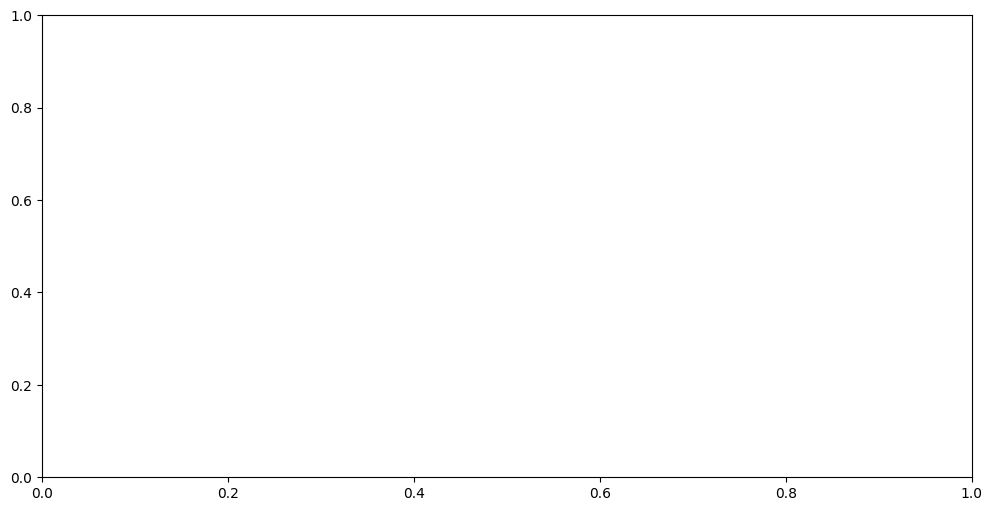

In [33]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
import json
import pandas as pd
import matplotlib.pyplot as plt
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

# 데이터 로드
with open('faq_for_vectordb.json', 'r', encoding='utf-8') as file:
    faq_data = json.load(file)

# 질문 데이터셋
questions = [item["title"] for item in faq_data]
references = [item["page_content"] for item in faq_data]

# FAISS 벡터 DB 불러오기
embedding_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large-instruct")
vectorstore = FAISS.load_local("card_QA_faiss_db", embedding_model,allow_dangerous_deserialization=True)


# RetrievalQA 모델 초기화 (유사도 검색을 통한 질의응답)
llm = ChatOpenAI(model_name='gpt-4.1-mini-2025-04-14')
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

# 질문을 통해 모델 답변 생성
def get_answer_from_retrieval(question):
    result = qa_chain.run(question)
    return result

generated_answers = [get_answer_from_retrieval(q) for q in questions]

# 평가를 위한 데이터셋 준비
data = {
    "question": questions,
    "answer": generated_answers, # 모델에서 생성한 답변
    "contexts": [[ref] for ref in references], # 원본 문서 내용 (context)
    "reference": references # 정답(reference)
}

dataset = Dataset.from_dict(data)

# RAGAS 평가 실행
result = evaluate(
    dataset=dataset,
    metrics=[faithfulness, answer_relevancy, context_precision, context_recall]
)

# 평가 결과 DataFrame 출력
result_df = result.to_pandas()
print(result_df)

# 평가 결과 시각화
fig, ax = plt.subplots(figsize=(12, 6))
result_df.mean().plot(kind='bar', ax=ax, color=['#4caf50', '#2196f3', '#ff9800', '#e91e63'])
plt.title('RAGAS Evaluation Metrics (LangChain Retrieval)')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()


In [ ]:
print(result_df.info())
print('faithfulness : ',result_df['faithfulness'].mean())
print('answer_relevancy :',result_df['answer_relevancy'].mean())
print('context_precision :',result_df['context_precision'].mean())
print('context_recall :',result_df['context_recall'].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_input          277 non-null    object 
 1   retrieved_contexts  277 non-null    object 
 2   response            277 non-null    object 
 3   reference           277 non-null    object 
 4   faithfulness        269 non-null    float64
 5   answer_relevancy    276 non-null    float64
 6   context_precision   273 non-null    float64
 7   context_recall      275 non-null    float64
dtypes: float64(4), object(4)
memory usage: 17.4+ KB
None
0.6583804888344117
0.6315123175357655
0.9963369962373625
0.9876666666666667


In [ ]:
#  'faithfulness' 0.6583804888344117